# HipSTeR analysis
## Sections (by priority): 
1. Import results for each condition + plot against data - Figs 3-5, part of Fig 6-7, Fig 10-12
2. Error differences for each layer and cycle difference - Figs 7-8
3. Representational similarity changes across epochs - Figs 7-8
4. Analyze connection weight changes in different conditions - Fig 9
5. Plot drifting autocorrelation patterns - Fig 2A,D

Note: Fig 2D created in MATLAB

In [106]:
import csv #import packages
import math
import copy
import scipy
import random
import warnings
import scipy.io
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import matlib
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.display import HTML
warnings.filterwarnings(action = 'ignore') 

In [107]:
#basics and naming conventions
#folders and filenames would certainly need changing for anyone replicating these analyses: 
#folder names are below in this cell
Z = norm.ppf #d' stuff
%matplotlib inline
cm,cm2='gray','viridis' #colormap style
fs1,fs2,lwm=15,15,1.5
fss,cfs,lw,edgec,facec,msz=10,12,3,"0",(1,1,1,0),10 #plot defaults
plt.rcParams.update({'font.size': cfs*3})
plt.rcParams['axes.linewidth'] = lw
plt.rcParams['lines.linewidth'] = lw
plt.rcParams.update({'font.family':'Arial'})
plt.rcParams['figure.figsize'] = [fs2,fs2]
lls=['No Lag','RI-32','RI-64','RI-128','RI-256','RI-512','RI-1024','RI-2048','Scram RI']
lls_red=['No Lag','RI-32','RI-256','RI-2048','Scram RI'] #reduced plot labels
lls_red2=['No Lag','RI-32','RI-256','RI-2048'] #reduced further
lls_dc=['E/O/C','E/O/V','E/N/C','E/N/V', 
        'T/O/C','T/O/V','T/N/C','T/N/V'] #decontext. labels;E/T=epoch/trial;O/N=old/new;C/V=constant/variable
base="/Users/jantony/Documents/stcm7/sims/stcm7/gresults/" #base filename
rdir="/Users/jantony/Documents/stcm7/jupyter/RStuff/" #base filename

In [108]:
def dprime(d): #functions
    d['#AB TrgOnWasOff'][d['#AB TrgOnWasOff']==0]=1/(n_targ*2)
    d['#AB TrgOffWasOn'][d['#AB TrgOffWasOn']==0]=1/(n_targ*2)
    d['#AC TrgOnWasOff'][d['#AC TrgOnWasOff']==0]=1/(n_targ*2)
    d['#AC TrgOffWasOn'][d['#AC TrgOffWasOn']==0]=1/(n_targ*2)
    d['ABd']=Z(1-d['#AB TrgOnWasOff'])-Z(d['#AB TrgOffWasOn'])
    d['ACd']=Z(1-d['#AC TrgOnWasOff'])-Z(d['#AC TrgOffWasOn'])
    return d
def rdf(d):
    q1,q2=pd.DataFrame(),pd.DataFrame()
    q1=pd.DataFrame({"MemType":abq,"Memory":d[abl],"d-prime":d[abld],"TrgOn":d[abt],"TrgOff":d[abtoff]})
    q2=pd.DataFrame({"MemType":acq,"Memory":d[acl],"d-prime":d[acld],"TrgOn":d[abt],"TrgOff":d[abtoff]})
    comb = [q1, q2]
    newdf = pd.concat(comb)
    return newdf
def rdf2(d0,lls,q0p,conc,t1,t2,t3,t4):#shape for all on same plot
    q0=pd.DataFrame({"MemGroup":np.matlib.repmat(lls[i+adj],nreps,1).flatten(),
                     "Memory":d0[t1],"d-prime":d0[t2],"TrgOn":d0[t3],"TrgOff":d0[t4]})
    if conc:
        comb = [q0p,q0]
        newdf = pd.concat(comb)
    else:
        newdf = q0
    return newdf
def pnbf(base,fjob1):
    if fjob1<10:
        pnb=base+"jan00000" #out for all outputs
    elif fjob1<100:
        pnb=base+"jan0000"
    elif fjob<1000:
        pnb=base+"jan000"
    elif fjob<10000:
        pnb=base+"jan00"
    else:
        pnb=base+"jan0"
    return pnb

In [109]:
#EXP NOTES: use these #s below in 'first' to run 
#9245- main+scram w/ memthr 0.2, 1/4 drvl, fixed no lag
#10081-10116-ECE w/ 16/64
#9380-9487 Rawson-the rest (9407=Cepeda) #previously 9344 started ECE, with bug
#9506- no ec-dg
#9605- no ec-ca3
#9704- no ec-ca1
#9803- no ca3-ca3
#9902- no ec-ca3 EDL
#10001- decontextualization
#10009- Rawson extra with maxepcs=6
#10018- Rawson 3 levels of spacing

#10117-WRONG
#10387- WRONG
#10423-WRONG
#10522- main w/ spect_type=2
#10756- cepeda
#10951- main w/ spect_type=3
#10621- main w/ spect_type=4
#10720-ECE 16/256
#11050-ECE 16/256 w/ NO EDL
#11086-ECE 64/256

## 1 - Import and plot results
### Spatial decontextualization experiments - Fig 12

In [110]:
#names from go outputs
abl,acl,abld,acld='#AB Mem','#AC Mem','ABd','ACd'
abt,abtoff,act,actoff='#AB TrgOnWasOff','#AB TrgOffWasOn','#AC TrgOnWasOff','#AC TrgOffWasOn'
memord=1 #memory or d-prime
iv="MemGroup" #ind var
if memord==1:
    dv,targm,maxy="Memory","AB",4
elif memord==2:
    dv,targm,maxy="d-prime","AB",4
adj=0
tconds=len(lls_dc)
nruns=100 # #runs
llength=16 #list length
n_targ=49*4 # #neurons in target layer
runspd=0 #run or no?
if runspd:
    print('# conds:%s' %tconds)
    first=10001 #first # in string of imports
    fjobs=np.arange(first,first+1,tconds)
    for h in range(len(fjobs)):
        fjob=int(fjobs[h])
        ofjob=fjob+0
        pnb=pnbf(base,fjob)
        print(h)
        df0=pd.read_csv(pnb+str(fjob)+"/stcm7_Base_run.tsv", sep='\t', header=0) 
        df0=df0[:nruns]
        abrep,acrep,nreps="AB","AC",df0.shape[0]
        abq=np.matlib.repmat(abrep,nreps,1).flatten()
        acq=np.matlib.repmat(acrep,nreps,1).flatten()

        #all conds loop, no pvals for now
        fcomb=pd.DataFrame()
        count=0
        for i in range(tconds):
            pnb=pnbf(base,fjob)
            ii=i+0
            fn=pnb+str(fjob)+"/stcm7_Base_run.tsv"
            df0=pd.read_csv(fn, sep='\t', header=0)
            df0=df0[:nruns]
            df0=dprime(df0)
            f0=rdf(df0)
            actest=0
            if i==0:
                if actest:
                    fcomb=rdf2(df0,lls_dc,fcomb,0,acl,acld,act,actoff)
                else:
                    fcomb=rdf2(df0,lls_dc,fcomb,0,abl,abld,abt,abtoff)
            else:
                if actest:
                    fcomb=rdf2(df0,lls_dc,fcomb,1,acl,acld,act,actoff)
                else:
                    fcomb=rdf2(df0,lls_dc,fcomb,1,abl,abld,abt,abtoff)
            #fcomb['d-prime'][np.isinf(fcomb['d-prime'])]=4.65 #fix inf
            fjob=fjob+1
        fjob=ofjob+0

        f,ax=plt.subplots(1,1,figsize=(fss,fss))
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
        ax2=sns.barplot(x=iv,y=dv,facecolor=facec,edgecolor=edgec,data=fcomb,linewidth=3,errwidth=6,errcolor='k')
        plt.setp(ax2.lines,zorder=1)
        hatches = itertools.cycle(['//']) #https://stackoverflow.com/questions/42185000/add-hash-pattern-to-a-seaborn-bar-plot
        hatch = next(hatches)
        for i, bar in enumerate(ax2.patches):
            if i % 2 == 1:
                bar.set_hatch(hatch)

        ax.set_xlabel("Condition",fontsize=cfs*3.5)
        ax.set_ylabel(dv,fontsize=cfs*3.5)
        ax.tick_params(labelsize=cfs*3)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        f.tight_layout()
        fn='figs/DecontMemory-' + str(first) + '.pdf'
        f.savefig(fn, transparent=True)
        
        dat_o=np.zeros((nruns,tconds))
        for i in range(nruns):
            dat_o[i,:]=fcomb[dv][i]
        print(np.mean(dat_o,axis=0))
        p=stats.ttest_rel(dat_o[:,0],dat_o[:,4])
        print(ofjob)
        fn='dat/dat_o-' + str(ofjob) + '-' + str(memord)
        scipy.io.savemat(fn,{'dat_o': dat_o})
        
        fcombR= fcomb.copy()
        fcombR['EvT']=0
        fcombR['EvT'][fcomb['MemGroup']=='T/O/C']=1
        fcombR['EvT'][fcomb['MemGroup']=='T/O/V']=1
        fcombR['EvT'][fcomb['MemGroup']=='T/N/C']=1
        fcombR['EvT'][fcomb['MemGroup']=='T/N/V']=1
        fcombR['TestC']=0
        fcombR['TestC'][fcomb['MemGroup']=='E/N/C']=1
        fcombR['TestC'][fcomb['MemGroup']=='E/N/V']=1
        fcombR['TestC'][fcomb['MemGroup']=='T/N/C']=1
        fcombR['TestC'][fcomb['MemGroup']=='T/N/V']=1
        fcombR['Var']=0
        fcombR['Var'][fcomb['MemGroup']=='E/O/V']=1
        fcombR['Var'][fcomb['MemGroup']=='E/N/V']=1
        fcombR['Var'][fcomb['MemGroup']=='T/O/V']=1
        fcombR['Var'][fcomb['MemGroup']=='T/N/V']=1
        #export to R
        fn=rdir+'decon_Rdata.csv'
        fcombR.to_csv(fn)

### Spacing experiments

In [111]:
#here we import and crunch new data hauled over from the cluster - only need to do this once for new results
abl,acl,abld,acld='#AB Mem','#AC Mem','ABd','ACd'
abt,abtoff,act,actoff='#AB TrgOnWasOff','#AB TrgOffWasOn','#AC TrgOnWasOff','#AC TrgOffWasOn'
memord=1 #memory or d-prime
iv="MemGroup"
if memord==1:
    dv,targm,maxy="Memory","AB",4
elif memord==2:
    dv,targm,maxy="d-prime","AB",4
elif memord==3:
    dv,targm,maxy="d-prime","AC",5
elif memord==4:
    dv,targm,maxy="TrgOff","AB",1
adj=0
tconds=len(lls)-adj #9 for most, 6 for Glenberg
print('# conds:%s' %tconds)
nruns=100
llength=16 #list length
n_targ=400 # #neurons in target layer...
base="/Users/jantony/Documents/stcm7/sims/stcm7/gresults/" #folder name - needs changing any replication
crunch=0 #crunch new numbers or no?
if crunch:
    first=11086 #10081
    #90 for main (81 w/o scram), 27 ECE, 9 Rawson, 0 Rawson extra, 45/72 Cepeda; +1 for Rawson?
    jobadd=27
    fjobs=np.arange(first,first+jobadd+1,tconds)##cepeda
    print(fjobs)
    #fjobs=np.arange(first,first+81+1,len(lls))#Glenberg
    proc=1
    for h in range(len(fjobs)):
        fjob=int(fjobs[h])
        ofjob=fjob+0
        pnb=pnbf(base,fjob)
        print(h)
        df0=pd.read_csv(pnb+str(fjob)+"/stcm7_Base_run.tsv", sep='\t', header=0) 
        df0=df0[:nruns]
        abrep,acrep,nreps="AB","AC",df0.shape[0]
        abq=np.matlib.repmat(abrep,nreps,1).flatten()
        acq=np.matlib.repmat(acrep,nreps,1).flatten()

        #all conds loop, no pvals for now
        fcomb=pd.DataFrame()
        count=0
        for i in range(tconds):
            pnb=pnbf(base,fjob)
            ii=i+0
            fn=pnb+str(fjob)+"/stcm7_"+str(ii+adj)+"_run.tsv"
            fn=pnb+str(fjob)+"/stcm7_Base_run.tsv"
            df0=pd.read_csv(fn, sep='\t', header=0)
            df0=df0[:nruns]
            df0=dprime(df0)
            f0=rdf(df0)
            actest=0
            if i==0:
                if actest:
                    fcomb=rdf2(df0,lls,fcomb,0,acl,acld,act,actoff)
                else:
                    fcomb=rdf2(df0,lls,fcomb,0,abl,abld,abt,abtoff)
            else:
                if actest:
                    fcomb=rdf2(df0,lls,fcomb,1,acl,acld,act,actoff)
                else:
                    fcomb=rdf2(df0,lls,fcomb,1,abl,abld,abt,abtoff)
            #fcomb['d-prime'][np.isinf(fcomb['d-prime'])]=4.65 #fix inf
            fjob=fjob+1
        fjob=ofjob+0

        f,ax=plt.subplots(1,1)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
        ax2=sns.swarmplot(x=iv,y=dv,color=None,facecolor=None,size=3,edgecolor=edgec,data=fcomb)
        plt.setp(ax2.lines,zorder=0)
        ax2=sns.barplot(x=iv,y=dv,facecolor=facec,edgecolor=edgec,data=fcomb)
        plt.setp(ax2.lines,zorder=1)

        ax.set_xlabel("Delay",fontsize=cfs*3)
        ax.set_ylabel(dv,fontsize=cfs*3)
        ax.tick_params(labelsize=cfs*3)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_title('%s memory' %targm,fontsize=cfs*3)
        f.tight_layout()
        
        dat_o=np.zeros((nruns,tconds))
        for i in range(nruns):
            dat_o[i,:]=fcomb[dv][i]
        print(np.mean(dat_o,axis=0))
        p=stats.ttest_rel(dat_o[:,0],dat_o[:,4])
        print(ofjob)
        fn='dat/dat_o-' + str(ofjob) + '-' + str(memord)
        scipy.io.savemat(fn,{'dat_o': dat_o})

# conds:9


## Plot spacing experiment results

['No Lag', 'RI-32', 'RI-256', 'RI-2048', 'Scram RI']
9
[10621, 10630, 10666, 10702]
(2000, 3)
length of df1: 2000


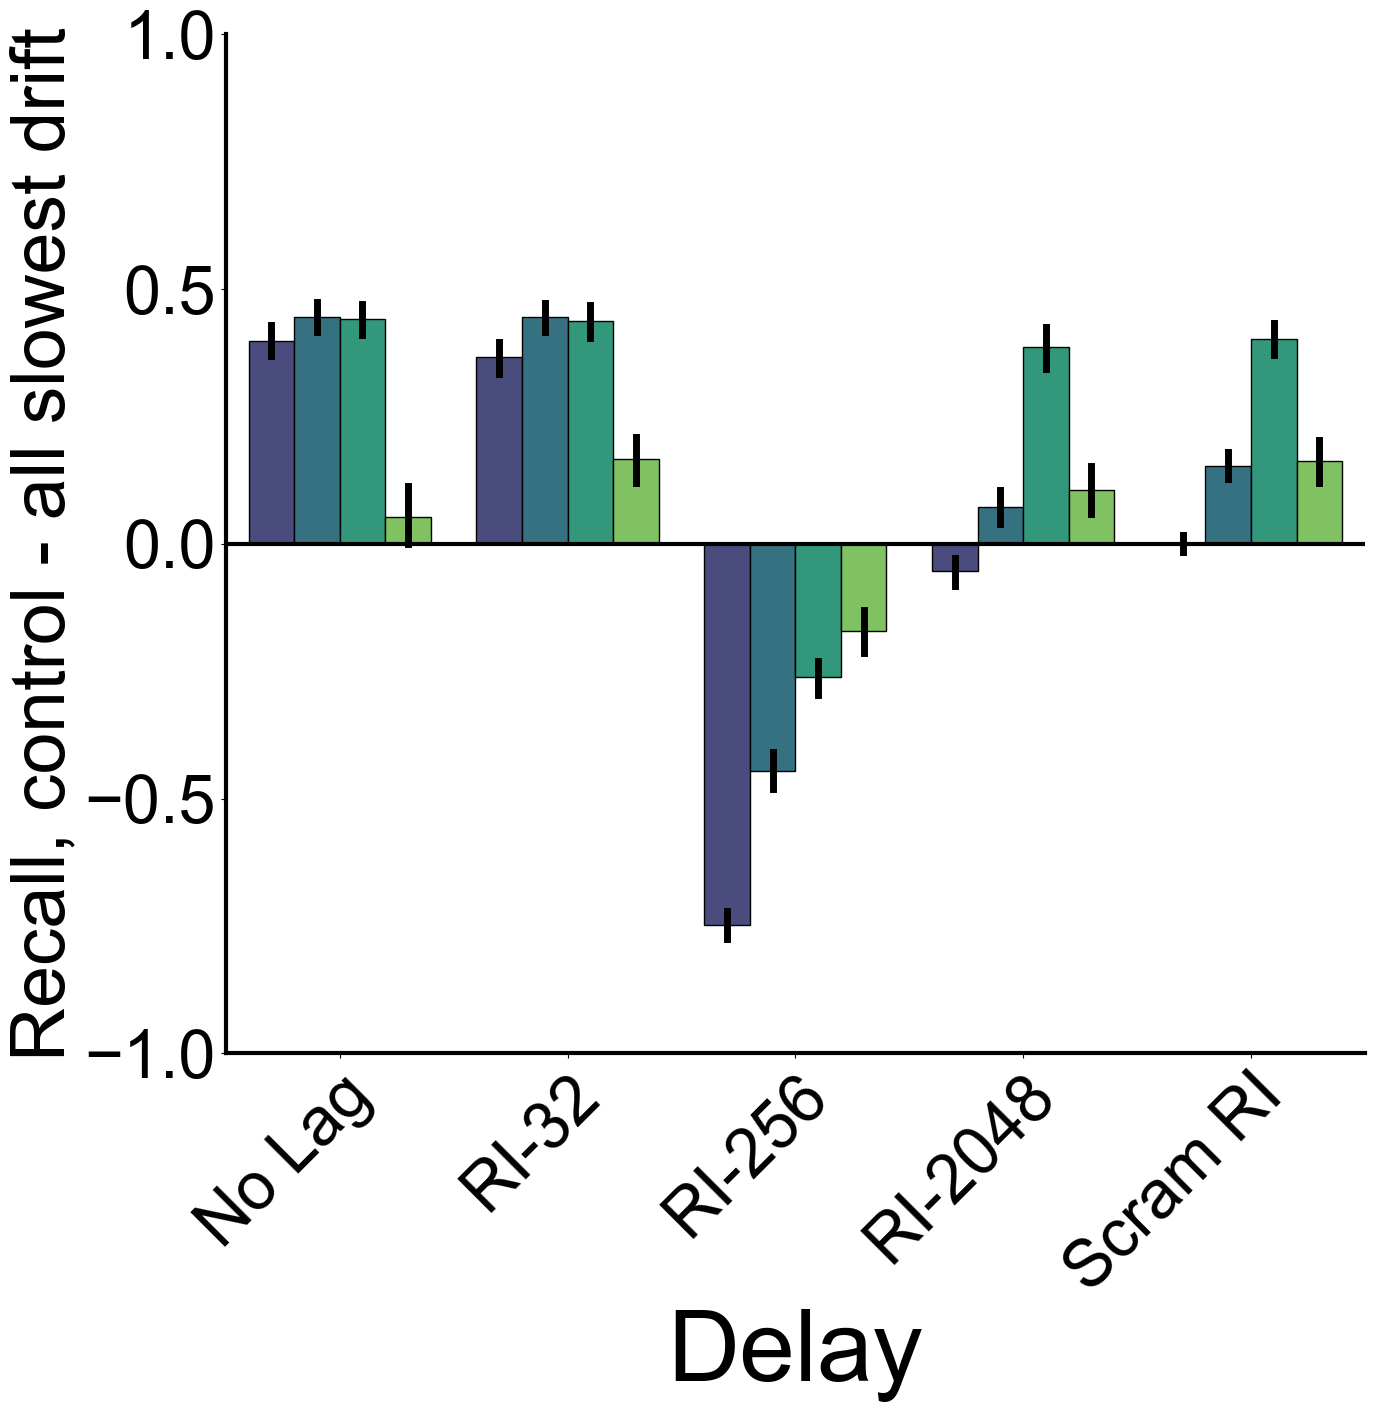

In [129]:
#plot experiment results based on 'runnr' -- see 'if' statements for experiment labels
#also relevant is 'compconds', which controls whether we compare experiments (as in Fig 10-11)
comb=1
if comb:
    #condition labels
    ells_a=['No drift','ISI-2','ISI-4','ISI-8','ISI-16','ISI-32','ISI-64','ISI-128','ISI-256','ISI-512']
    ells_a=['No drift','ISI-2','ISI-4','ISI-8','ISI-16','ISI-32','ISI-64','ISI-128','ISI-256','ISI-512','Scram-ISI']
    ells_red=['No drift','ISI-2','ISI-32','ISI-512']
    ells_a2=['Expanding','Contracting','Equal, match','Equal, compressed']
    ells_a4=['Rawson, massed','Rawson, spaced','Rawson, massed, extra']
    ells_a4=['Low spaced train','Med spaced train','High spaced train']
    ells_a5=['ISI-2','ISI-4','ISI-8','ISI-16','ISI-32','ISI-64','ISI-128','ISI-256','ISI-512']
    #ells_a6=['Gb-15','Gb-7','Gb-3','Gb-1','Gb-0 (massed)'] 
    ells_a6=['ISI-0 (massed)','ISI-1','ISI-3','ISI-7','ISI-15','ISI-31'] 
    lls=['No lag','RI-32','RI-64','RI-128','RI-256','RI-512','RI-1024','RI-2048','Scram RI']
    lls_ece=['RI-64','RI-128','RI-256','RI-512','RI-1024','RI-2048']

    runnr=1009
    #compare conditions? if so, (1) + enter them below. if (2), compare no ec-ca3 vs. EDL in ec-ca3
    compconds=1 #1 = compare conditions - see below; if 2, set runnr=9
    main_first=9245 ##### change this for the corresponding experiment in EXP NOTES above
    ece_first=10720 #11086#11050
    cepeda_first=10756
    ctconds=len(lls)-adj
    q_ind=np.linspace(0,len(lls)-1,len(lls))
    q_ind_red,q_ind_red2,q_ind_red3=[0,1,4,7,8],[0,1,4,7],[0,1,2,3,4,5]
    if runnr==1: #main / Bahrick 1993
        ells,first=copy.deepcopy(ells_a),main_first+0
        dat_rge=np.arange(first,first+90+1,tconds)
    elif runnr==101: #regular, only 2 ISIs
        ells,first=['No drift','Drift'],main_first+0 
        dat_rge=[first,first+18]
    elif runnr==102: #regular, only 2 ISIs, reduced RIs
        ells,first=['No drift','Drift'],main_first+0 
        lls,ctconds,q_ind=copy.deepcopy(lls_red2),len(lls_red2),copy.deepcopy(q_ind_red2)
        dat_rge=[first,first+18]
    elif runnr==2: #ece / kupper-tetzel
        ells,first=copy.deepcopy(ells_a2),ece_first
        dat_rge=np.arange(first,first+27+1,tconds) 
    elif runnr==3: #rawson
        ells,first=copy.deepcopy(ells_a4),9380
        dat_rge=np.arange(first,first+9+1,tconds)
        dat_rge=np.hstack([dat_rge,10009]) 
        ells,first=copy.deepcopy(ells_a4),10018
        dat_rge=np.arange(first,first+18+1,tconds)
    elif runnr==4: #cepeda
        ells,first=copy.deepcopy(ells_a5),cepeda_first+0
        dat_rge=np.arange(first,first+72+1,tconds) 
    elif runnr==5:
        ells,first=copy.deepcopy(ells_a6),1438
        dat_rge=np.arange(first,first+18+1,tconds)
        lls=['RI-32','RI-16','RI-8','RI-5'] # must change ctconds above
    elif runnr==11: #main, reduced format
        ells,first=copy.deepcopy(ells_red),7395
        lls,ctconds,q_ind=copy.deepcopy(lls_red),len(lls_red),copy.deepcopy(q_ind_red)
        dat_rge=[first,first+9,first+45,first+81]
    elif runnr==6: #no EC-DG
        ells,first=copy.deepcopy(ells_red),9506
        lls,ctconds,q_ind=copy.deepcopy(lls_red),len(lls_red),copy.deepcopy(q_ind_red)
        dat_rge=[first,first+9,first+45,first+81]
    elif runnr==7: #no EC-CA3
        ells,first=copy.deepcopy(ells_red),9605
        lls,ctconds,q_ind=copy.deepcopy(lls_red),len(lls_red),copy.deepcopy(q_ind_red)
        dat_rge=[first,first+9,first+45,first+81]
    elif runnr==8: #no CA3-CA3
        ells,first=copy.deepcopy(ells_red),9803
        lls,ctconds,q_ind=copy.deepcopy(lls_red),len(lls_red),copy.deepcopy(q_ind_red)
        dat_rge=[first,first+9,first+45,first+81]
    elif runnr==9: #no EC-CA3 EDL only
        ells,first=copy.deepcopy(ells_red),9902
        lls,ctconds,q_ind=copy.deepcopy(lls_red),len(lls_red),copy.deepcopy(q_ind_red)
        dat_rge=[first,first+9,first+45,first+81]
    elif runnr==10: #no EC-CA1
        ells,first=copy.deepcopy(ells_red),9704
        lls,ctconds,q_ind=copy.deepcopy(lls_red),len(lls_red),copy.deepcopy(q_ind_red)
        dat_rge=[first,first+9,first+45,first+81]
    elif runnr==1007: #all fast drifting!
        ells,first=copy.deepcopy(ells_red),10522
        lls,ctconds,q_ind=copy.deepcopy(lls_red),len(lls_red),copy.deepcopy(q_ind_red)
        dat_rge=[first,first+9,first+45,first+81]
        if compconds:
            ells=copy.deepcopy(ells_red)
            lls,ctconds,q_ind=copy.deepcopy(lls_red),len(lls_red),copy.deepcopy(q_ind_red)
            dat_rge=[first,first+9,first+45,first+81]
    elif runnr==1008: #all medium drifting!
        ells,first=copy.deepcopy(ells_red),10951
        lls,ctconds,q_ind=copy.deepcopy(lls_red),len(lls_red),copy.deepcopy(q_ind_red)
        dat_rge=[first,first+9,first+45,first+81]
        if compconds:
            ells=copy.deepcopy(ells_red)
            lls,ctconds,q_ind=copy.deepcopy(lls_red),len(lls_red),copy.deepcopy(q_ind_red)
            dat_rge=[first,first+9,first+45,first+81]
    elif runnr==1009: #all slow drifting!
        ells,first=copy.deepcopy(ells_red),10621
        lls,ctconds,q_ind=copy.deepcopy(lls_red),len(lls_red),copy.deepcopy(q_ind_red)
        dat_rge=[first,first+9,first+45,first+81]
        if compconds:
            ells=copy.deepcopy(ells_red)
            lls,ctconds,q_ind=copy.deepcopy(lls_red),len(lls_red),copy.deepcopy(q_ind_red)
            dat_rge=[first,first+9,first+45,first+81]
    elif runnr==1010: #regular
        ells,first=['Low drift','High drift'],7395 
        dat_rge=[first+9,first+63]
    elif runnr==1011: #no EC-CA3 EDL only
        ells,first=['Low drift','High drift'],2374
        dat_rge=[first+9,first+63]

    print(lls)
    print(tconds)
    print(dat_rge)
    dat_oa=[]
    for i in range(len(dat_rge)):
        fn='dat/dat_o-' + str(dat_rge[i]) + '-' + str(memord)
        mat_contents=scipy.io.loadmat(fn)
        q=mat_contents['dat_o']
        sh=q.shape[0]
        qq=np.vstack([np.zeros((sh)),q[:,int(q_ind[0])]]).T
        qq=np.vstack([qq,np.vstack([np.zeros((sh))+1,q[:,int(q_ind[1])]]).T])
        qq=np.vstack([qq,np.vstack([np.zeros((sh))+2,q[:,int(q_ind[2])]]).T])
        qq=np.vstack([qq,np.vstack([np.zeros((sh))+3,q[:,int(q_ind[3])]]).T])
        if ctconds>4:
            qq=np.vstack([qq,np.vstack([np.zeros((sh))+4,q[:,int(q_ind[4])]]).T])
            if ctconds>5:
                qq=np.vstack([qq,np.vstack([np.zeros((sh))+5,q[:,int(q_ind[5])]]).T])
                if ctconds>6:
                    qq=np.vstack([qq,np.vstack([np.zeros((sh))+6,q[:,int(q_ind[6])]]).T])
                    qq=np.vstack([qq,np.vstack([np.zeros((sh))+7,q[:,int(q_ind[7])]]).T])
                    if runnr==131:
                        fn='dat/dat_o-' + str(dat_add[i]) + '-' + str(memord)
                        mat_contents=scipy.io.loadmat(fn)
                        q=mat_contents['dat_o']
                        qq=np.vstack([qq,np.vstack([np.zeros((sh))+8,q[:,int(q_ind[8])]]).T])
                    if ctconds>8:
                        qq=np.vstack([qq,np.vstack([np.zeros((sh))+8,q[:,int(q_ind[8])]]).T])
                        if ctconds>9:
                            qq=np.vstack([qq,np.vstack([np.zeros((sh))+9,q[:,int(q_ind[9])]]).T])
        qqq=np.hstack([np.zeros((qq.shape[0],1))+i,qq])
        if i==0:
            dat_oa=qqq
        else:
            dat_oa=np.vstack([dat_oa,qqq])
    print(dat_oa.shape)
    if compconds: #MAKE THIS > 0 IF WE WANT TO COMPARE CONDITIONS
        ells,first=copy.deepcopy(ells_a),main_first+0
        dat_rge2=[first,first+9,first+45,first+81] #reduce # of conditions for plotting!
        if compconds==2: #compare no EDL and no learning
            ells,first=copy.deepcopy(ells_a),9605#2104
            dat_rge2=[first,first+9,first+45,first+81] 
        dat_oa2=[]
        for i in range(len(dat_rge2)):
            fn='dat/dat_o-' + str(dat_rge2[i]) + '-' + str(memord)
            mat_contents=scipy.io.loadmat(fn)
            q=mat_contents['dat_o']
            sh=q.shape[0]
            qq=np.vstack([np.zeros((sh)),q[:,int(q_ind[0])]]).T
            qq=np.vstack([qq,np.vstack([np.zeros((sh))+1,q[:,int(q_ind[1])]]).T])
            qq=np.vstack([qq,np.vstack([np.zeros((sh))+2,q[:,int(q_ind[2])]]).T])
            qq=np.vstack([qq,np.vstack([np.zeros((sh))+3,q[:,int(q_ind[3])]]).T])
            if ctconds>4:
                qq=np.vstack([qq,np.vstack([np.zeros((sh))+4,q[:,int(q_ind[4])]]).T])
                if ctconds>5:
                    qq=np.vstack([qq,np.vstack([np.zeros((sh))+5,q[:,int(q_ind[5])]]).T])
                    if ctconds>6:
                        qq=np.vstack([qq,np.vstack([np.zeros((sh))+6,q[:,int(q_ind[6])]]).T])
                        qq=np.vstack([qq,np.vstack([np.zeros((sh))+7,q[:,int(q_ind[7])]]).T])
                        if ctconds>8:
                            qq=np.vstack([qq,np.vstack([np.zeros((sh))+8,q[:,int(q_ind[8])]]).T])
                            if ctconds>9:
                                qq=np.vstack([qq,np.vstack([np.zeros((sh))+9,q[:,int(q_ind[9])]]).T])

            qqq=np.hstack([np.zeros((qq.shape[0],1))+i,qq])
            if i==0:
                dat_oa2=qqq
            else:
                dat_oa2=np.vstack([dat_oa2,qqq])

    #create dataframe of all data
    df1=pd.DataFrame()
    if compconds:
        df1=pd.DataFrame({"Exp":dat_oa[:,0],"Cond":dat_oa[:,1],dv:dat_oa2[:,2]-dat_oa[:,2]})
    else:
        df1=pd.DataFrame({"Exp":dat_oa[:,0],"Cond":dat_oa[:,1],dv:dat_oa[:,2]})
    print('length of df1: %s' %len(df1))
    for i in range(len(df1)):
        expn=df1['Exp'][i]
        condn=df1['Cond'][i]
        df1['Exp'][i]=ells[int(expn)]
        df1['Cond'][i]=lls[int(condn)]

    f,ax=plt.subplots(1,1)
    iv,dv,huey="Cond",dv,"Exp"
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    plt.setp(ax.lines,zorder=0)
    if runnr==1:
        ax2=sns.barplot(x=iv,y=dv,hue=huey,edgecolor='k',palette=cm2,data=df1,errcolor='k',errwidth=3)
    elif runnr<80:
        ax2=sns.barplot(x=iv,y=dv,hue=huey,edgecolor='k',palette=cm2,data=df1,errcolor='k',errwidth=5)
    elif runnr<1010:
        ax2=sns.barplot(x=iv,y=dv,hue=huey,edgecolor='k',palette=cm2,data=df1,errcolor='k',errwidth=5)
    else:
        ax2=sns.barplot(x=iv,y=dv,hue=huey,edgecolor='k',palette="tab10",data=df1,errcolor='k',errwidth=5)
    plt.setp(ax2.lines,zorder=1)

    ax.set_xlabel("Delay",fontsize=cfs*6)
    ax.set_ylabel('Recall',fontsize=cfs*6)
    if runnr==1:
        ax.set_xlabel("Delay",fontsize=cfs*4)
        ax.set_ylabel('Recall',fontsize=cfs*4)
    elif runnr==80:
        ax.set_xlabel("Delay",fontsize=cfs*5)
        ax.set_ylabel('Recall',fontsize=cfs*5)
    elif runnr==101:
        ax.set_xlabel("Delay",fontsize=cfs*5)
        ax.set_ylabel('Recall',fontsize=cfs*5)
    if compconds:
        lab1='Recall, control - lesion'
        if compconds==2:
            lab1='Recall, no learning - no EDL'
        if runnr==1007:
            lab1='Recall, control - all fastest drift'
        elif runnr==1008:
            lab1='Recall, control - all medium drift'
        elif runnr==1009:
            lab1='Recall, control - all slowest drift'
        ax.set_ylabel(lab1,fontsize=cfs*4.5)
    ax.tick_params(labelsize=cfs*3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(ncol=2,loc='upper right',fontsize=cfs*2,frameon=False)
    if runnr==2:
        ax.legend(ncol=1,loc='upper right',fontsize=cfs*2.5,frameon=False)
    elif runnr==3:
        ax.legend(ncol=1,loc='upper right',fontsize=cfs*2.5,frameon=False)
    elif runnr==4:
        ax.legend(ncol=2,loc='upper right',fontsize=cfs*2.5,frameon=False)
    elif np.logical_and(runnr > 4,runnr<=11):
        ax.legend(ncol=1,loc='upper right',fontsize=cfs*3.5,frameon=False)
        ax.get_legend().remove()
        ax.tick_params(labelsize=cfs*4)
    elif np.logical_or(runnr==101,runnr==102):
        ax.legend(ncol=1,loc='upper right',fontsize=cfs*4,frameon=False)
        ax.tick_params(labelsize=cfs*4)
    elif runnr==113:
        ax.legend(ncol=1,loc='upper right',fontsize=cfs*2.5,frameon=False)
        ax.tick_params(labelsize=cfs*4)
    elif runnr==1007:
        ax.legend(ncol=4,loc='upper right',fontsize=cfs*2,frameon=False)
        ax.get_legend().remove()
        ax.tick_params(labelsize=cfs*4)
    elif runnr==1008:
        ax.legend(ncol=4,loc='upper right',fontsize=cfs*2,frameon=False)
        ax.get_legend().remove()
        ax.tick_params(labelsize=cfs*4)
    elif runnr==1009:
        ax.legend(ncol=2,loc='lower left',fontsize=cfs*2)
        ax.get_legend().remove()
        ax.tick_params(labelsize=cfs*4)
    elif runnr>1009:
        ax.legend(ncol=1,loc='upper right',fontsize=cfs*4,frameon=False)
        ax.tick_params(labelsize=cfs*4)
    if memord==1:
        ax.set_ylim(0,1)
        if compconds:
            ax.set_ylim(-1,1)
            plt.axhline(0, color='k')
            ax.legend(ncol=2,loc='upper right',fontsize=cfs*3.5,frameon=False)
            ax.get_legend().remove()
    elif memord==2:
        ax.set_ylim(0,6)
    f.tight_layout()
    fn='figs/memory-' + str(runnr) + '-' + str(compconds) + '.pdf'
    f.savefig(fn, transparent=True)

In [130]:
#export to R for more stats
exportR=1
if exportR:
    fn=rdir+str(runnr)+'-Rdata.csv'
    if compconds==2:
        fn=rdir+str(runnr)+'-Rdata-comp.csv'
    df1.to_csv(fn)

In [113]:
#some stats here
print(dat_oa.shape)
sel_ttest=0
if sel_ttest:
    #data are stacked like 0-100 = no drift + RI-0; 100-200 = no drift + RI-1, etc.
    el1,sec1,cons=300,900,100 
    fir=dat_oa[el1:el1+cons,2]
    sec=dat_oa[sec1+el1:sec1+el1+cons,2]
    thi=dat_oa[sec1*2+el1:sec1*2+el1+cons,2]
    if dat_oa.shape[0]>2700:
        fou=dat_oa[sec1*3+el1:sec1*3+el1+cons,2]
        if dat_oa.shape[0]>3600:
            fif=dat_oa[sec1*4+el1:sec1*4+el1+cons,2]
            six=dat_oa[sec1*5+el1:sec1*5+el1+cons,2]
            print('fir=%s, sec=%s, thi=%s, fou=%s, fif=%s, six=%s' 
                      %(np.mean(fir),np.mean(sec),np.mean(thi),np.mean(fou),np.mean(fif),
                       np.mean(six)))

            secfifp=scipy.stats.ttest_rel(sec,fif)
            print(secfifp)
            fifsixp=scipy.stats.ttest_rel(fif,six)
            print(fifsixp)
            if dat_oa.shape[0]>5400:
                sev=dat_oa[sec1*6+el1:sec1*6+el1+cons,2]
                eig=dat_oa[sec1*7+el1:sec1*7+el1+cons,2]
                nin=dat_oa[sec1*8+el1:sec1*8+el1+cons,2]
                #pick contrasts
                print('fir=%s, sec=%s, thi=%s, fou=%s, fif=%s, six=%s, sev=%s, eig=%s, nin=%s' 
                      %(np.mean(fir),np.mean(sec),np.mean(thi),np.mean(fou),np.mean(fif),
                       np.mean(six),np.mean(sev),np.mean(eig),np.mean(nin)))
                ppp=scipy.stats.ttest_rel(sec,fif)
                print(ppp)
                ppp23=scipy.stats.ttest_rel(fif,nin)
                print(ppp23)
    
    print('fir=%s, sec=%s, thi=%s' %(np.mean(fir),np.mean(sec),np.mean(thi)))
    firsecp=scipy.stats.ttest_rel(fir,sec)
    print(firsecp)
    if dat_oa.shape[0]>1800:
        thi=dat_oa[sec1*2+el1:sec1*2+el1+cons,2]        
        firthip=scipy.stats.ttest_rel(fir,thi)
        print(firthip)
        secthip=scipy.stats.ttest_rel(sec,thi)
        print(secthip)

(2000, 3)
fir=0.135625, sec=0.655, thi=nan
TtestResult(statistic=-27.570496926635926, pvalue=2.9993193981602717e-48, df=99)


ValueError: unequal length arrays

## Cepeda et al. (2008) data + simulations (Fig 3)

[0.975    0.973125 0.97375  0.9775   0.965625 0.943125 0.91     0.87875 ]
[0.80625  0.833125 0.85     0.858125 0.85875  0.8375   0.78875  0.7625  ]
[0.49875  0.5425   0.57625  0.625625 0.62     0.63125  0.6025   0.5525  ]
[0.2775   0.365625 0.395625 0.375625 0.43625  0.483125 0.48     0.433125]


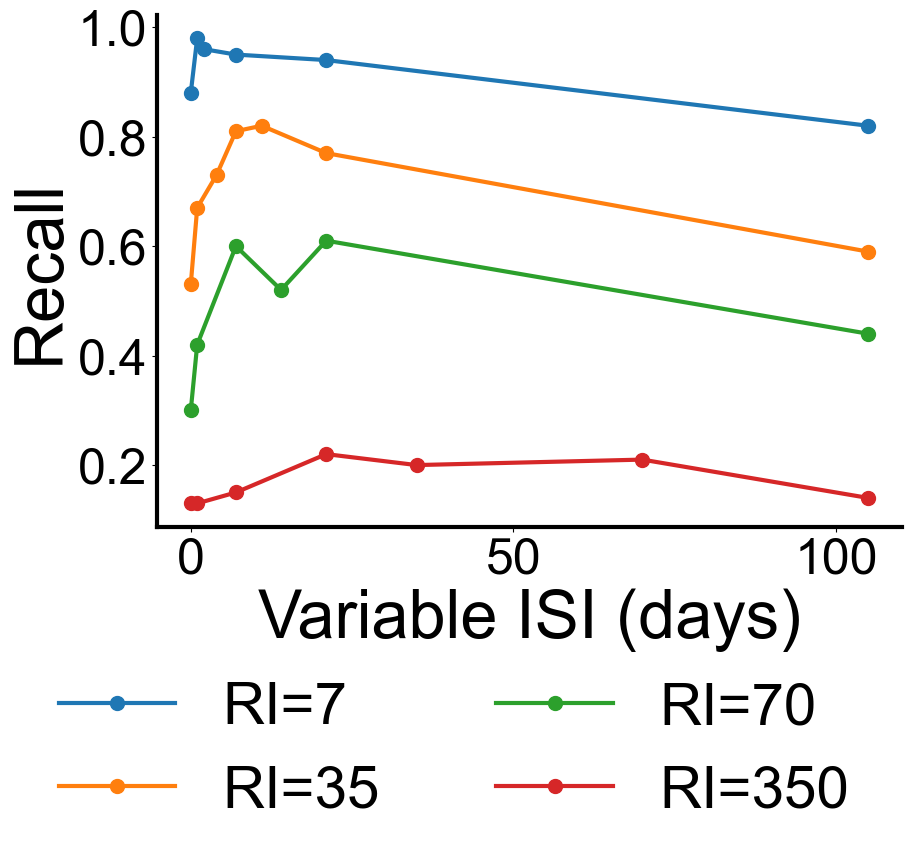

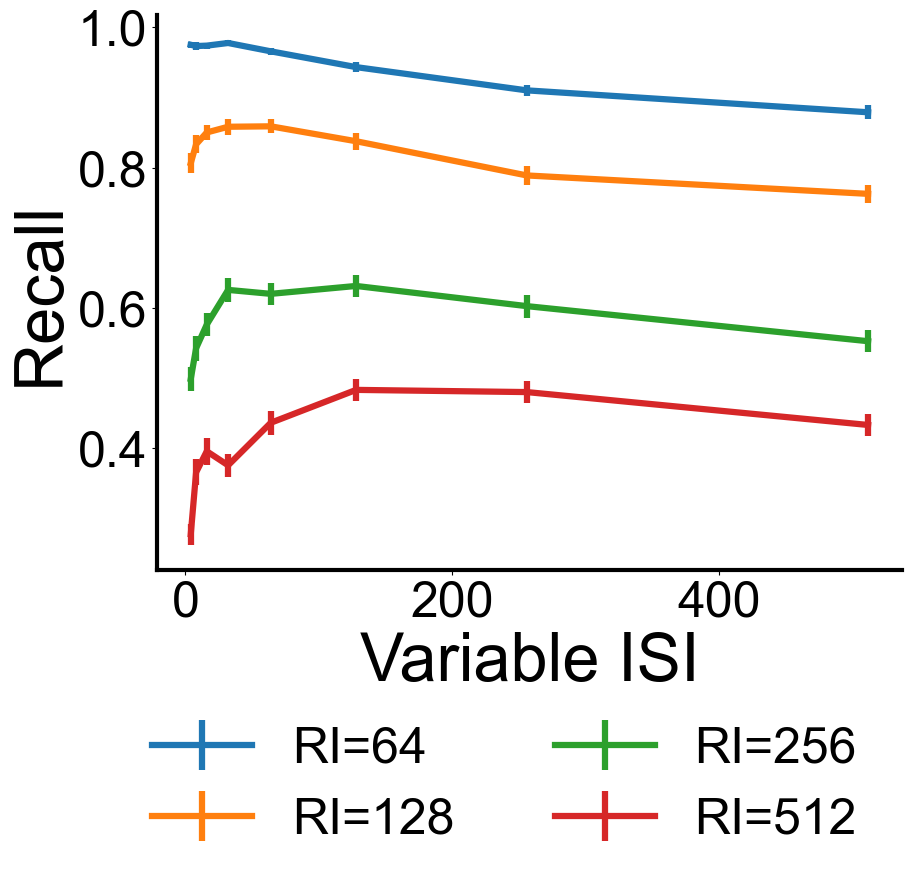

In [174]:
if runnr==4: #only works if you evaluate runnr=4 above!
    ISIs7=[0.00256,1,2,7,21,105]
    dat7=[0.88,0.98,0.96,0.95,0.94,0.82]
    ISIs35=[0.00256,1,4,7,11,21,105]
    dat35=[0.53,0.67,0.73,0.81,0.82,0.77,0.59]
    ISIs70=[0.00256,1,7,14,21,105]
    dat70=[0.3,0.42,0.6,0.52,0.61,0.44]
    ISIs350=[0.00256,1,7,21,35,70,105]
    dat350=[0.13,0.13,0.15,0.22,0.2,0.21,0.14]
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fss,fss))
    plt.plot(ISIs7,dat7,marker='o', linestyle='-',ms=msz,label='RI=7')
    plt.plot(ISIs35,dat35,marker='o', linestyle='-',ms=msz,label='RI=35')
    plt.plot(ISIs70,dat70,marker='o', linestyle='-',ms=msz,label='RI=70')
    plt.plot(ISIs350,dat350,marker='o', linestyle='-',ms=msz,label='RI=350')
    f.tight_layout()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)    
    ax.set_xlabel('Variable ISI (days)',fontsize=cfs*4)
    ax.set_ylabel('Recall',fontsize=cfs*4)
    plt.legend(bbox_to_anchor=(1,-0.2), loc='upper right', ncol=2,frameon=False,fontsize=cfs*3.5)
    f.tight_layout()
    fn='figs/cepeda_data-' + str(runnr) + '.pdf'
    f.savefig(fn, transparent=True)

    #read in our data and plot similarly
    ISIs=[2,4,8,16,32,64,128,256,512]#use only 4-128
    RIs=[0,32,64,128,256,512,1024]#,2048,4096] #scram as enormous value
    RIs_l=['','RI=32','RI=64','RI=128','RI=256','RI=512','RI=1024','RI=2048','']
    exp_m,exp_s=np.zeros((len(ISIs),len(RIs))),np.zeros((len(ISIs),len(RIs)))
    for i in range(len(ells_a5)): #ISIs
        for ii in range(len(lls)-2): #RIs
            qq=np.logical_and(df1['Exp']==ells_a5[i],df1['Cond']==lls[ii])
            exp_m[i,ii]=np.mean(df1['Memory'][qq])
            exp_s[i,ii]=np.std(df1['Memory'][qq])/np.sqrt(nruns)
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fss,fss))
    for ii in range(2,len(lls)-3):
        plt.errorbar(ISIs[1:],exp_m[1:,ii],exp_s[1:,ii],linestyle='-',linewidth=lw*lwm,
                 elinewidth=lw*lwm,label=RIs_l[ii])
        print(exp_m[1:,ii])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)    
    ax.set_xlabel('Variable ISI',fontsize=cfs*4)
    ax.set_ylabel('Recall',fontsize=cfs*4)
    plt.legend(bbox_to_anchor=(1,-0.2), loc='upper right', ncol=2,frameon=False,fontsize=cfs*3)
    f.tight_layout()
    fn='figs/cepeda_model-' + str(runnr) + '.pdf'
    f.savefig(fn, transparent=True)

## Rawson et al. (2018) - data + simulations (Fig 4)

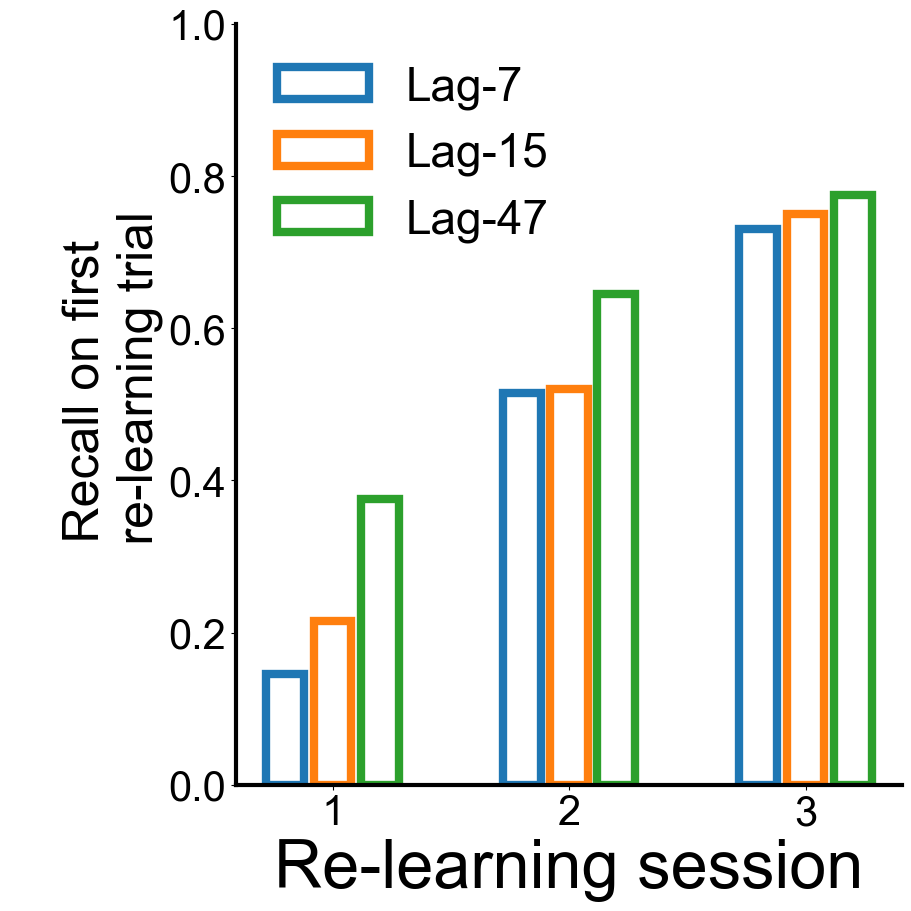

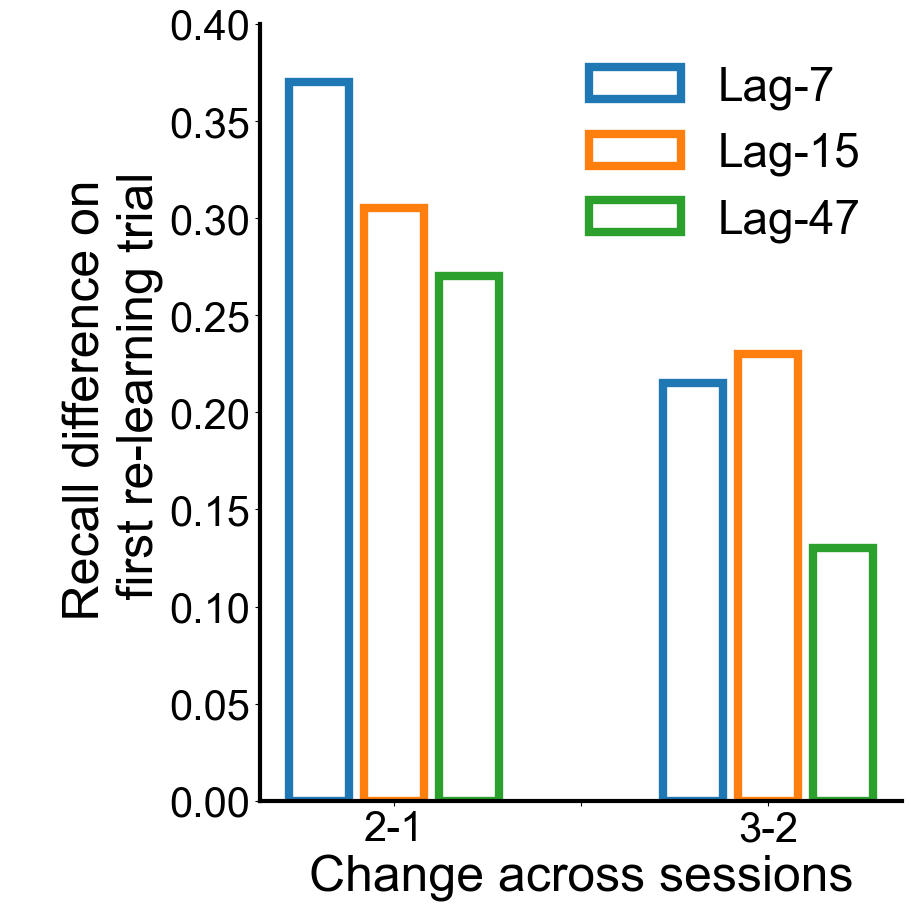

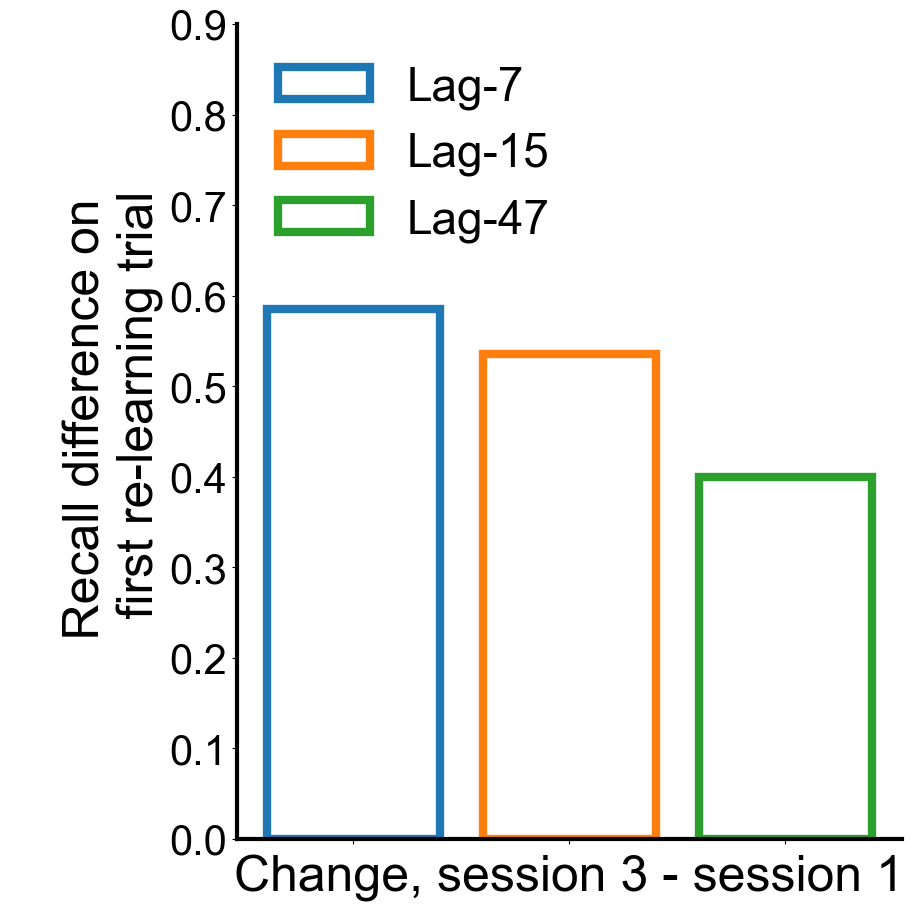

In [93]:
if runnr==3:
    dat7=[0.145,0.515,0.73]
    dat15=[0.215,0.52,0.75]
    dat47=[0.375,0.645,0.775]
    N,width = 3,0.2
    ind = np.arange(N)+1
    cmap = plt.get_cmap("tab10")
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fss,fss))
    plt.bar(ind-width,dat7,width-width*0.2,color='None',edgecolor=cmap(0),linewidth=lw*2,label='Lag-7')
    plt.bar(ind,dat15,width-width*0.2,color='None',edgecolor=cmap(1),linewidth=lw*2,label='Lag-15')
    plt.bar(ind+width,dat47,width-width*0.2,color='None',edgecolor=cmap(2),linewidth=lw*2,label='Lag-47')
    f.tight_layout()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)    
    ax.set_ylim([0,1])
    ax.set_xlabel('''Re-learning session''',fontsize=cfs*4)
    ax.set_ylabel('''
    Recall on first  
    re-learning trial''',fontsize=cfs*3)
    ax.tick_params(axis="x", labelsize=cfs*2.5)
    ax.tick_params(axis="y", labelsize=cfs*2.5)
    ax.legend(ncol=1,loc='upper left',fontsize=cfs*2.75,frameon=False)
    f.tight_layout()
    fn='figs/rawson2018_data-' + str(runnr) + '.pdf'
    f.savefig(fn, transparent=True)
    
    dat7_diff,dat15_diff,dat47_diff=np.diff(dat7),np.diff(dat15),np.diff(dat47)
    N,width = 2,0.2
    ind = np.arange(N)+1
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fss,fss))
    plt.bar(ind-width,dat7_diff,width-width*0.2,color='None',edgecolor=cmap(0),linewidth=lw*2,label='Lag-7')
    plt.bar(ind,dat15_diff,width-width*0.2,color='None',edgecolor=cmap(1),linewidth=lw*2,label='Lag-15')
    plt.bar(ind+width,dat47_diff,width-width*0.2,color='None',edgecolor=cmap(2),linewidth=lw*2,label='Lag-47')
    f.tight_layout()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)    
    ax.set_ylim([0,0.4])
    ax.set_xlabel('''Change across sessions''',fontsize=cfs*3)
    ax.set_xticklabels(['','2-1','','3-2'])
    ax.set_ylabel('''
    Recall difference on  
    first re-learning trial''',fontsize=cfs*3)
    ax.tick_params(axis="x", labelsize=cfs*2.5)
    ax.tick_params(axis="y", labelsize=cfs*2.5)
    ax.legend(ncol=1,loc='upper right',fontsize=cfs*2.75,frameon=False)
    f.tight_layout()
    fn='figs/rawson2018_data-' + str(runnr) + '_diff.pdf'
    f.savefig(fn, transparent=True)
    
    dat7_diff,dat15_diff,dat47_diff=dat7[2]-dat7[0],dat15[2]-dat15[0],dat47[2]-dat47[0]
    N,width = 1,0.2
    ind = np.arange(N)+1
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fss,fss))
    plt.bar(ind-width,dat7_diff,width-width*0.2,color='None',edgecolor=cmap(0),linewidth=lw*2,label='Lag-7')
    plt.bar(ind,dat15_diff,width-width*0.2,color='None',edgecolor=cmap(1),linewidth=lw*2,label='Lag-15')
    plt.bar(ind+width,dat47_diff,width-width*0.2,color='None',edgecolor=cmap(2),linewidth=lw*2,label='Lag-47')
    f.tight_layout()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)    
    ax.set_ylim([0,0.9])
    ax.set_xlabel('''Change, session 3 - session 1''',fontsize=cfs*3)
    ax.set_xticklabels([''])
    ax.set_ylabel('''
    Recall difference on  
    first re-learning trial''',fontsize=cfs*3)
    ax.tick_params(axis="x", labelsize=cfs*2.5)
    ax.tick_params(axis="y", labelsize=cfs*2.5)
    ax.legend(ncol=1,loc='upper left',fontsize=cfs*2.75,frameon=False)
    f.tight_layout()
    fn='figs/rawson2018_data-' + str(runnr) + '_diff_3_1.pdf'
    f.savefig(fn, transparent=True)

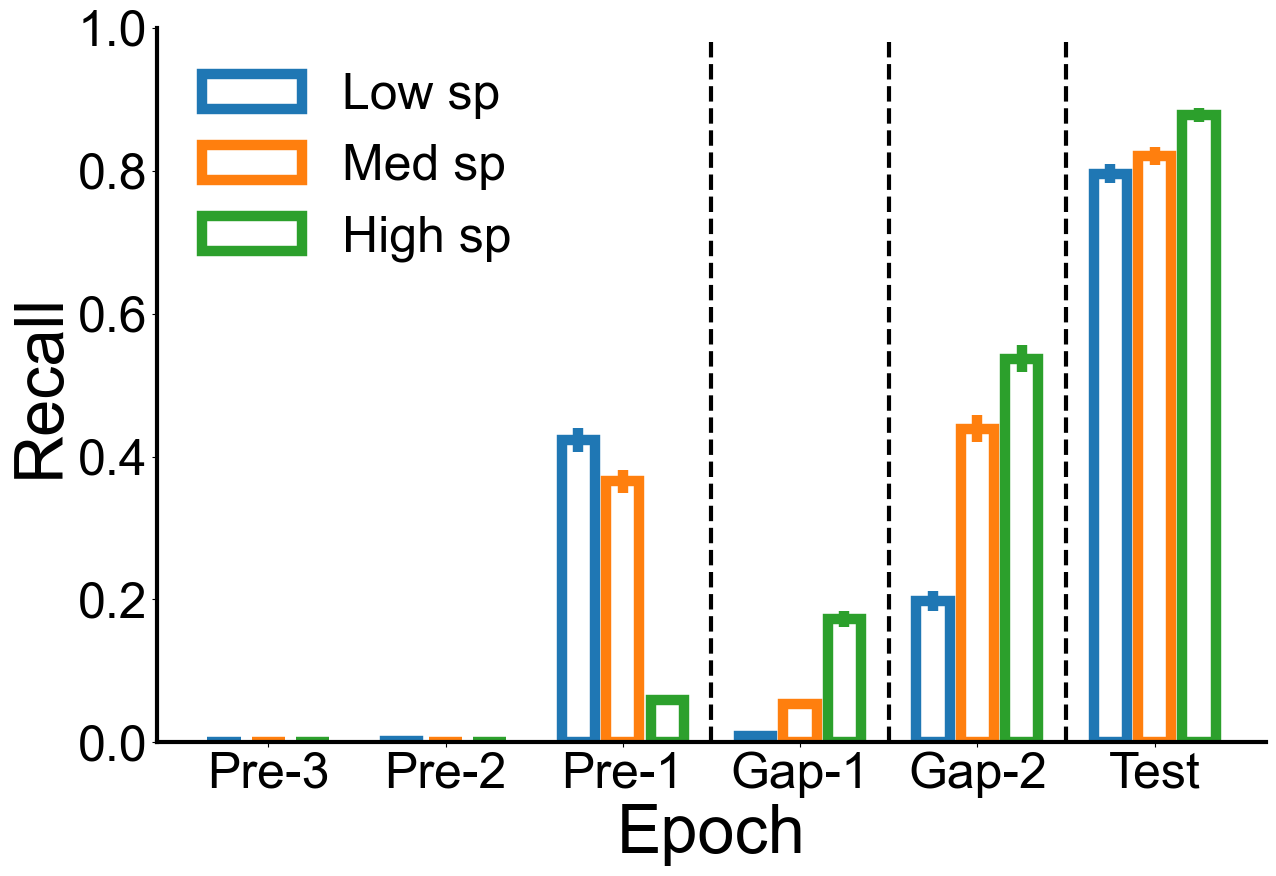

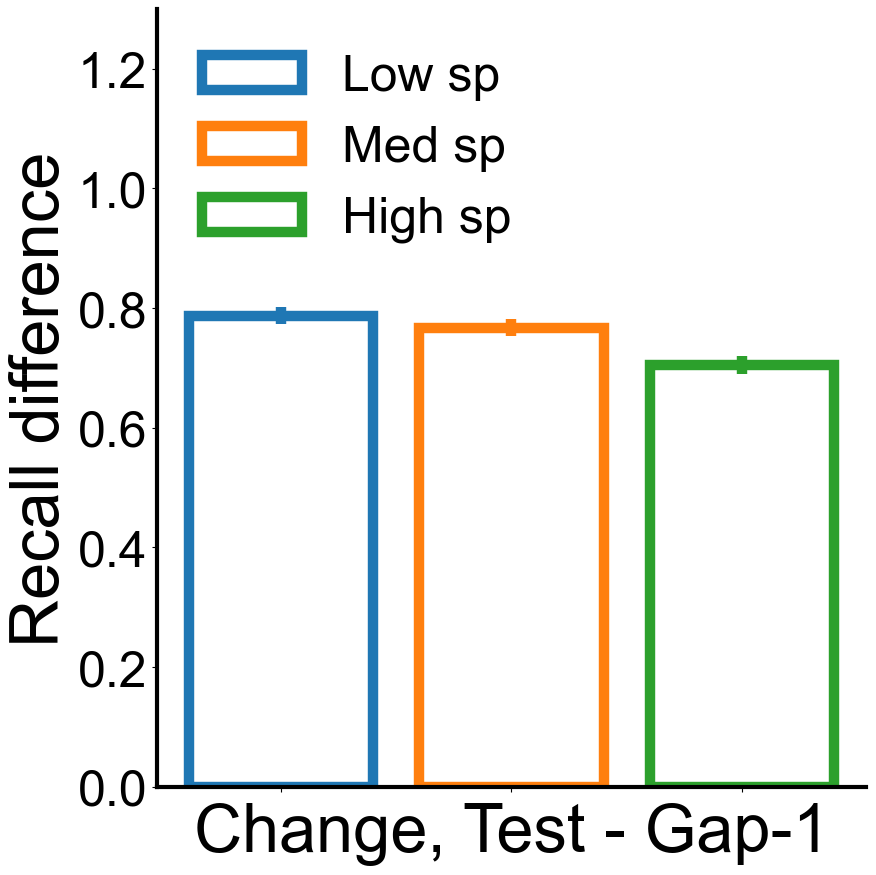

In [95]:
if runnr==3:#our simulations
    nris=9
    maxepcs=5 
    pretrain=6 # #pretrain epochs
    x0=np.arange(maxepcs+1)#2
    plt.rcParams['figure.figsize'] = [fs2,fs2]
    plt.rcParams['axes.linewidth']=lw
    plt.rcParams['lines.linewidth'] = lw
    plt.rcParams.update({'font.size': cfs*4})

    rawsonc=2
    mass=9380
    mass_p=10009
    ri_off=3 #(256)
    fjobs=[mass+ri_off,mass+9+ri_off,mass_p+ri_off]
    mass=10018
    fjobs=[first+ri_off,first+9+ri_off,mass+18+ri_off]
    tlls=['Low sp','Med sp','High sp']
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fss*1.4,fss))
    N,width = 6,0.25
    ind = np.arange(N)+1
    for i in range(len(fjobs)):
        ln=tlls[i]
        fjob=int(fjobs[i])
        pnb=pnbf(base,fjob)
        yrge = np.array([[0,0.1], [0.4,1.2],[0,0.8]]) 
        df0=pd.read_csv(pnb+str(fjob)+"/stcm7_Base_trn_epc.tsv", sep='\t', header=0) #sample, pre-assign
        df0=df0[pretrain:]
        df1=pd.read_csv(pnb+str(fjob)+"/stcm7_Base_run.tsv", sep='\t', header=0) 
        runs_a=np.zeros((nruns,maxepcs+1))#+1
        for ii in range(nruns):
            low,upp=maxepcs*ii,(ii+1)*maxepcs
            runs_a[ii,:maxepcs]=df0['#Mem'][low:upp]
            runs_a[ii,maxepcs]=df1['#AB Mem'][ii]
        datm=np.mean(runs_a,axis=0)
        errs=np.std(runs_a,axis=0)/np.sqrt(nruns)
        plt.errorbar(ind-width+i*width,datm,errs,linestyle='',linewidth=lw*2.5,elinewidth=lw*2.5)
        plt.bar(ind-width+i*width,datm,width-width*0.25,linewidth=lw*2.5,color='None',edgecolor=cmap(i),
                label=ln)
        if i==0:
            runs_a_a=np.zeros((len(fjobs),nruns,maxepcs+1))#+1
        runs_a_a[i,:,:]=runs_a
    
    off1,tlab=3.5,'Big gap'
    plt.vlines([off1,off1+1,off1+2],0,0.98,'k',linestyles='dashed')
    ax.set_ylim([0,1])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel("Recall",fontsize=cfs*4)#
    ax.set_xlabel("Epoch",fontsize=cfs*4)
    ax.tick_params(axis="x", labelsize=cfs*3)
    ax.set_xticklabels(['','Pre-3', 'Pre-2', 'Pre-1', 'Gap-1', 'Gap-2', 'Test'])
    ax.tick_params(axis="y", labelsize=cfs*3)
    ax.legend(ncol=1,loc='upper left',fontsize=cfs*3,frameon=False)
    f.tight_layout()
    f.savefig('figs/Rawson-%s.pdf' %(fjobs[0]), transparent=True)
    
    g1_2,g2_t,g1_t=np.zeros((nruns,1)),np.zeros((nruns,1)),np.zeros((nruns,1))
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fss,fss))
    ddiffs,ddiffs0,ddiffs1=np.zeros((nruns,len(fjobs))),np.zeros((nruns,len(fjobs))),np.zeros((nruns,len(fjobs)))
    
    for i in range(len(fjobs)):
        ln=tlls[i]
        N,width = 1,0.2 #2
        ind = np.arange(N)+1
        g1_2[:,0]=runs_a_a[i,:,-2]-runs_a_a[i,:,-3]
        g2_t[:,0]=runs_a_a[i,:,-1]-runs_a_a[i,:,-2]
        g1_t[:,0]=runs_a_a[i,:,-1]-runs_a_a[i,:,-3]
        ddiff=g1_t+0
        datm=np.mean(ddiff,axis=0)
        ddiffs[:,i]=ddiff[:,0]+0
        ddiffs0[:,i]=runs_a_a[i,:,-4]+0
        ddiffs1[:,i]=runs_a_a[i,:,-3]+0
        errs=np.std(ddiff,axis=0)/np.sqrt(nruns)
        plt.errorbar(ind-width+i*width,datm,errs,ls='none',linewidth=lw*2.5,elinewidth=lw*2.5)
        plt.bar(ind-width+i*width,datm,width-width*0.2,color='None',edgecolor=cmap(i),linewidth=lw*2.5,label=ln)
    ax.set_ylim([0,1.3])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel("Recall difference",fontsize=cfs*4)#
    ax.set_xlabel("Change, Test - Gap-1",fontsize=cfs*4)
    ax.tick_params(axis="x", labelsize=cfs*3)
    ax.tick_params(axis="y", labelsize=cfs*3)
    ax.legend(ncol=1,loc='upper left',fontsize=cfs*3,frameon=False)
    ax.set_xticklabels(['','',''])
    f.tight_layout()
    f.savefig('figs/Rawson_diff_1_3-%s.pdf' %(fjobs[0]), transparent=True)

In [103]:
if runnr==3:
    p=stats.ttest_ind(ddiffs[:,0],ddiffs[:,2])
    print(p)
    p=stats.ttest_ind(ddiffs0[:,0],ddiffs0[:,2])
    print(p)
    p=stats.ttest_ind(ddiffs1[:,0],ddiffs[:,2])
    print(p)
    #### change below
    pre_df=pd.DataFrame(index=np.arange(nruns*3))
    qq=np.hstack([np.zeros(nruns),np.zeros(nruns)+1])
    qq=np.hstack([qq,np.zeros(nruns)+2])
    pre_df['Cond']=qq
    qq=np.hstack([runs_a_a[0,:,-4],runs_a_a[1,:,-4]])
    qq=np.hstack([qq,runs_a_a[2,:,-4]])
    pre_df['Memory']=qq
    fn=rdir+'rawsonpre_Rdata.csv'
    pre_df.to_csv(fn)
    g1_df=pd.DataFrame(index=np.arange(nruns*3))
    qq=np.hstack([np.zeros(nruns),np.zeros(nruns)+1])
    qq=np.hstack([qq,np.zeros(nruns)+2])
    g1_df['Cond']=qq
    qq=np.hstack([runs_a_a[0,:,-3],runs_a_a[1,:,-3]])
    qq=np.hstack([qq,runs_a_a[2,:,-3]])
    g1_df['Memory']=qq
    fn=rdir+'rawsong1_Rdata.csv'
    g1_df.to_csv(fn)
    g2_df=pd.DataFrame(index=np.arange(nruns*3))
    qq=np.hstack([np.zeros(nruns),np.zeros(nruns)+1])
    qq=np.hstack([qq,np.zeros(nruns)+2])
    g2_df['Cond']=qq
    qq=np.hstack([runs_a_a[0,:,-2],runs_a_a[1,:,-2]])
    qq=np.hstack([qq,runs_a_a[2,:,-2]])
    g2_df['Memory']=qq
    fn=rdir+'rawsong2_Rdata.csv'
    g2_df.to_csv(fn)
    ddiff_df=pd.DataFrame(index=np.arange(nruns*3))
    qq=np.hstack([np.zeros(nruns),np.zeros(nruns)+1])
    qq=np.hstack([qq,np.zeros(nruns)+2])
    ddiff_df['Cond']=qq
    qq=np.hstack([ddiffs[:,0],ddiffs[:,1]])
    qq=np.hstack([qq,ddiffs[:,2]])
    ddiff_df['Memory']=qq
    fn=rdir+'rawsonddiff_Rdata.csv'
    ddiff_df.to_csv(fn)

Ttest_indResult(statistic=4.009919414939328, pvalue=8.60205008755678e-05)
Ttest_indResult(statistic=20.039526944026132, pvalue=1.5915850507470608e-49)
Ttest_indResult(statistic=-45.80473029155741, pvalue=2.5392262503170927e-107)


## Alternative schedules: Kupper-Tutzel 2014, Appendix data + simulations (Fig 5)

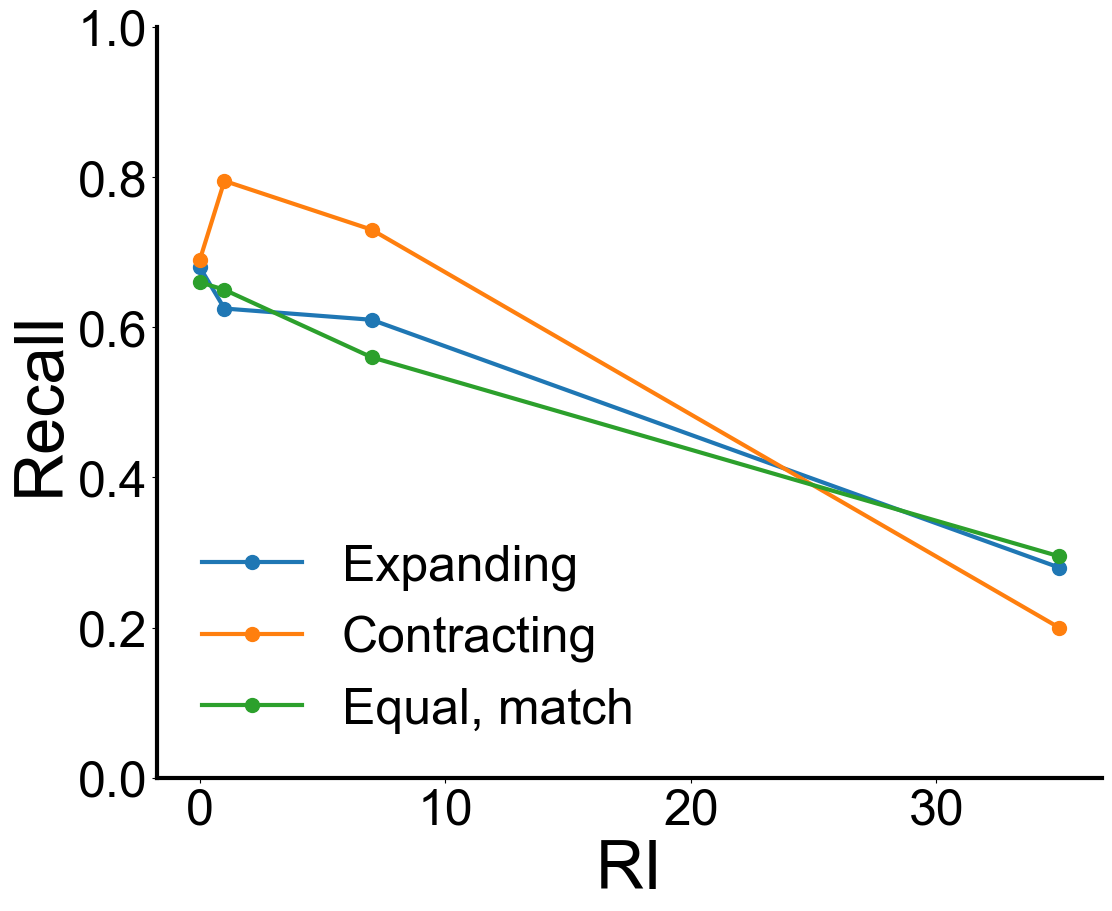

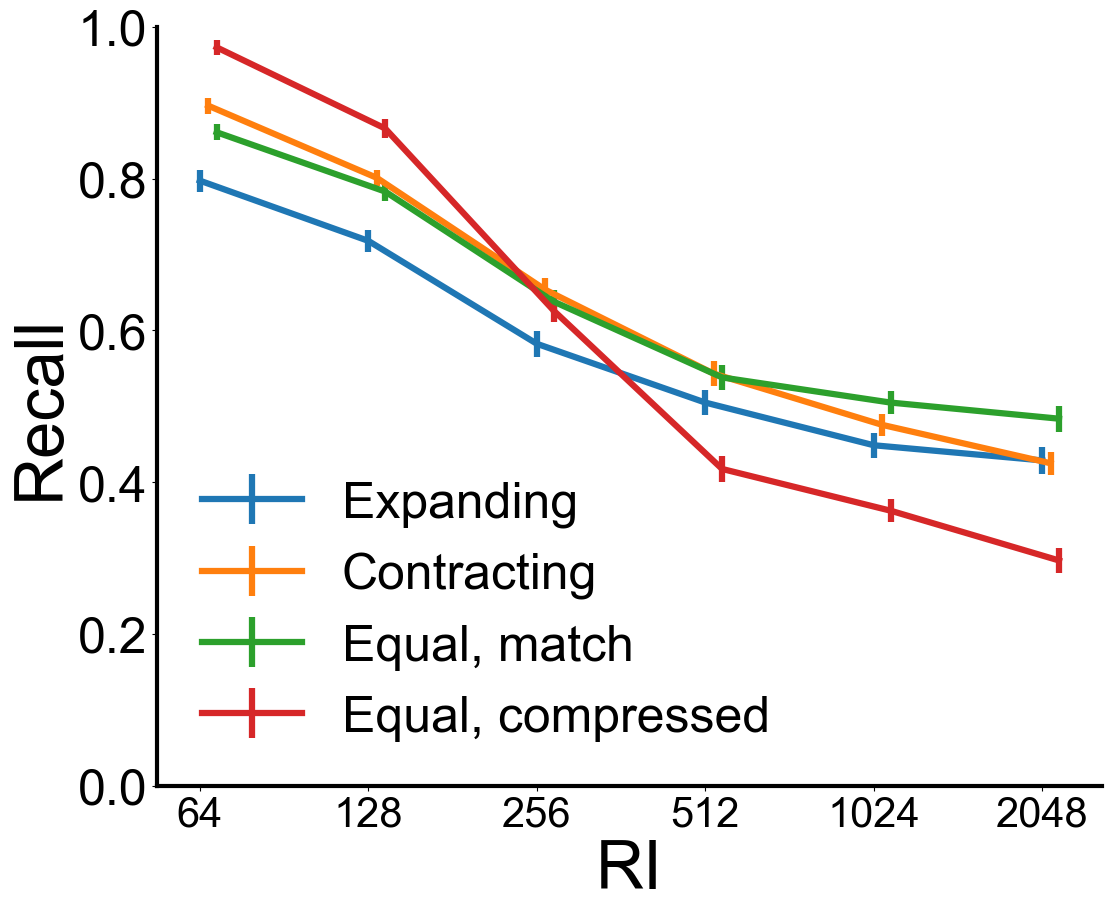

In [178]:
if runnr==2:
    contr,equal,expan=[0.69,0.795,0.73,0.20],[0.66,0.65,0.56,0.295],[0.68,0.625,0.61,0.28] #free recall
    #cued recall: contr=[0.96,0.98,0.97,0.59],equal=[0.94,0.945,0.91,0.715],expan=[0.97,0.95,0.92,0.645]
    ISIs=np.zeros((4,1))
    ISIs[0],ISIs[1],ISIs[2],ISIs[3]=0,1,7,35 
    ISIs_ind=[3,6,9]
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fss*1.2,fss))
    plt.plot(ISIs,expan,marker='o', linestyle='-',ms=msz,label='Expanding')
    plt.plot(ISIs,contr,marker='o', linestyle='-',ms=msz,label='Contracting')
    plt.plot(ISIs,equal,marker='o', linestyle='-',ms=msz,label='Equal, match')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)    
    ax.set_xlabel('RI',fontsize=cfs*4)
    ax.set_ylabel('Recall',fontsize=cfs*4)
    ax.set_ylim([0,1])
    plt.legend(loc='lower left', ncol=1,frameon=False,fontsize=cfs*3)
    f.tight_layout()
    fn='figs/kuppertutzel_data-' + str(runnr) + '.pdf'
    f.savefig(fn, transparent=True)

    #our simulations
    start_off=2 #was 1
    ncut,lwm,rin=start_off+1,1.5,len(lls)
    x0=np.arange(rin-ncut)
    ells_a2=['Expanding','Contracting','Equal, match','Equal, compressed']
    RIs_l=['','64','128','256','512','1024','2048']#
    exp_m,con_m,equ_m,equc_m=np.zeros((rin-ncut)),np.zeros((rin-ncut)),np.zeros((rin-ncut)),np.zeros((rin-ncut))
    exp_s,con_s,equ_s,equc_s=np.zeros((rin-ncut)),np.zeros((rin-ncut)),np.zeros((rin-ncut)),np.zeros((rin-ncut))
    ddiffs0,ddiffs1,ddiffs2=np.zeros((nruns,len(ells_a2))),np.zeros((nruns,len(ells_a2))),np.zeros((nruns,len(ells_a2)))
    for i in range(len(ells_a2)): #ISIs
        for ii in range(start_off,rin-1): #RIs
            qq=np.logical_and(df1['Exp']==ells_a2[i],df1['Cond']==lls[ii])
            if i==0:
                exp_m[ii-start_off]=np.mean(df1['Memory'][qq])
                exp_s[ii-start_off]=np.std(df1['Memory'][qq])/np.sqrt(nruns)
            elif i==1:
                con_m[ii-start_off]=np.mean(df1['Memory'][qq])
                con_s[ii-start_off]=np.std(df1['Memory'][qq])/np.sqrt(nruns)
            elif i==2:
                equ_m[ii-start_off]=np.mean(df1['Memory'][qq])
                equ_s[ii-start_off]=np.std(df1['Memory'][qq])/np.sqrt(nruns)
            elif i==3:
                equc_m[ii-start_off]=np.mean(df1['Memory'][qq])
                equc_s[ii-start_off]=np.std(df1['Memory'][qq])/np.sqrt(nruns)
            if ii==start_off: #initial RI contrast
                ddiffs0[:,i]=df1['Memory'][qq]
            elif ii==start_off+1: #later RI contrast
                ddiffs1[:,i]=df1['Memory'][qq]
            elif ii==rin-2: #later RI contrast
                ddiffs2[:,i]=df1['Memory'][qq]
                
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fss*1.2,fss))
    plt.errorbar(x0,exp_m,exp_s,linestyle='-',linewidth=lw*lwm,
                 elinewidth=lw*lwm,label='Expanding')
    plt.errorbar(x0+0.05,con_m,con_s,linestyle='-',linewidth=lw*lwm,
                 elinewidth=lw*lwm,label='Contracting')
    plt.errorbar(x0+0.1,equ_m,equ_s,linestyle='-',linewidth=lw*lwm,
                 elinewidth=lw*lwm,label='Equal, match')
    plt.errorbar(x0+0.1,equc_m,equ_s,linestyle='-',linewidth=lw*lwm,
                 elinewidth=lw*lwm,label='Equal, compressed')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)    
    ax.set_xlabel('RI',fontsize=cfs*4)
    ax.set_ylabel('Recall',fontsize=cfs*4)
    ax.tick_params(axis="x", labelsize=cfs*2.5)
    ax.set_xticklabels(RIs_l)
    ax.set_ylim([0,1])
    plt.legend(loc='lower left', ncol=1,frameon=False,fontsize=cfs*3)
    f.tight_layout()
    fn='figs/kuppertutzel_model-' + str(runnr) + '.pdf'
    f.savefig(fn, transparent=True)

In [181]:
if runnr==2:
    ddiffs2_1=ddiffs2-ddiffs1
    #earliest RI
    print('1st RI')
    p=stats.ttest_ind(ddiffs0[:,0],ddiffs0[:,1])
    print(p)
    p=stats.ttest_ind(ddiffs0[:,0],ddiffs0[:,2])
    print(p)
    p=stats.ttest_ind(ddiffs0[:,0],ddiffs0[:,3])
    print(p)
    p=stats.ttest_ind(ddiffs0[:,1],ddiffs0[:,2])
    print(p)
    p=stats.ttest_ind(ddiffs0[:,1],ddiffs0[:,3])
    print(p)
    p=stats.ttest_ind(ddiffs0[:,2],ddiffs0[:,3])
    print(p)
    print('\n2nd RI')
    #later RI
    p=stats.ttest_ind(ddiffs1[:,0],ddiffs1[:,1])
    print(p)
    p=stats.ttest_ind(ddiffs1[:,0],ddiffs1[:,2])
    print(p)
    p=stats.ttest_ind(ddiffs1[:,0],ddiffs1[:,3])
    print(p)
    p=stats.ttest_ind(ddiffs1[:,1],ddiffs1[:,2])
    print(p)
    p=stats.ttest_ind(ddiffs1[:,1],ddiffs1[:,3])
    print(p)
    p=stats.ttest_ind(ddiffs1[:,2],ddiffs1[:,3])
    print(p)
    print(p)
    print('\nlast RI')
    #last RI
    p=stats.ttest_ind(ddiffs2[:,0],ddiffs2[:,1])
    print(p)
    p=stats.ttest_ind(ddiffs2[:,0],ddiffs2[:,2])
    print(p)
    p=stats.ttest_ind(ddiffs2[:,0],ddiffs2[:,3])
    print(p)
    p=stats.ttest_ind(ddiffs2[:,1],ddiffs2[:,2])
    print(p)
    p=stats.ttest_ind(ddiffs2[:,1],ddiffs2[:,3])
    print(p)
    p=stats.ttest_ind(ddiffs2[:,2],ddiffs2[:,3])
    print(p)
    print('\ndiff of diffs')
    #diff of diffs
    p=stats.ttest_ind(ddiffs2_1[:,0],ddiffs2_1[:,1])
    print(p)
    p=stats.ttest_ind(ddiffs2_1[:,0],ddiffs2_1[:,2])
    print(p)
    p=stats.ttest_ind(ddiffs2_1[:,0],ddiffs2_1[:,3])
    print(p)
    p=stats.ttest_ind(ddiffs2_1[:,1],ddiffs2_1[:,2])
    print(p)
    p=stats.ttest_ind(ddiffs2_1[:,1],ddiffs2_1[:,3])
    print(p)
    p=stats.ttest_ind(ddiffs2_1[:,2],ddiffs2_1[:,3])
    print(p)
    print('\n')

1st RI
Ttest_indResult(statistic=-5.52823292310613, pvalue=1.0126564618385765e-07)
Ttest_indResult(statistic=-3.5805674176188202, pvalue=0.00043133307906099993)
Ttest_indResult(statistic=-11.621934278401781, pvalue=3.844512493620022e-24)
Ttest_indResult(statistic=2.363874989842441, pvalue=0.019053026839660585)
Ttest_indResult(statistic=-6.727311165386881, pvalue=1.8140558559628224e-10)
Ttest_indResult(statistic=-9.869195480729587, pvalue=6.148111304522217e-19)

2nd RI
Ttest_indResult(statistic=-4.661965777939148, pvalue=5.748363123713812e-06)
Ttest_indResult(statistic=-3.4571734436772705, pvalue=0.0006680575584960103)
Ttest_indResult(statistic=-7.821262016666408, pvalue=3.050842915656526e-13)
Ttest_indResult(statistic=1.1067933592193586, pvalue=0.2697261247901277)
Ttest_indResult(statistic=-3.931397861511412, pvalue=0.00011671648308790201)
Ttest_indResult(statistic=-4.729358368390492, pvalue=4.273051012215566e-06)
Ttest_indResult(statistic=-4.729358368390492, pvalue=4.273051012215566e-

## Bahrick et al. (1993) data + simulations (Fig 6)

(11, 9)
(11, 9)
(3, 1)
[[0.99    ]
 [0.964375]
 [0.818125]]
[[0.27    ]
 [0.501875]
 [0.586875]]
[[0.2525 ]
 [0.5475 ]
 [0.54875]]


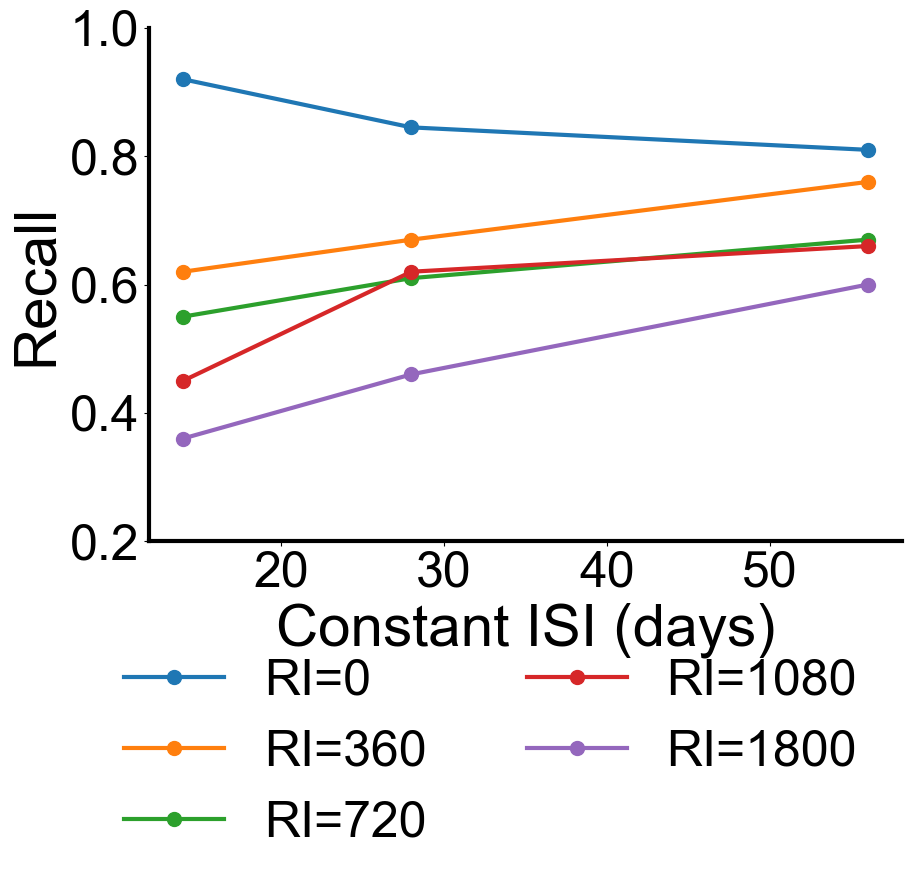

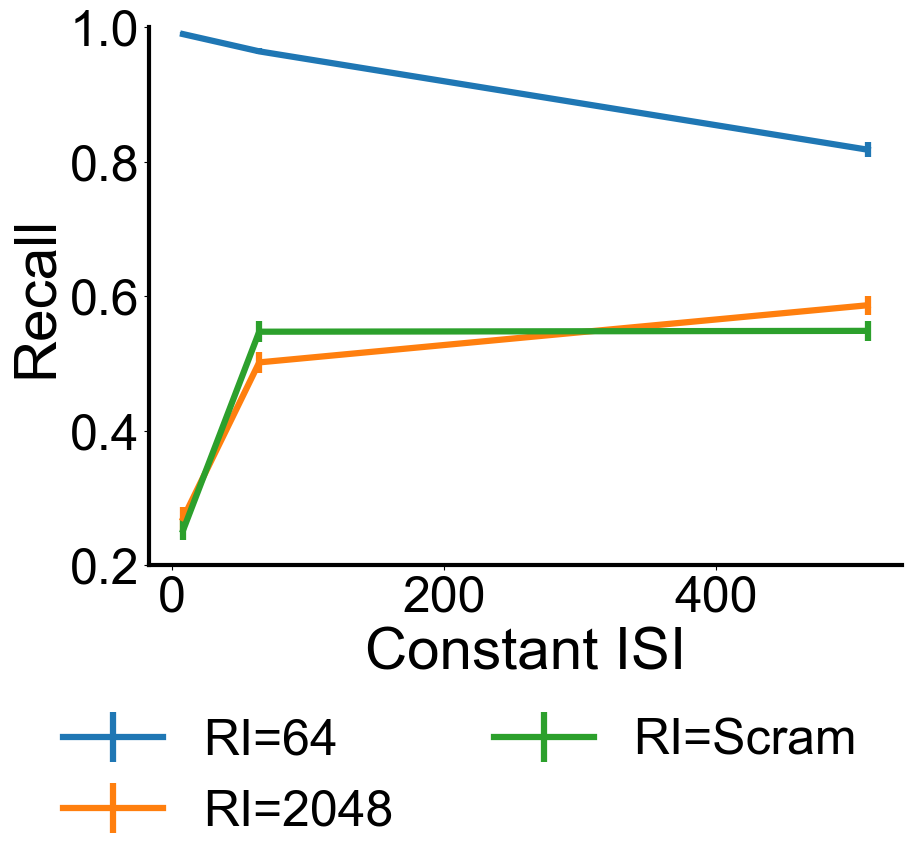

In [17]:
#from Cepeda et al., 2006, Table 7, + recall @ end of training from Fig 3, top, 0 yr
if runnr==1:
    ISIs=[14,28,56]
    dat0=[0.92,0.845,0.81] 
    dat360=[0.62,0.67,0.76] 
    dat720=[0.55,0.61,0.67]
    dat1080=[0.45,0.62,0.66]
    dat1800=[0.36,0.46,0.60]
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fss,fss))
    plt.plot(ISIs,dat0,marker='o', linestyle='-',ms=msz,label='RI=0')
    plt.plot(ISIs,dat360,marker='o', linestyle='-',ms=msz,label='RI=360')
    plt.plot(ISIs,dat720,marker='o', linestyle='-',ms=msz,label='RI=720')
    plt.plot(ISIs,dat1080,marker='o', linestyle='-',ms=msz,label='RI=1080')
    plt.plot(ISIs,dat1800,marker='o', linestyle='-',ms=msz,label='RI=1800')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)    
    ax.set_xlabel('Constant ISI (days)',fontsize=cfs*3.5)
    ax.set_ylabel('Recall',fontsize=cfs*3.5)
    ax.set_ylim([0.2,1])
    plt.legend(bbox_to_anchor=(1,-0.14), loc='upper right', ncol=2,frameon=False)
    f.tight_layout()
    fn='figs/bahrick_data-' + str(runnr) + '.pdf'
    f.savefig(fn, transparent=True)
    
    exp_m,exp_s=np.zeros((len(ells_a),len(lls))),np.zeros((len(ells_a),len(lls)))
    for i in range(len(ells_a)): #ISIs
        for ii in range(len(lls)): #RIs
            qq=np.logical_and(df1['Exp']==ells_a[i],df1['Cond']==lls[ii])
            exp_m[i,ii]=np.mean(df1['Memory'][qq])
            exp_s[i,ii]=np.std(df1['Memory'][qq])/np.sqrt(nruns)
    print(exp_m.shape)
    print(exp_s.shape)
    #grab RI=1,RIscram
    ISIs=np.zeros((3,1))
    ISIs[0],ISIs[1],ISIs[2]=8,64,512 #2^3,2^6,2^9
    ISIs_ind=[3,6,9]
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fss,fss))
    print(ISIs.shape)
    print(exp_m[[ISIs_ind],2].T)
    print(exp_m[[ISIs_ind],7].T)
    print(exp_m[[ISIs_ind],8].T)
    #plt.errorbar(ISIs,exp_m[[ISIs_ind],2].T,np.squeeze(exp_s[[ISIs_ind],2].T),linestyle='-',linewidth=lw*lwm,
    #             elinewidth=lw*lwm,label='RI=64')
    #plt.errorbar(ISIs,exp_m[[ISIs_ind],7].T,np.squeeze(exp_s[[ISIs_ind],6].T),linestyle='-',linewidth=lw*lwm,
    #             elinewidth=lw*lwm,label='RI=2048')
    #plt.errorbar(ISIs,exp_m[[ISIs_ind],8].T,np.squeeze(exp_s[[ISIs_ind],8].T),linestyle='-',linewidth=lw*lwm,
    #             elinewidth=lw*lwm,label='RI=Scram')
    plt.errorbar(ISIs,np.squeeze(exp_m[[ISIs_ind],2].T),np.squeeze(exp_s[[ISIs_ind],2].T),linestyle='-',linewidth=lw*lwm,
                 elinewidth=lw*lwm,label='RI=64')
    plt.errorbar(ISIs,np.squeeze(exp_m[[ISIs_ind],7].T),np.squeeze(exp_s[[ISIs_ind],6].T),linestyle='-',linewidth=lw*lwm,
                 elinewidth=lw*lwm,label='RI=2048')
    plt.errorbar(ISIs,np.squeeze(exp_m[[ISIs_ind],8].T),np.squeeze(exp_s[[ISIs_ind],8].T),linestyle='-',linewidth=lw*lwm,
                 elinewidth=lw*lwm,label='RI=Scram')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)    
    ax.set_xlabel('Constant ISI',fontsize=cfs*3.5)
    ax.set_ylabel('Recall',fontsize=cfs*3.5)
    ax.set_ylim([0.2,1])
    plt.legend(bbox_to_anchor=(1,-0.2), loc='upper right', ncol=2,frameon=False,fontsize=cfs*3)
    f.tight_layout()
    fn='figs/bahrick_model-' + str(runnr) + '.pdf'
    f.savefig(fn, transparent=True)

# 2 - CA3 errors analysis - Fig 7C + 7B

In [74]:
def layp(x0,dat,nruns,midpt,t,cond,ind,cn,yrge):
    plt.errorbar(x0,np.mean(dat,axis=0),np.std(dat,axis=0)/np.sqrt(nruns))
    plt.xlabel('Training epoch')
    plt.ylabel('%s error, %s' %(cn,t))
    plt.ylim(yrge[0],yrge[1])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

def layp2(x0,dat,fjob,allsp,nruns,yrge,ln,tm,totn):
    cmapz = plt.get_cmap("viridis")
    cmn=11+fjob*22
    if totn==4:
        cmn=27+fjob*55
    if allsp==0:
        cmapz = plt.get_cmap("tab10")
        cmn=fjob+0
    plt.plot(x0,np.mean(dat,axis=0),label=ln,linewidth=lw*2,color=cmapz(cmn))
    plt.errorbar(x0,np.mean(dat,axis=0),np.std(dat,axis=0)/np.sqrt(nruns),elinewidth=lw*2,color=cmapz(cmn))
    plt.xlabel('Training epoch',fontsize=cfs*7)
    plt.ylabel('%s error' %lays[tlay],fontsize=cfs*7)
    if allsp==0:
        plt.xlabel('Training epoch',fontsize=cfs*5)
        plt.ylabel('%s error' %lays[tlay],fontsize=cfs*5)
    plt.ylim(yrge[0],yrge[1])
    ax.tick_params(labelsize=cfs*tm)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

[0.904268 0.771942 0.755985 0.720167 0.694863]
[0.911846 0.894408 0.943557 0.919092 0.891016]
[0.914923 0.961593 0.978185 0.93623  0.902806]
[0.909195 1.03332  1.010955 0.96539  0.932434]
[0.903435 1.07454  1.03483  0.997728 0.964116]
[0.912102 1.08485  1.05447  1.021394 0.993387]
[0.910471 1.089    1.05948  1.03724  1.016039]
[0.910203 1.08389  1.060167 1.04617  1.03493 ]
[0.909802 1.08278  1.06137  1.05069  1.04737 ]
[0.904863 1.080979 1.055778 1.051664 1.05094 ]
[0.914354 1.07879  1.059269 1.05278  1.05104 ]


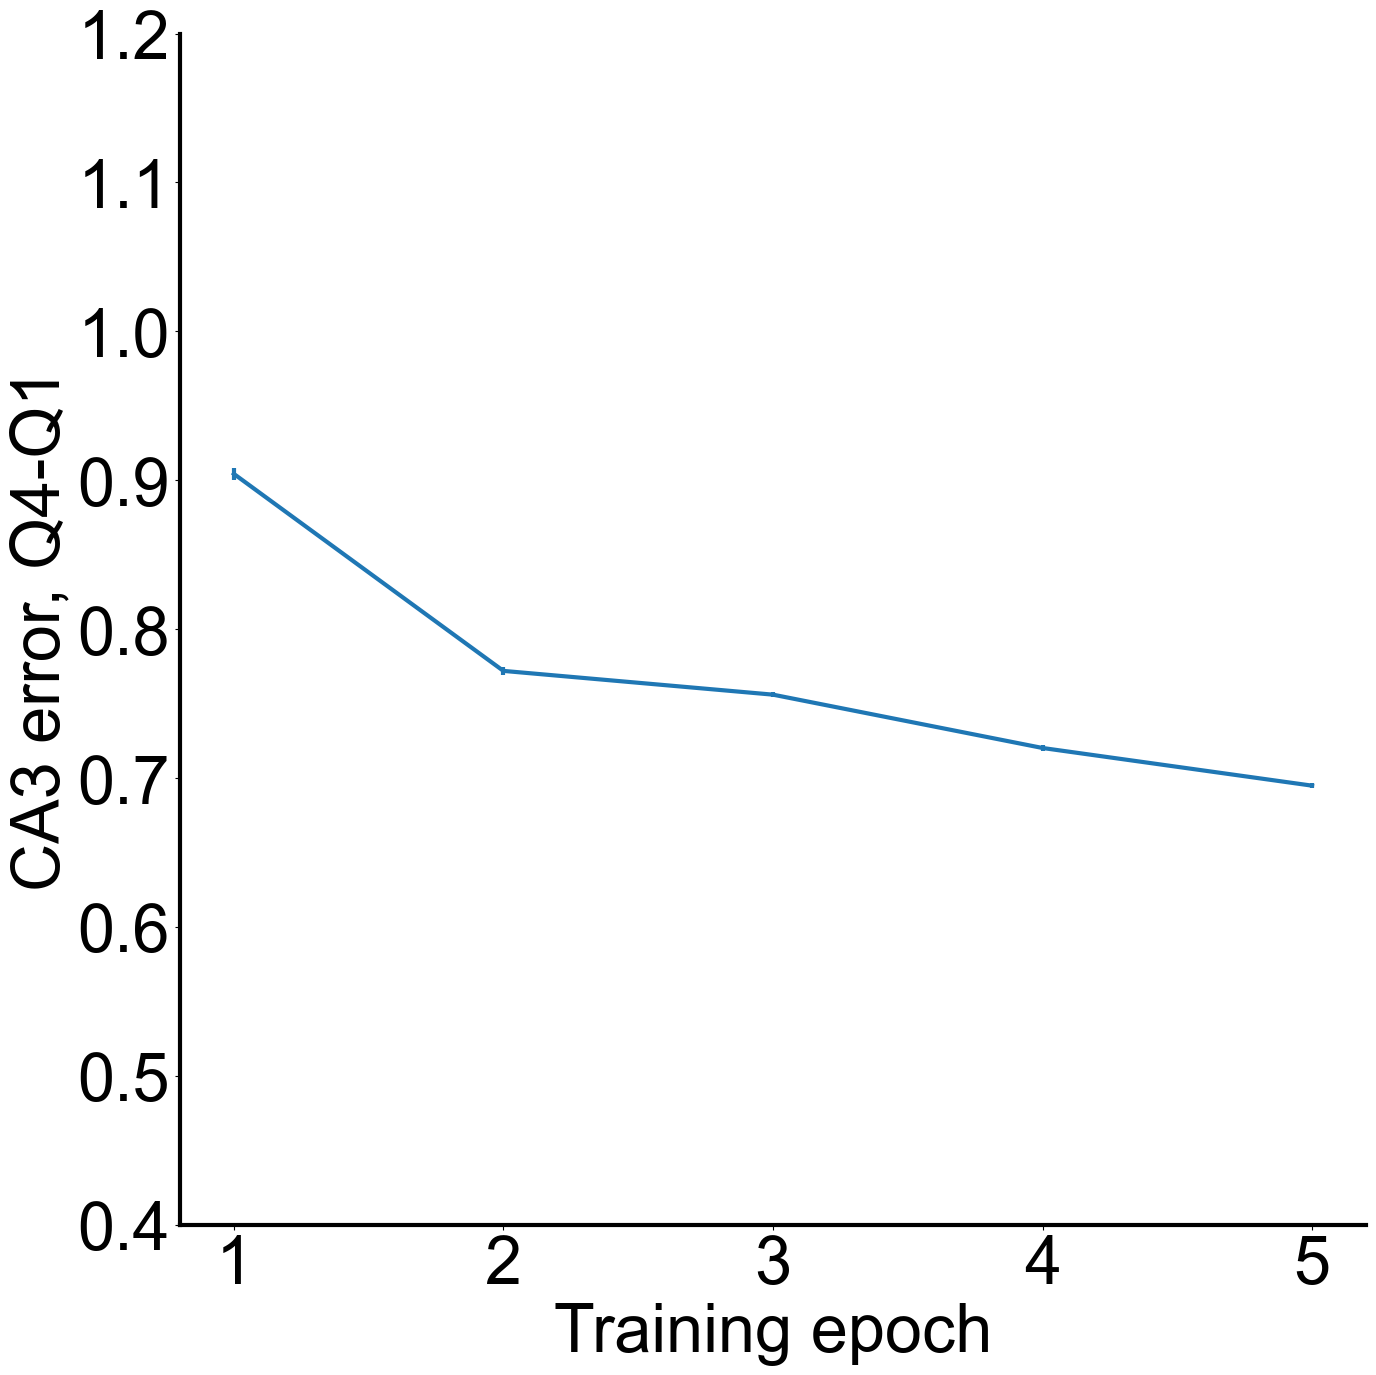

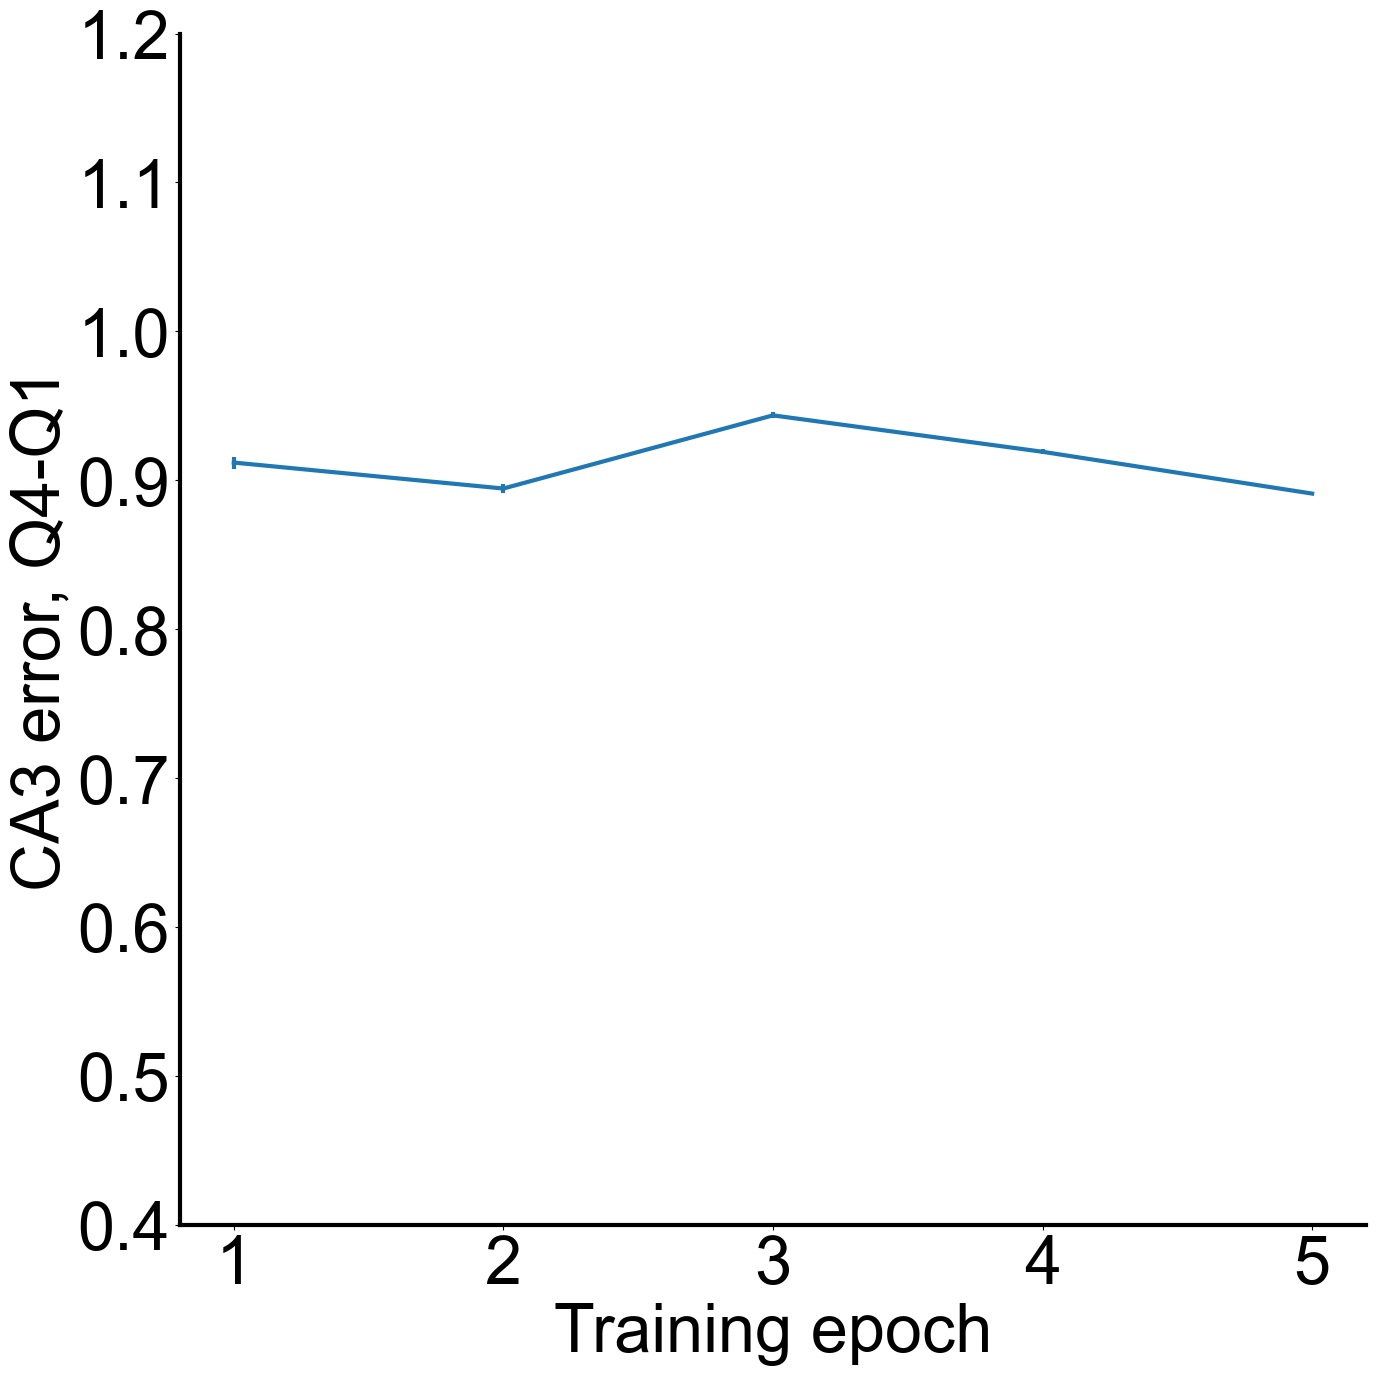

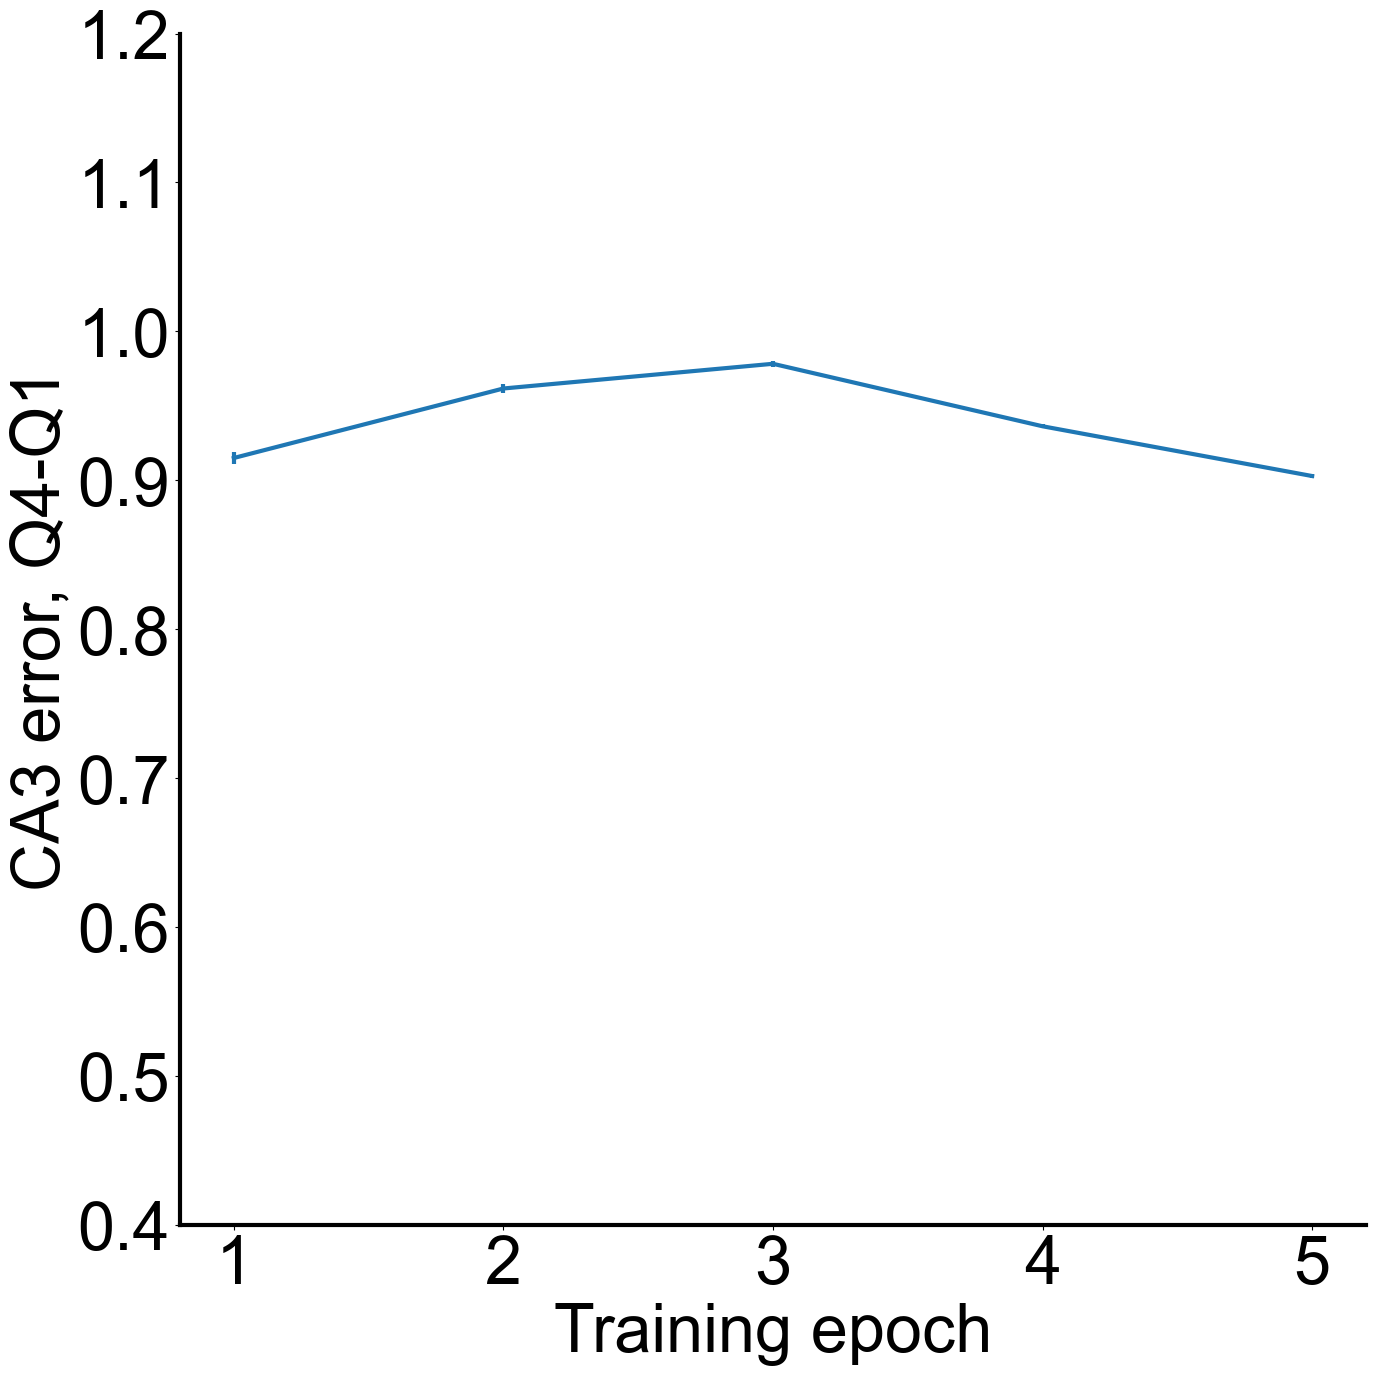

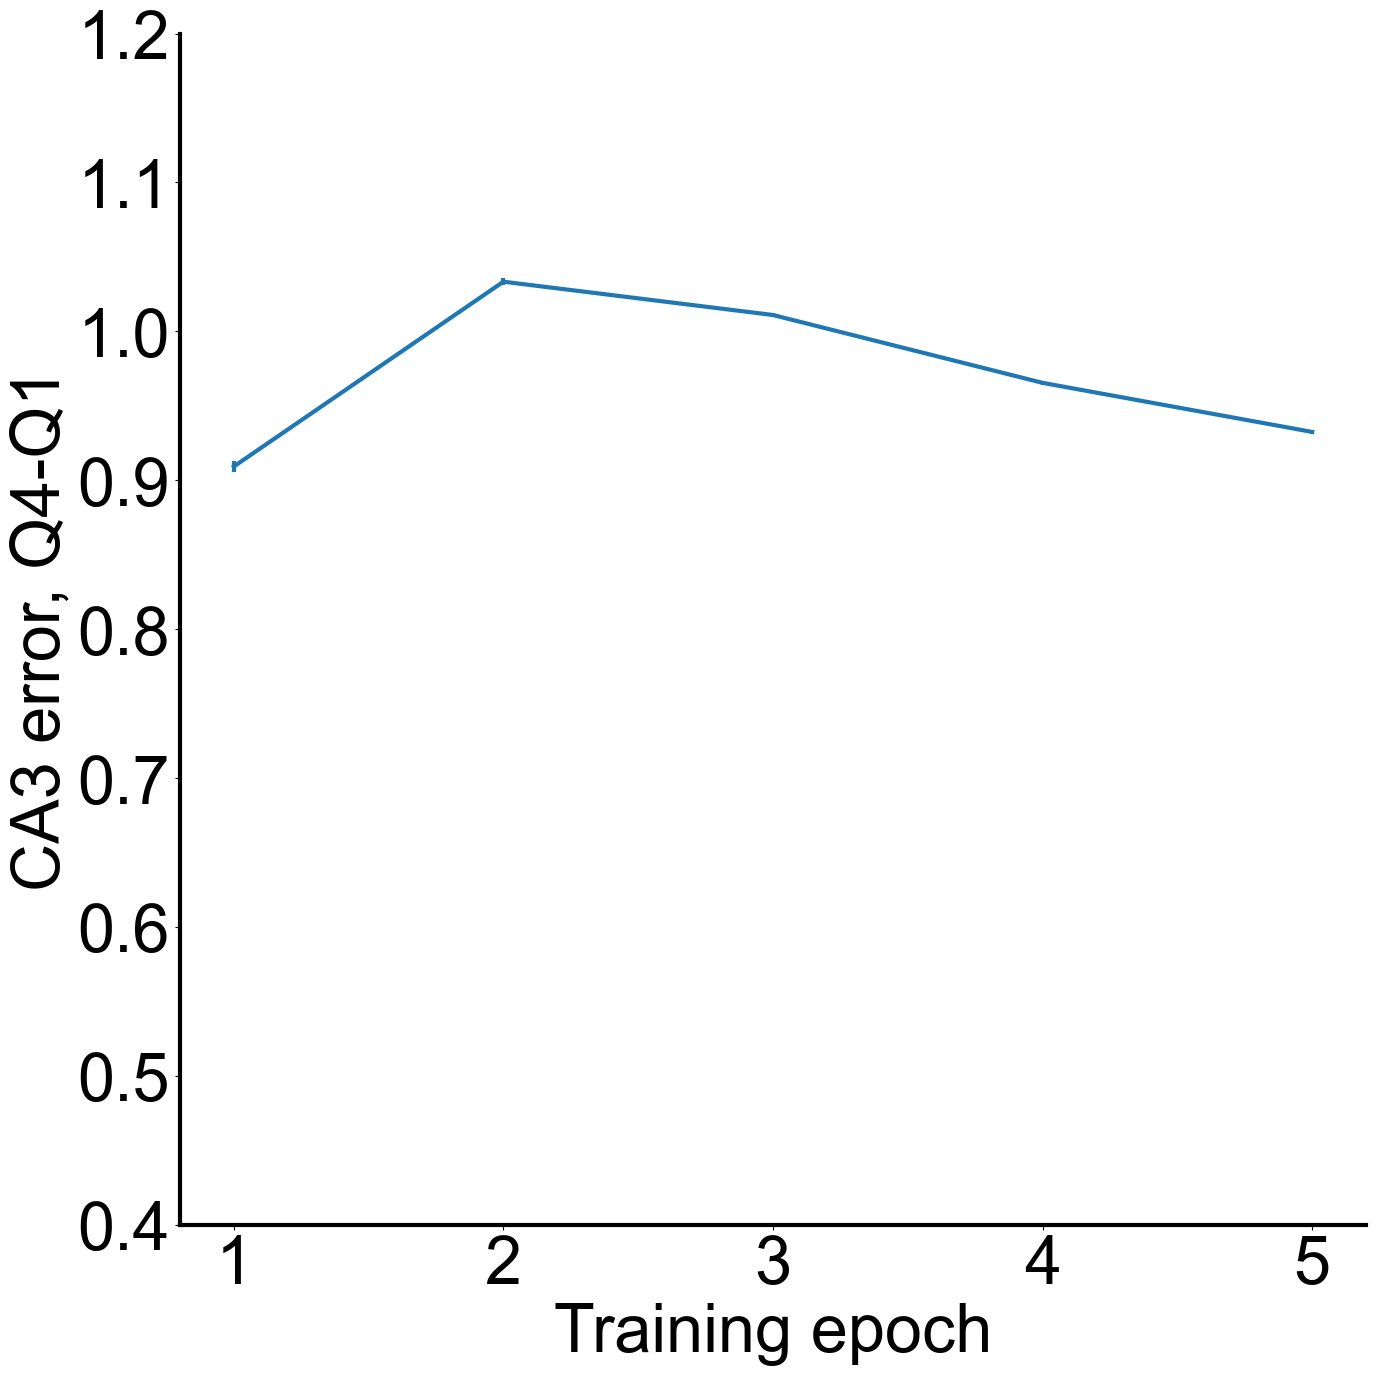

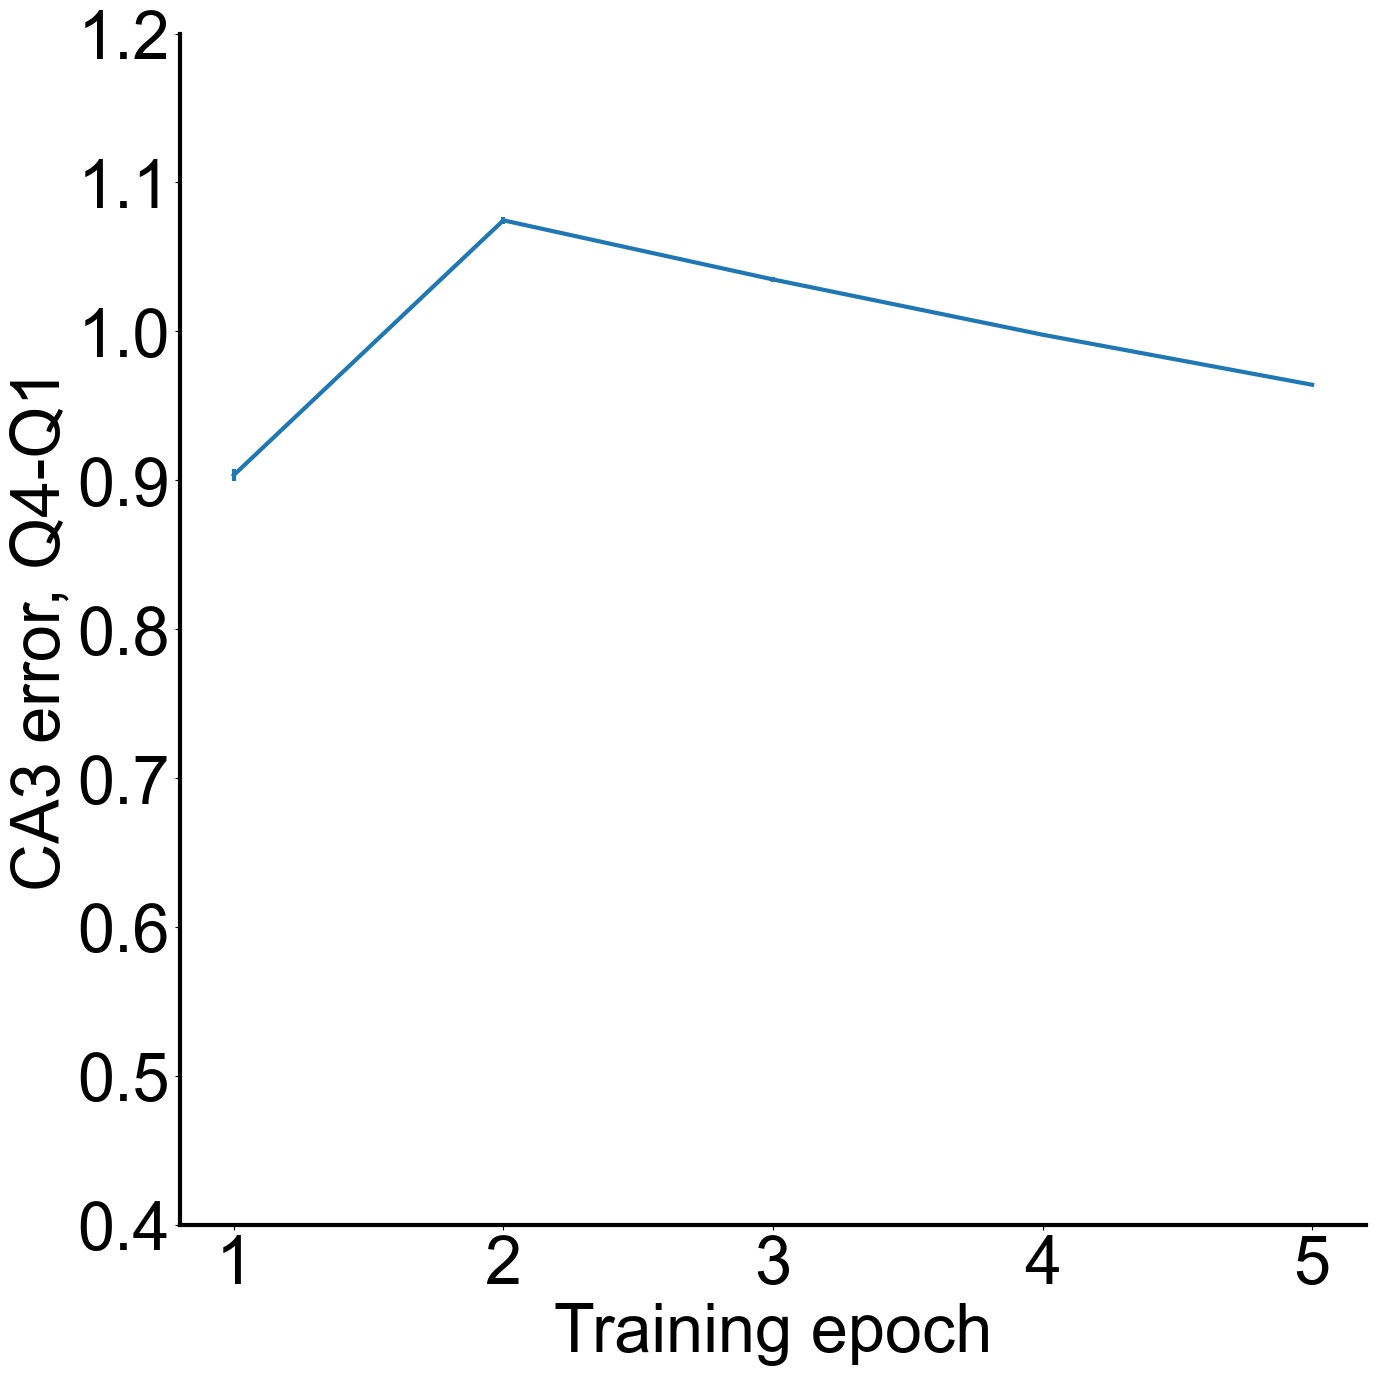

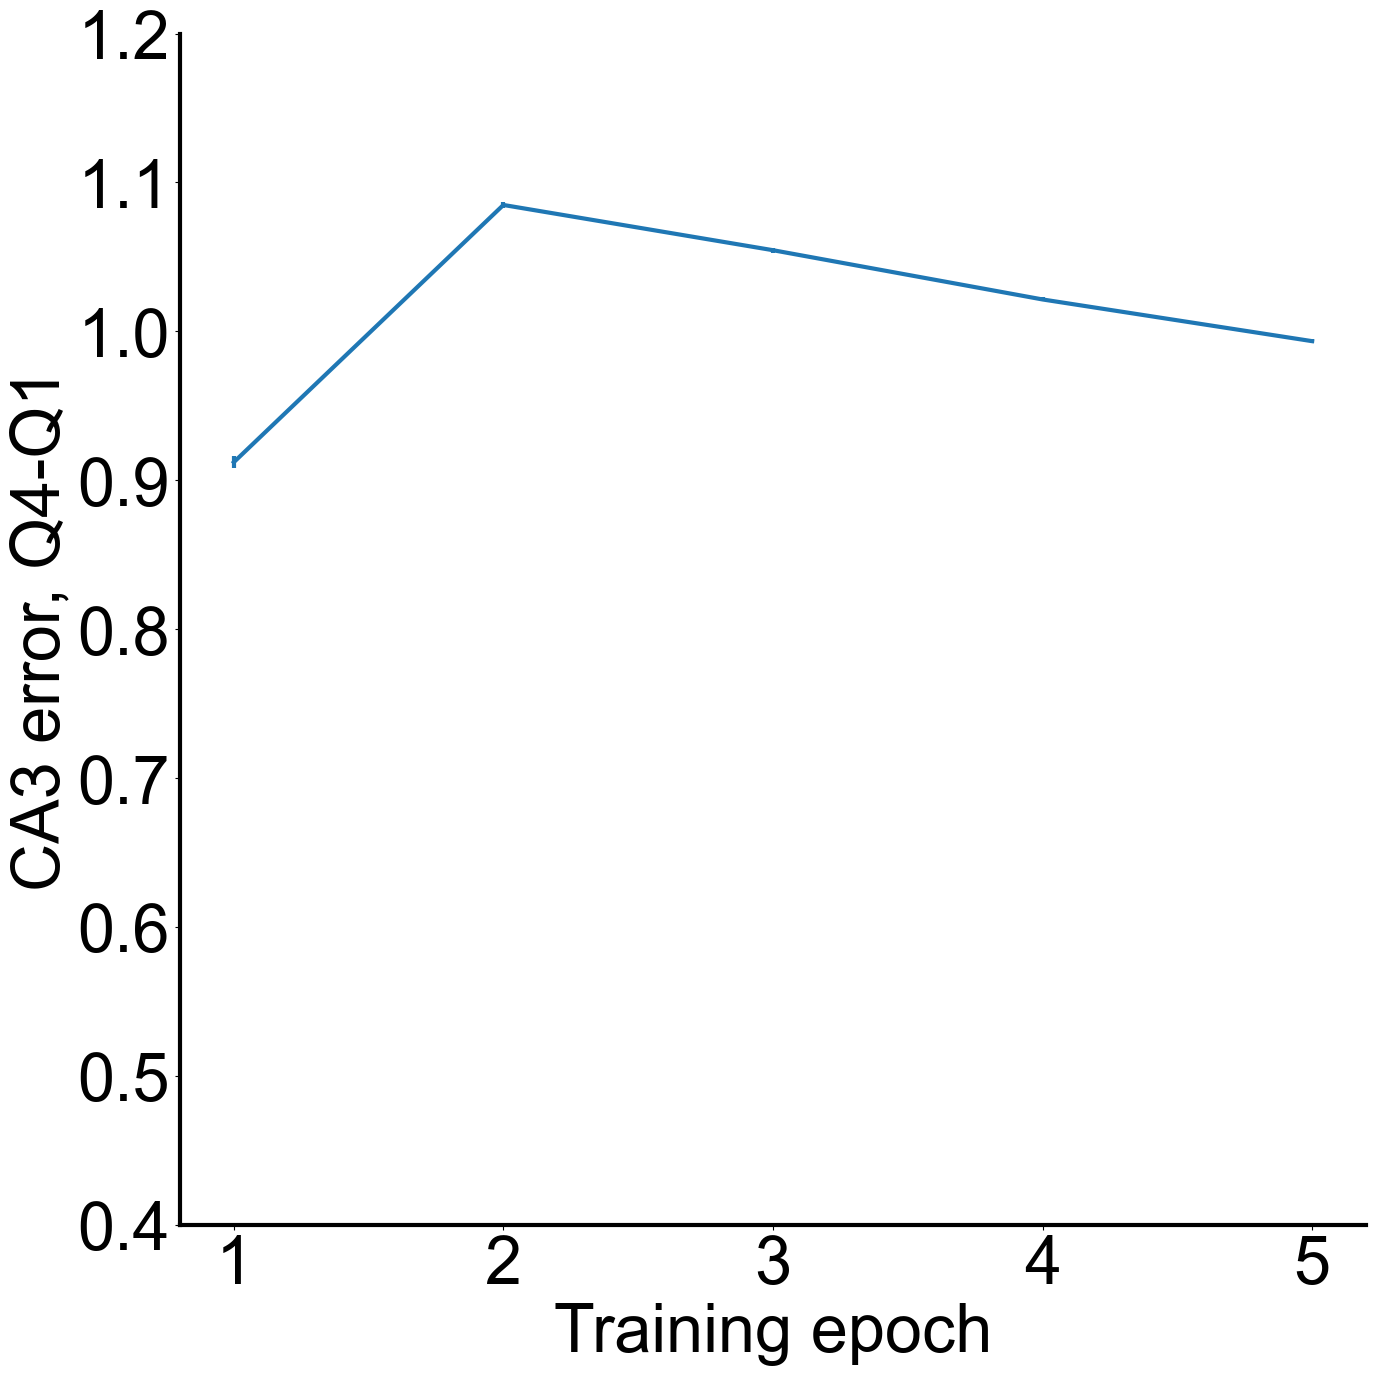

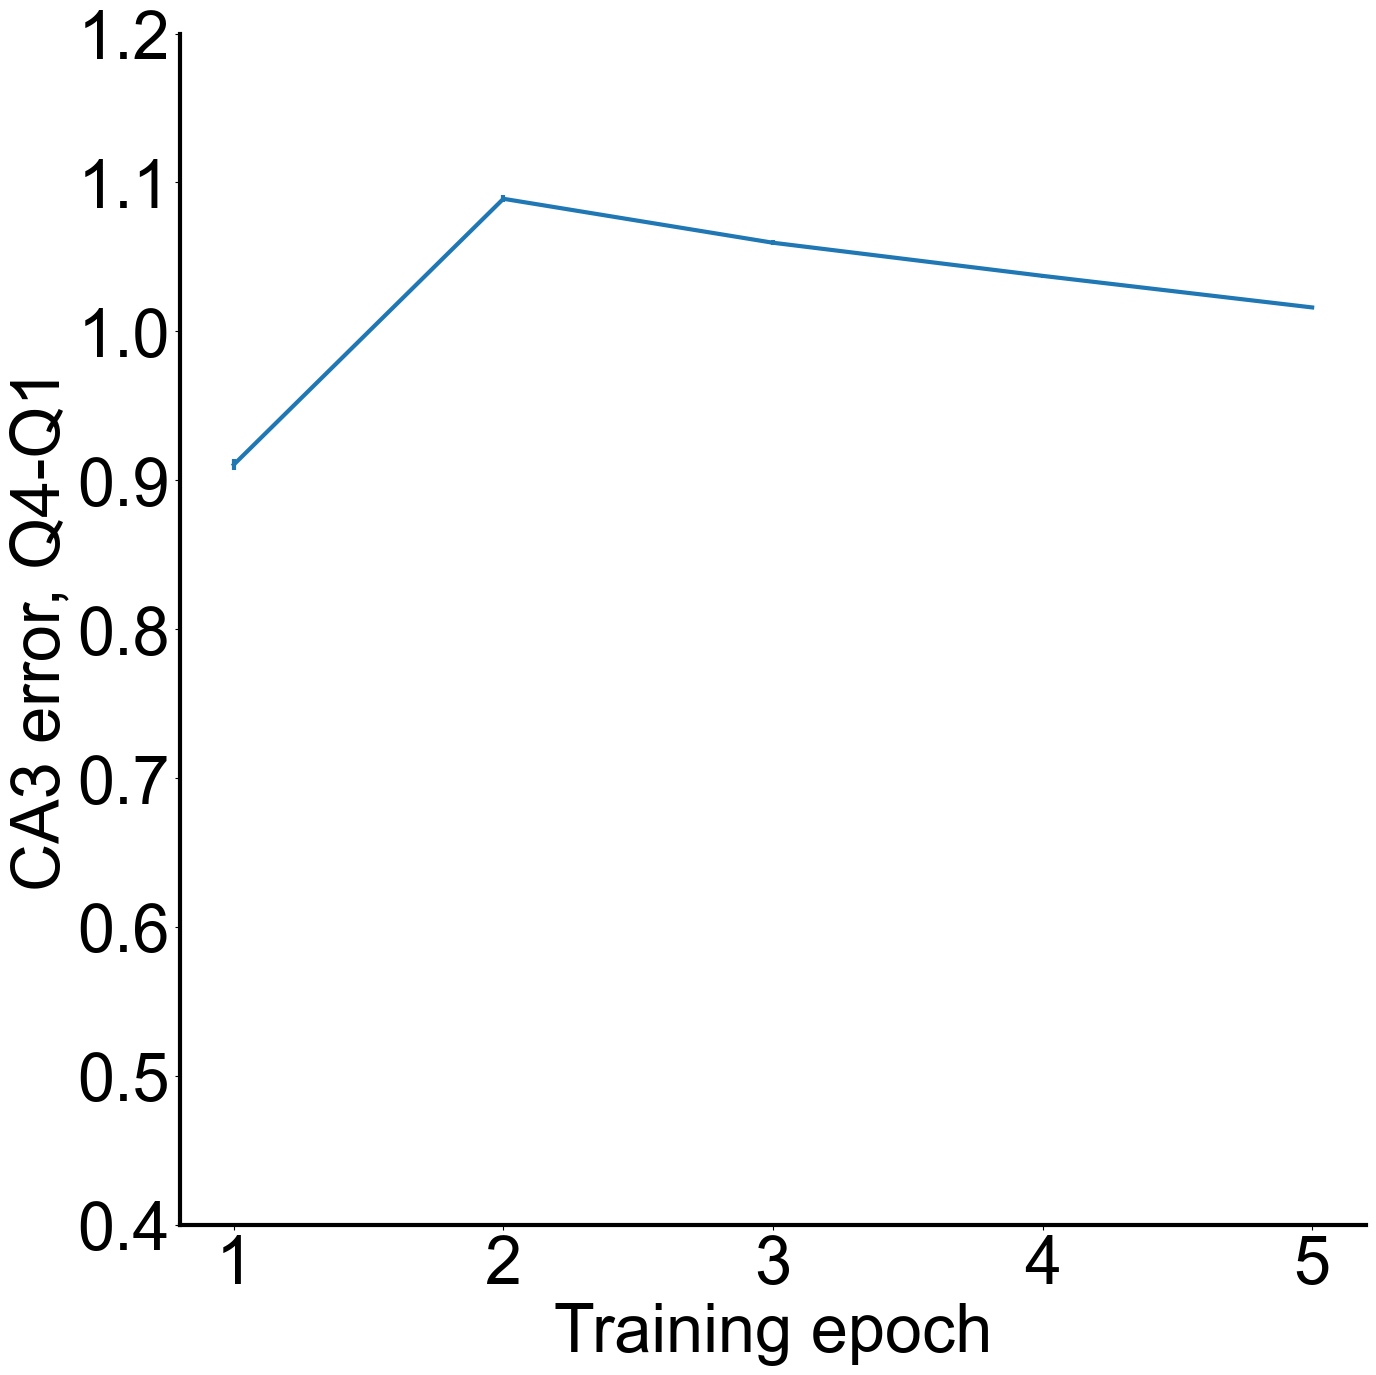

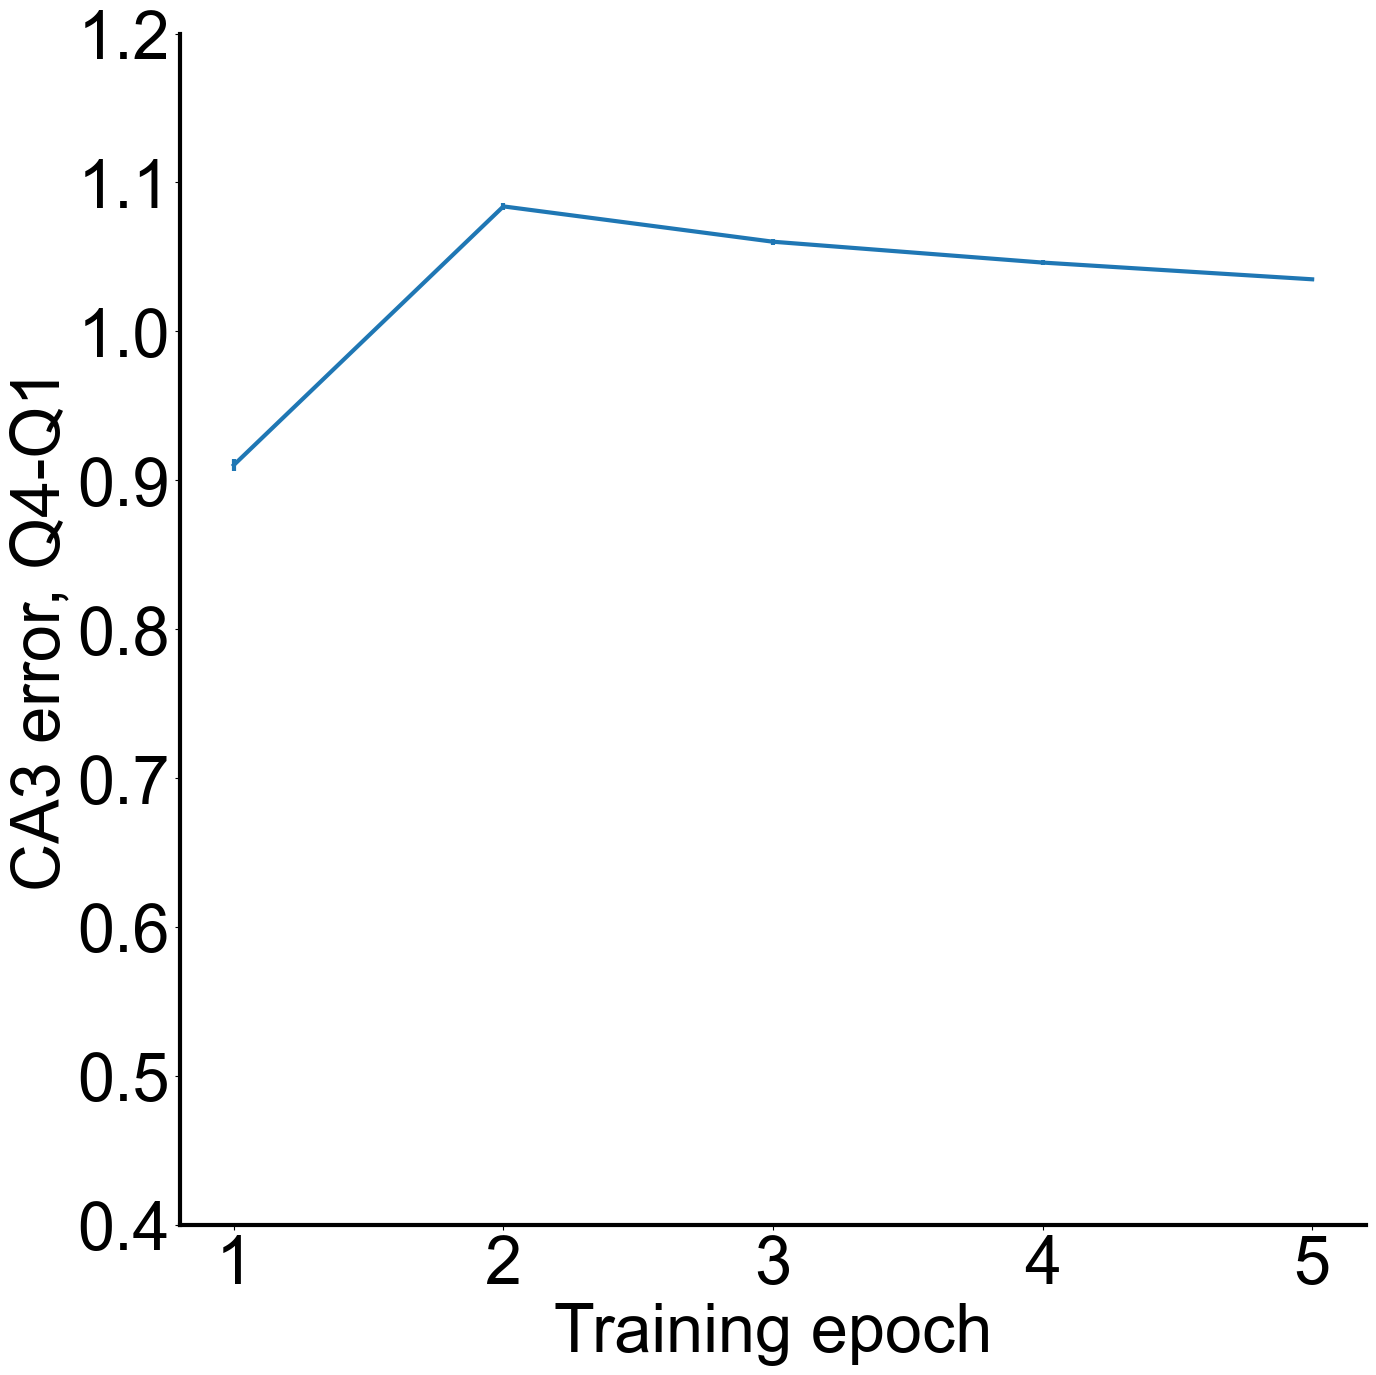

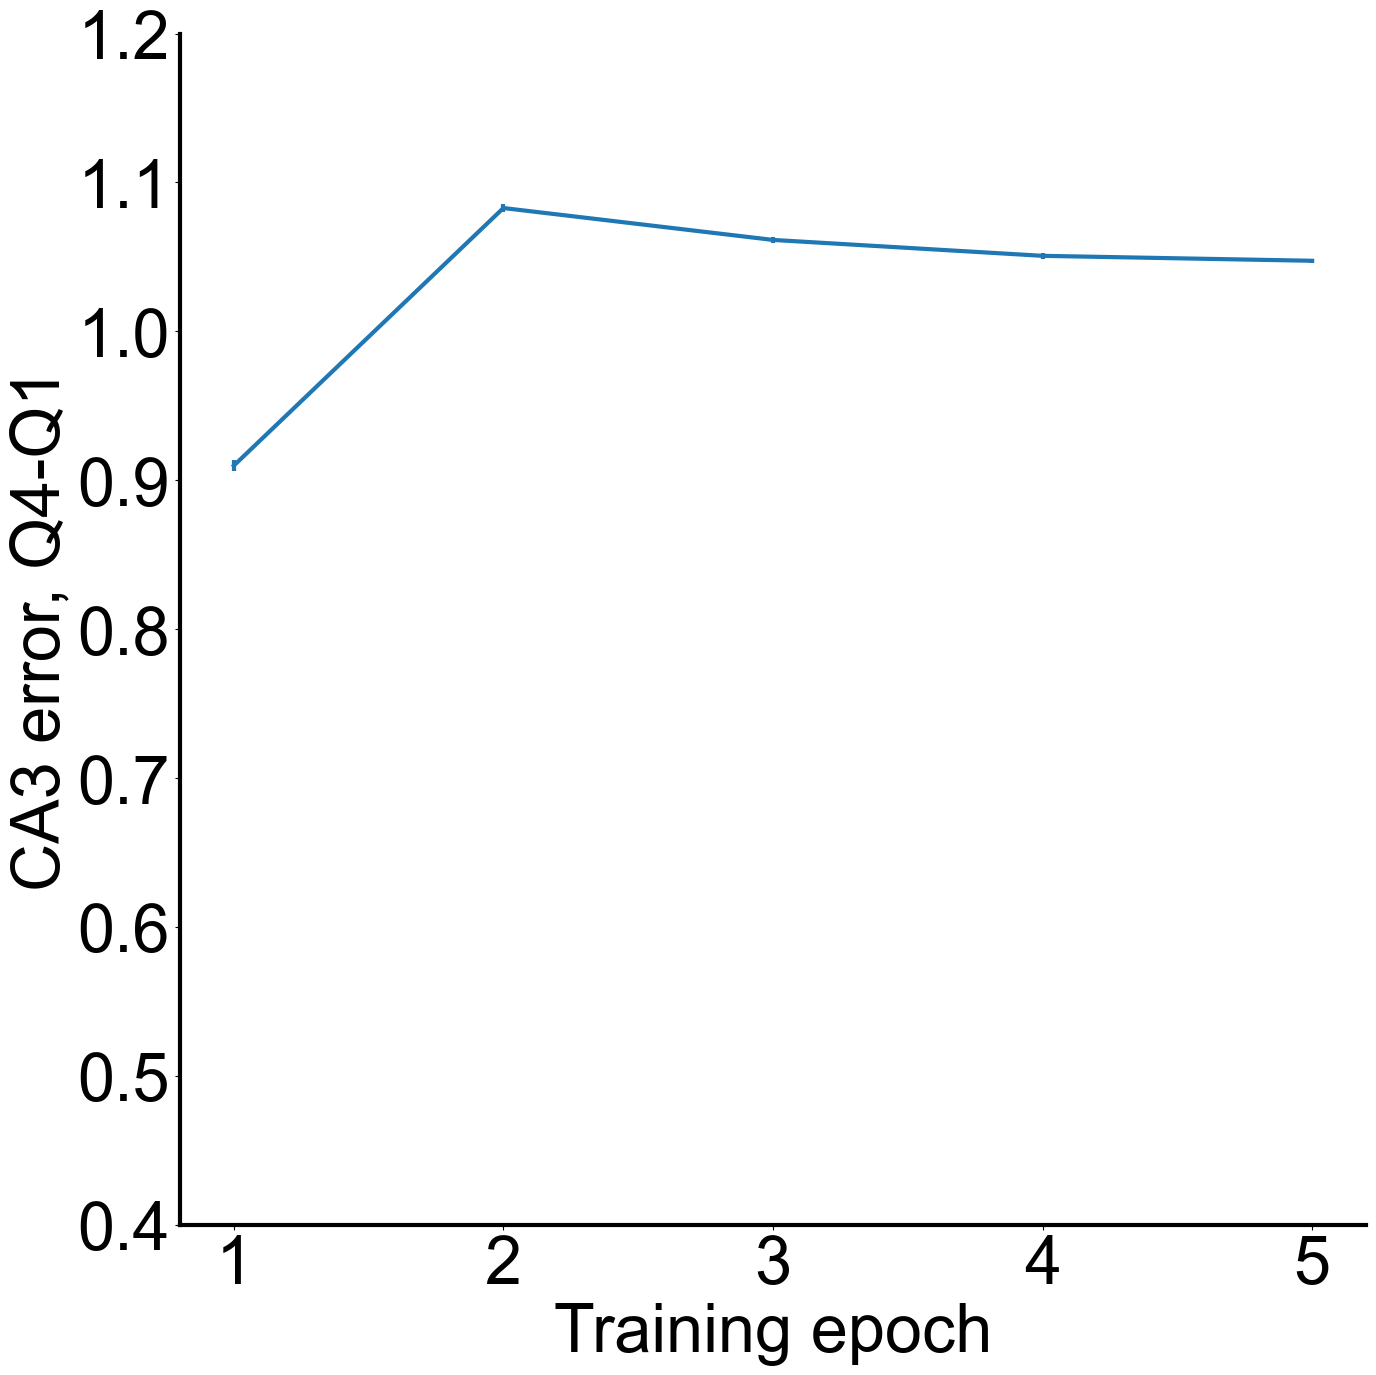

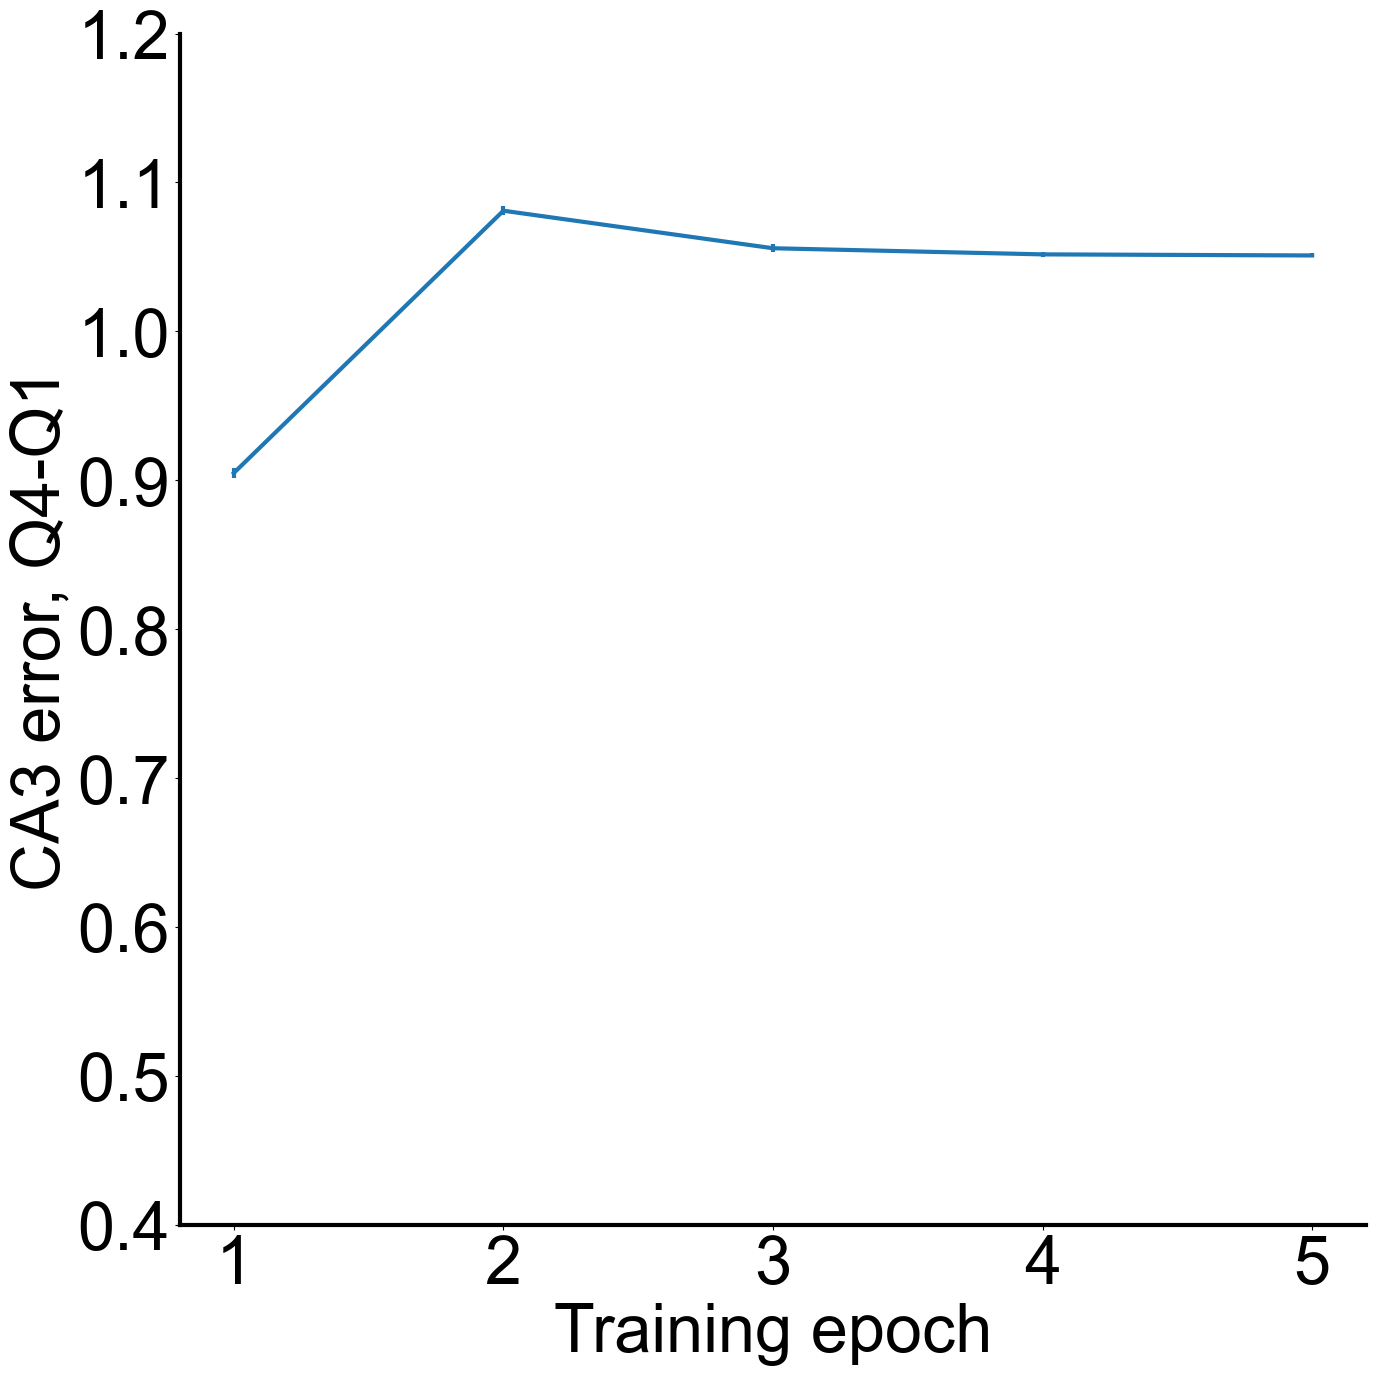

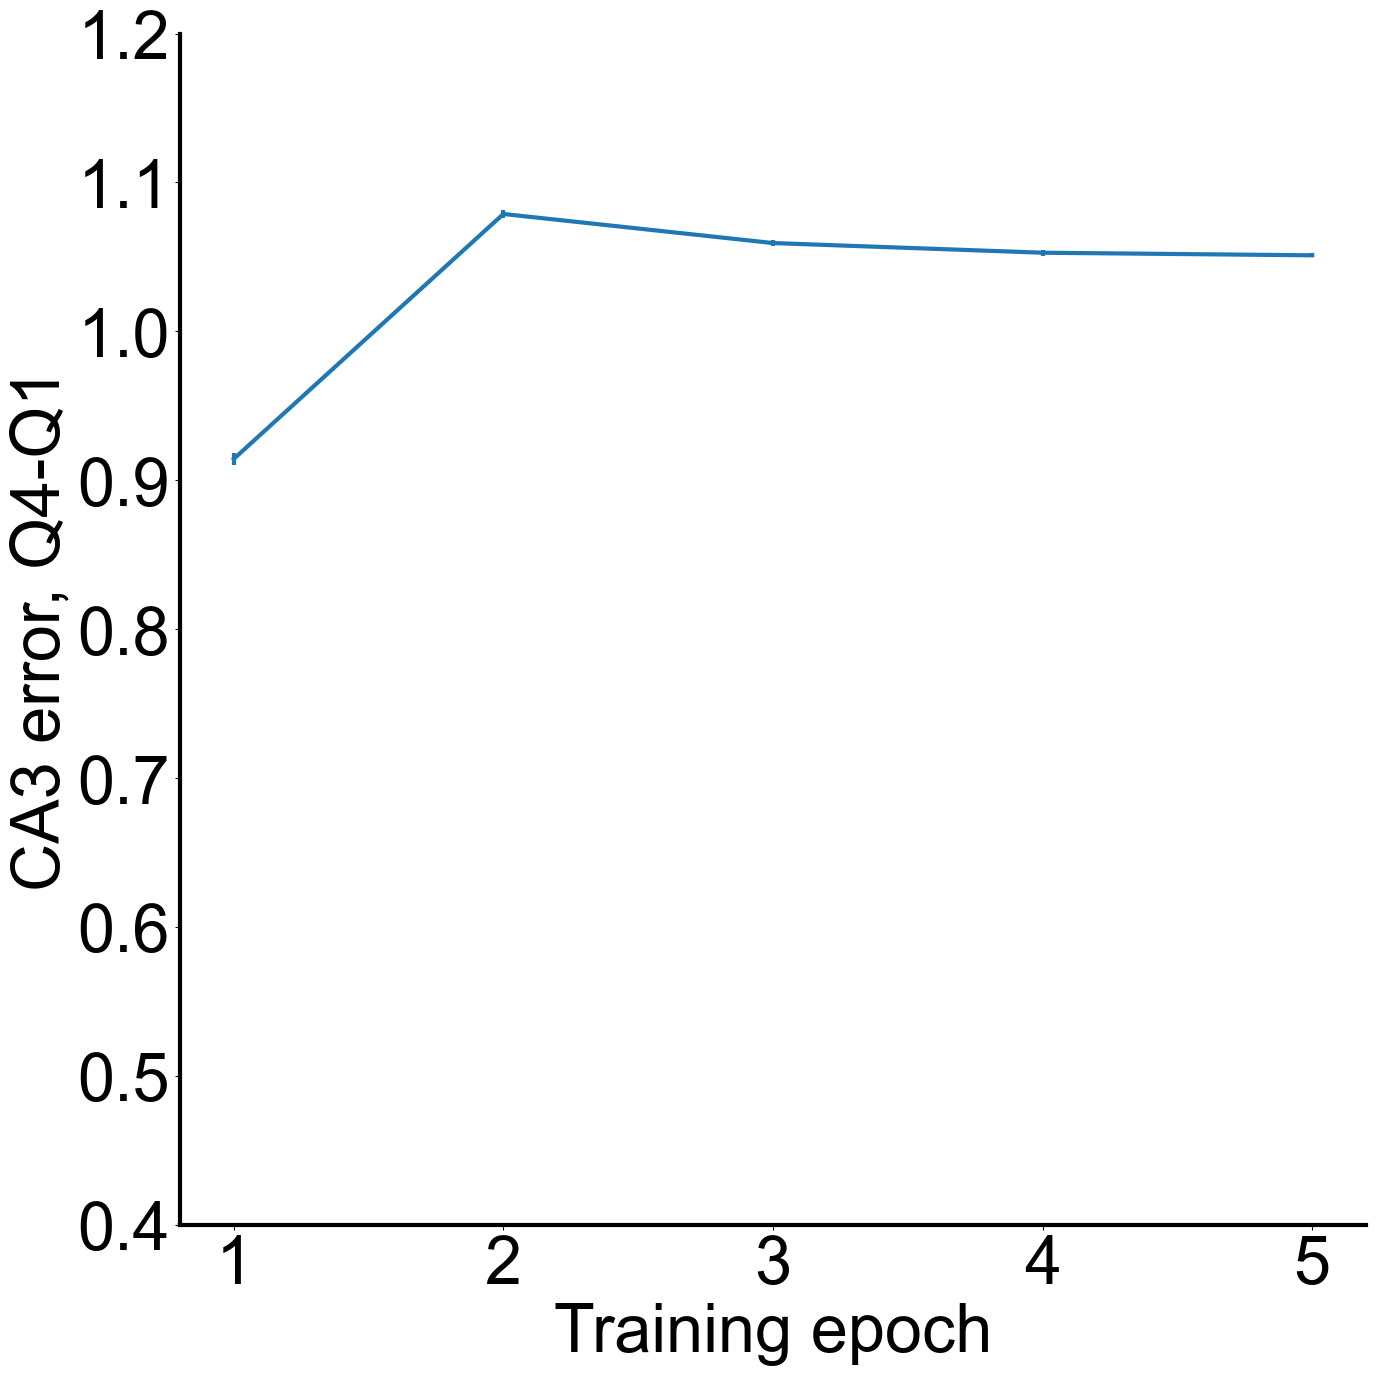

In [75]:
nris=10
maxepcs=5
pretrain=6 # #pretrain epochs
midpt,mid=(maxepcs-1)/2,maxepcs/2
midpt,mid=3.5,4
x0=np.arange(maxepcs)+1
plt.rcParams['figure.figsize'] = [fs2,fs2]
plt.rcParams['axes.linewidth']=lw
plt.rcParams['lines.linewidth'] = lw
plt.rcParams.update({'font.size': cfs*4})
lays=['CA3']#['DG','CA3','CA1']
nl=len(lays)
jump14=np.zeros((nl,nruns,5))

#which contrast? 0=drift vs no drift, 1=all sp conditions,10=low vs high,11=ECE
allsp=1
first=main_first+0 
fjobs,tlls=np.arange(first,first+90+1,9),copy.deepcopy(ells_a)
ylab='Q4-Q1'
if allsp==0:
    fjobs=[first,first+18]
    tlls=['No drift','Drift']
elif allsp==10:
    fjobs=[first+9,first+63]
    tlls=['Low drift','High drift']
    ylab='prediction - outcome'
elif allsp==11:
    first=ece_first+0
    fjobs=np.arange(first,first+27+1,9)
    tlls=copy.deepcopy(ells_a2)
    ylab='prediction - outcome'

len_t=len(fjobs)*nruns*maxepcs
dat_ca3_a=np.zeros((len_t,maxepcs))
df_err=pd.DataFrame({'subid':[0]*len_t,'Exp':['']*len_t,'Epc':[0]*len_t,'Memory':[0]*len_t})
for ii in range(len(fjobs)):
    fjob=int(fjobs[ii])
    pnb=pnbf(base,fjob)
    yrge = np.array([[0.4,1.2]])
    runs14_a_a=np.zeros((nl,nruns,maxepcs))
    for lay in range(nl): 
        f,ax=plt.subplots(1,1)
        cn=lays[lay]
        for h in range(1): #nris - same for all ris because this is just about training
            df0=pd.read_csv(pnb+str(fjob+h)+"/stcm7_Base_trn_epc.tsv", sep='\t', header=0) #sample, pre-assign sizes
            df0=df0[:nruns*maxepcs+pretrain]
            runs14_a=np.zeros((nruns,maxepcs))
            for i in range(nruns):
                low,upp=pretrain+maxepcs*i,pretrain+(i+1)*maxepcs
                runs14_a[i,:]=df0['#' + cn + ' ED14'][low:upp]
                jump14[lay,i,h]=df0['#' + cn + ' ED14'][low+mid]-df0['#' + cn + ' ED14'][low+mid-1]
                runs14_a_a[lay,i,:]=runs14_a[i,:]
                subnum=ii*nruns+i
                count=ii*nruns*maxepcs+i*maxepcs
                df_err['subid'][count:count+maxepcs]=subnum
                df_err['Exp'][count:count+maxepcs]=tlls[ii]
                df_err['Epc'][count:count+maxepcs]=[0,1,2,3,4]
                df_err['Memory'][count:count+maxepcs]=runs14_a[i,:].T
            print(np.mean(runs14_a,0))
            layp(x0,runs14_a,nruns,midpt,ylab,h,3,cn,yrge[lay,:]) #plot
        f.tight_layout() 

    fn='dat/runs14_a_a-' + str(fjob)        
    scipy.io.savemat(fn,{'runs14_a_a': runs14_a_a})

In [76]:
#export to R
exportR=1
if exportR:
    fn=rdir+str(allsp)+'-Rdata-err.csv'
    df_err.to_csv(fn)

2
[0.904268 0.771942 0.755985 0.720167 0.694863]
[0.914923 0.961593 0.978185 0.93623  0.902806]


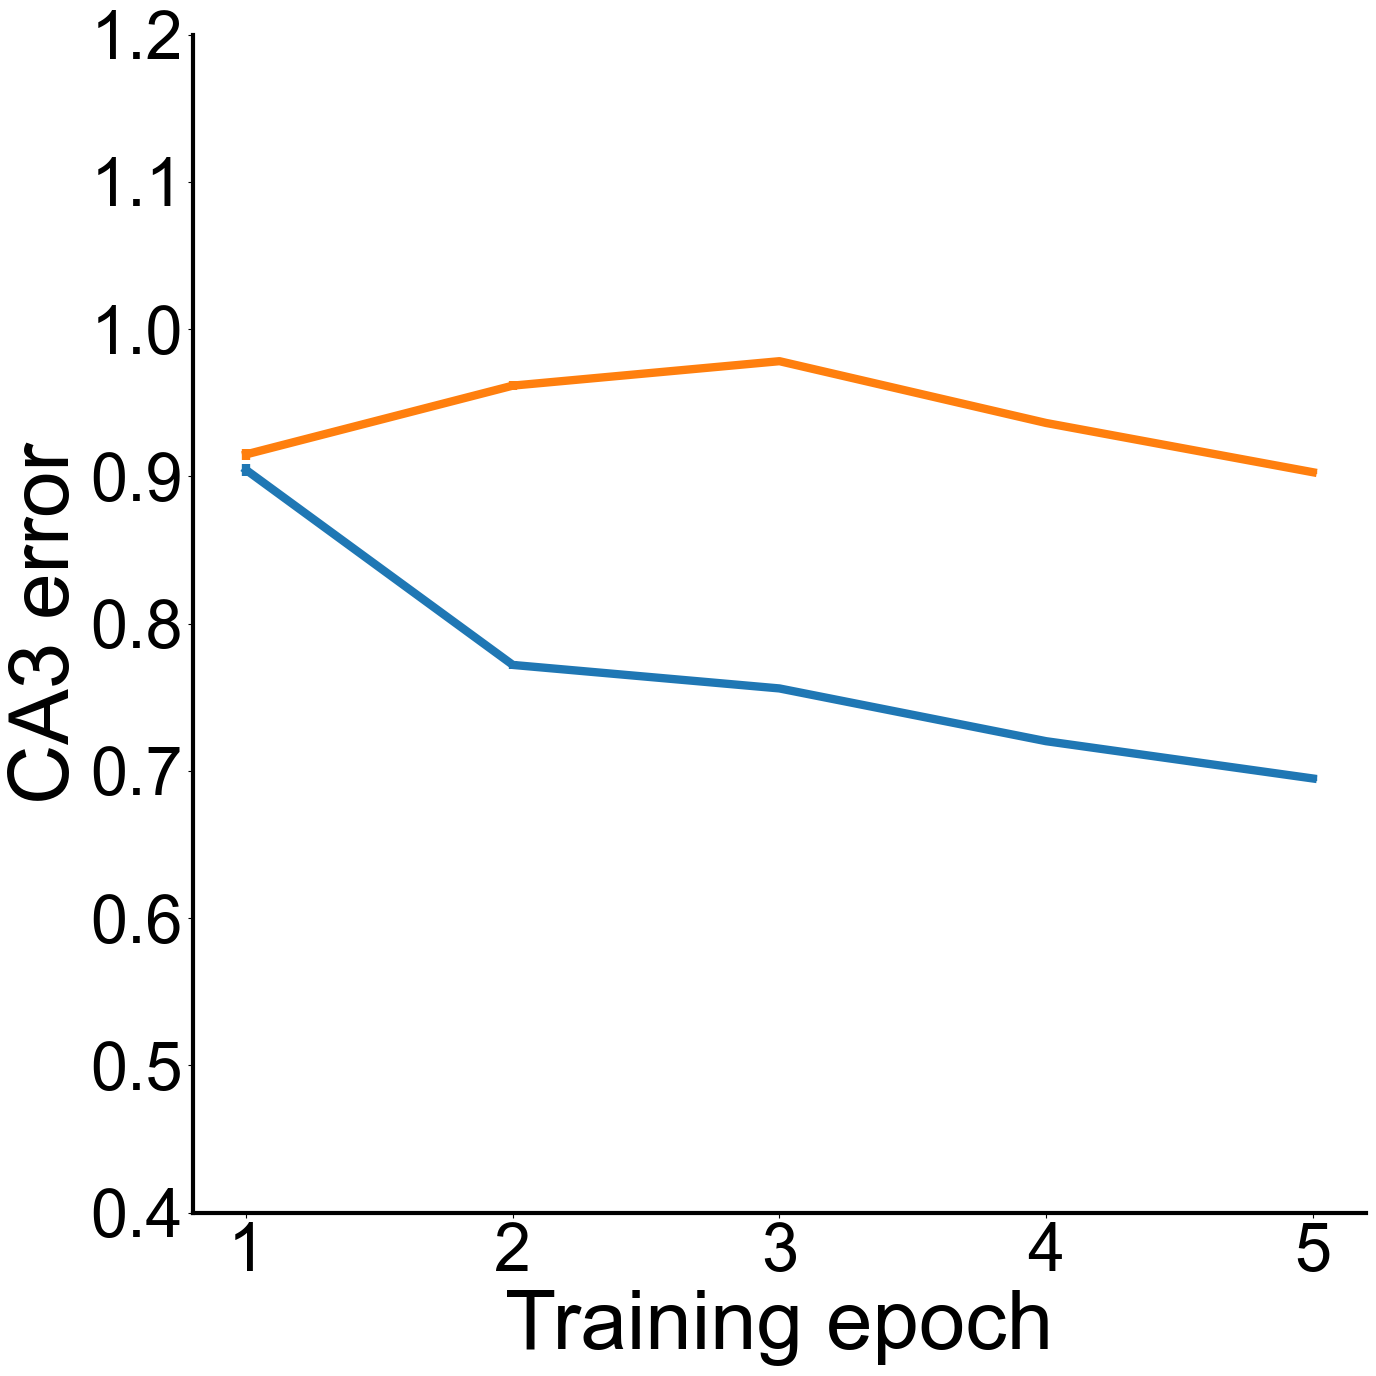

In [22]:
tlay=0 #temp layer for this plot = CA3
plt.rcParams['figure.figsize'] = [fs2,fs2]
if allsp==10:
    yrge = np.array([[0.8,1.2]])

fact=1.5
f,ax=plt.subplots(1,1,figsize=(fss*fact,fss*fact))       
print(len(fjobs))
for i in range(len(fjobs)):
    fn='dat/runs14_a_a-' + str(fjobs[i])        
    mat_contents=scipy.io.loadmat(fn)
    datmat=mat_contents['runs14_a_a']
    print(np.mean(datmat[tlay,:,:],axis=0))
    layp2(x0,datmat[tlay,:,:],i,allsp,nruns,yrge[tlay,:],tlls[i],4,len(fjobs))   
if allsp==0:
    f.tight_layout()
f.tight_layout()
f.savefig('figs/Qcycle_compare-nolegend-%s-%s-%s.pdf' %(fjobs[0],fjobs[-1],lays[tlay]), transparent=True)

2
[0.904268 0.771942 0.755985 0.720167 0.694863]
[0.914923 0.961593 0.978185 0.93623  0.902806]


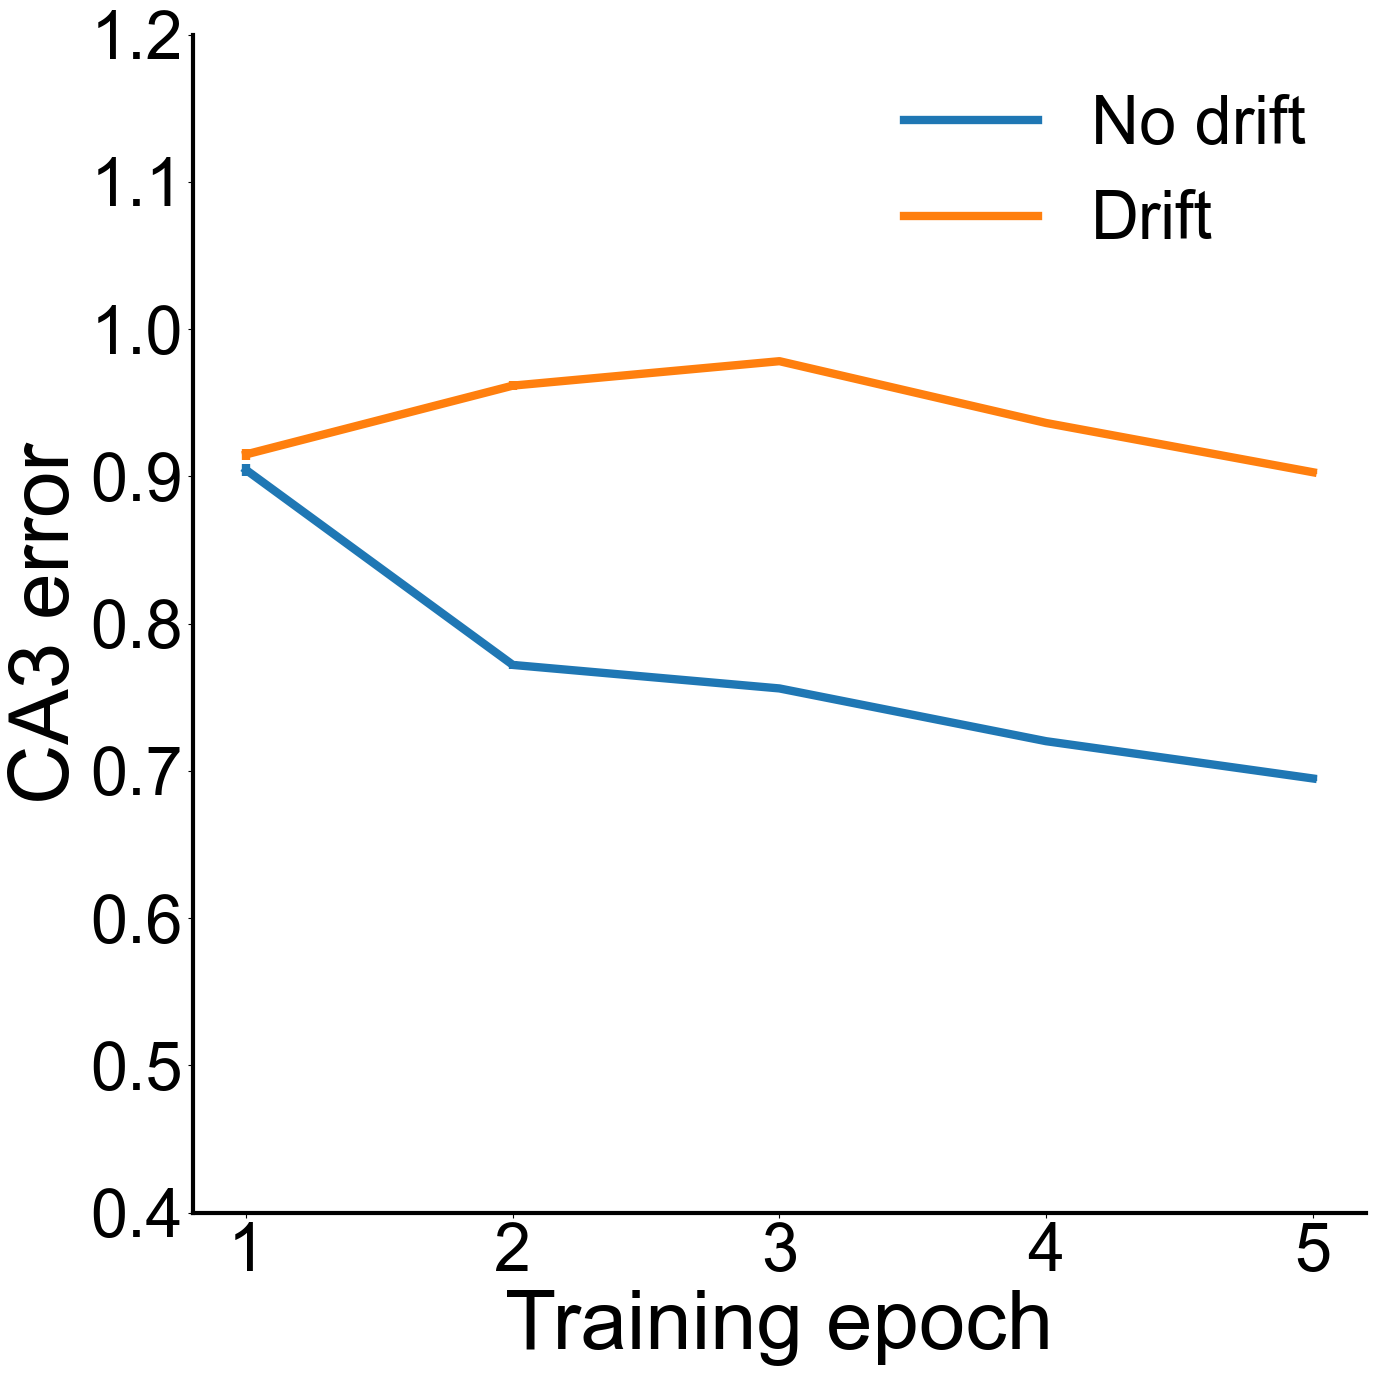

In [23]:
f,ax=plt.subplots(1,1,figsize=(fss*fact,fss*fact))       
print(len(fjobs))
for i in range(len(fjobs)):
    fn='dat/runs14_a_a-' + str(fjobs[i])        
    mat_contents=scipy.io.loadmat(fn)
    datmat=mat_contents['runs14_a_a']
    print(np.mean(datmat[tlay,:,:],axis=0))
    layp2(x0,datmat[tlay,:,:],i,allsp,nruns,yrge[tlay,:],tlls[i],4,len(fjobs))   
if allsp==1:
    box = ax.get_position()
    ax.set_position([box.x0+0.01, box.y0, box.width * 0.9, box.height])
    leg=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
elif allsp==10:
    leg=plt.legend(loc='upper right',frameon=False,fontsize=cfs*4)
elif allsp==0:
    leg=plt.legend(loc='upper right',frameon=False,fontsize=cfs*4)
elif allsp==11:  
    leg=plt.legend(loc='lower right',frameon=False,fontsize=cfs*4)
for line in leg.get_lines():
    line.set_linewidth(6)
if allsp==0:
    f.tight_layout()
f.tight_layout()
f.savefig('figs/Qcycle_compare-%s-%s-%s.pdf' %(fjobs[0],fjobs[-1],lays[tlay]), transparent=True)

# 3 - Representational similarity analyses - Fig 7D-E + 8C

(1, 5, 32, 32)


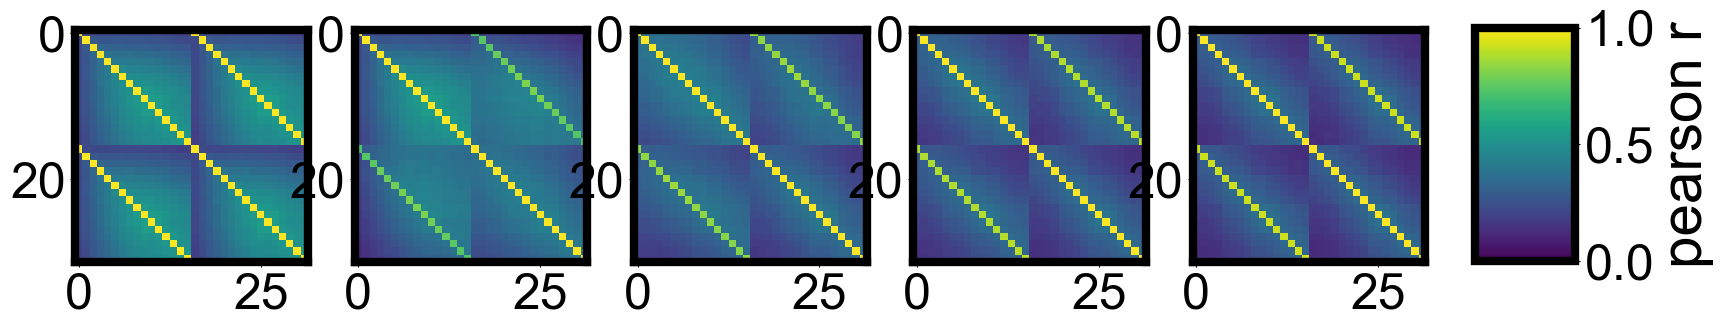

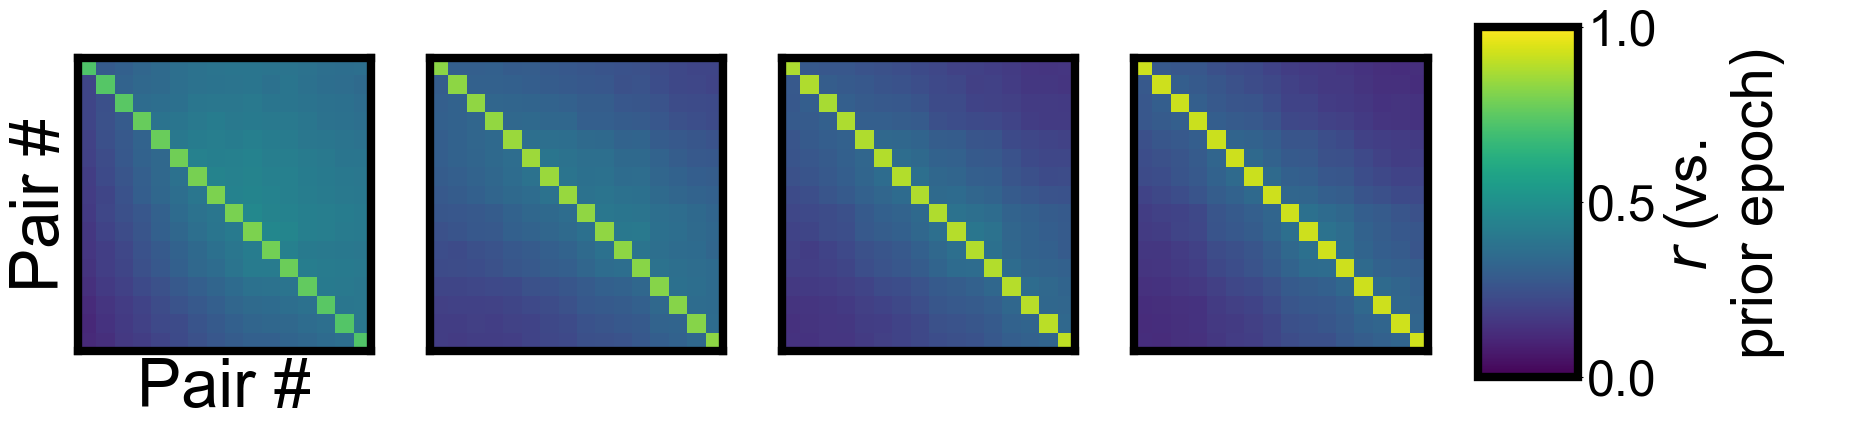

(32, 100)
(480, 100)
(1, 5, 32, 32)


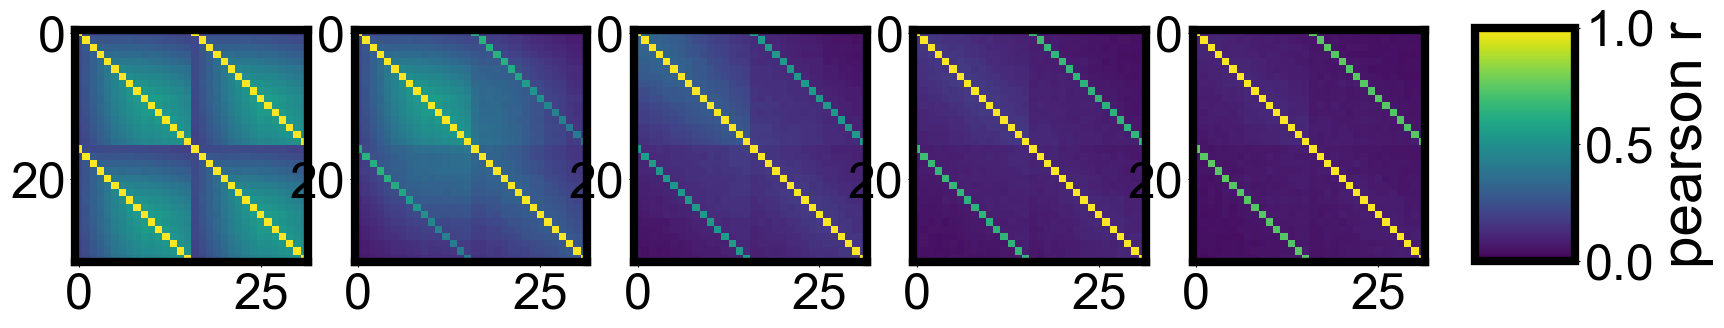

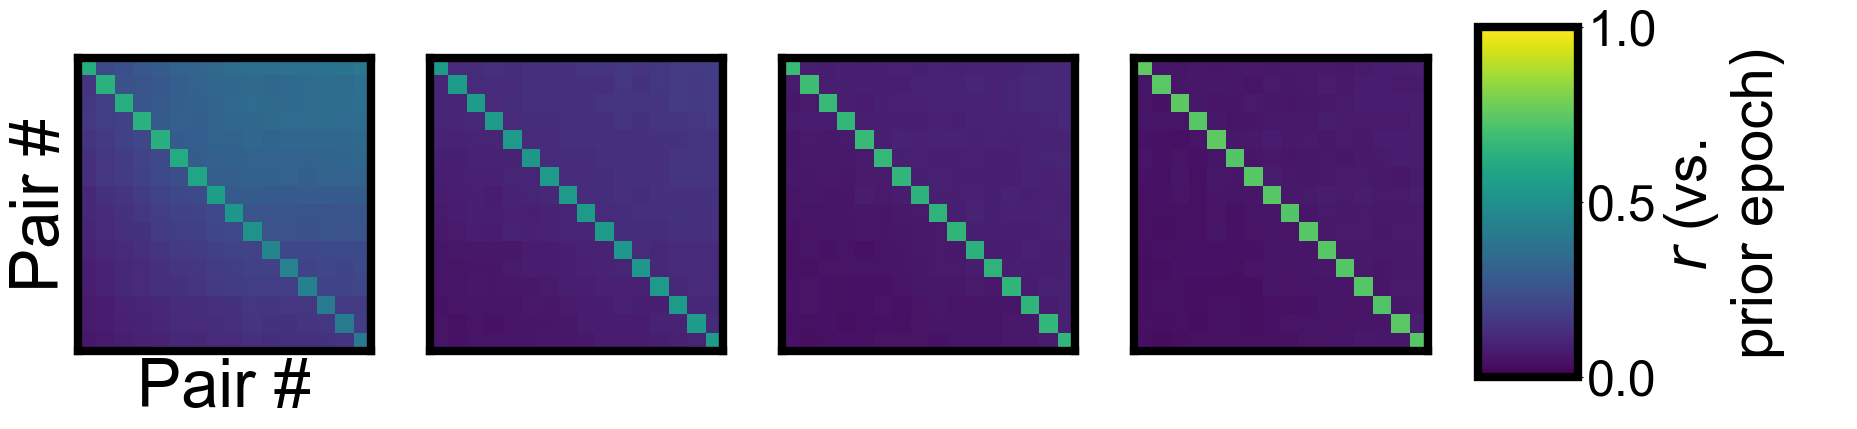

(1, 5, 32, 32)


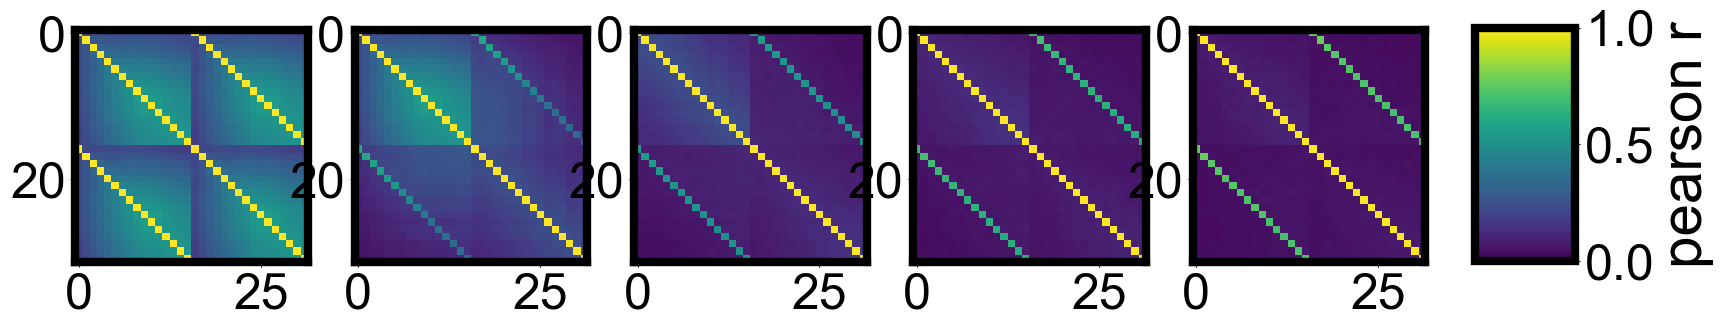

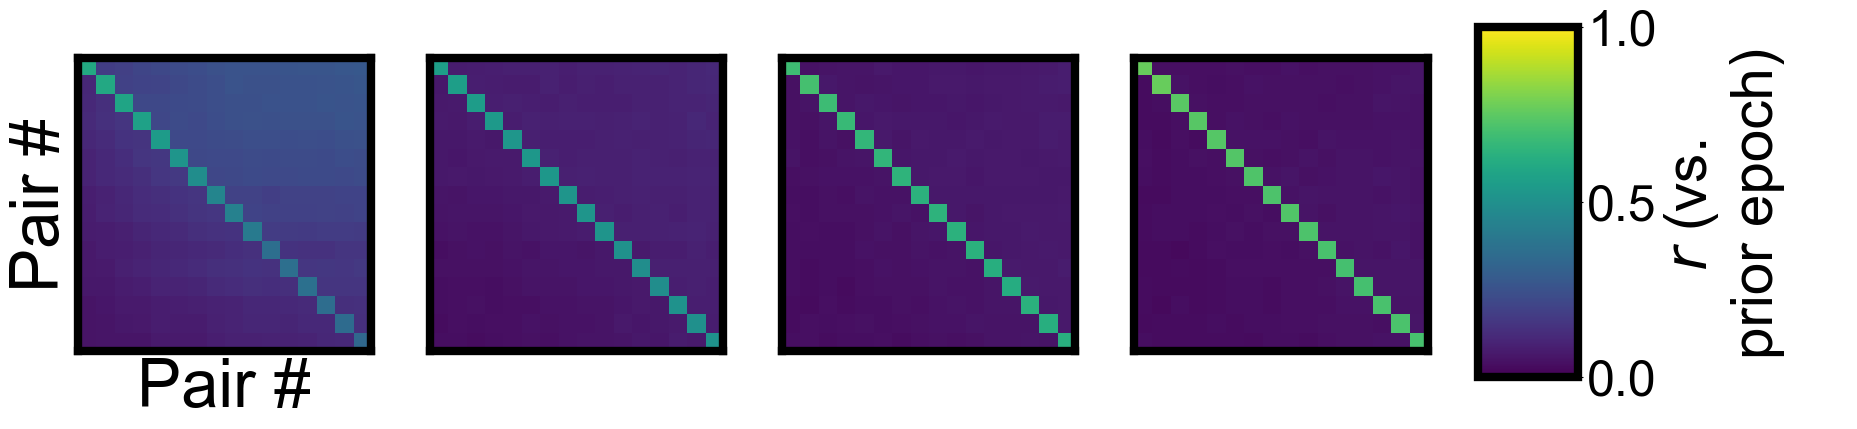

(1, 5, 32, 32)


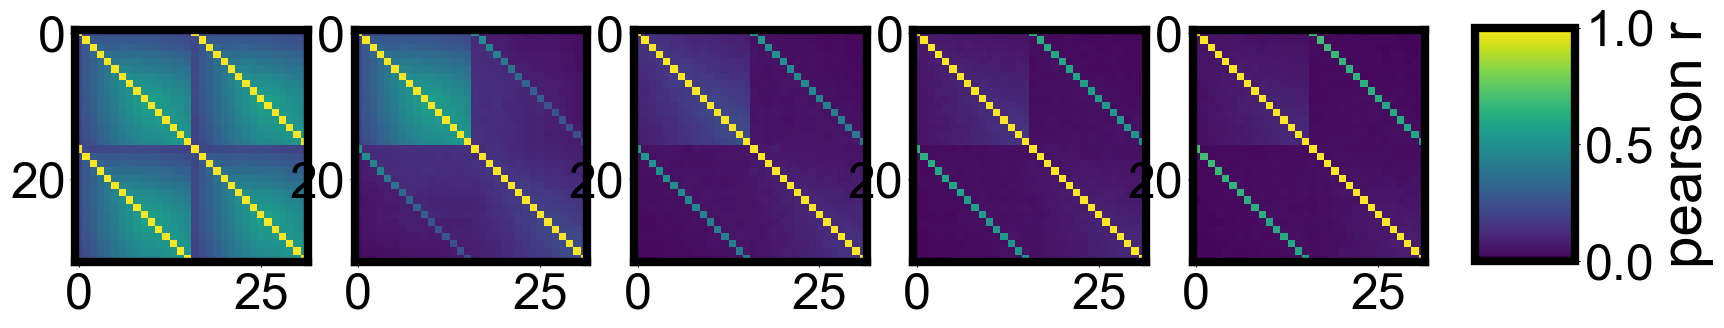

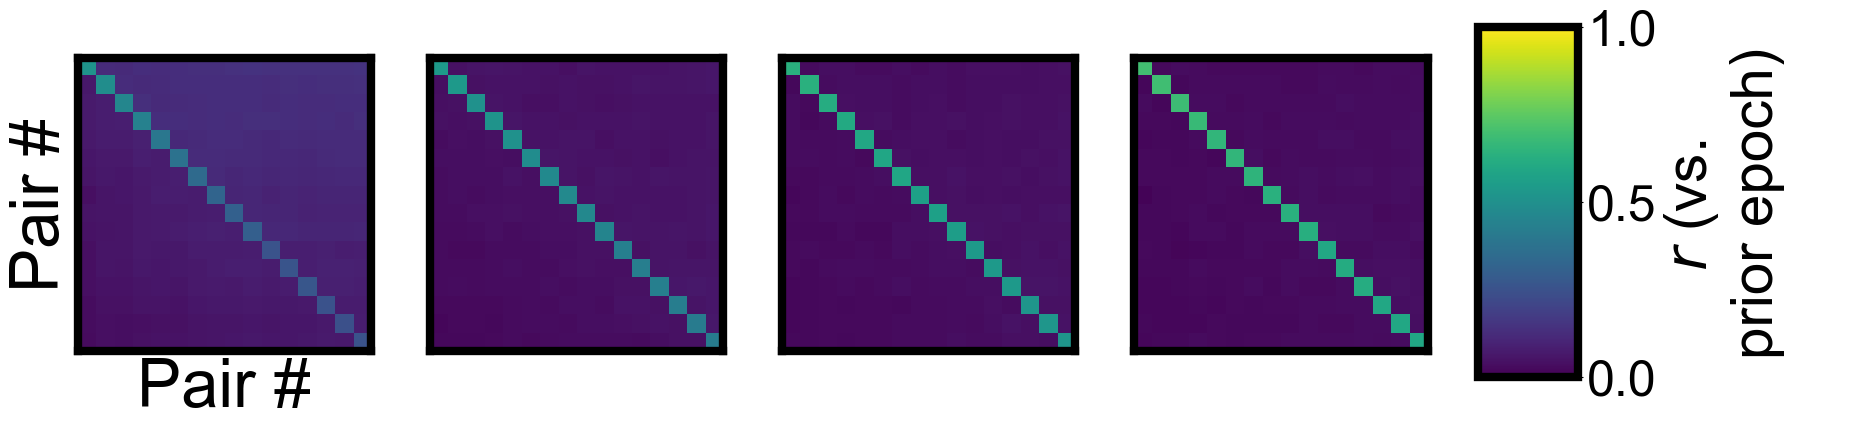

(1, 5, 32, 32)


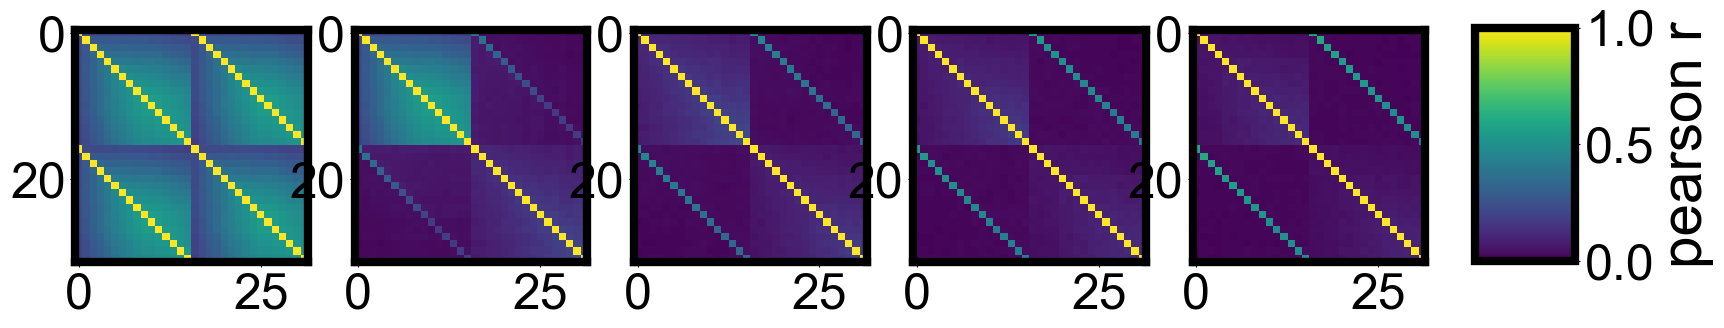

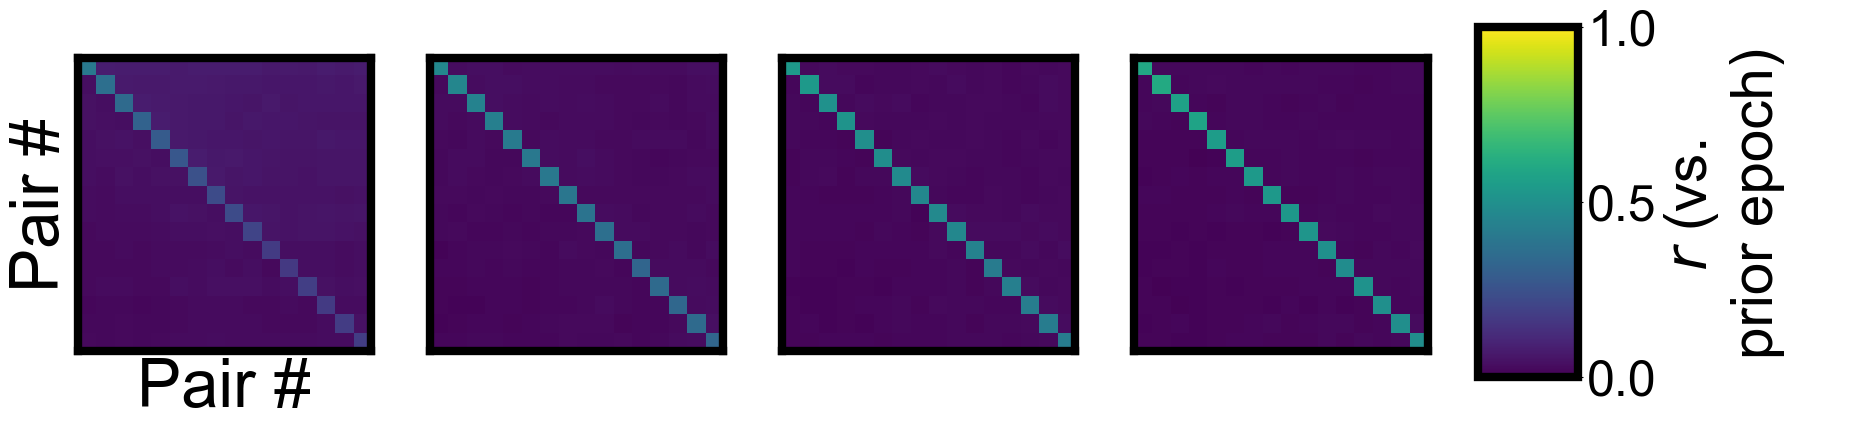

(1, 5, 32, 32)


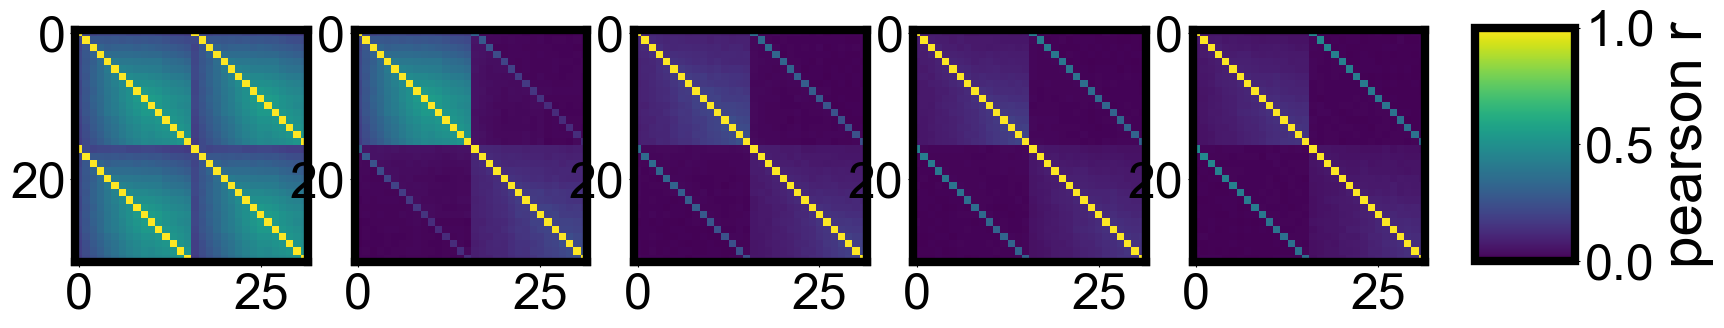

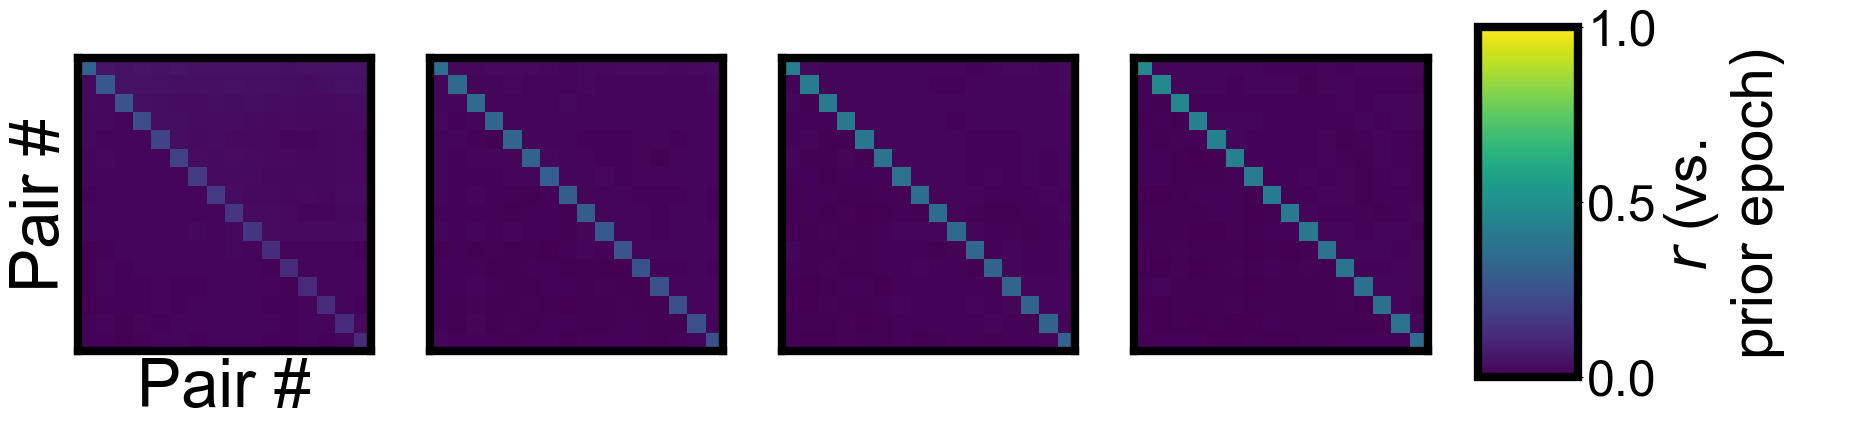

(1, 5, 32, 32)


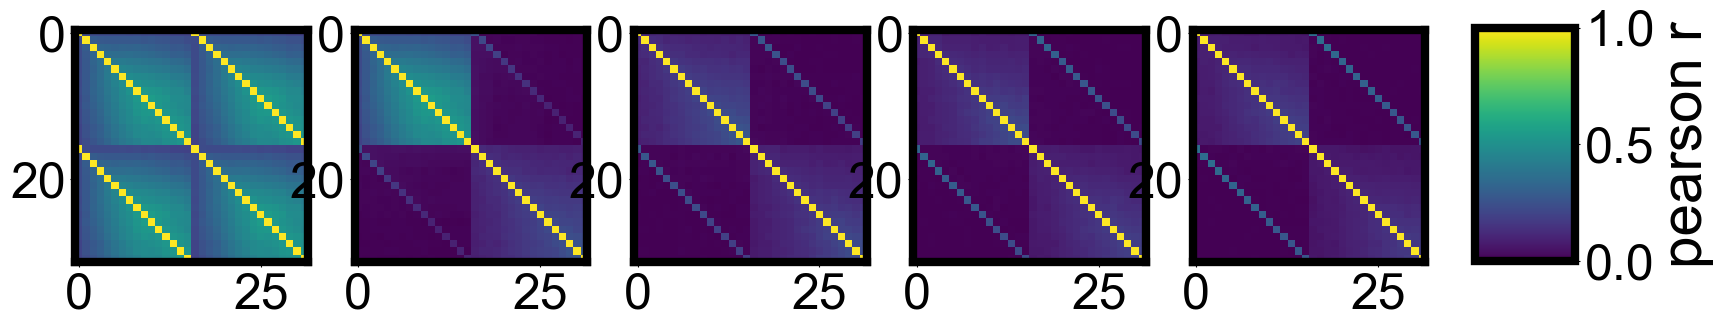

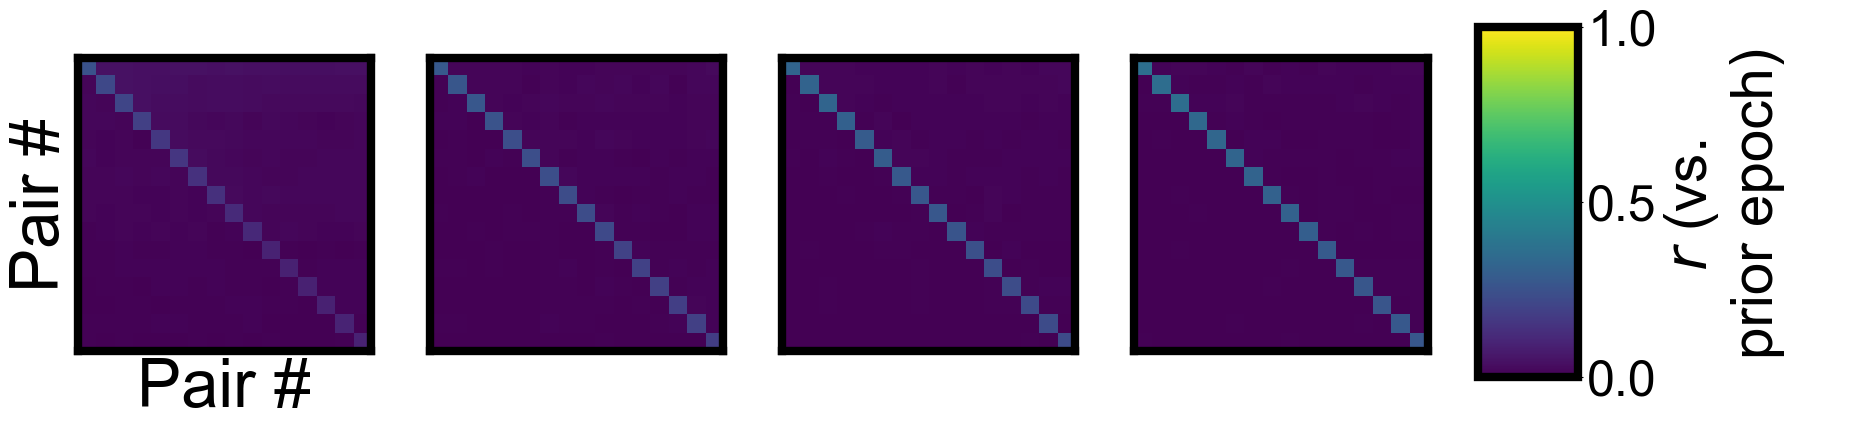

(1, 5, 32, 32)


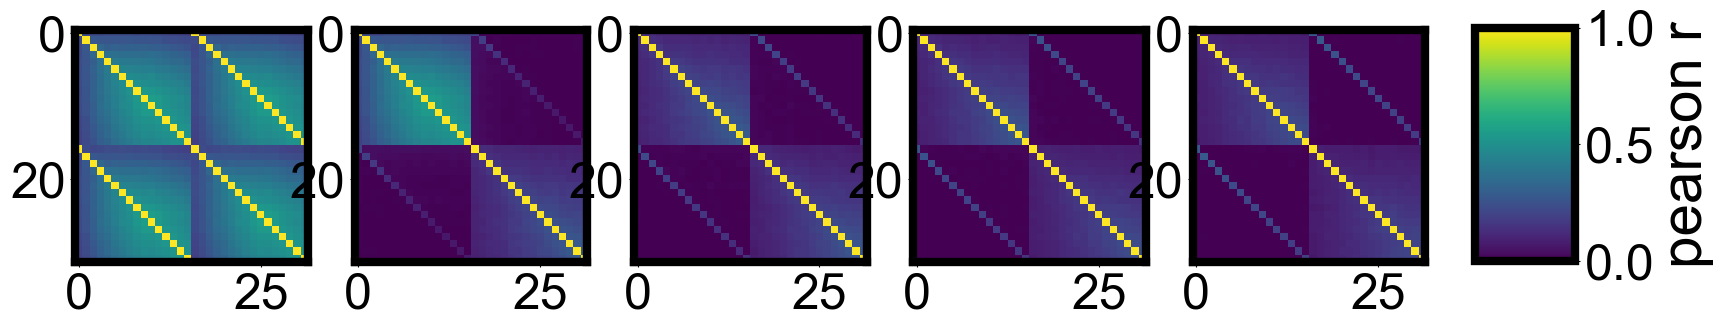

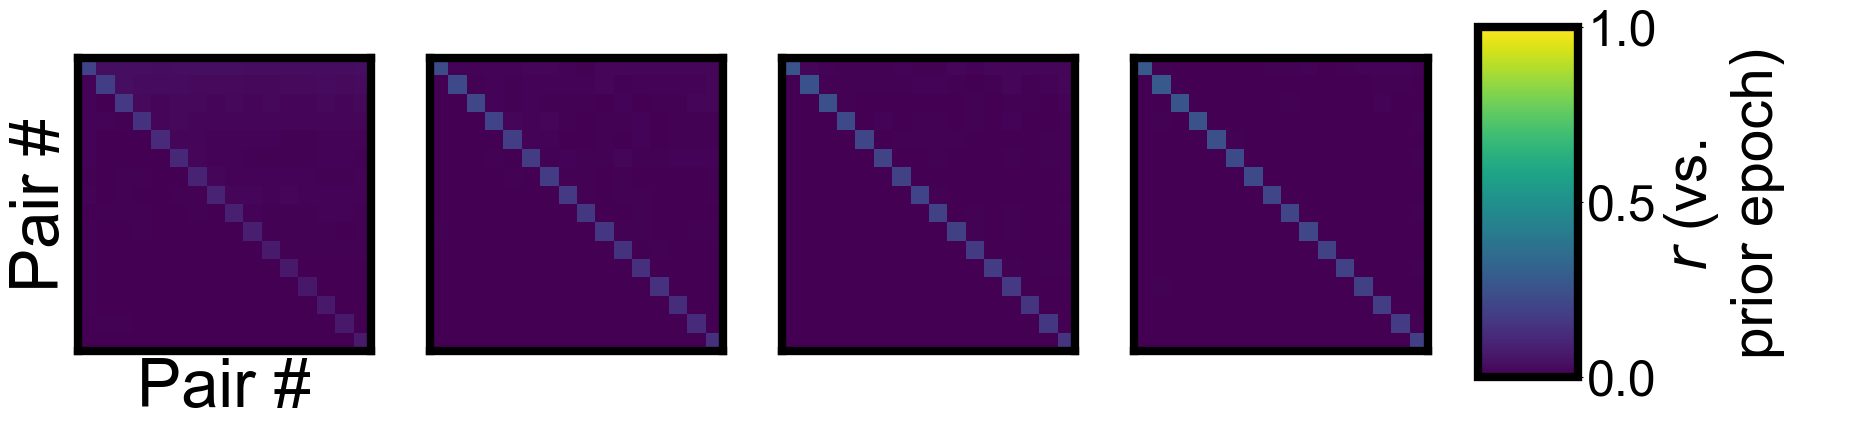

(1, 5, 32, 32)


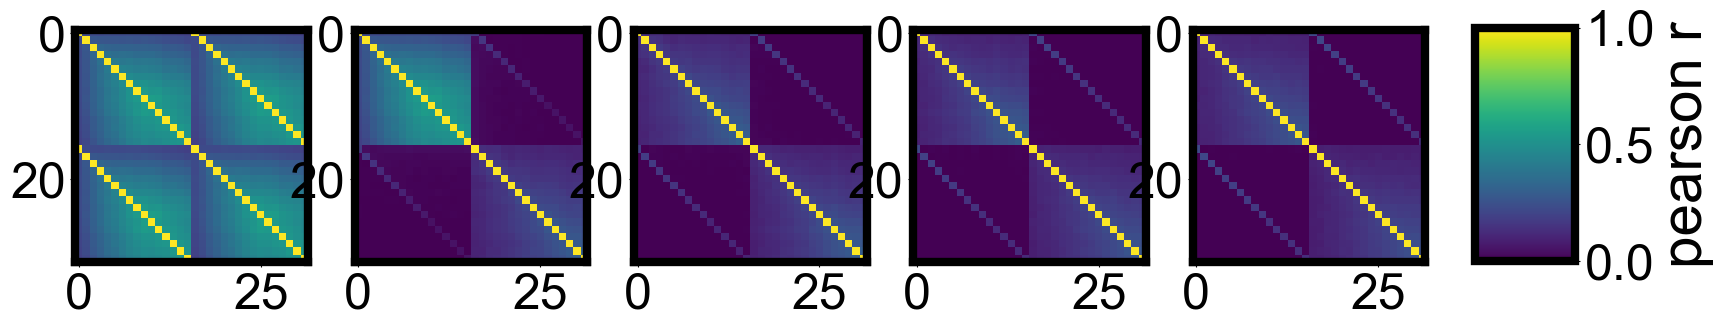

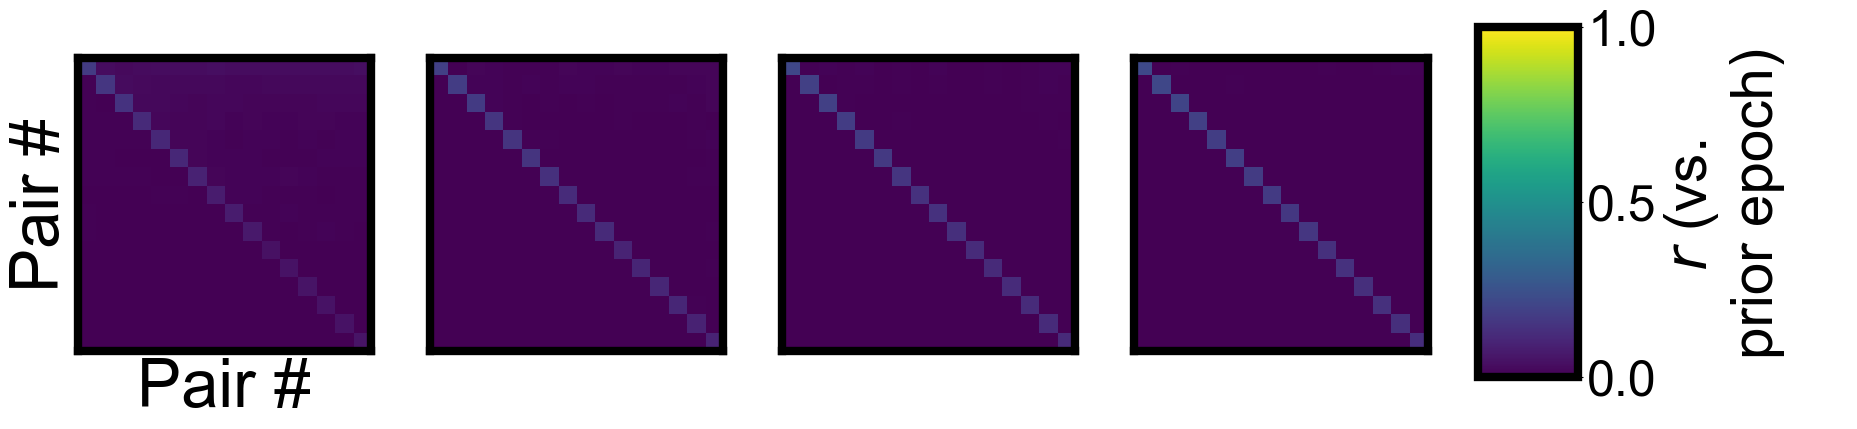

(1, 5, 32, 32)


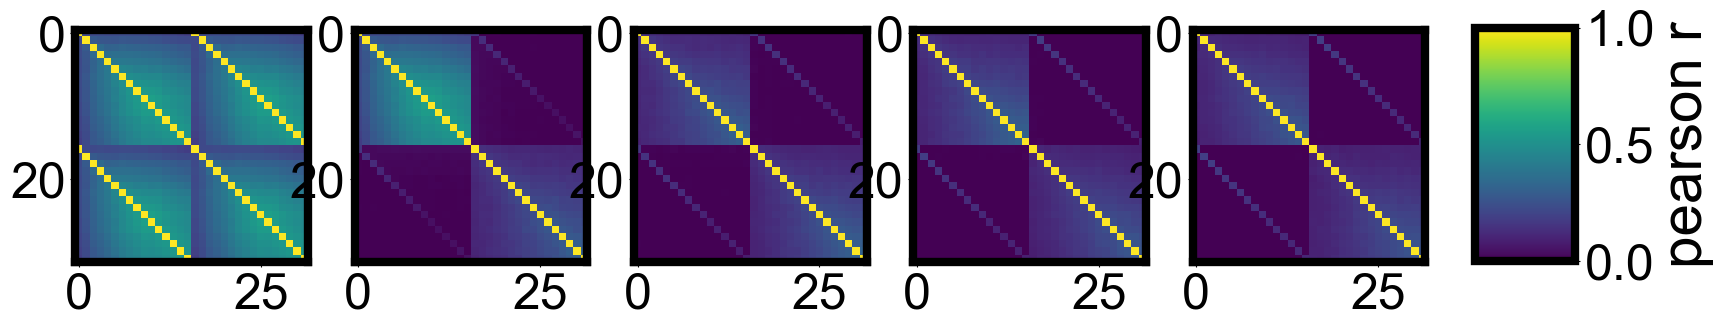

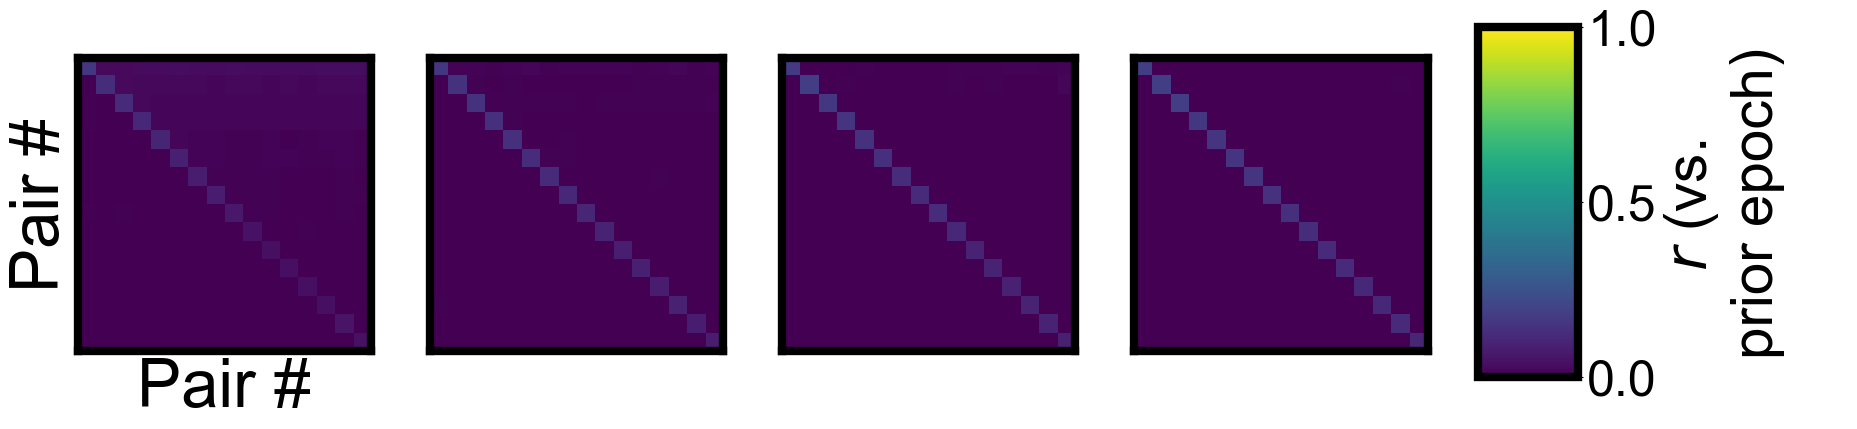

(1, 5, 32, 32)


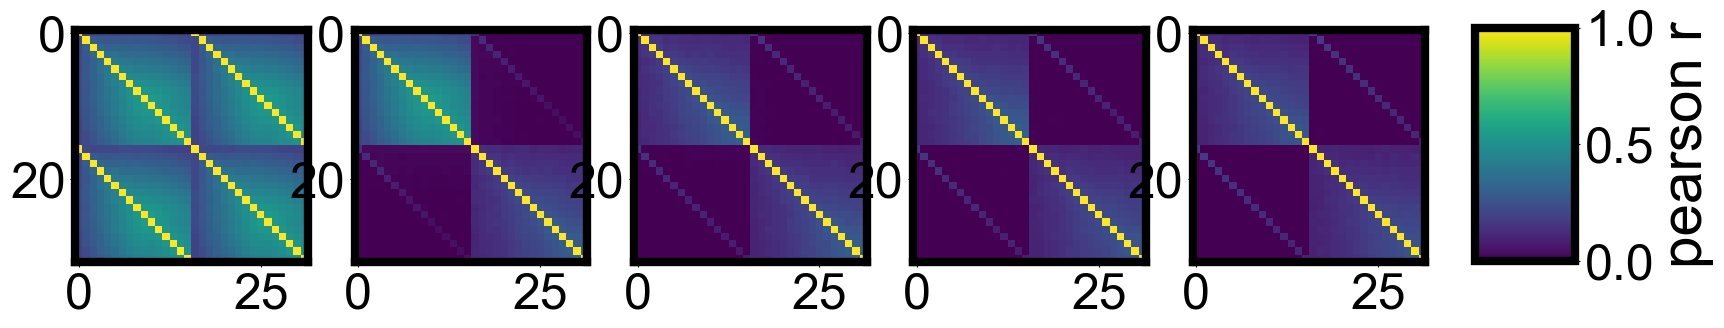

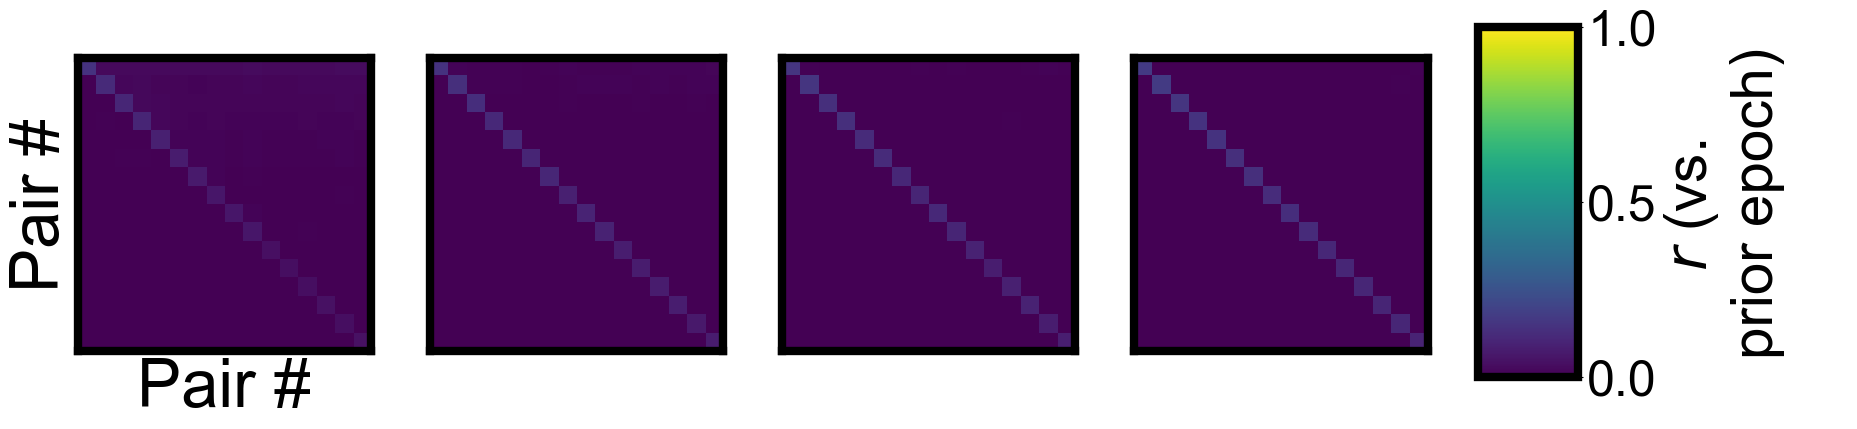

In [104]:
allsp=1 #0=drift vs no drift, 1=all sp conditions,10=grant
first=main_first+0
fjobs,tlls=np.arange(first,first+90+1,9),copy.deepcopy(ells_a)
if allsp==0:
    fjobs=[first,first+18]
    tlls=['No drift','Drift']
elif allsp==10:
    fjobs=[first+9,first+63]
    tlls=['Low drift','High drift']

plt.rcParams['axes.linewidth']=lw*2
plt.rcParams['lines.linewidth']=lw*2
plt.rcParams.update({'font.size': cfs*3})
plot_each=1
curr_or_prev=0 #1=curr,0=prev
numplots=maxepcs-1
if curr_or_prev==1:
    numplots=maxepcs+0
same_epc_a=np.zeros((len(fjobs),nruns,maxepcs))
diff_epc_a=np.zeros((len(fjobs),nruns,maxepcs))
for e in range(len(fjobs)):
    fjob=int(fjobs[e]) 
    pnb=pnbf(base,fjob)
    #dat is lays X RIs X runs X epcs X list X list
    lays=['CA3'] #'ECin',
    dat=np.zeros((len(lays),nruns,maxepcs,llength*2,llength*2))
    for g in range(len(lays)):
        for i in range(nruns):
            for j in range(maxepcs):
                fn=pnb+str(fjob)+"/simMatLst" + str(i) + "_" + str(j)+ "_" + lays[g] + "_epc_rep.tsv"
                #print(fn)
                fill=np.array(list(csv.reader(open(fn), delimiter=","))).astype("float")
                dat[g,i,j,:,:]=fill            

    dat_m=np.nanmean(dat,axis=1) #average across runs
    print(dat_m.shape)

    #plot full mat
    if plot_each:
        mx,mn=1,0#np.nanmax(dat_m),np.nanmin(dat_m)
        for g in range(len(lays)): #len(lays)
            #full plot
            f,ax=plt.subplots(nrows=1,ncols=maxepcs,figsize=(fss*2,fss/3))
            for h in range(maxepcs):
                im=ax[h].imshow(dat_m[g,h,:,:],interpolation='none',cmap=cm2,vmin=mn,vmax=mx)
            f.subplots_adjust(right=0.8)
            cbar_ax = f.add_axes([0.825, 0.15, 0.05, 0.7])
            cbar=f.colorbar(im, cax=cbar_ax)
            cbar.set_label('pearson r',fontsize=cfs*3.5)
            plt.show()
            f.suptitle(lays[g])
            f,ax=plt.subplots(nrows=1,ncols=numplots,figsize=(fss*2,fss/2)) #
            for h in range(numplots):
                if curr_or_prev==0:
                    im=ax[h].imshow(dat_m[g,h+1,llength:,:llength],interpolation='none',cmap=cm2,vmin=mn,vmax=mx)
                elif curr_or_prev==1:
                    im=ax[h].imshow(dat_m[g,h,llength:llength*2,llength:llength*2],interpolation='none',cmap=cm2,vmin=mn,vmax=mx)
                if h==0:
                    ax[h].set_ylabel('Pair #',fontsize=cfs*4)
                    ax[h].set_xlabel('Pair #',fontsize=cfs*4)
                ax[h].set_xticks([])
                ax[h].set_yticks([])
            f.subplots_adjust(right=0.8)
            cbar_ax = f.add_axes([0.825, 0.15, 0.05, 0.7])
            cbar=f.colorbar(im, cax=cbar_ax)
            cbar.set_label('''$\it{r}$ (vs. 
prior epoch)
            ''',fontsize=cfs*3.5) #wonky notation to get this to align
            if curr_or_prev==1:
                cbar.set_label('''$\it{r}$''')
            plt.show()
            f.savefig('figs/RepsVsLastEpc-%s-%s-%s.pdf' %(fjob,lays[g],curr_or_prev), transparent=True)
            f.suptitle(lays[g])
            
    #create same / diff matrices across epochs
    firsttt=0
    for h in range(maxepcs):
        samemat,diffmat,same_fill,diff_fill=[],[],0,0
        for i in range(llength*2):
            for j in range(llength*2):
                proc,proc2=0,0
                if curr_or_prev==1:
                    if np.logical_and(i<llength,j<llength):
                        if np.absolute(i-j)!=0:
                            proc=1
                        if np.absolute(i-j)==0:
                            proc2=1
                    elif np.logical_and(i>=llength,j>=llength):
                        if np.absolute(i-j)!=0:
                            proc=1
                        if np.absolute(i-j)==0:
                            proc2=1
                    if proc:
                        if diff_fill==0:
                            diffmat=dat[tlay,:,h,i,j]
                            diff_fill=1
                        else:
                            diffmat=np.vstack([diffmat,dat[tlay,:,h,i,j]])
                    elif proc2:
                        if same_fill==0:
                            samemat=dat[tlay,:,h,i,j]
                            same_fill=1
                        else:
                            samemat=np.vstack([samemat,dat[tlay,:,h,i,j]])
                else:
                    if np.logical_and(i>=llength,j<llength):
                        if np.absolute(i-j)!=llength:
                            proc=1
                        if np.absolute(i-j)==llength:
                            proc2=1
                    elif np.logical_and(i<llength,j>=llength):
                        if np.absolute(i-j)!=llength:
                            proc=1
                        if np.absolute(i-j)==llength:
                            proc2=1
                    if proc:
                        if diff_fill==0:
                            diffmat=dat[tlay,:,h,i,j]
                            diff_fill=1
                        else:
                            diffmat=np.vstack([diffmat,dat[tlay,:,h,i,j]])
                    elif proc2:
                        if same_fill==0:
                            samemat=dat[tlay,:,h,i,j]
                            same_fill=1
                        else:
                            samemat=np.vstack([samemat,dat[tlay,:,h,i,j]])
                    
        if np.logical_and(e==0,h==0):
            print(samemat.shape)
            print(diffmat.shape)
        same_epc_a[e,:,h]=np.mean(samemat,axis=0)
        diff_epc_a[e,:,h]=np.mean(diffmat,axis=0)

same_lastepc_m=np.mean(same_epc_a,axis=1)
same_lastepc_s=np.std(same_epc_a,axis=1)/np.sqrt(nruns)
diff_lastepc_m=np.mean(diff_epc_a,axis=1)
diff_lastepc_s=np.std(diff_epc_a,axis=1)/np.sqrt(nruns)

In [105]:
len_t=len(fjobs)*nruns*maxepcs*2
df_rsa=pd.DataFrame({'subid':[0]*len_t,'SD':[0]*len_t,'Exp':['']*len_t,'Epc':[0]*len_t,'Memory':[0]*len_t})
for i in range(same_epc_a.shape[0]): #all exp conditions
    for ii in range(same_epc_a.shape[1]): #all runs
        for iii in range(2): #both same and diff
            count=i*nruns*maxepcs*2+ii*maxepcs*2+iii*maxepcs
            subnum=i*nruns+ii
            df_rsa['subid'][count:count+maxepcs]=subnum
            df_rsa['SD'][count:count+maxepcs]=iii
            df_rsa['Exp'][count:count+maxepcs]=tlls[i]
            df_rsa['Epc'][count:count+maxepcs]=[0,1,2,3,4]
            if iii==0:
                df_rsa['Memory'][count:count+maxepcs]=same_epc_a[i,ii,:].T
            elif iii==1:
                df_rsa['Memory'][count:count+maxepcs]=diff_epc_a[i,ii,:].T

#export to R
exportR=1
if exportR:
    fn=rdir+str(allsp)+'-Rdata-rsa.csv'
    df_rsa.to_csv(fn)

0.24276234519641662
0.04322036380336069


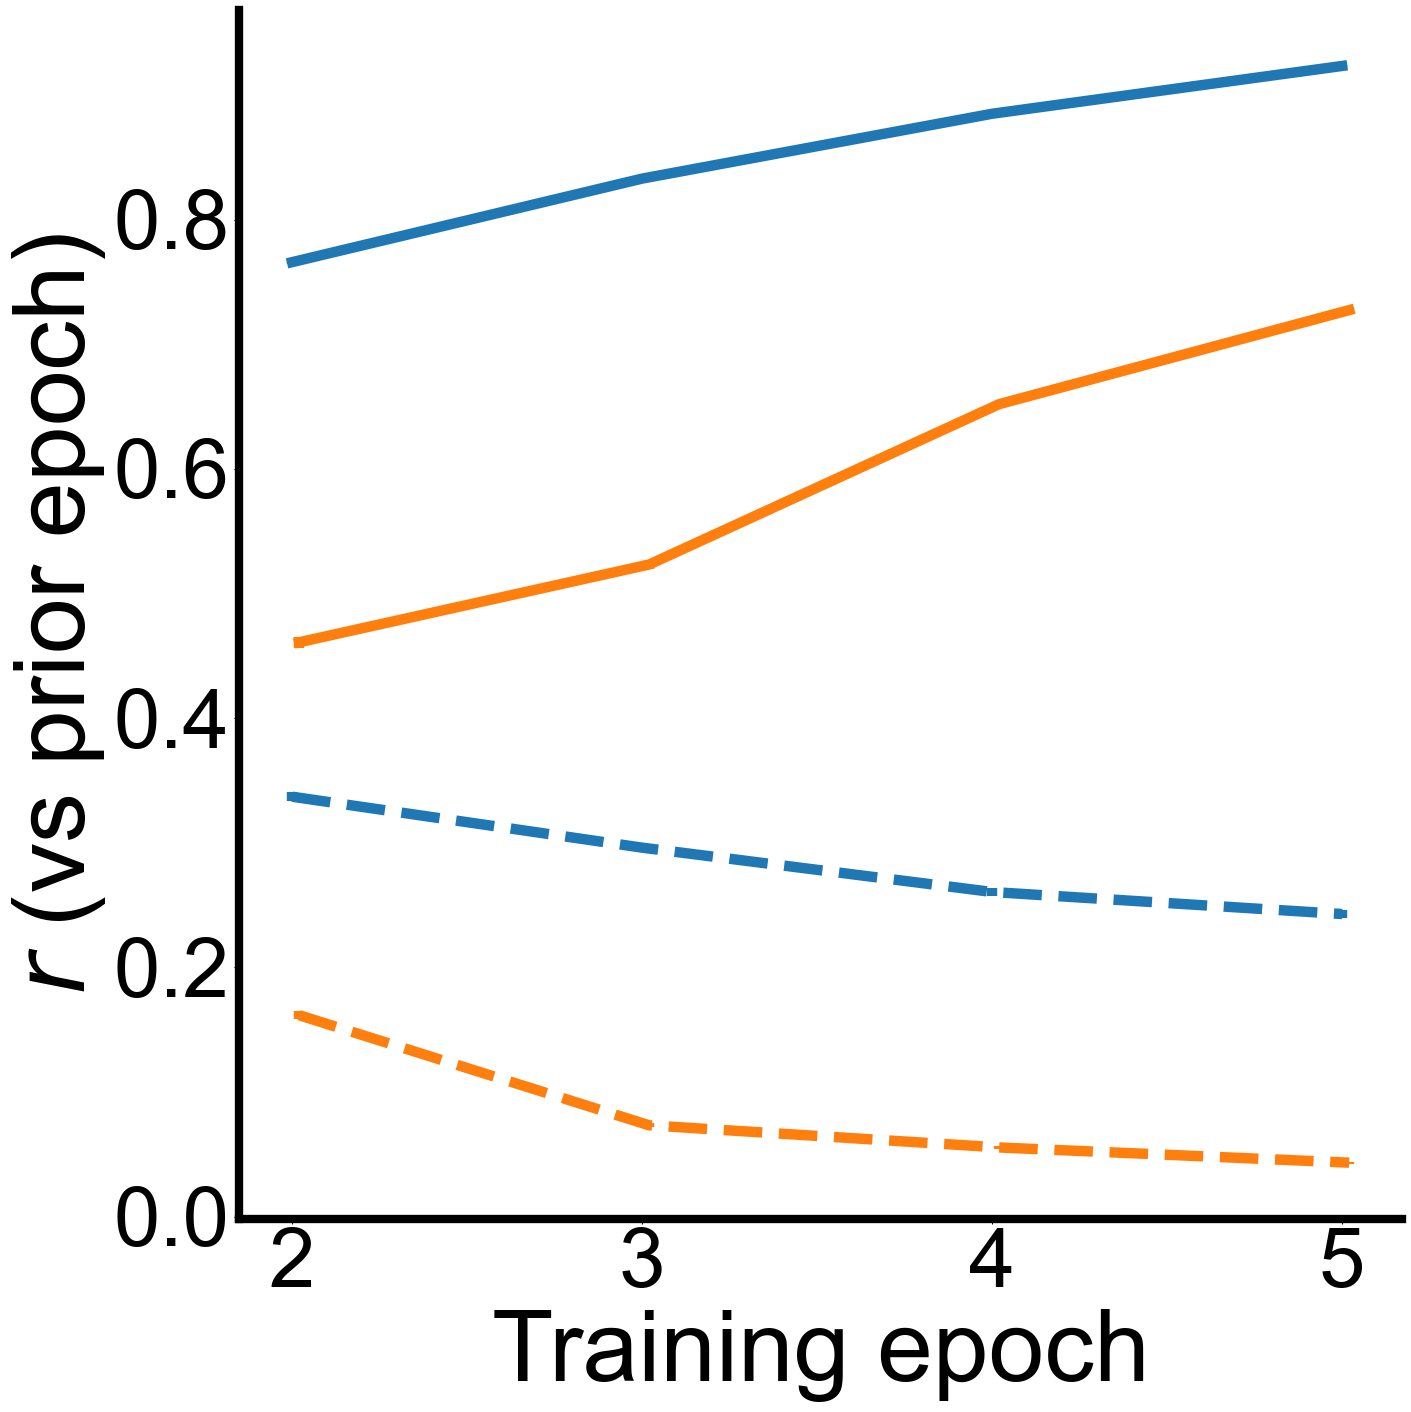

In [58]:
#plot output from reps analysis in Go code
startpt=1
if curr_or_prev==1:
    startpt=0
xax=np.arange(startpt,maxepcs)+1 #start at 1 otherwise
f,ax=plt.subplots(1,1)
cmapz = plt.get_cmap("viridis")
if allsp==0:
    cmapz = plt.get_cmap("tab10")
for e in range(len(fjobs)):
    ln=tlls[e]
    offs=e*0.02
    cmn=11+e*22
    if allsp==0:
        cmn=e+0
    plt.plot(xax+offs,same_lastepc_m[e,startpt:],label=ln,linestyle='-',color=cmapz(cmn))#1:
for e in range(len(fjobs)):
    offs=e*0.02
    cmn=11+e*22
    if allsp==0:
        cmn=e+0
    plt.errorbar(xax+offs,same_lastepc_m[e,startpt:],same_lastepc_s[e,startpt:], #same
                 linewidth=lw*2.5,elinewidth=lw*2.5,color=cmapz(cmn),linestyle='-')
    if allsp!=10:
        plt.errorbar(xax+offs,diff_lastepc_m[e,startpt:],diff_lastepc_s[e,startpt:], #diff
                     linewidth=lw*2.5,elinewidth=lw*2.5,color=cmapz(cmn),linestyle='--')
    print(diff_lastepc_m[e,-1])
ax.set_xlabel("Training epoch",fontsize=cfs*7)
ax.set_ylabel('$\it{r}$ (vs prior epoch)',fontsize=cfs*7)
ax.tick_params(labelsize=cfs*4)
if allsp==0:
    ax.set_xlabel("Training epoch",fontsize=cfs*6)
    ax.set_ylabel('$\it{r}$ (vs prior epoch)',fontsize=cfs*6)
    ax.tick_params(labelsize=cfs*5)
if curr_or_prev==1:
    ax.set_ylabel('$\it{r}$',fontsize=cfs*7) # (vs prior epoch)
    ax.set_ylim([0,0.2])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
if allsp==0:
    f.tight_layout()
f.tight_layout()
f.savefig('figs/RepsAnalysis-nolegend-%s-%s-%s-%s.pdf' %(fjobs[0],fjobs[-1],lays[tlay],curr_or_prev), transparent=True)

0.24276234519641662
0.04322036380336069


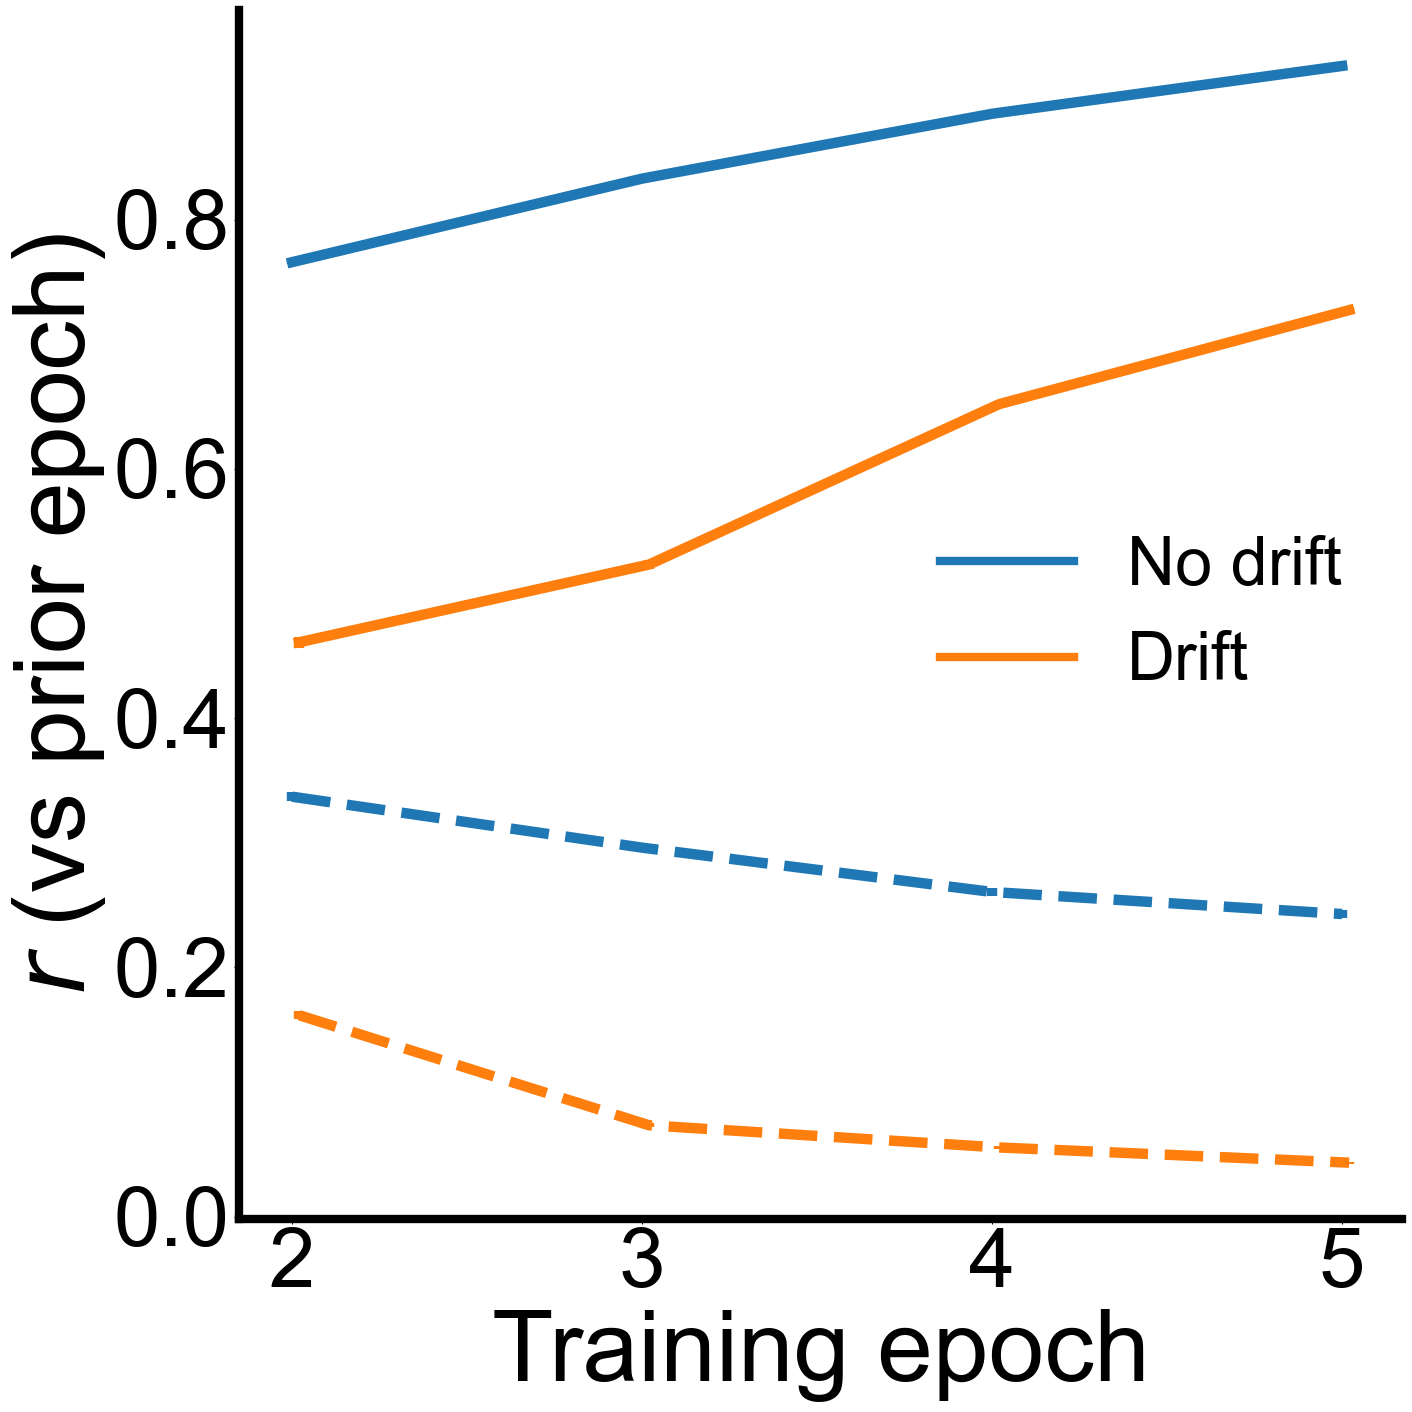

In [59]:
f,ax=plt.subplots(1,1)
cmapz = plt.get_cmap("viridis")
if allsp==0:
    cmapz = plt.get_cmap("tab10")
for e in range(len(fjobs)):
    ln=tlls[e]
    offs=e*0.02
    cmn=11+e*22
    if allsp==0:
        cmn=e+0
    plt.plot(xax+offs,same_lastepc_m[e,startpt:],label=ln,linestyle='-',color=cmapz(cmn))#1:
if allsp==1:
    box = ax.get_position()
    ax.set_position([box.x0+0.01, box.y0, box.width * 0.69, box.height])
    leg=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False,fontsize=cfs*3.5)
elif allsp==10:
    leg=plt.legend(loc='center right',frameon=False,fontsize=cfs*5)
else:
    leg=plt.legend(loc='center right',frameon=False,fontsize=cfs*4)
for line in leg.get_lines():
    line.set_linewidth(6)
for e in range(len(fjobs)):
    offs=e*0.02
    cmn=11+e*22
    if allsp==0:
        cmn=e+0
    plt.errorbar(xax+offs,same_lastepc_m[e,startpt:],same_lastepc_s[e,startpt:],
                 linewidth=lw*2.5,elinewidth=lw*2.5,color=cmapz(cmn),linestyle='-')
    if allsp!=10:
        plt.errorbar(xax+offs,diff_lastepc_m[e,startpt:],diff_lastepc_s[e,startpt:],
                     linewidth=lw*2.5,elinewidth=lw*2.5,color=cmapz(cmn),linestyle='--')
    print(diff_lastepc_m[e,-1])
ax.set_xlabel("Training epoch",fontsize=cfs*5)
ax.set_ylabel('$\it{r}$ (vs prior epoch)',fontsize=cfs*5)
ax.tick_params(labelsize=cfs*4)
if allsp==0:
    ax.set_xlabel("Training epoch",fontsize=cfs*6)
    ax.set_ylabel('$\it{r}$ (vs prior epoch)',fontsize=cfs*6)
    ax.tick_params(labelsize=cfs*5)
if curr_or_prev==1:
    ax.set_ylabel('$\it{r}$',fontsize=cfs*5) # (vs prior epoch)
    ax.set_ylim([0,0.2])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
if allsp==0:
    f.tight_layout()
f.savefig('figs/RepsAnalysis-%s-%s-%s-%s.pdf' %(fjobs[0],fjobs[-1],lays[tlay],curr_or_prev), transparent=True)

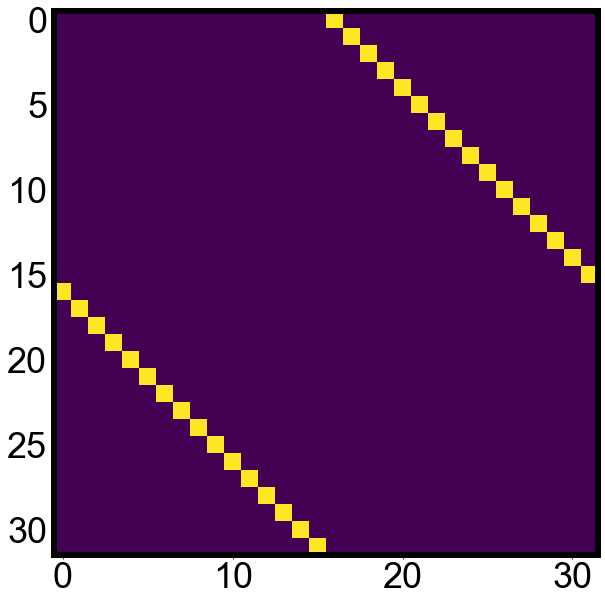

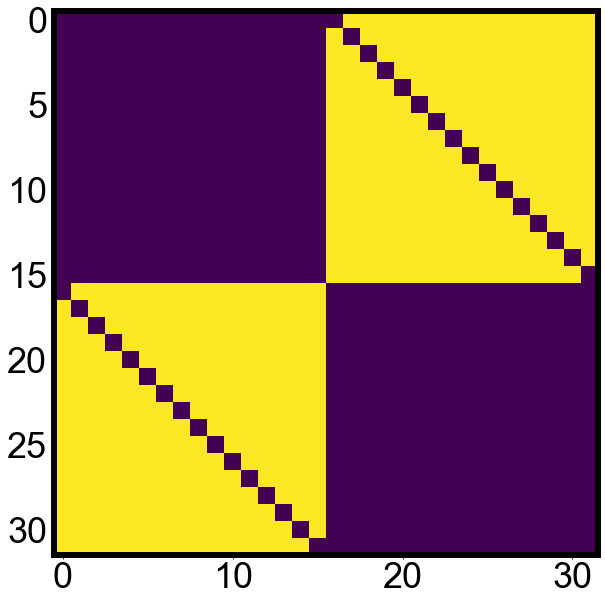

In [143]:
#sanity graphs, for plotting
same_mat,diff_mat=np.zeros((llength*2,llength*2)),np.zeros((llength*2,llength*2))
for h in range(maxepcs):
    for i in range(llength*2):
        for j in range(llength*2):
            if np.absolute(i-j)==llength: #same
                same_mat[i,j]=1
            proc=0
            if np.logical_and(i>=llength,j<llength):
                if np.absolute(i-j)!=llength:
                    proc=1
            elif np.logical_and(i<llength,j>=llength):
                if np.absolute(i-j)!=llength:
                    proc=1
            if proc:
                diff_mat[i,j]=1
f,ax=plt.subplots(1,1,figsize=(fss,fss))
im=ax.imshow(same_mat,interpolation='none',cmap=cm2)
f,ax=plt.subplots(1,1,figsize=(fss,fss))
im=ax.imshow(diff_mat,interpolation='none',cmap=cm2)

# 4 - Analyze connection weights to show temporal abstraction - Fig 9

In [88]:
def readcols(dat): #reading in weight data
    i,outz=0,np.zeros((npools))
    #for (columnName, columnData) in dat.iteritems(): #cycle through columns
    for (columnName, columnData) in dat.items(): #cycle through columns
        if i==0:
            fill=columnName[1:] #load, remove initial '['
        else:
            fill=columnName[:8] #load
        outz[i]=float(fill)
        i+=1
    return outz
def wtplot(dat,tn,vm,fn,fnpt): #plot weight data
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fss*3,fss))
    im=ax.imshow(np.mean(dat,axis=0),interpolation='none',cmap=cm2,vmin=vm[0],vmax=vm[1])
    ax.set_ylabel("Training epoch")
    ax.set_xlabel("Pool")
    ax.set_xticks(xtl)
    ax.set_xticklabels(poolls, rotation = rf,fontsize=cfs*4)
    ax.set_yticklabels([0,1,3,5],fontsize=cfs*3)#np.arange(maxepcs+1)-1
    f.subplots_adjust(right=0.75)
    cbar_ax = f.add_axes([0.8, 0.15, 0.05, 0.7])
    cbar=f.colorbar(im,cax=cbar_ax)
    cbar.set_label(tn)
    cbar.ax.tick_params(labelsize=cfs*3) 
    plt.show()
    if fnpt: #print
        f.savefig('figs/' + fn + '.pdf', transparent=True)
    ax.set_title(tn,fontsize=cfs*3)

def diffplot(dat,yl,ytix,fn,legloc,fnpt):
    ntpools=8 #number temporal pools
    offset=npools-ntpools
    if dat.shape[0]>2:
        f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fss*1.5,fss))
    else:
        f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fss*1.5,fss))
    datdiffs_a=np.zeros((dat.shape[0]-1,dat.shape[1],ntpools))
    dat2=dat[0,:,:,:]
    for ii in range(dat.shape[0]-1): #cycle through all non-No Drift pools
        cmapz = plt.get_cmap("viridis")
        cmn=11+22+ii*22 #add extra 22 to account for starting NOT with No Drift pool
        ln=tlls[ii+1]
        errs=np.zeros((ntpools))
        dat1=dat[ii+1,:,:,:] #current Drift pool
        for i in range(ntpools):
            errs[i]=np.std(dat1[:,-1,offset+i]-dat2[:,-1,offset+i])
        datdiffs=np.mean(dat1[:,-1,offset:],axis=0)-np.mean(dat2[:,-1,offset:],axis=0)
        plt.errorbar(np.arange(ntpools)+1,datdiffs,errs,linewidth=lw,elinewidth=lw,label=ln,color=cmapz(cmn))
        datdiffs_a[ii,:,:]=dat1[:,-1,offset:]-dat2[:,-1,offset:]

    plt.hlines(0,0.5,ntpools+0.5,linestyles='dotted')
    ax.set_ylim([ytix[0],ytix[2]])
    ax.set_yticks(ytix)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if dat.shape[0]>2:
        ax.set_ylabel(yl,fontsize=cfs*4)#
        ax.set_xlabel("Temporal pool",fontsize=cfs*4)
        ax.tick_params(axis="x", labelsize=cfs*3)
        ax.tick_params(axis="y", labelsize=cfs*3)
        leg=plt.legend(ncol=3,loc=legloc,frameon=False,fontsize=cfs*2.7)
        for line in leg.get_lines():
            line.set_linewidth(6)
    else:
        ax.set_ylabel(yl,fontsize=cfs*4)#
        ax.set_xlabel("Temporal pool",fontsize=cfs*4)
        ax.tick_params(axis="x", labelsize=cfs*4)
        ax.tick_params(axis="y", labelsize=cfs*4)
    f.tight_layout()
    if fnpt: #print
        f.savefig('figs/' + fn + '.pdf', transparent=True)
    return datdiffs_a

# fjobs: 11


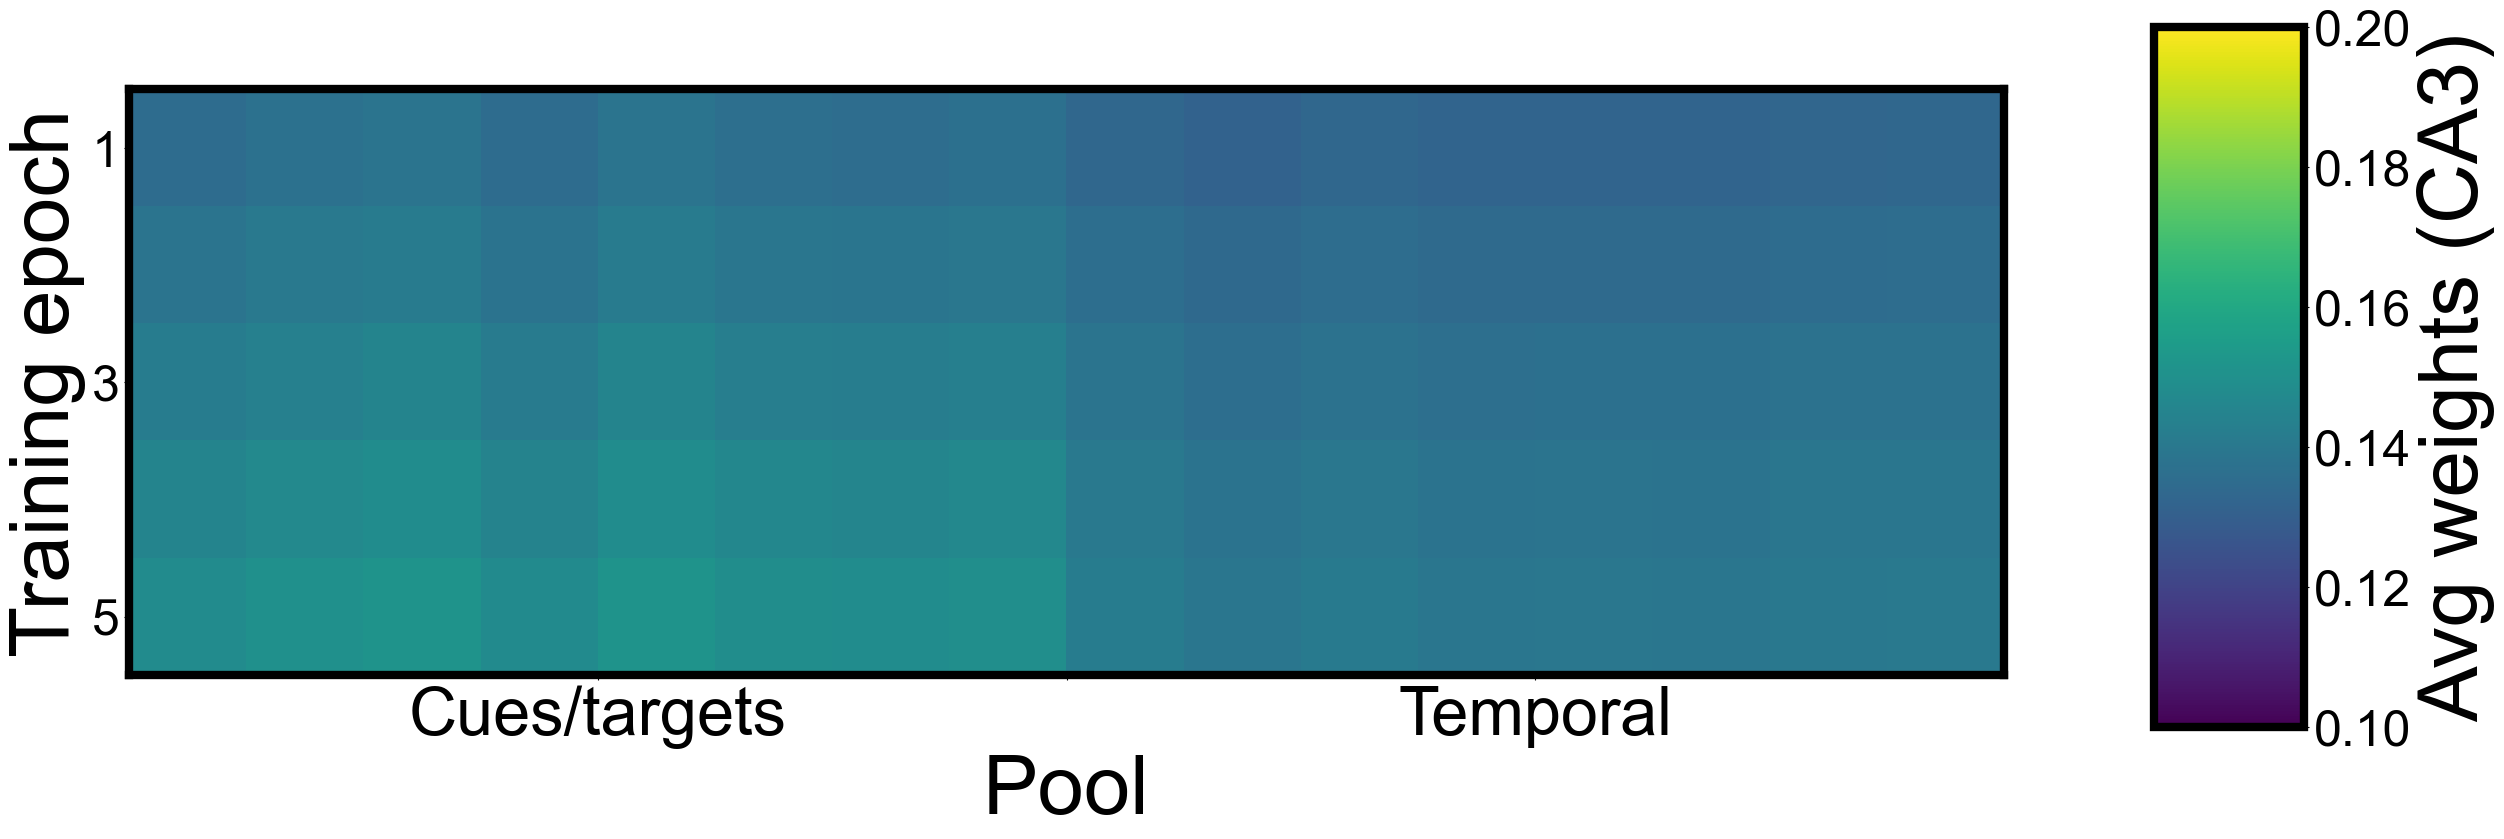

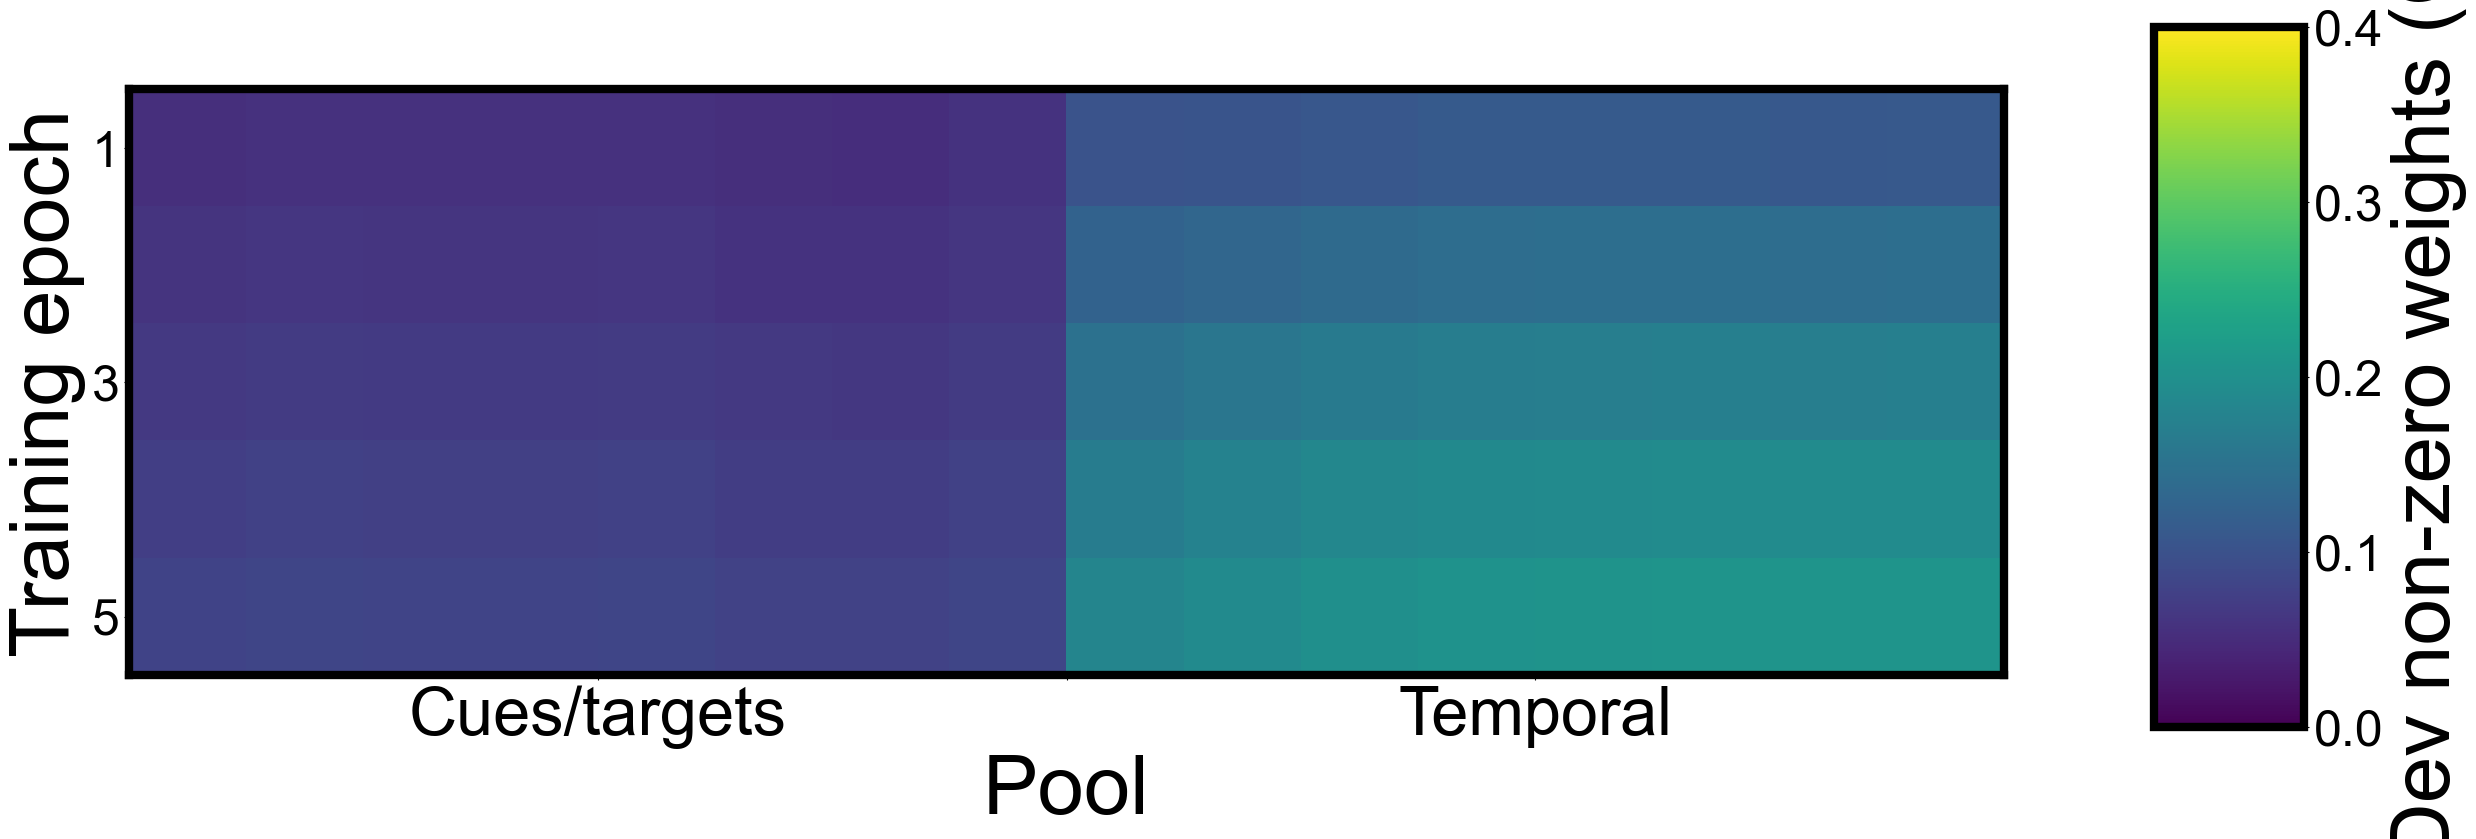

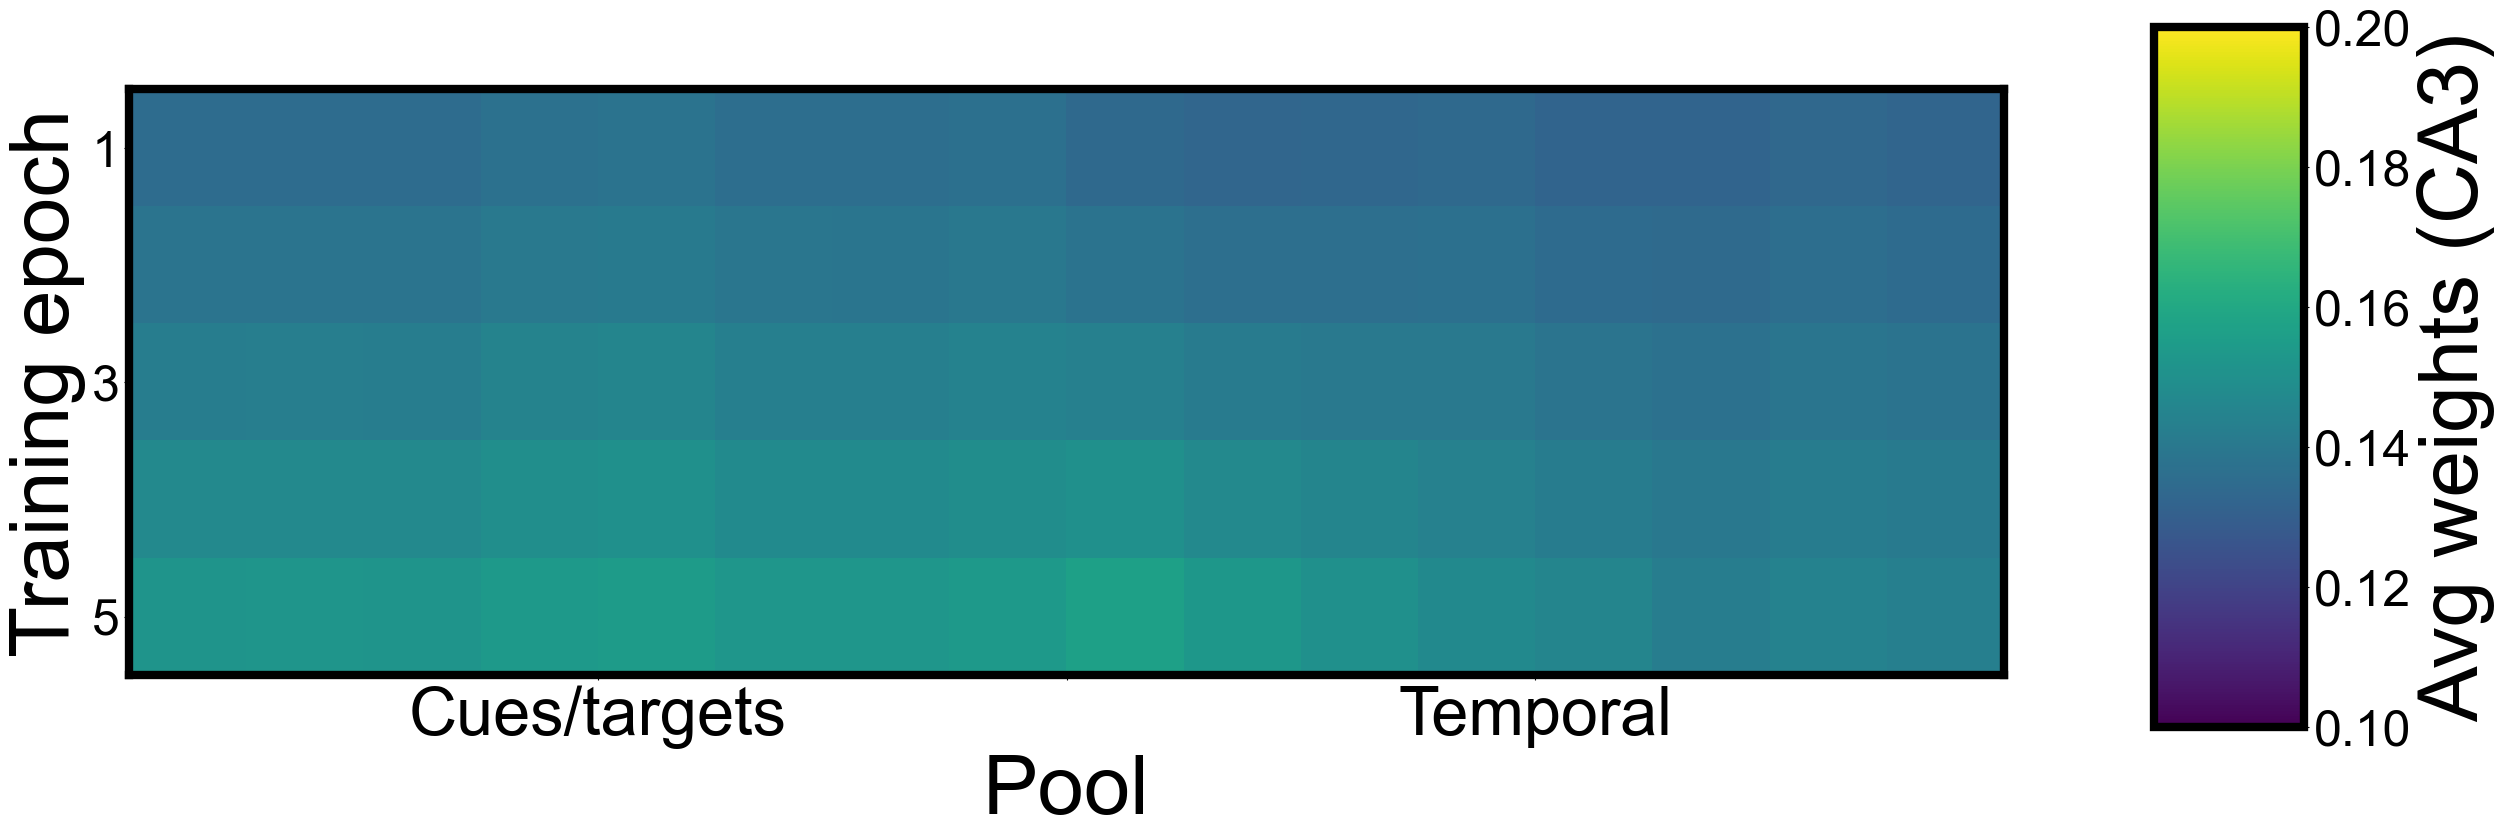

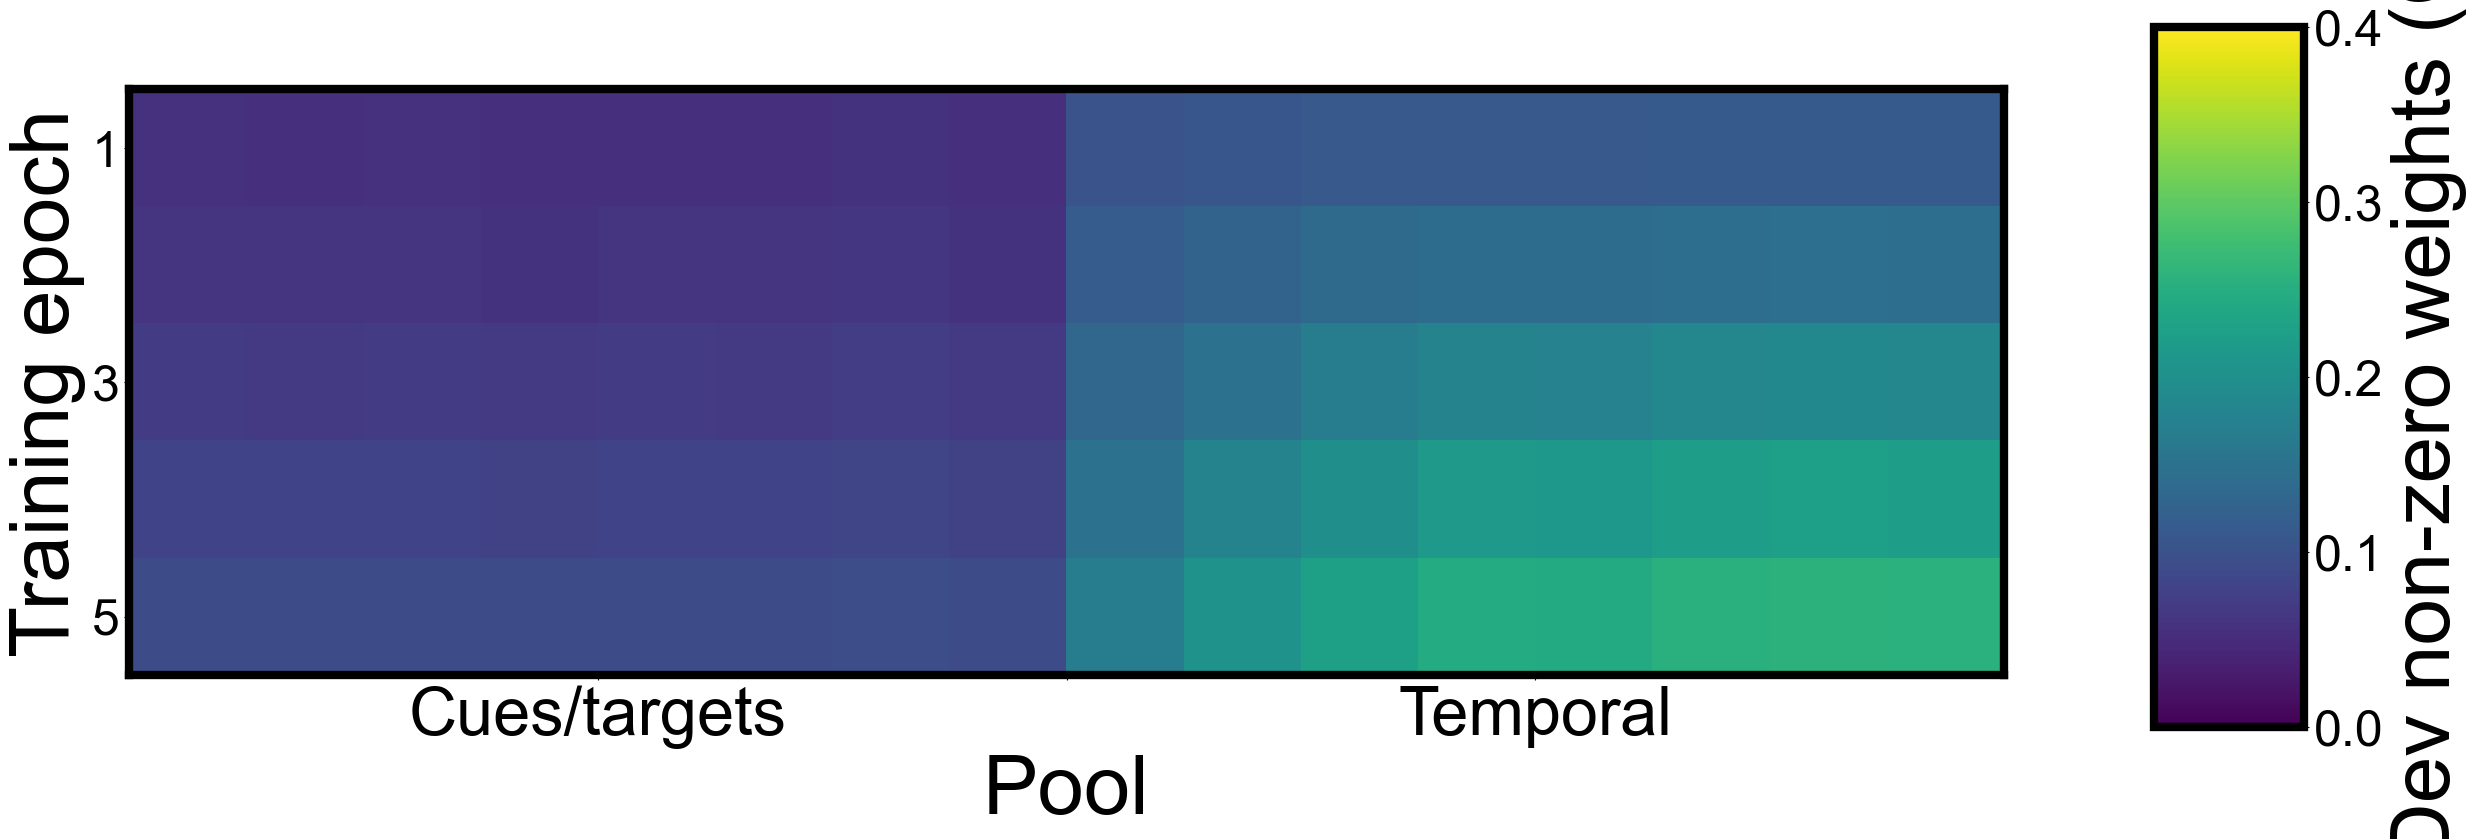

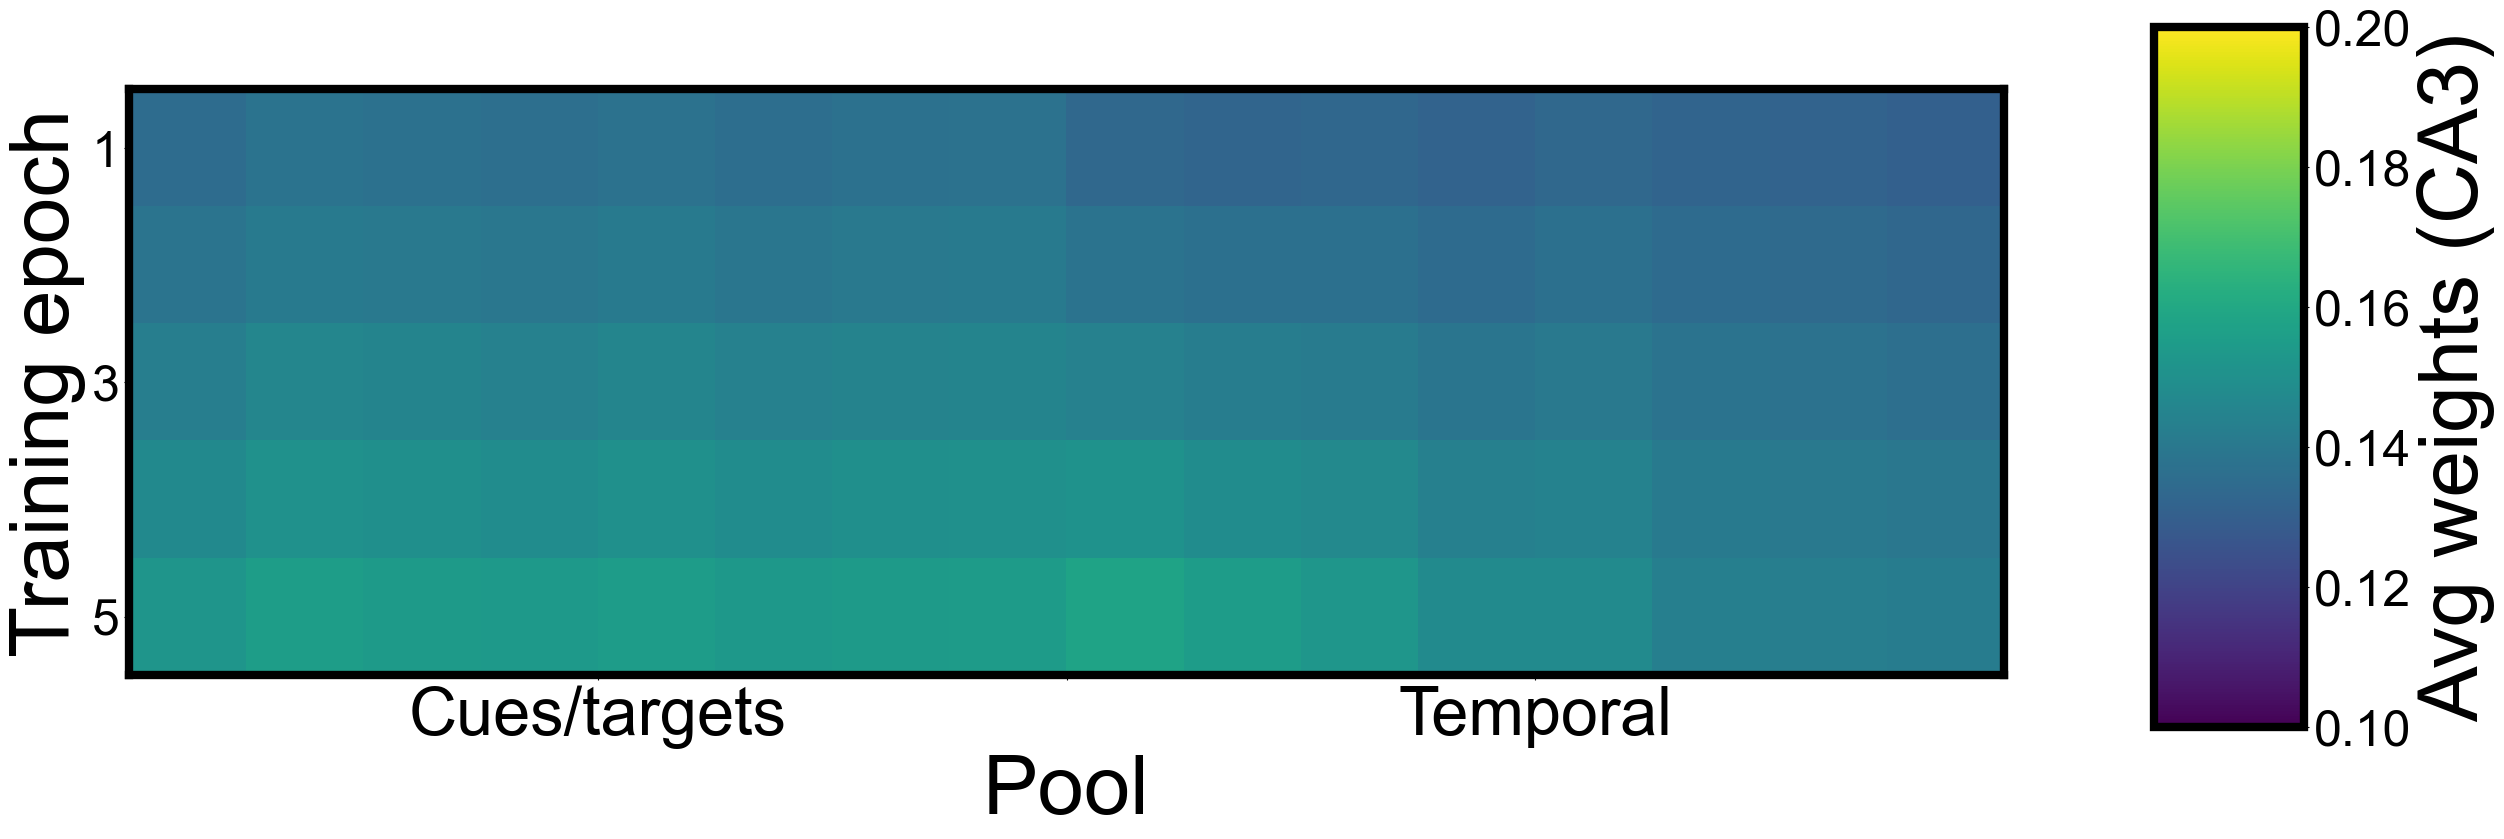

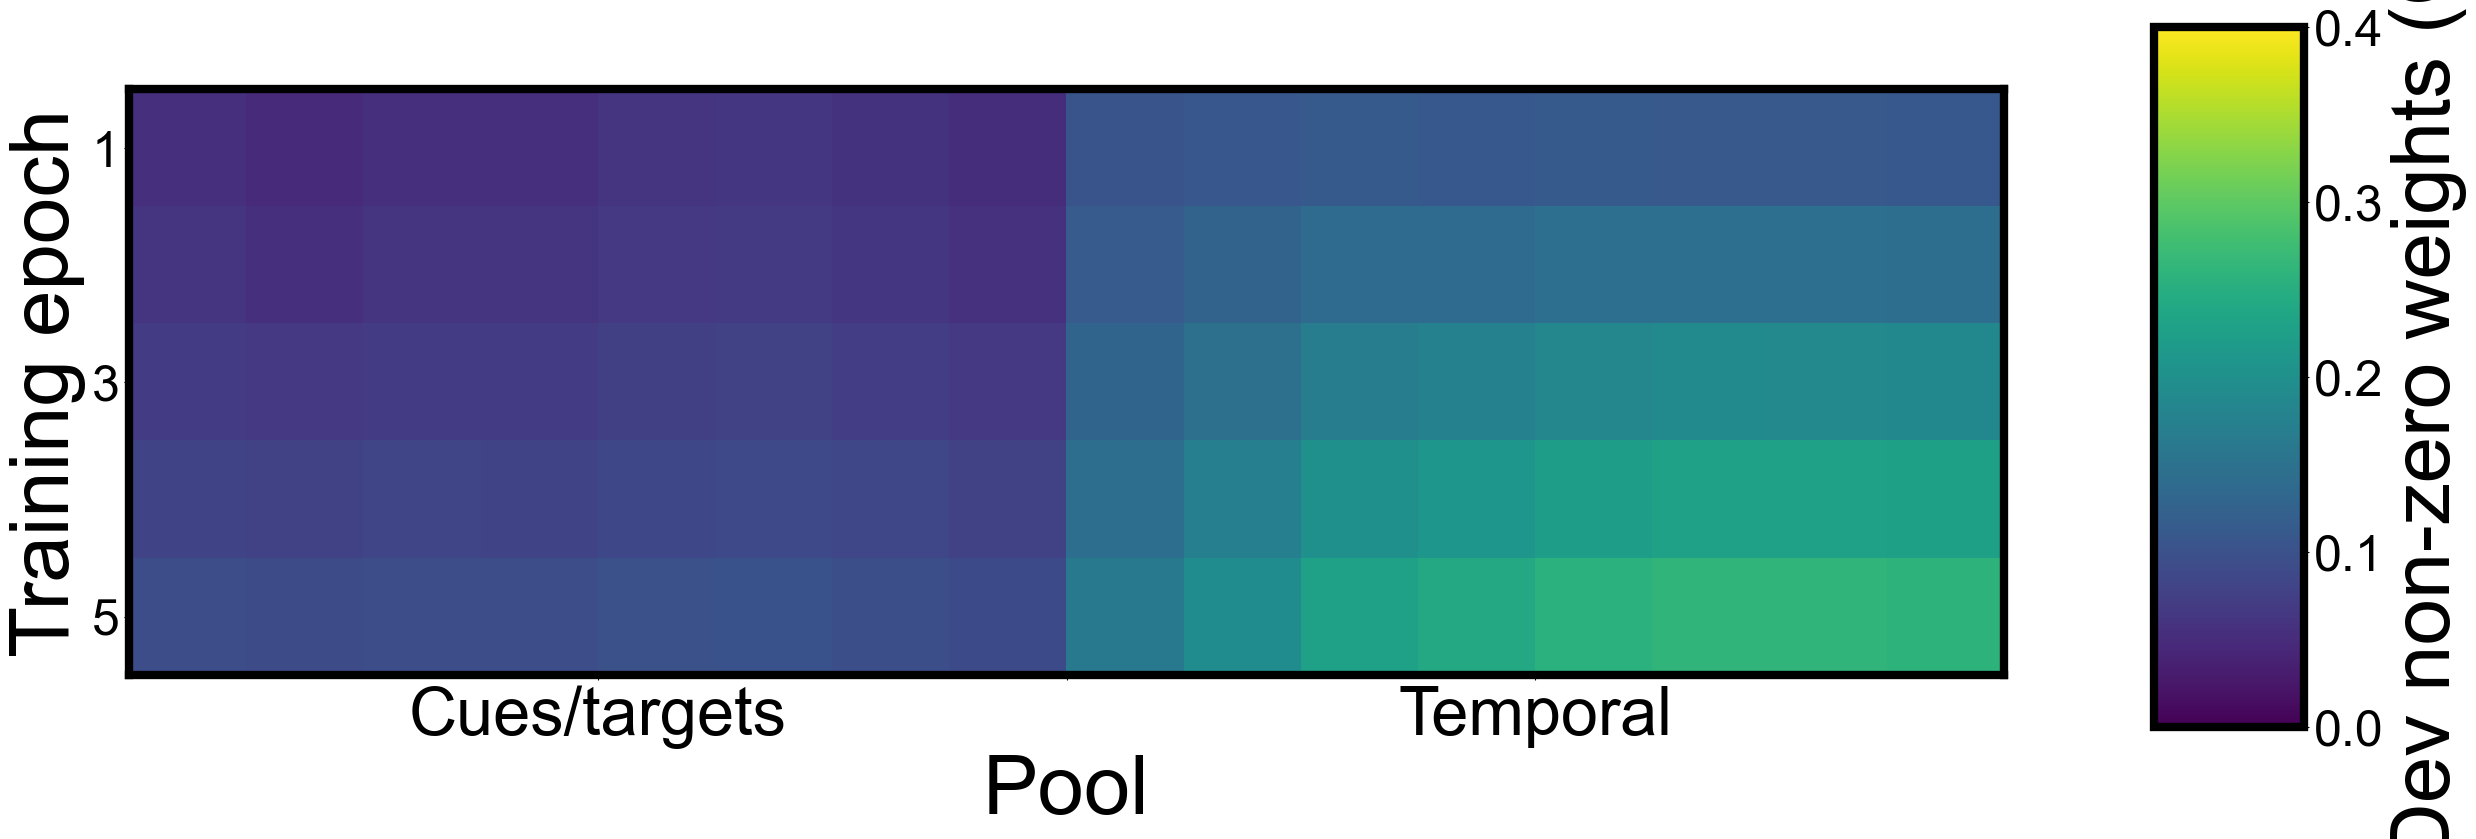

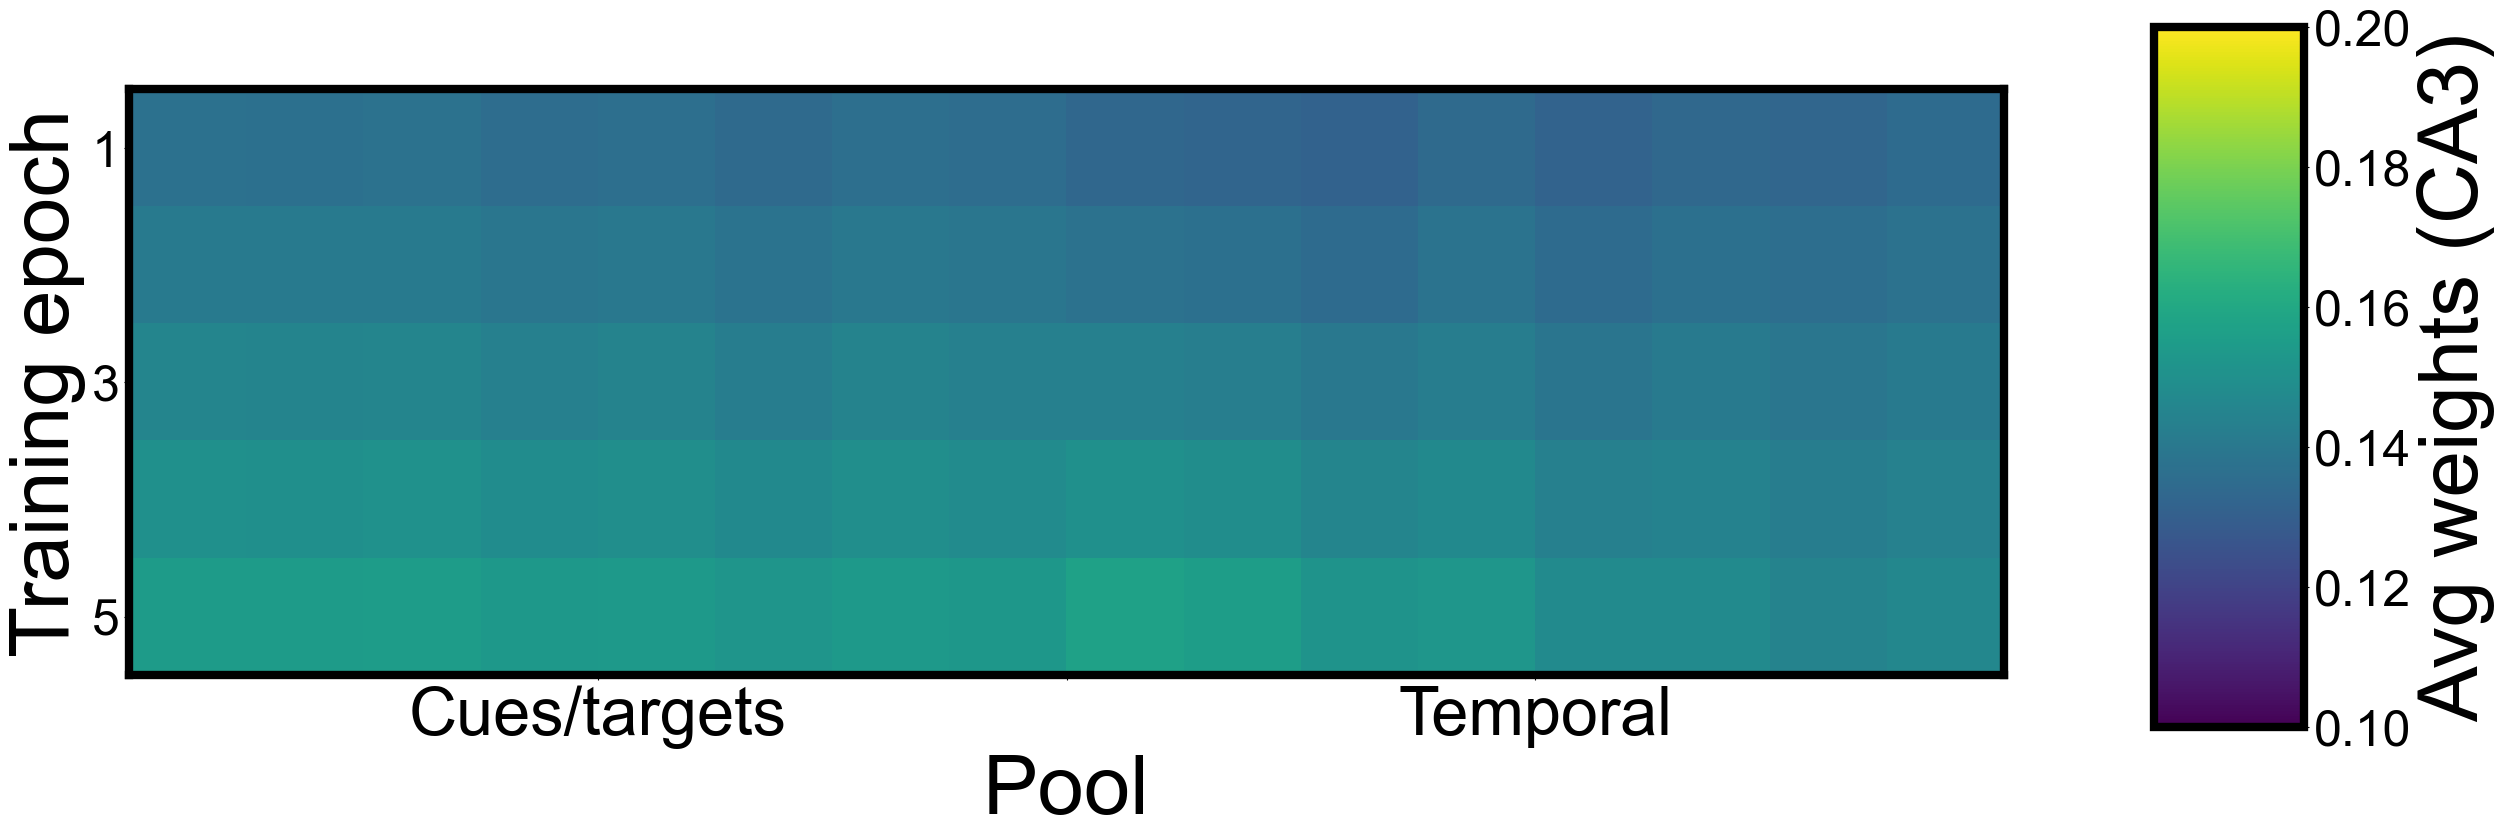

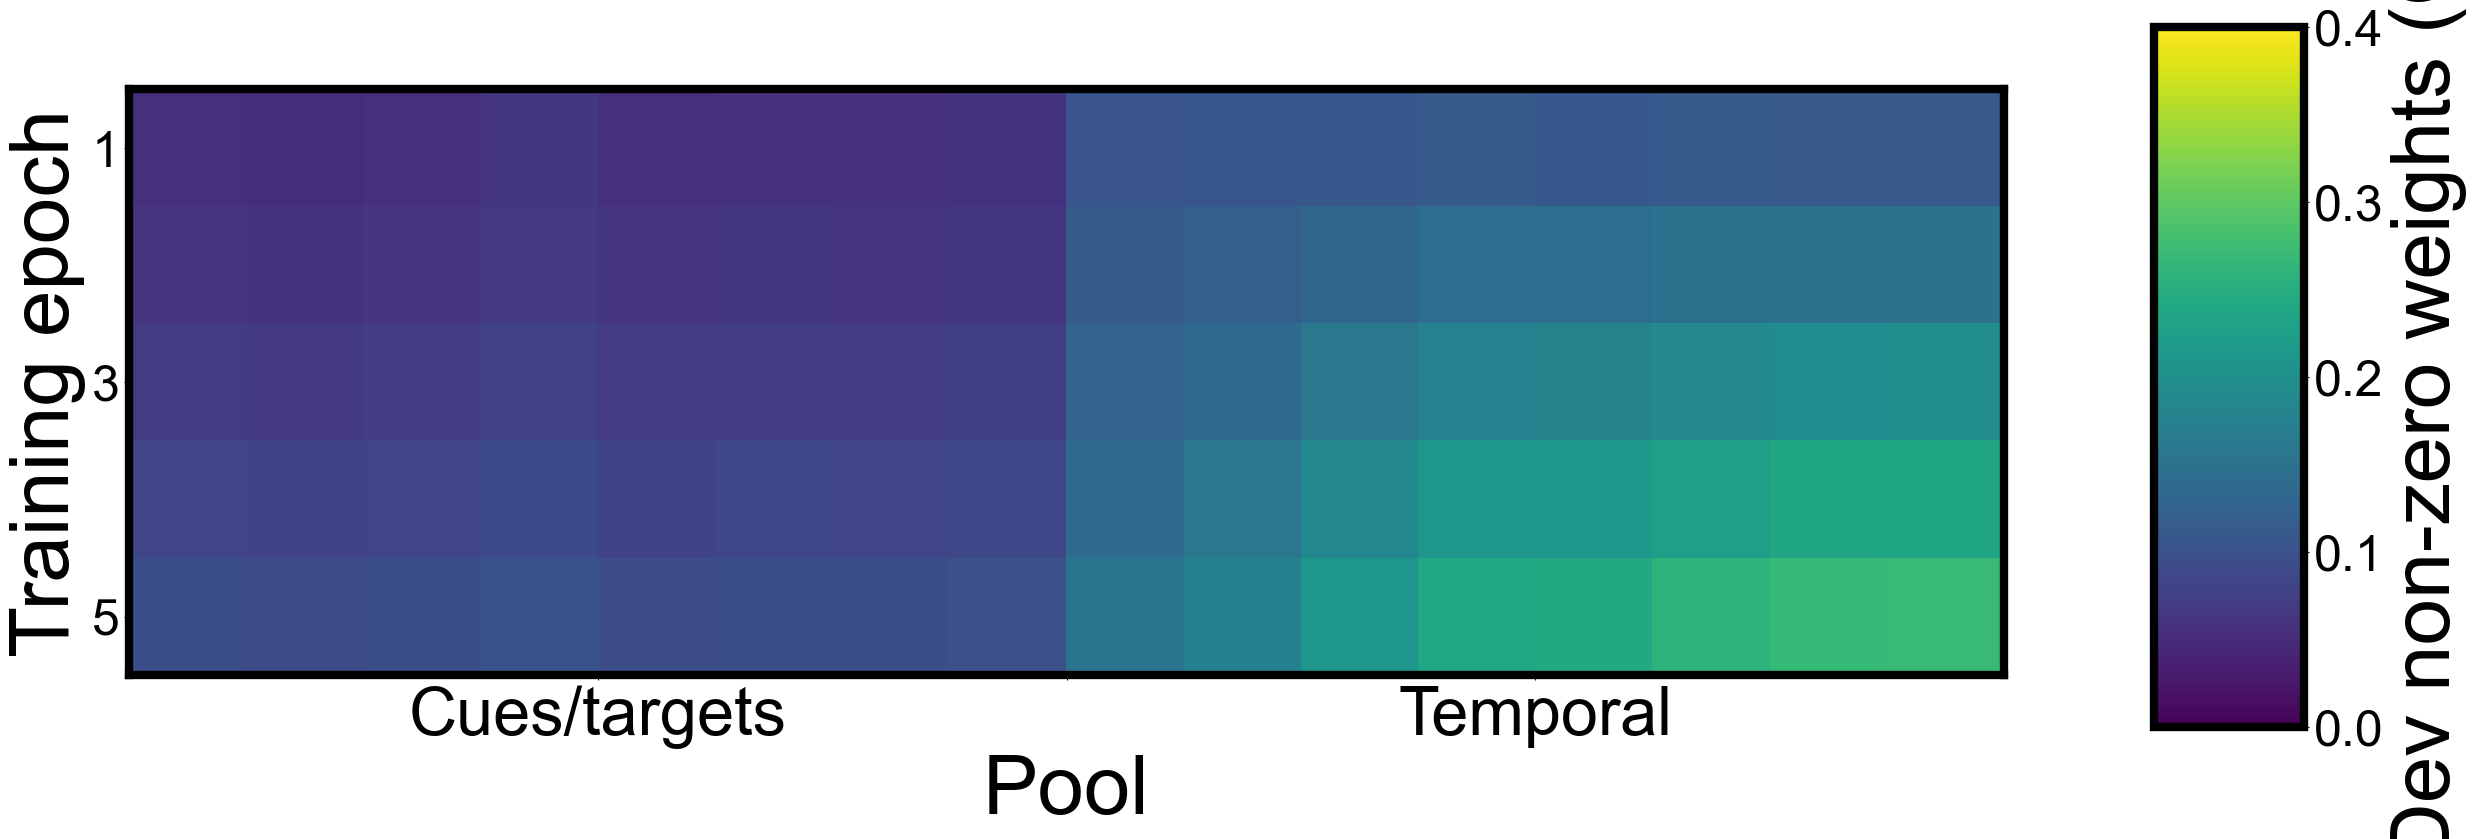

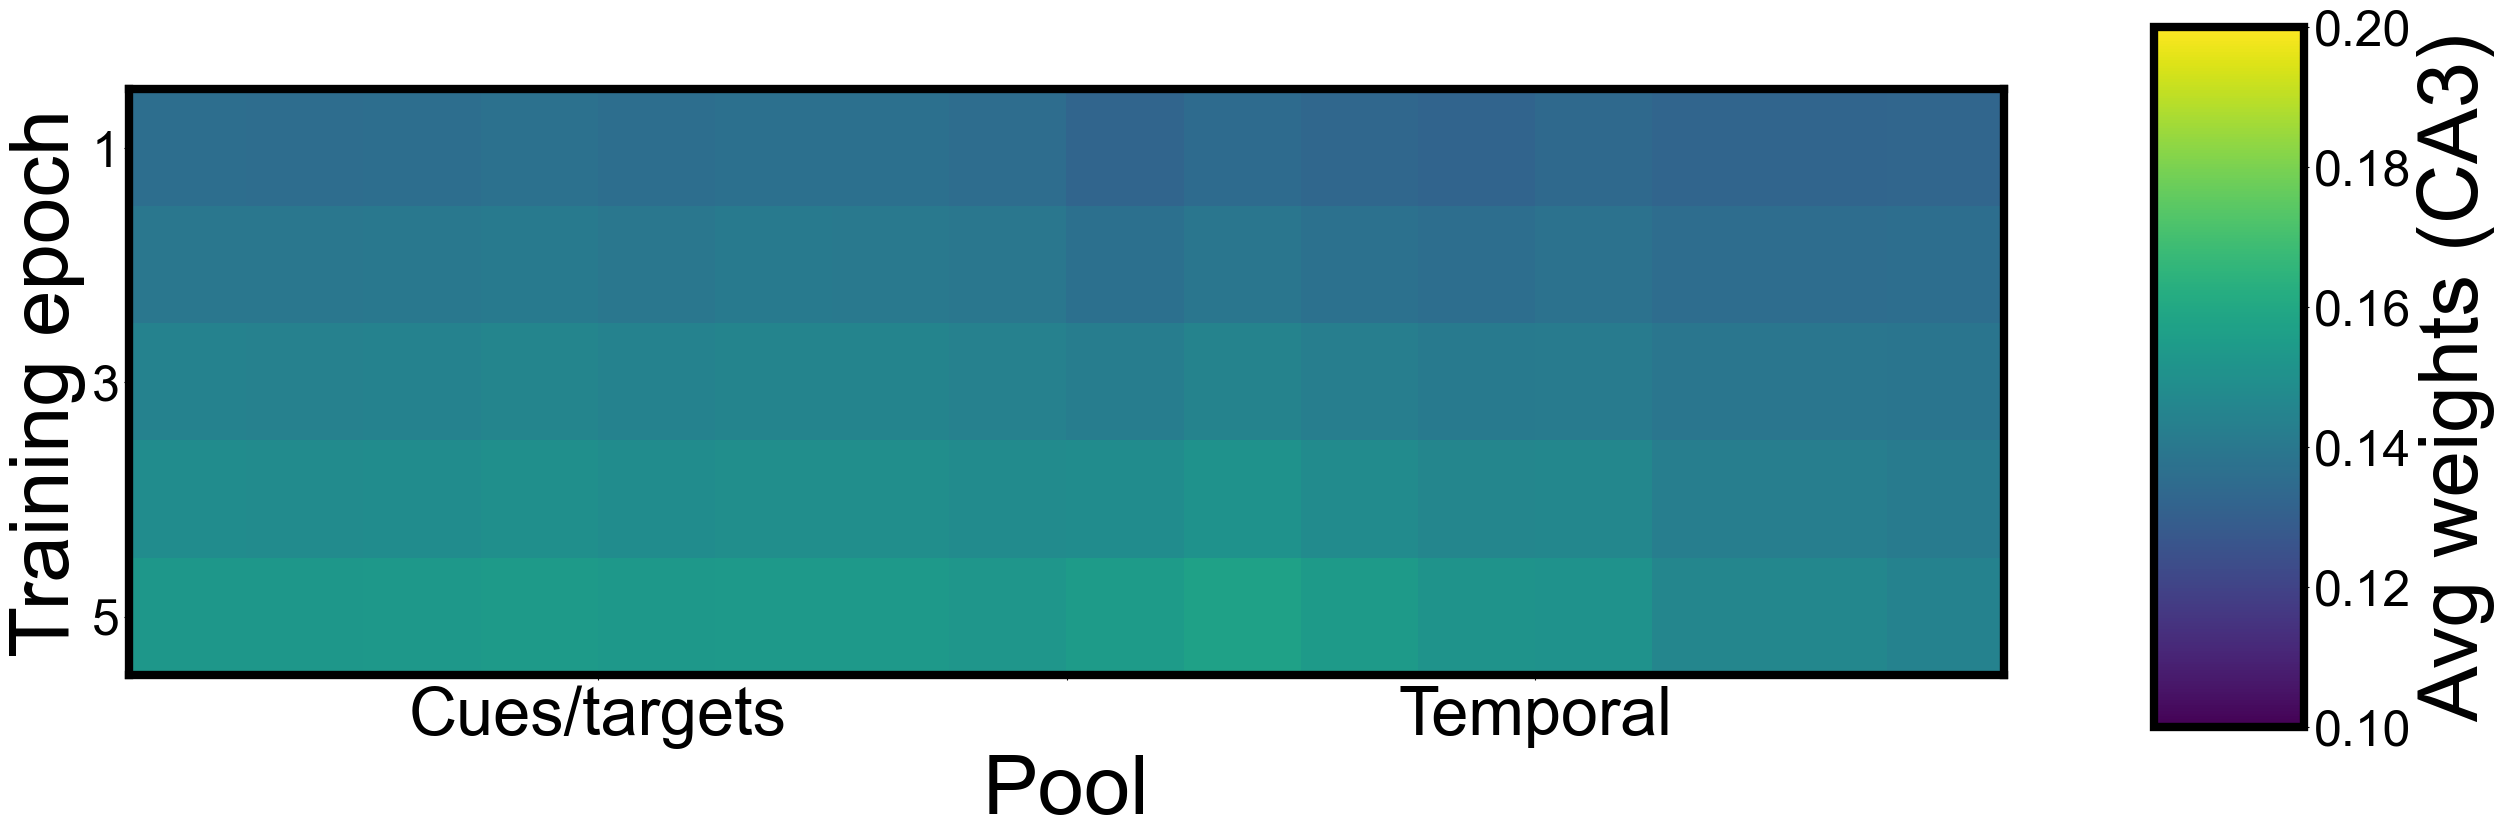

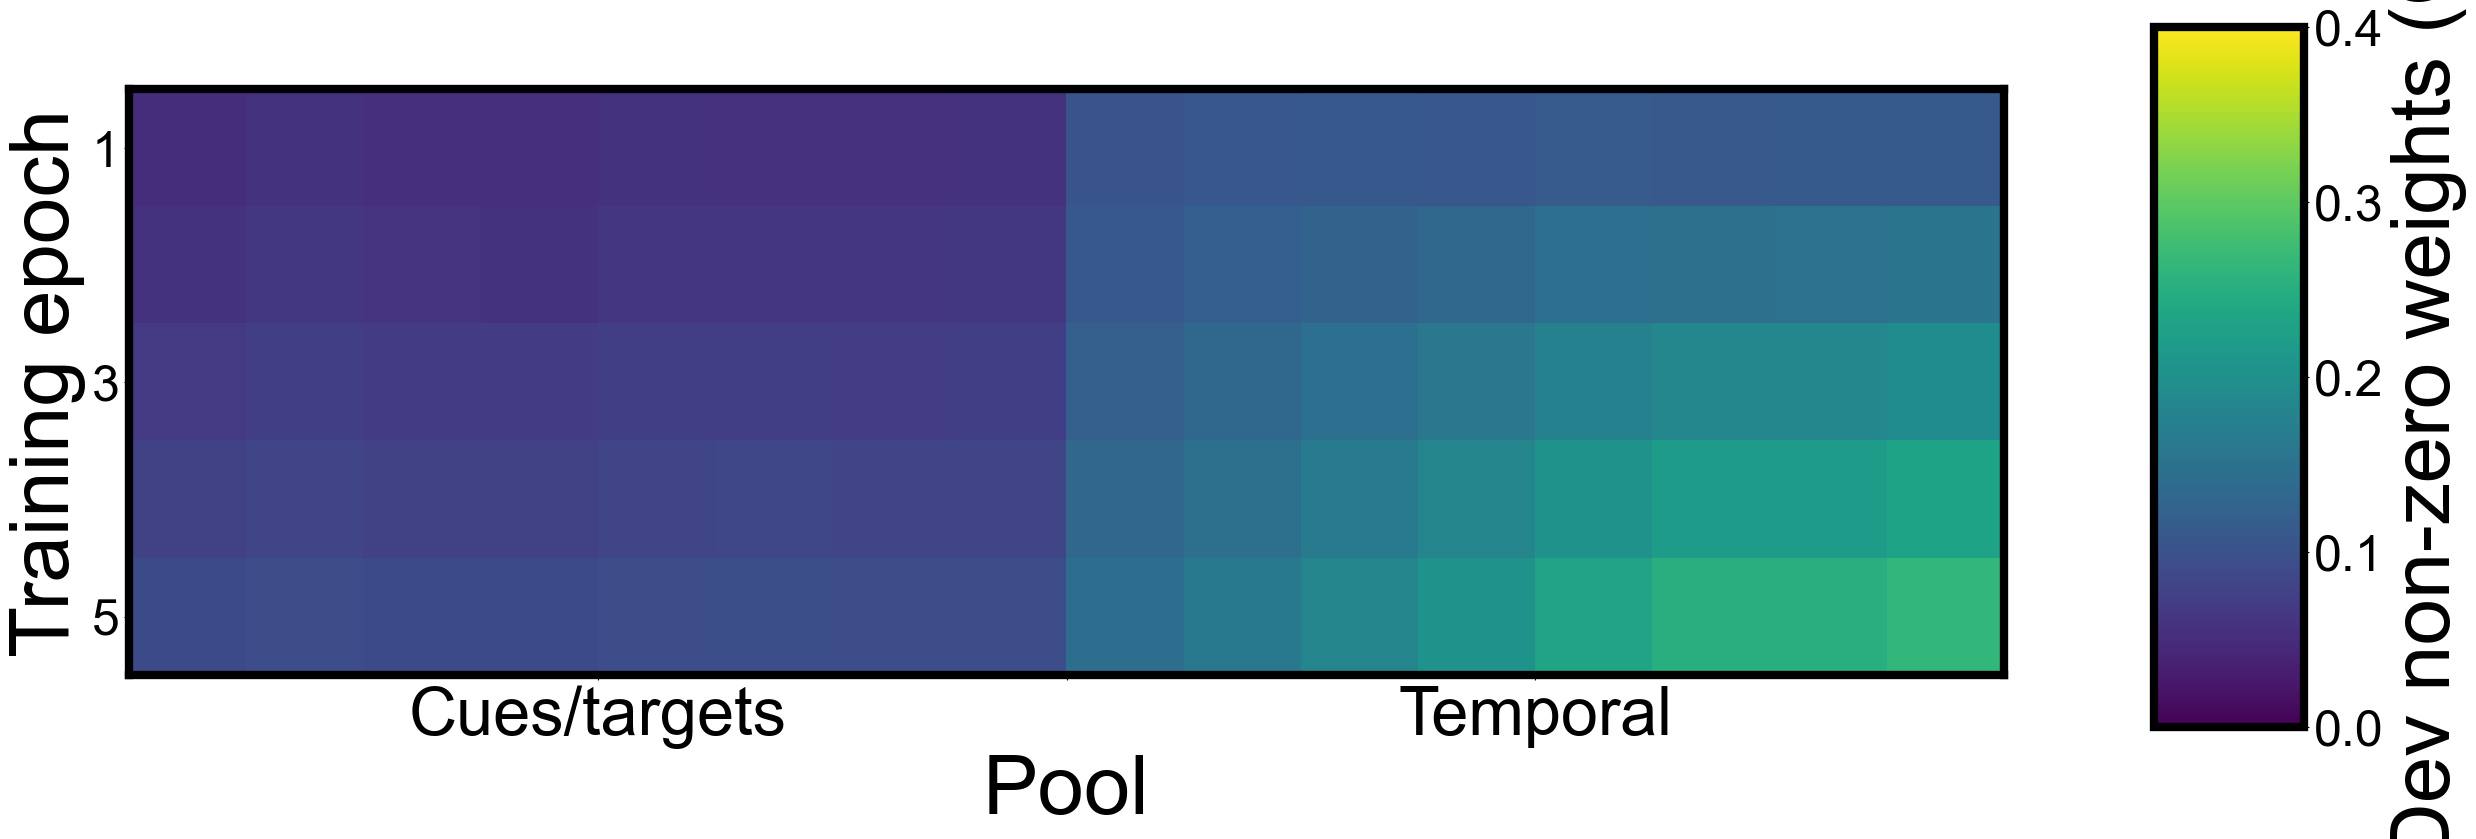

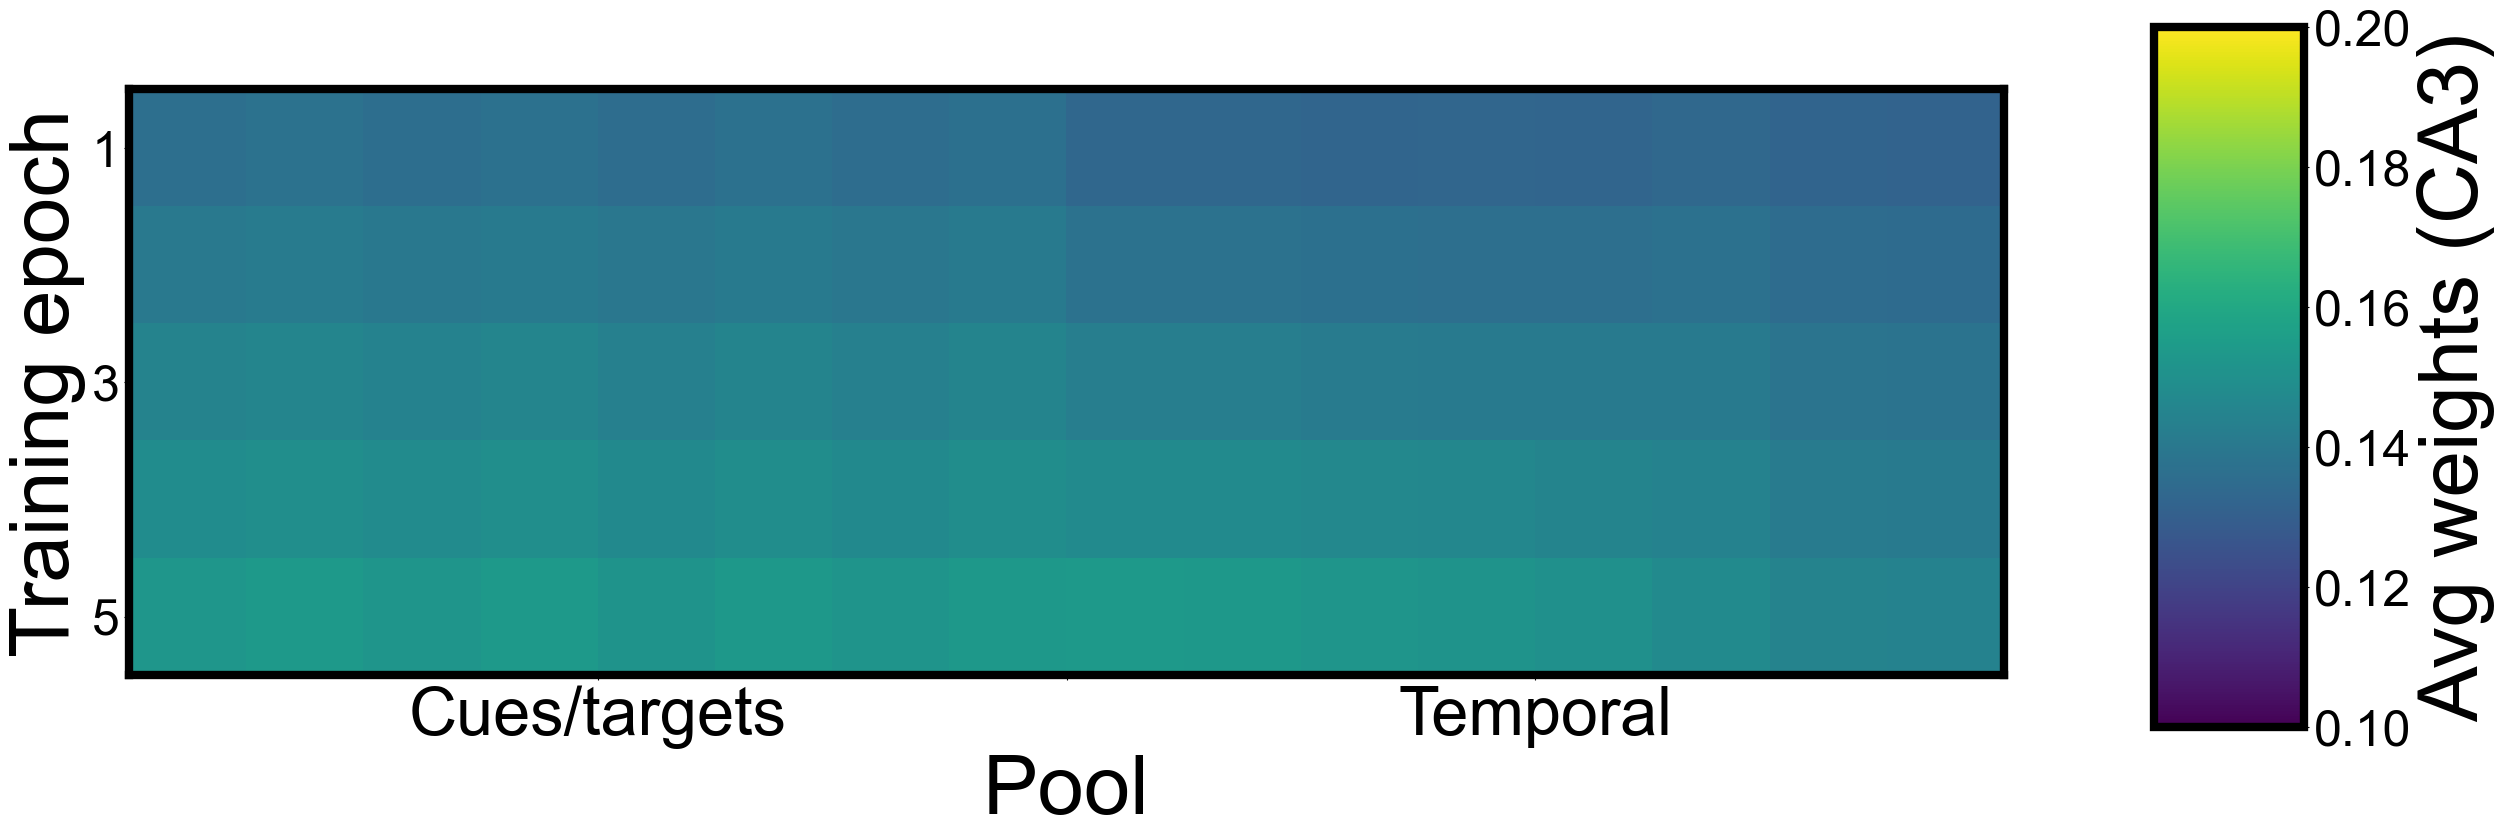

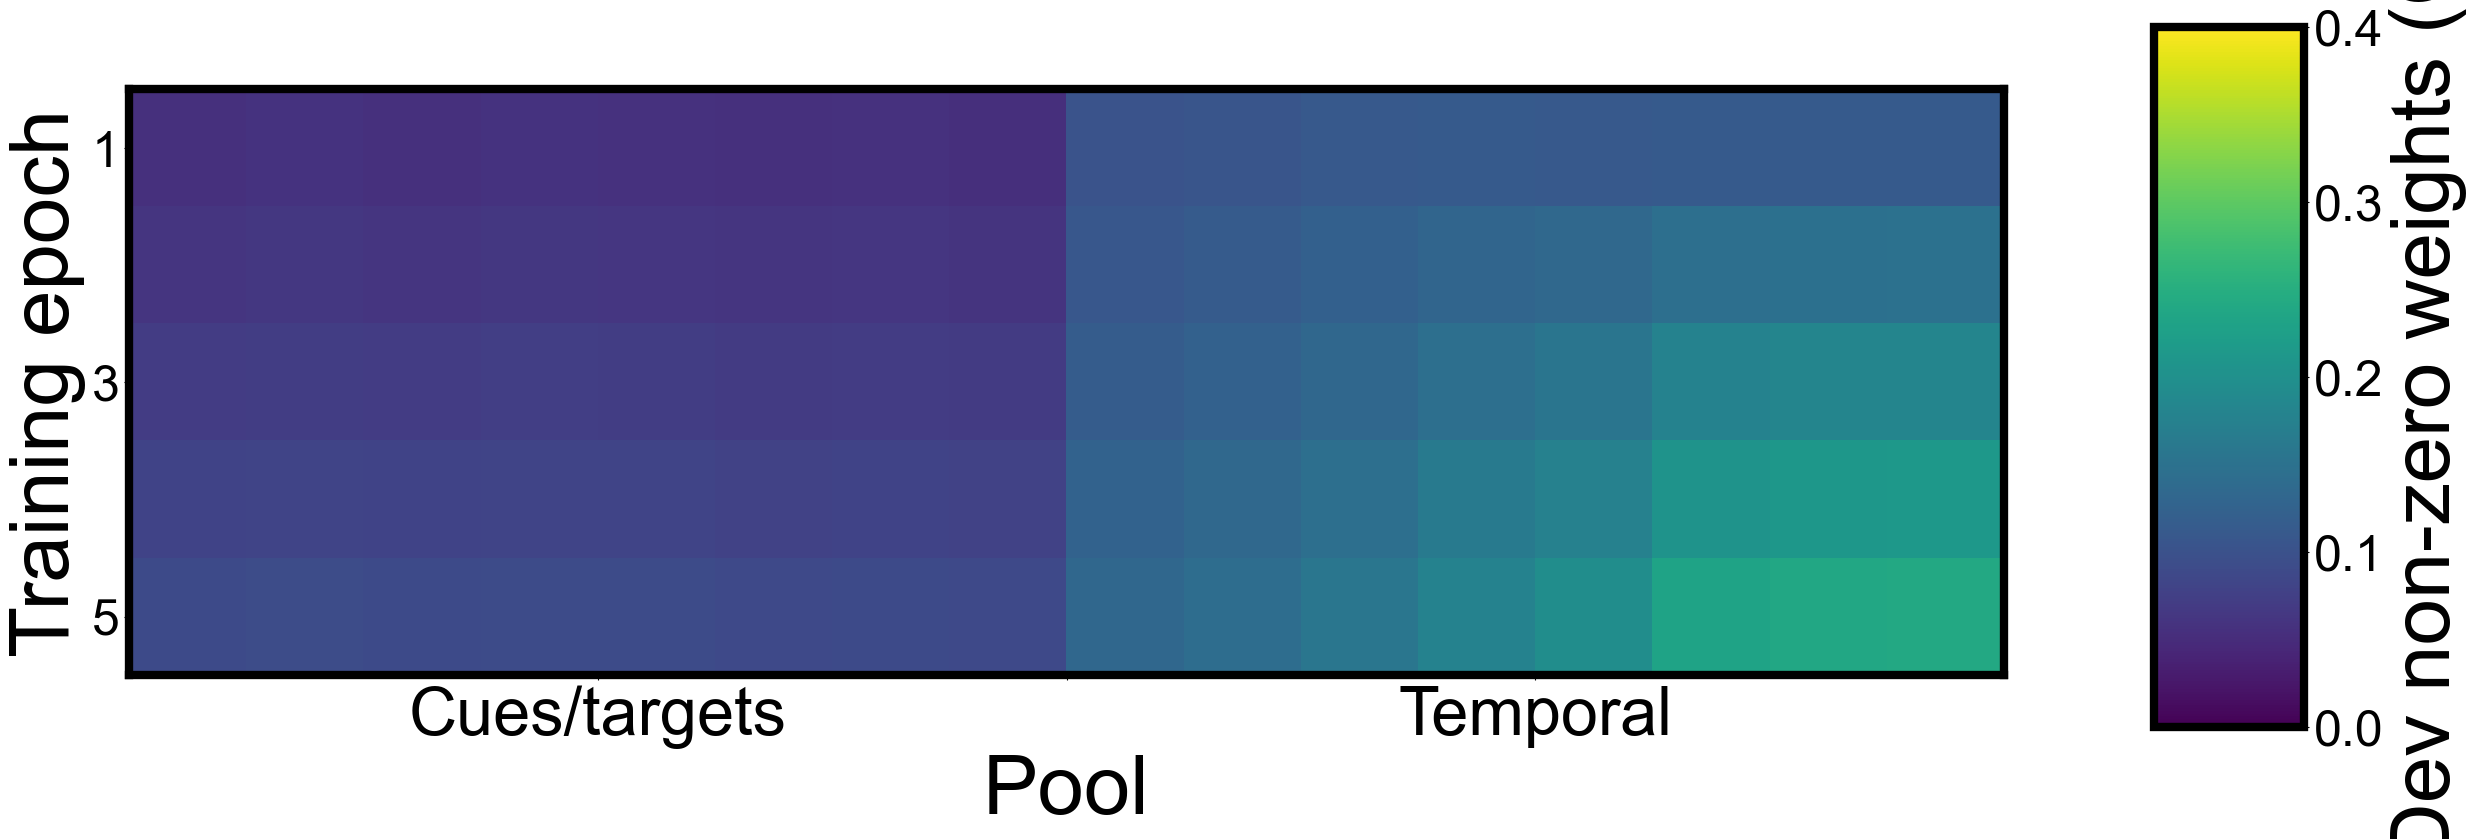

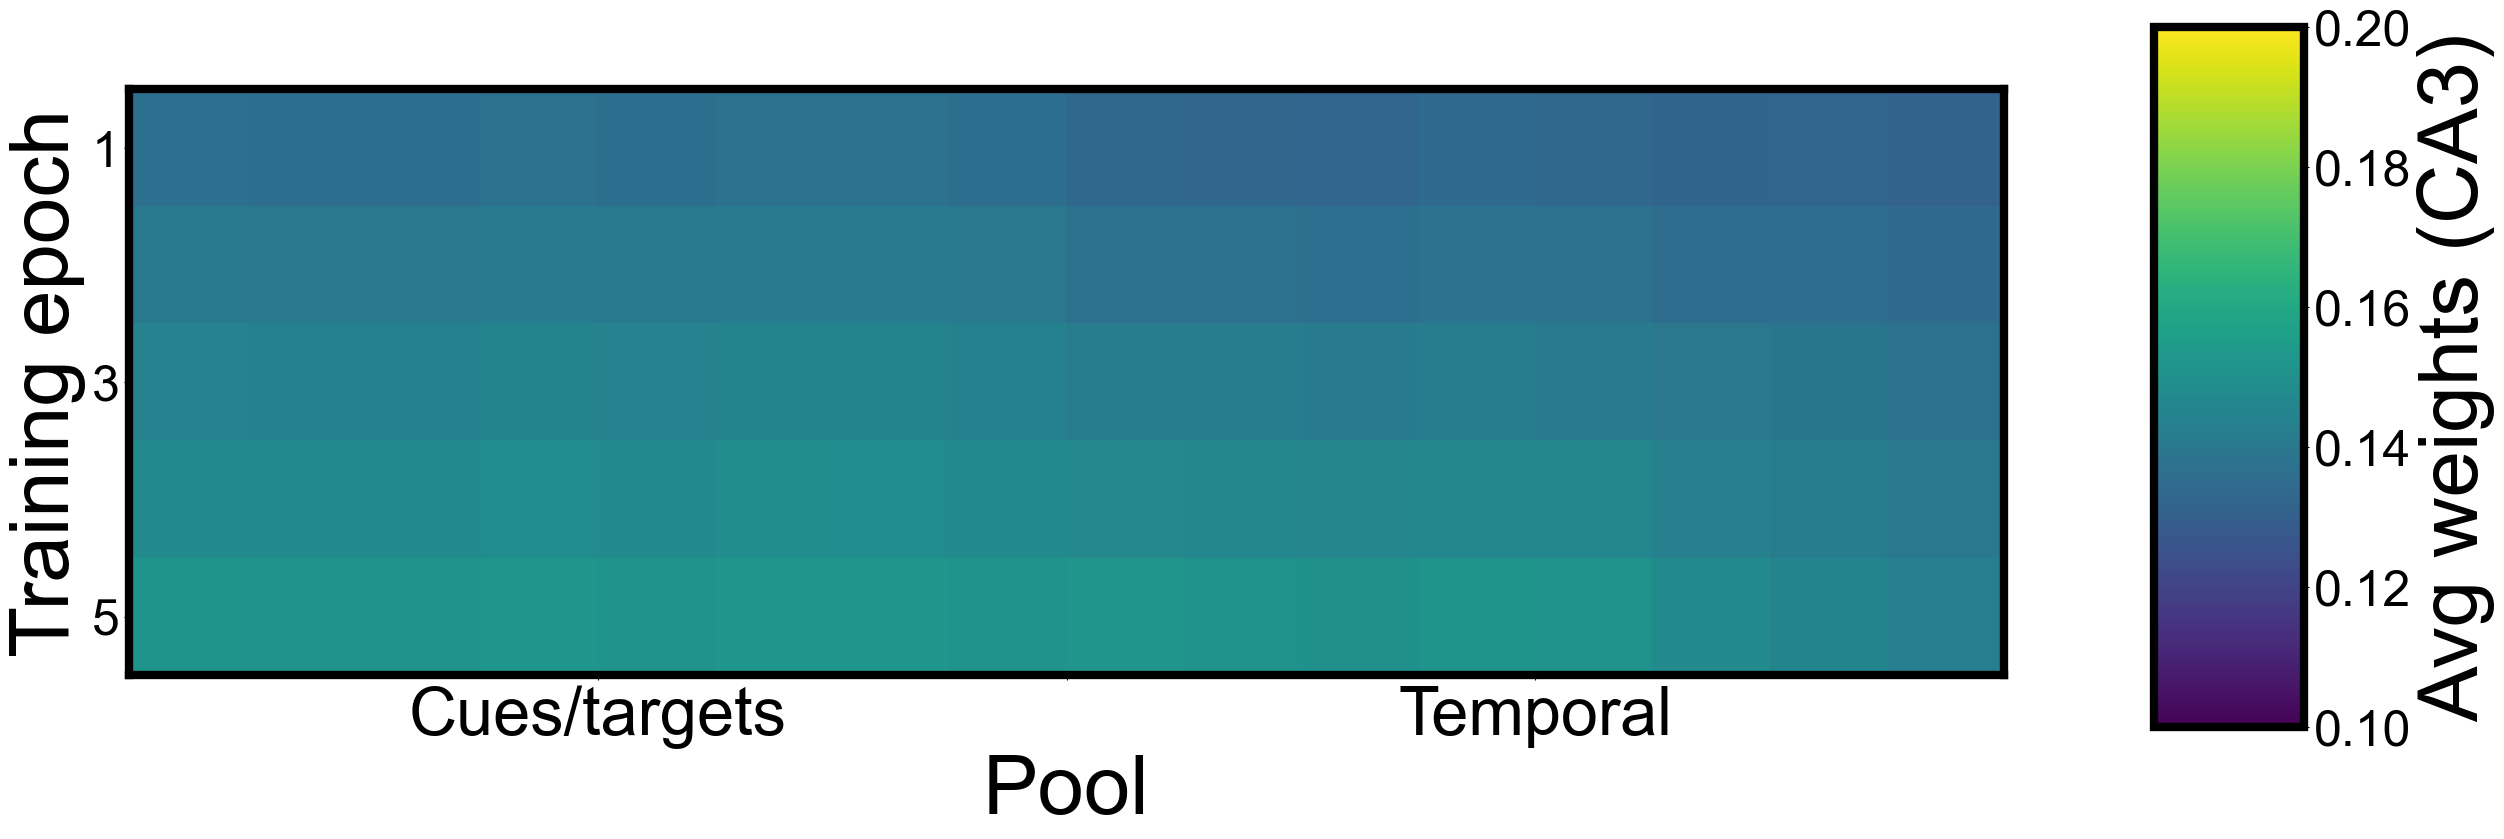

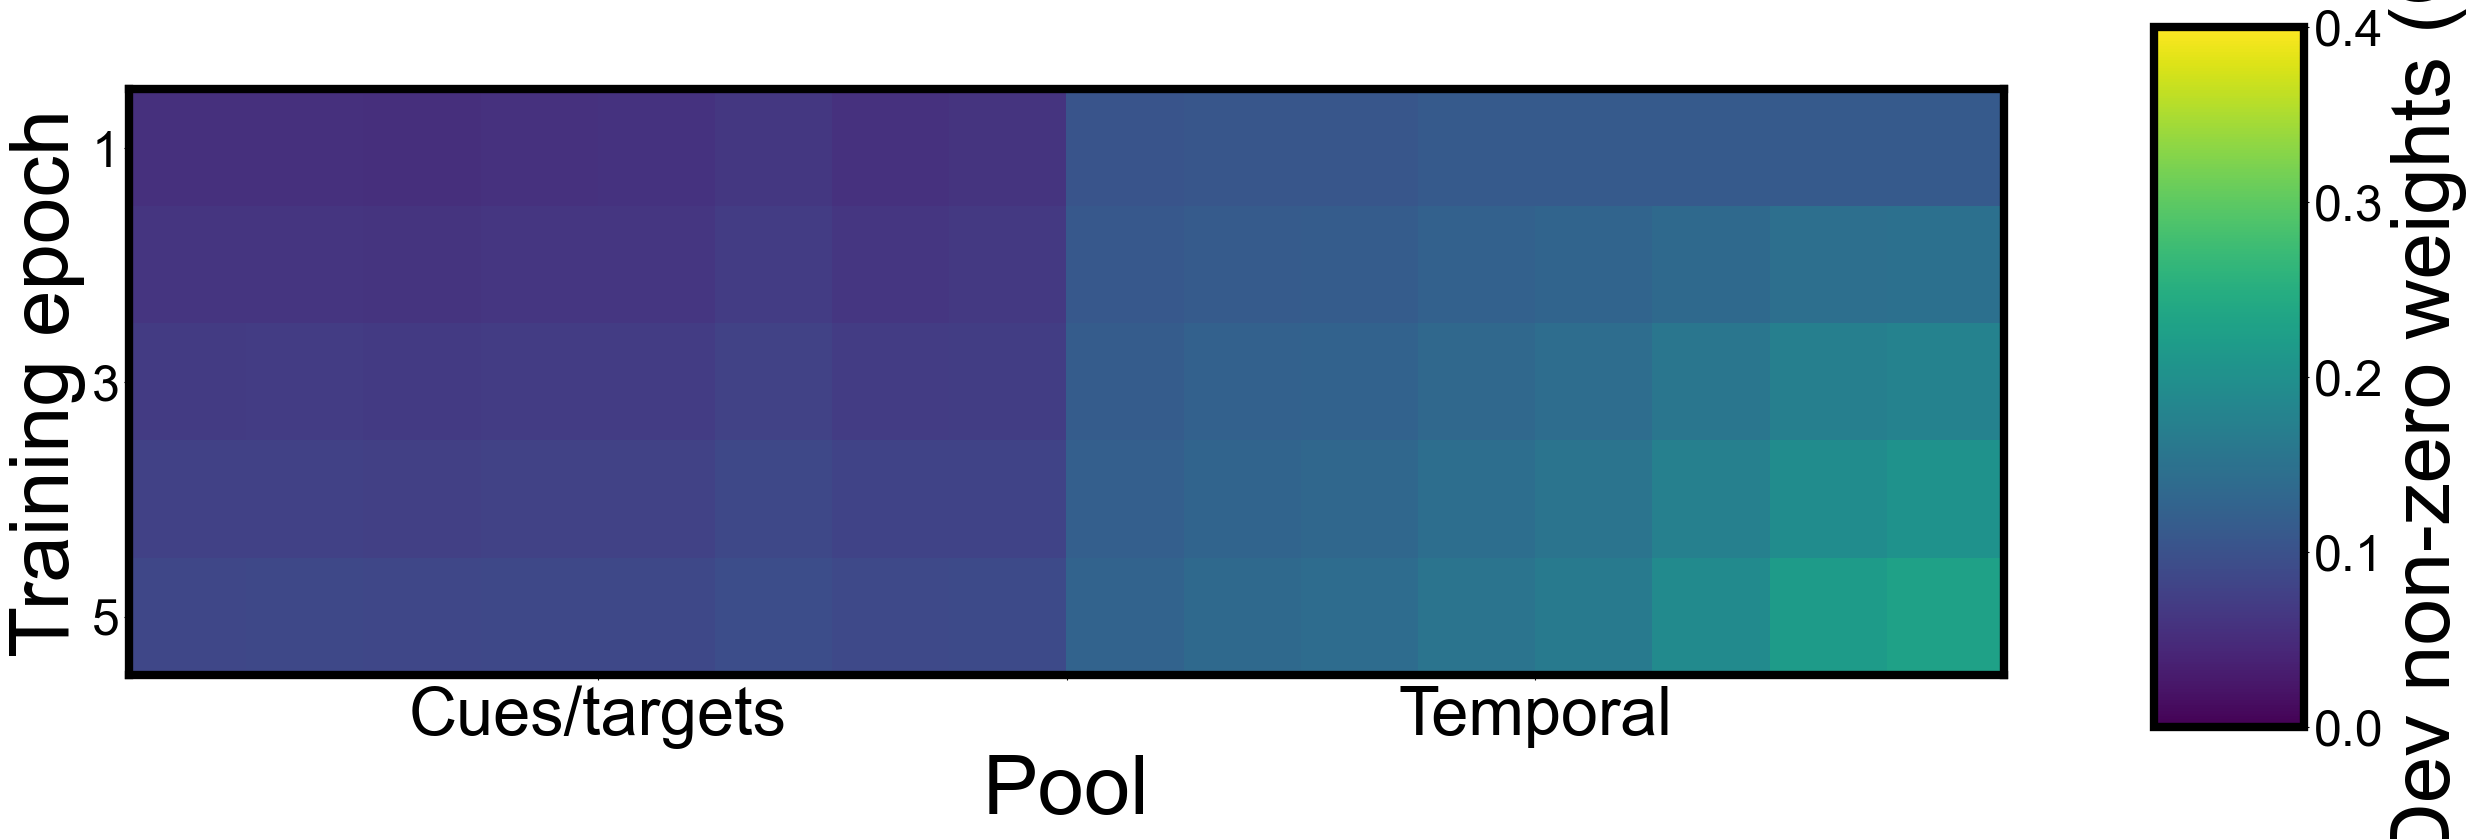

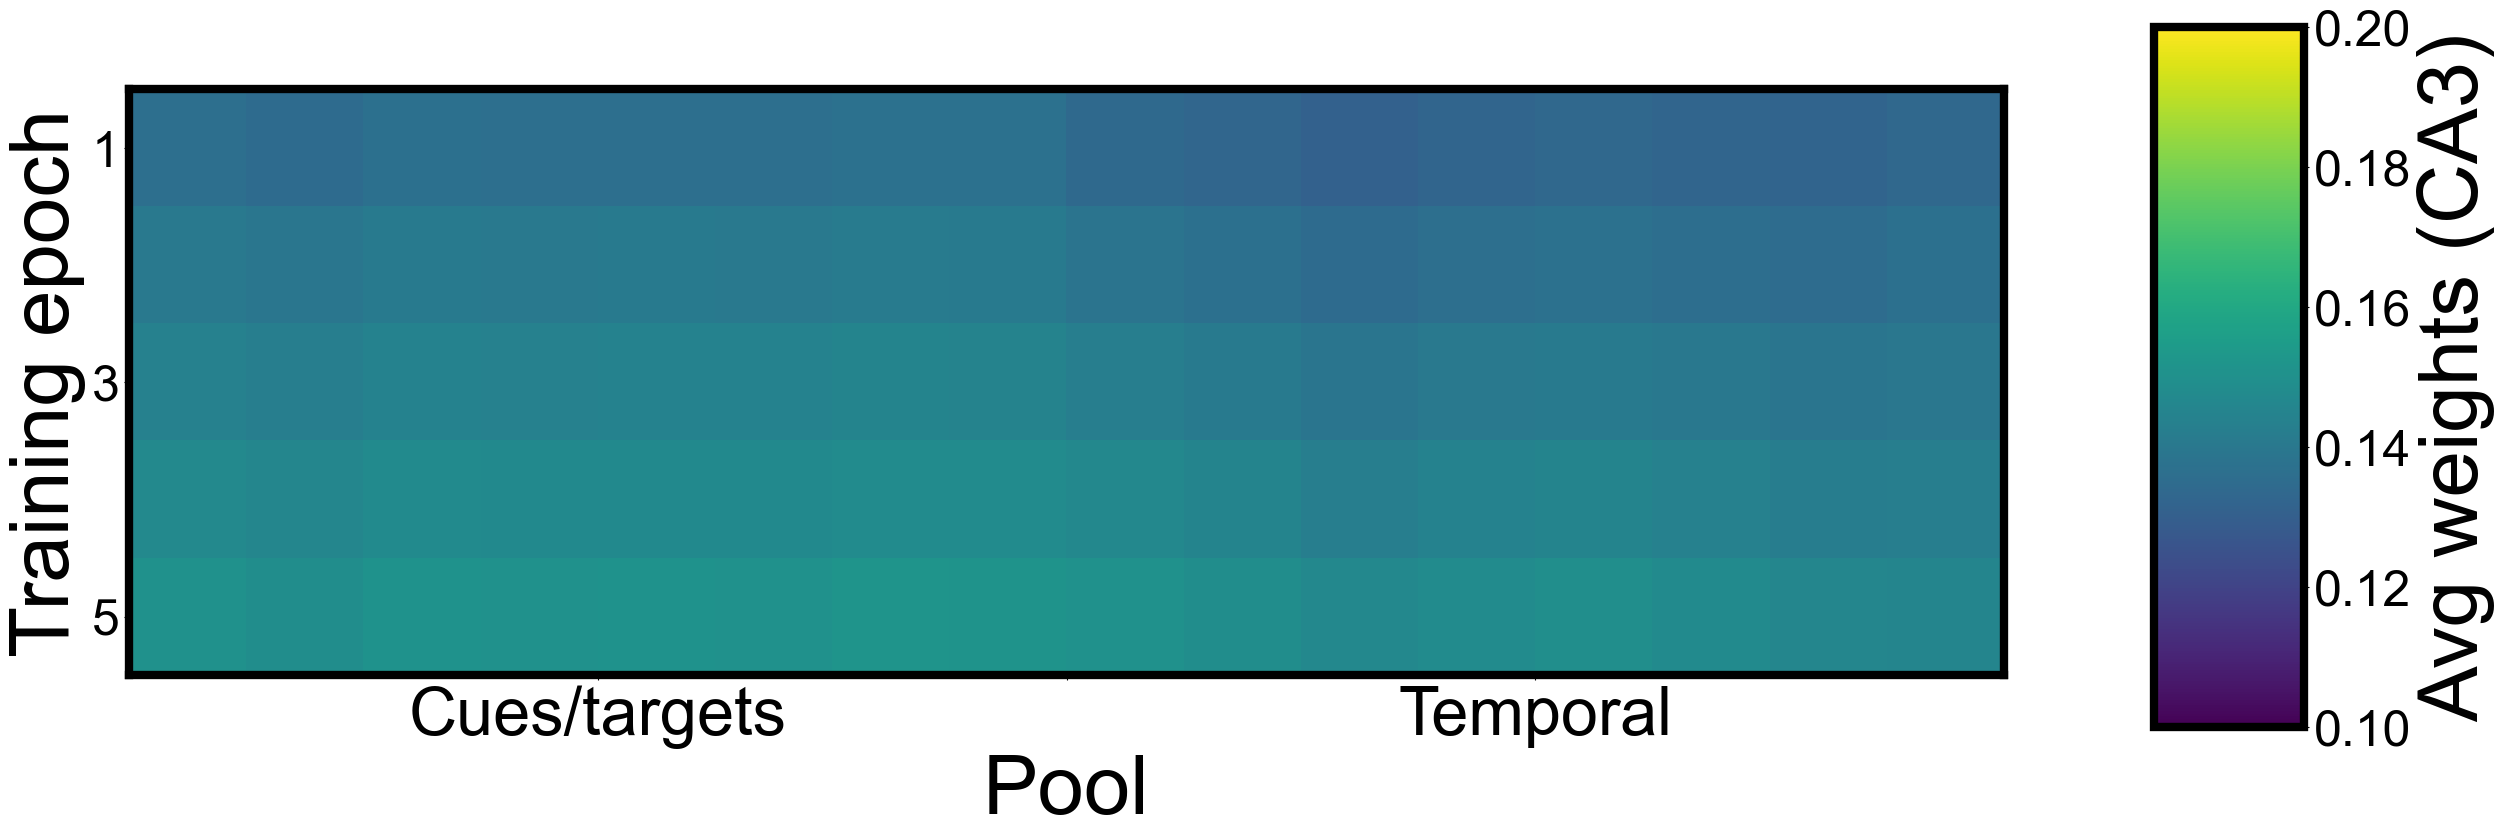

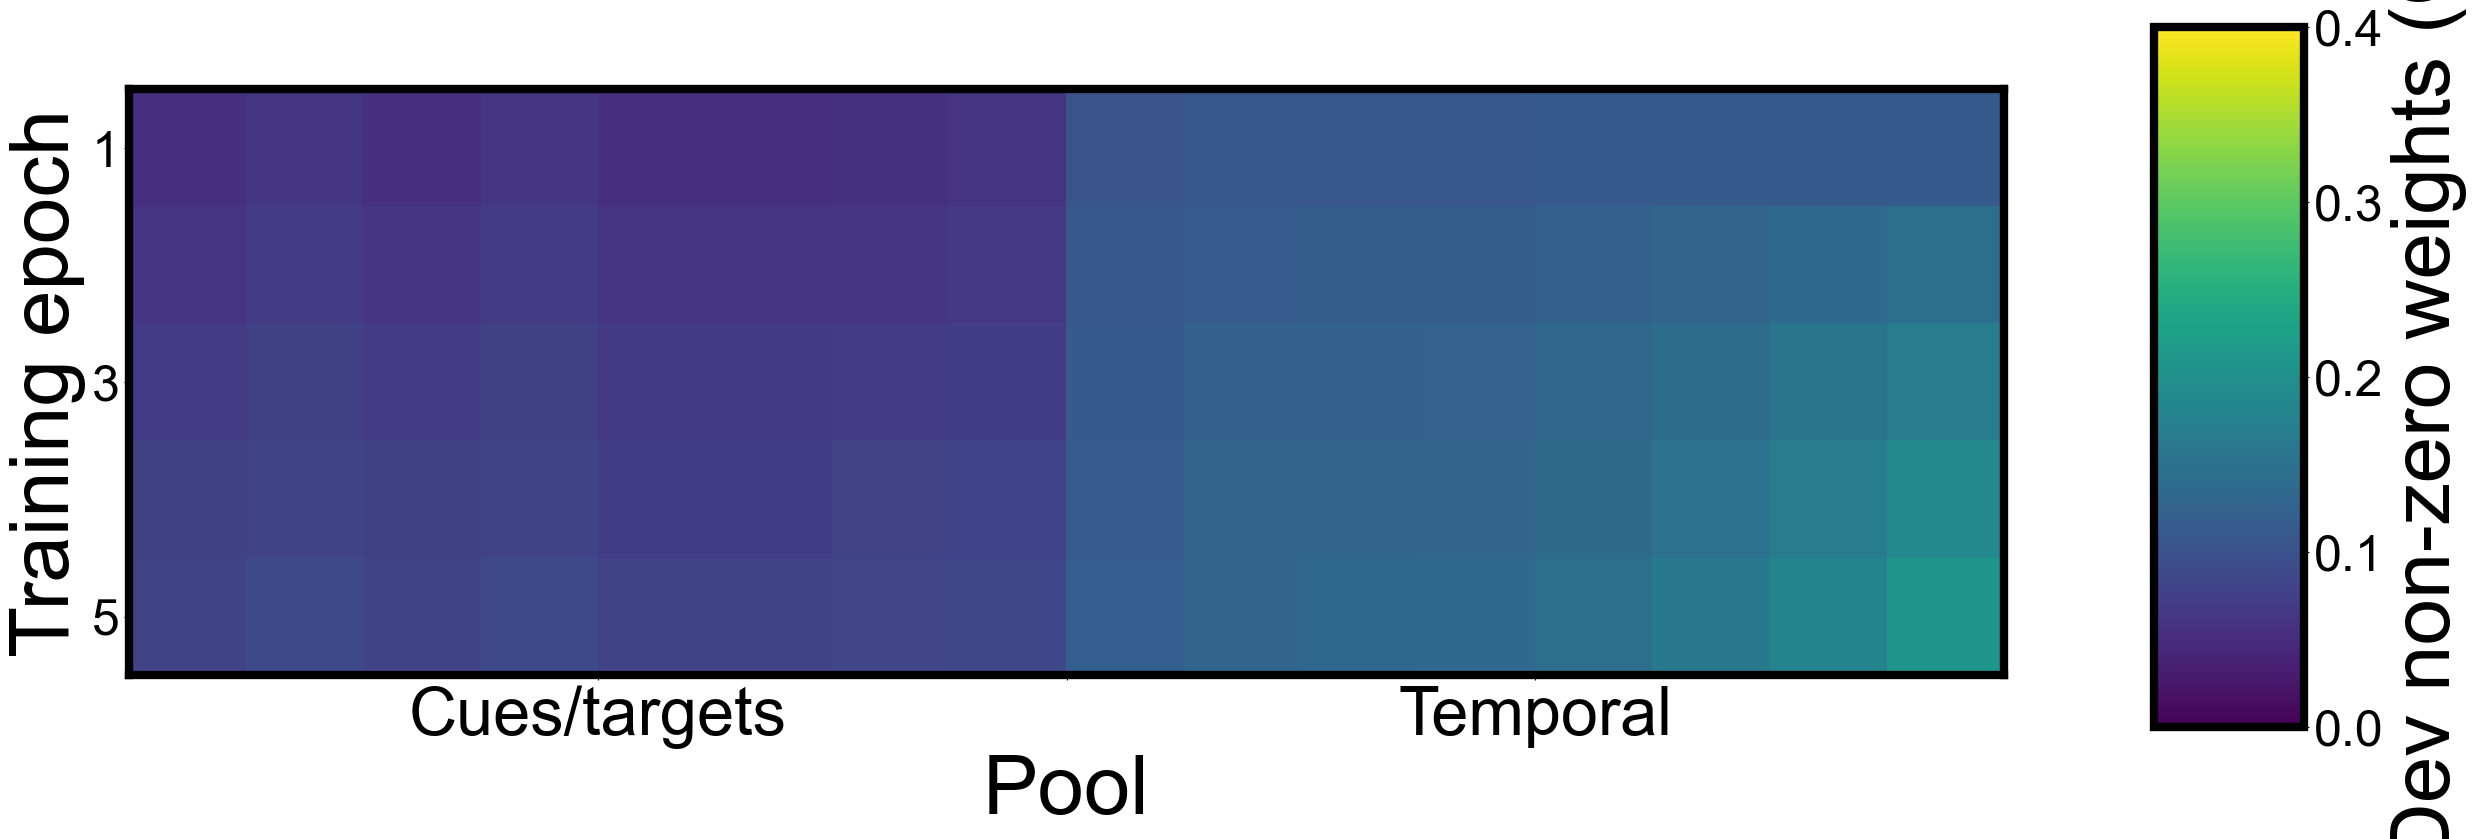

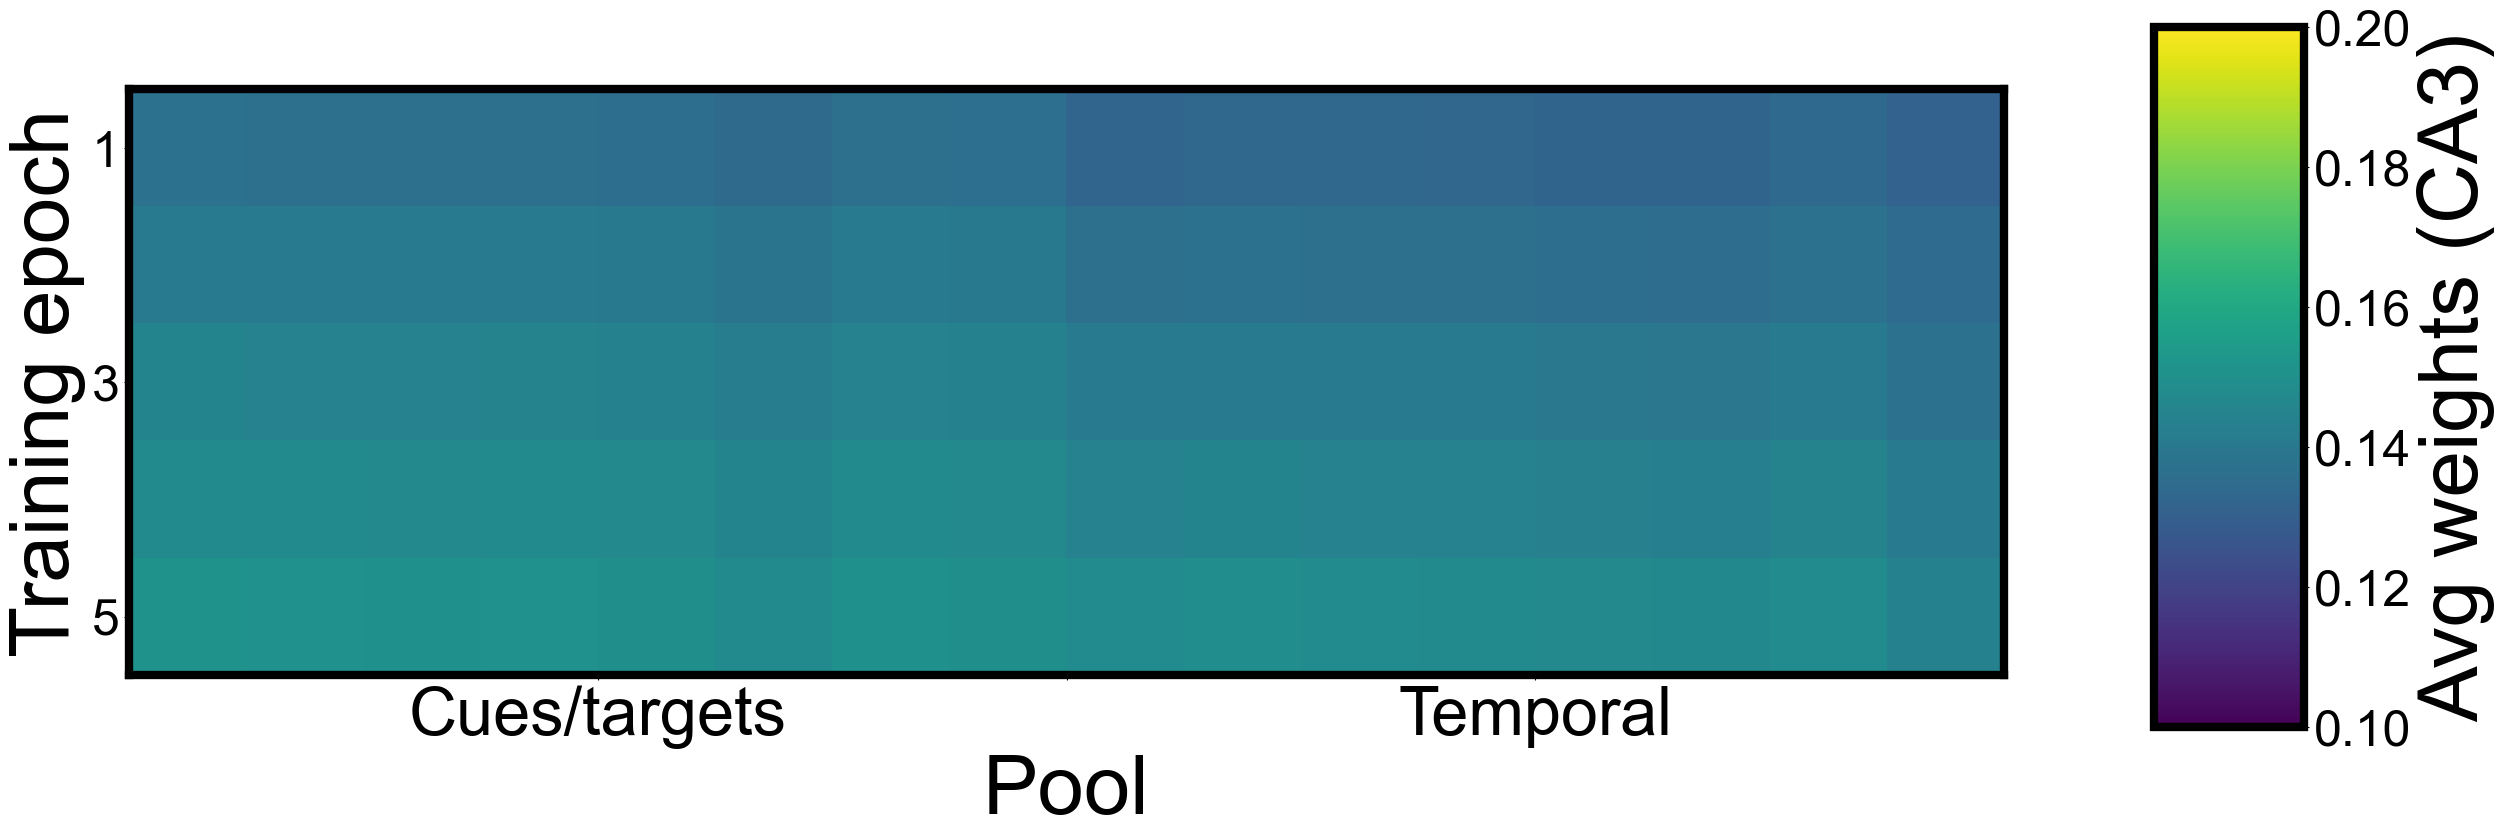

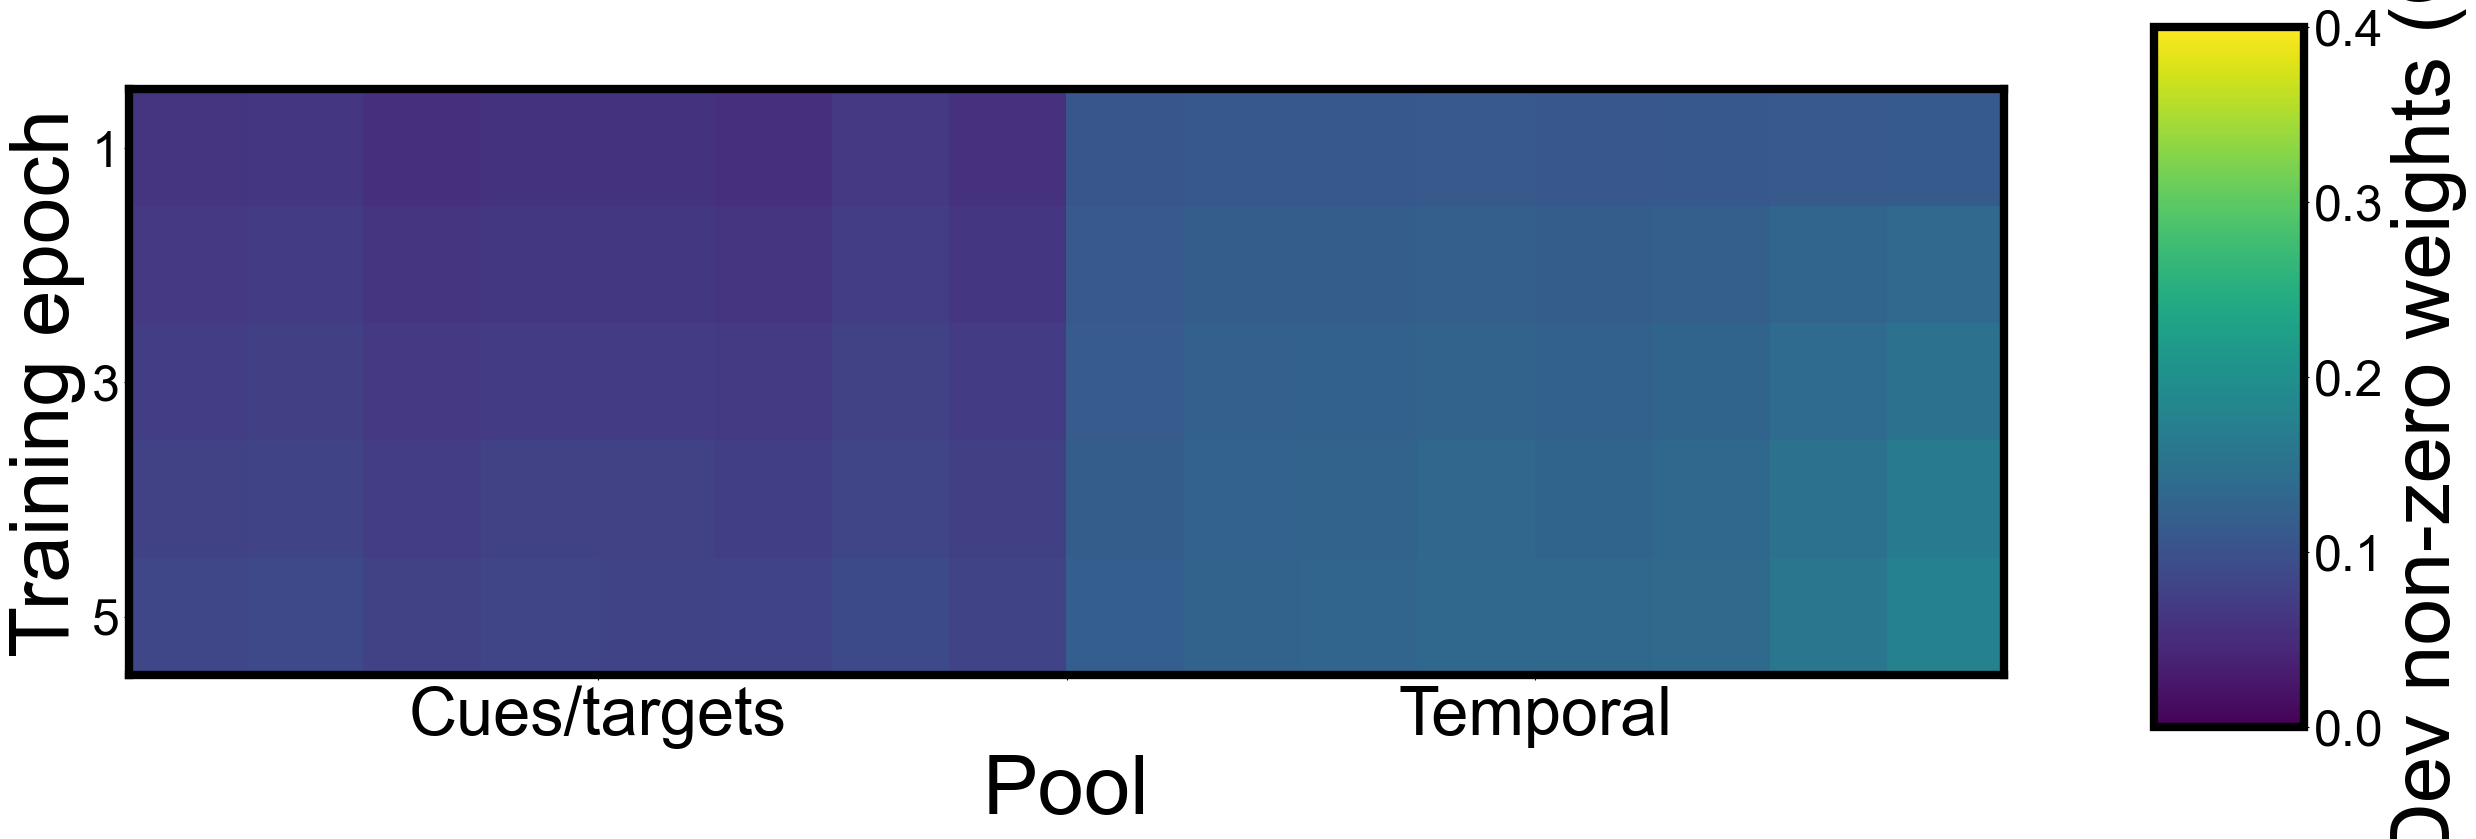

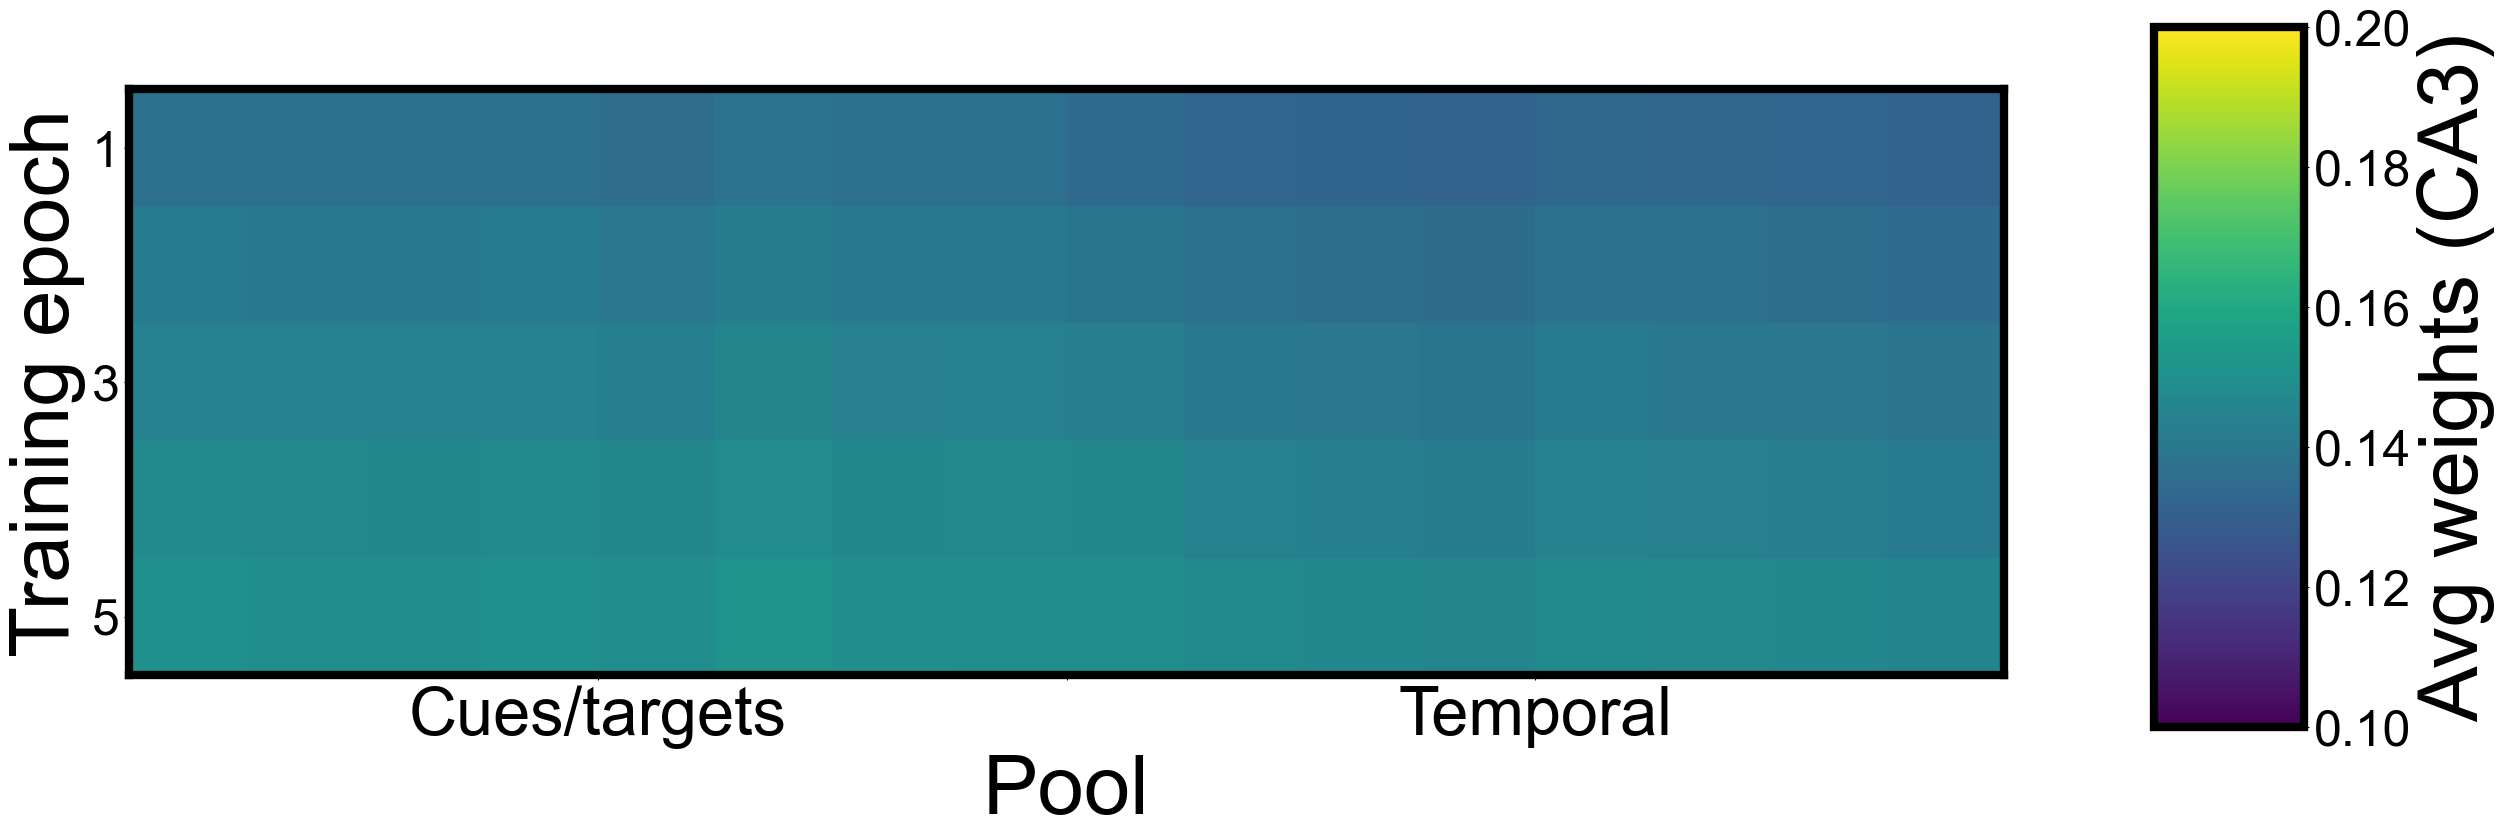

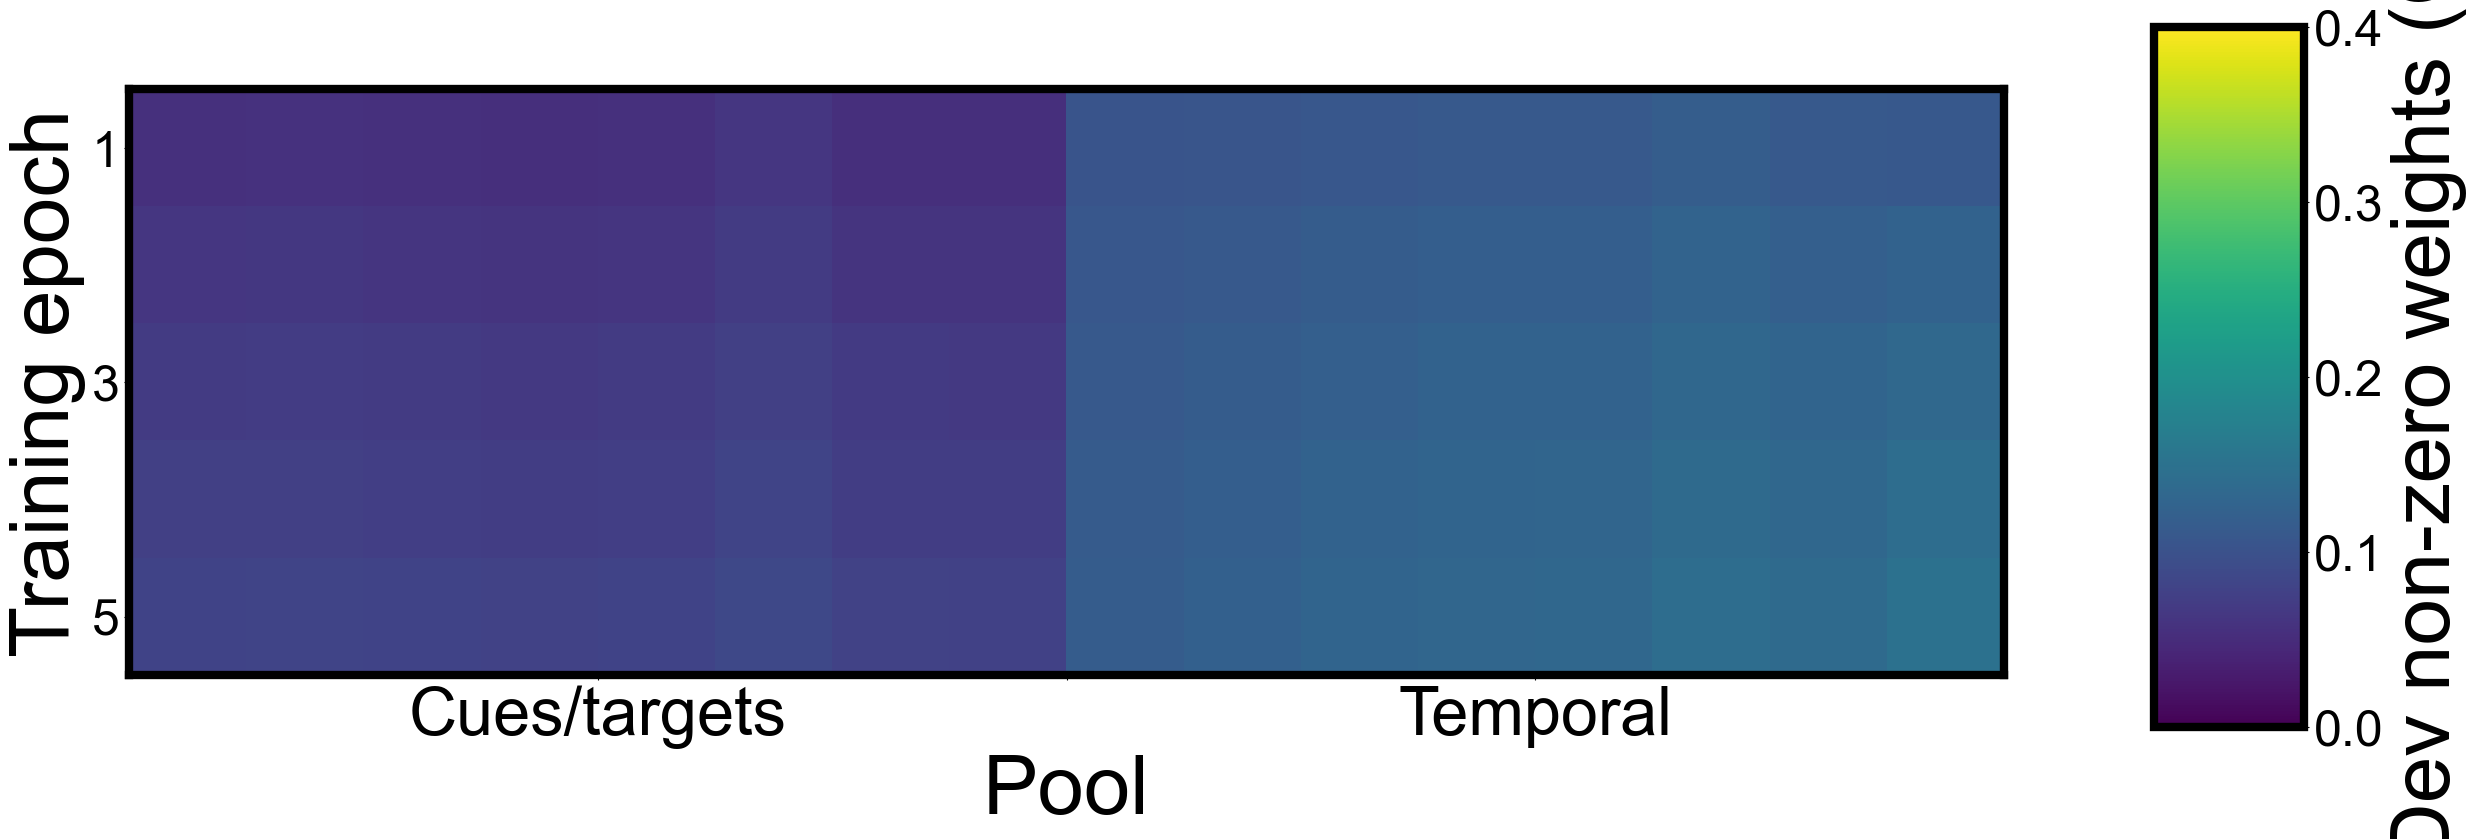

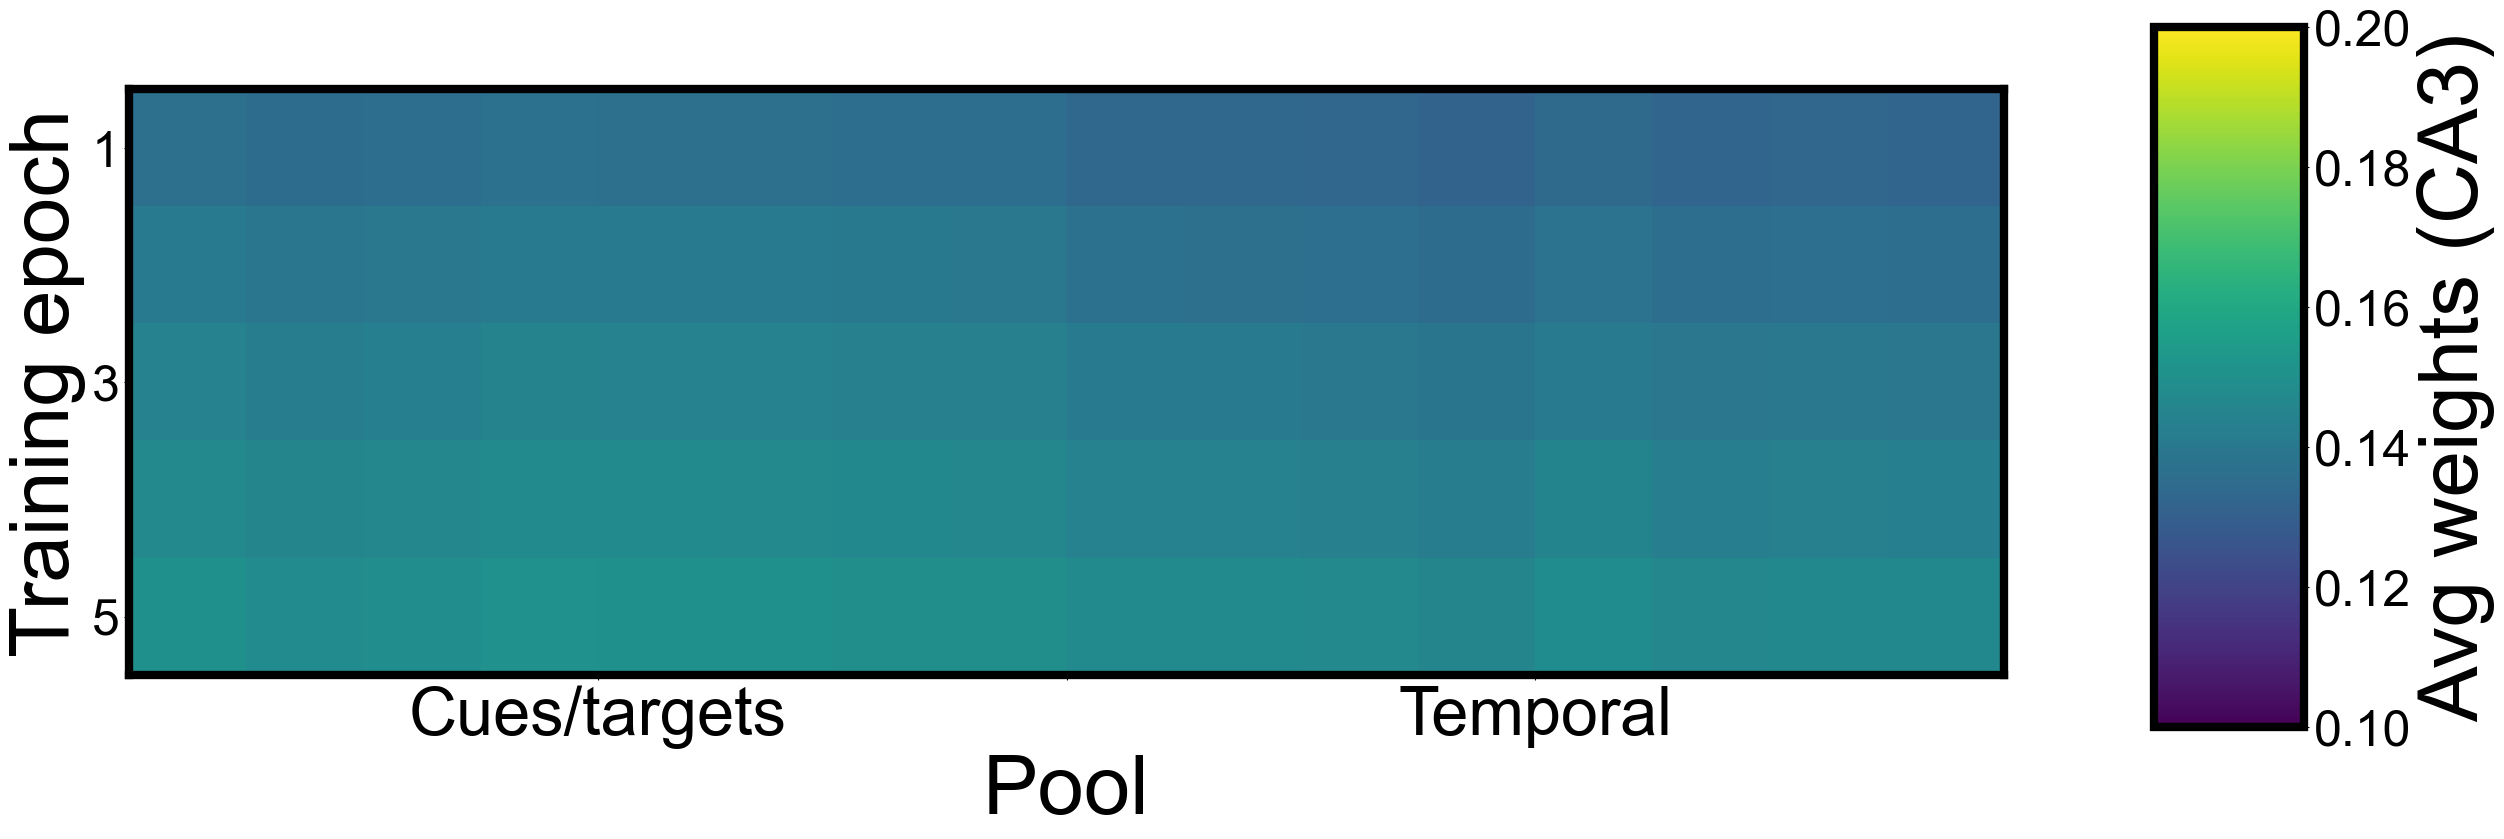

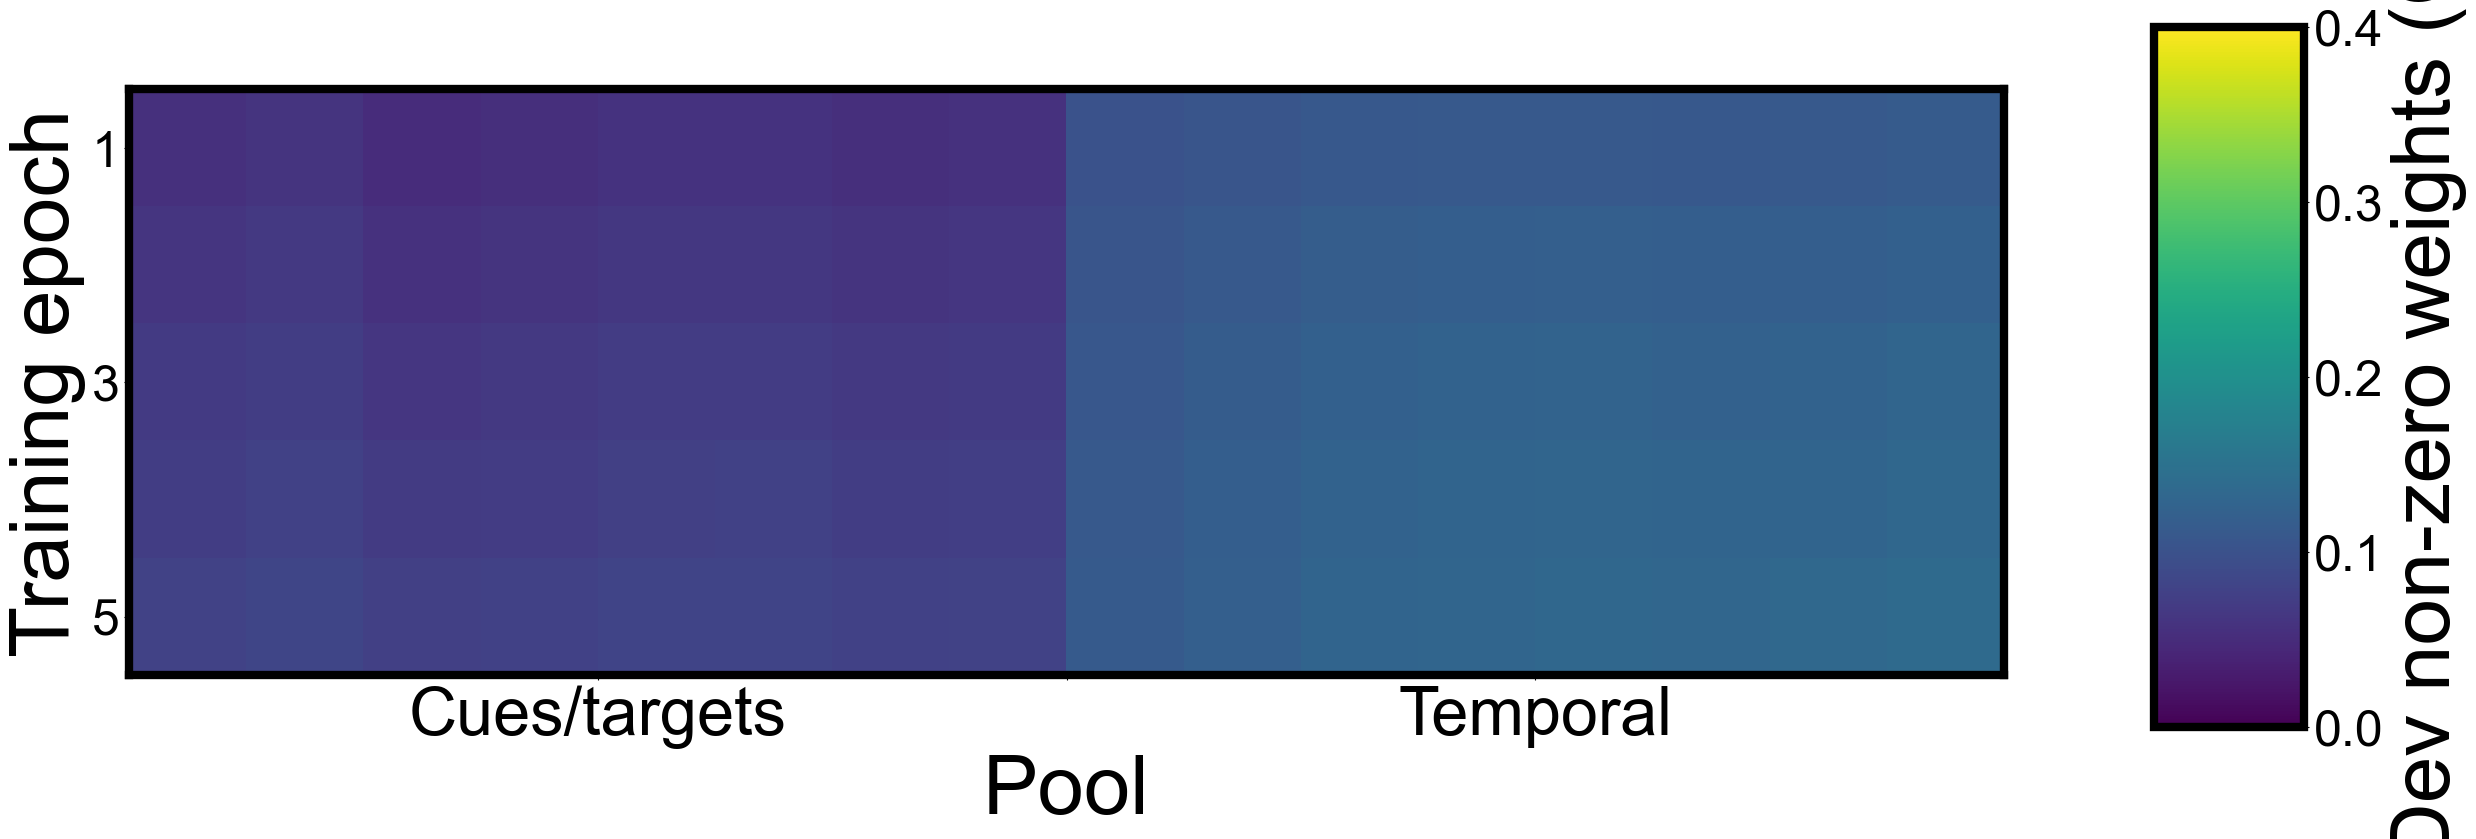

In [90]:
#settings
ells_a=['No drift','ISI-2','ISI-4','ISI-8','ISI-16','ISI-32','ISI-64','ISI-128','ISI-256','ISI-512','Scram-ISI']
nolistpools=1
nruns,maxepcs,npools,xtra=100,5,20,""
if nolistpools:
    npools,xtra=npools-4,"_wt"
plt.rcParams['axes.linewidth']=lw*2
plt.rcParams['lines.linewidth']=lw*2
plt.rcParams.update({'font.size': cfs*5})
wcond=3
dwlims,dslims,rf=[-0.01,0.01],[-0.1,0.1],0
xtl=[3.5,7.5,9.5,11.5,15.5] #x-tick locations
poolls=['Cues/targets','','Lists','','Temporal'] #pool labels
wlims,slims=[0.1,0.15],[0.05,0.25]
if nolistpools:
    xtl,poolls=[3.5,7.5,11.5],['Cues/targets','','Temporal']
    wlims,slims,wlims2,slims2=[0.1,0.2],[0,0.4],[0.1,0.13],[0,0.1]

#### read in weights!
allsp=1 #0=drift vs no drift, 1=all sp conditions
first=main_first+0 
fjobs,tlls=np.arange(first,first+90+1,9),copy.deepcopy(ells_a) 
print('# fjobs: %s' %len(fjobs))
if allsp==0:
    fjobs=[first,first+18]
    tlls=['No drift','Drift']
    
for h in range(len(fjobs)):
    fjob=int(fjobs[h]) 
    pnb=pnbf(base,fjob)
    unpack,unpackdg=np.zeros((nruns,maxepcs,npools)),np.zeros((nruns,maxepcs,npools))
    unpack_s,unpackdg_s=np.zeros((nruns,maxepcs,npools)),np.zeros((nruns,maxepcs,npools))
    for rnum in range(nruns):
        for enum in range(maxepcs):
            fn=pnb+str(fjob)+"/stcm7_BigHip_List016_wts-" + str(rnum) + "-" + str(enum) + "_epc" + xtra + ".tsv"
            wtf=pd.read_csv(fn, sep=' ', header=0) #load in
            fn=pnb+str(fjob)+"/stcm7_BigHip_List016_wts_s-" + str(rnum) + "-" + str(enum) + "_epc" + xtra + ".tsv"
            wtf_s=pd.read_csv(fn, sep=' ', header=0) #load in
            unpack[rnum,enum,:]=readcols(wtf)
            unpack_s[rnum,enum,:]=readcols(wtf_s)
            
    wtplot(unpack,"Avg weights (CA3)",wlims,'wts-%s' %fjob,0)
    wtplot(unpack_s,"StDev non-zero weights (CA3)",slims,'wts_s-%s' %fjob,0)
    fn='dat/unpack-' + str(fjob)        
    scipy.io.savemat(fn,{'unpack': unpack,'unpack_s': unpack_s,
                         'unpackdg': unpackdg,'unpackdg_s': unpackdg_s})

In [91]:
if nolistpools:
    dwlims,dslims=[-0.025,0.025],[-0.1,0.1]
    if allsp==1:
        dslims=[-0.2,0.2]

datmats,datmats_s=np.zeros((len(fjobs),nruns,maxepcs,npools)),np.zeros((len(fjobs),nruns,maxepcs,npools))
for i in range(len(fjobs)):
    fjob=int(fjobs[i])
    fn='dat/unpack-' + str(fjob)    #contrs[i]    
    mat_contents=scipy.io.loadmat(fn)
    datmats[i,:,:,:]=mat_contents['unpack']
    datmats_s[i,:,:,:]=mat_contents['unpack_s']
print(datmats.shape)

#ind plots
if allsp==0:
    wtplot(datmats[0,:,:,:],'No drift weights',[0.1,0.15],'ind-%s-%s' %(fjobs[-1],fjobs[0]),0) #mean weights
    wtplot(datmats[-1,:,:,:],'Max drift weights',[0.1,0.15],'ind-%s-%s' %(fjobs[-1],fjobs[0]),0) 
    wtplot(datmats_s[0,:,:,:],'No drift st. dev. weights',[0.1,0.15],'ind-%s-%s' %(fjobs[-1],fjobs[0]),0)
    wtplot(datmats_s[-1,:,:,:],'Max drift st. dev. weights',[0.1,0.15],'ind-%s-%s' %(fjobs[-1],fjobs[0]),0) 

    #individual diff plots
    for i in range(len(fjobs)-1): #loop through all and subtract out base condition
        wtplot(datmats[i+1,:,:,:]-datmats[0,:,:,:],'''
        Drift - no drift,
        weights''',dwlims,'dvnd-%s-%s' %(fjobs[-1],fjobs[0]),1) #mean weights
        wtplot(datmats_s[i+1,:,:,:]-datmats_s[0,:,:,:],'''
        Drift - no drift,  
        st. dev. weights''',dslims,'dvnd_s-%s-%s' %(fjobs[-1],fjobs[0]),1) #stdev weights

(11, 100, 5, 16)


array([[[-0.005907,  0.025221,  0.01563 , ...,  0.030952,  0.030089,
          0.069914],
        [-0.022935, -0.008472,  0.024986, ...,  0.040406,  0.047832,
          0.051433],
        [-0.016378,  0.035736,  0.034895, ...,  0.066083,  0.062496,
          0.080548],
        ...,
        [-0.011314, -0.004719,  0.017647, ...,  0.015593,  0.0308  ,
          0.049391],
        [-0.008891,  0.010923,  0.032026, ...,  0.056248,  0.057798,
          0.069042],
        [ 0.006214,  0.0256  ,  0.038889, ...,  0.068597,  0.046529,
          0.054277]],

       [[-0.002141,  0.009472,  0.026212, ...,  0.053828,  0.063256,
          0.048164],
        [-0.028033,  0.019925,  0.037767, ...,  0.053926,  0.06305 ,
          0.071104],
        [-0.033598,  0.019098,  0.019884, ...,  0.067335,  0.068327,
          0.062475],
        ...,
        [-0.013234, -0.035645,  0.024582, ...,  0.043215,  0.038073,
          0.035515],
        [ 0.016633,  0.001821,  0.013394, ...,  0.049466,  0.053866,
   

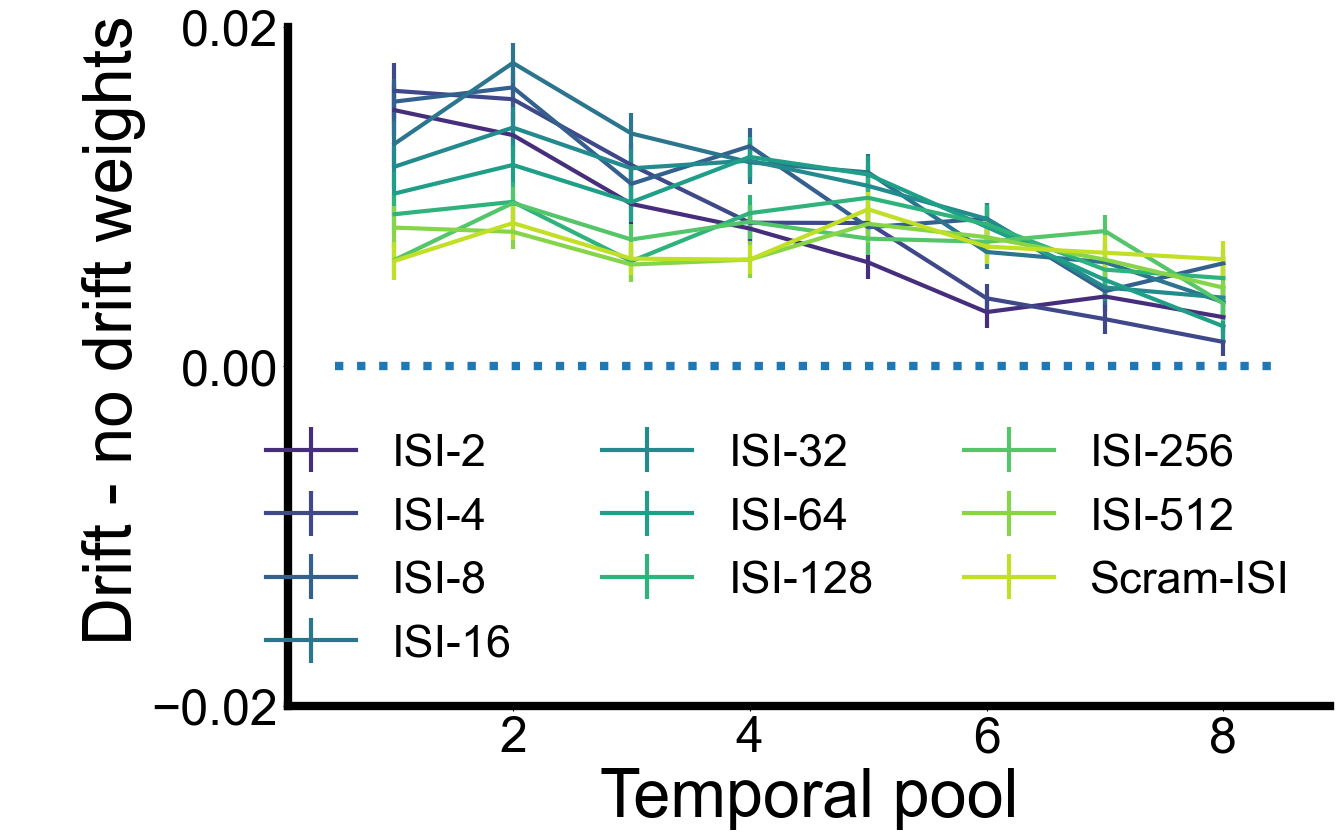

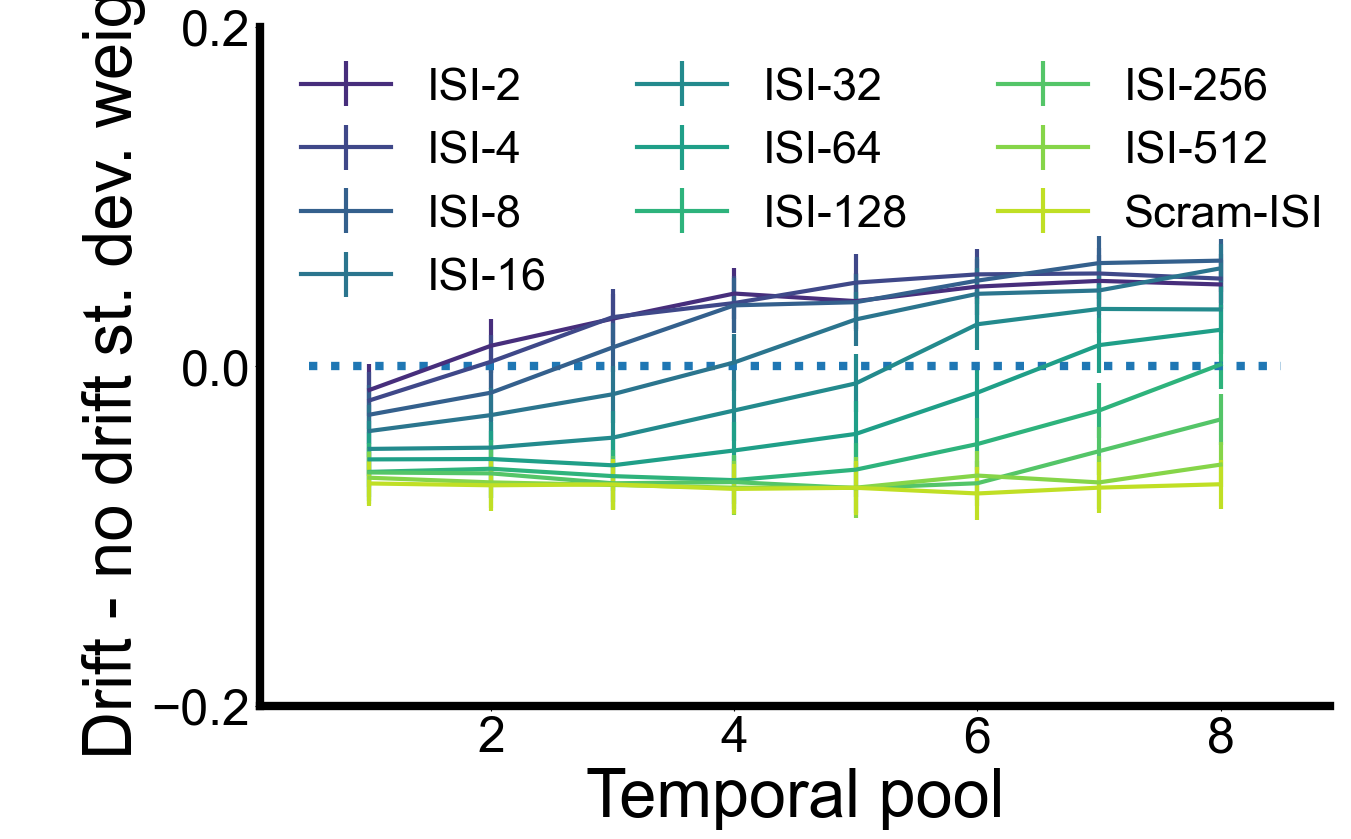

In [92]:
if allsp<2:
    dwlims,dslims,dctlims,dctslims=[-0.02,0,0.02],[-0.2,0,0.2],[-0.01,0,0.01],[-0.03,0,0.03]
    lab1='''
    Drift - no drift weights'''
    lab2='''
    Drift - no drift st. dev. weights'''
    
diffmats=diffplot(datmats,lab1,dwlims,'dvnd_diff_%s' %allsp,'lower right',1)
diffplot(datmats_s,lab2,dslims,'dvnd_s_diff_%s' %allsp,'upper left',1)

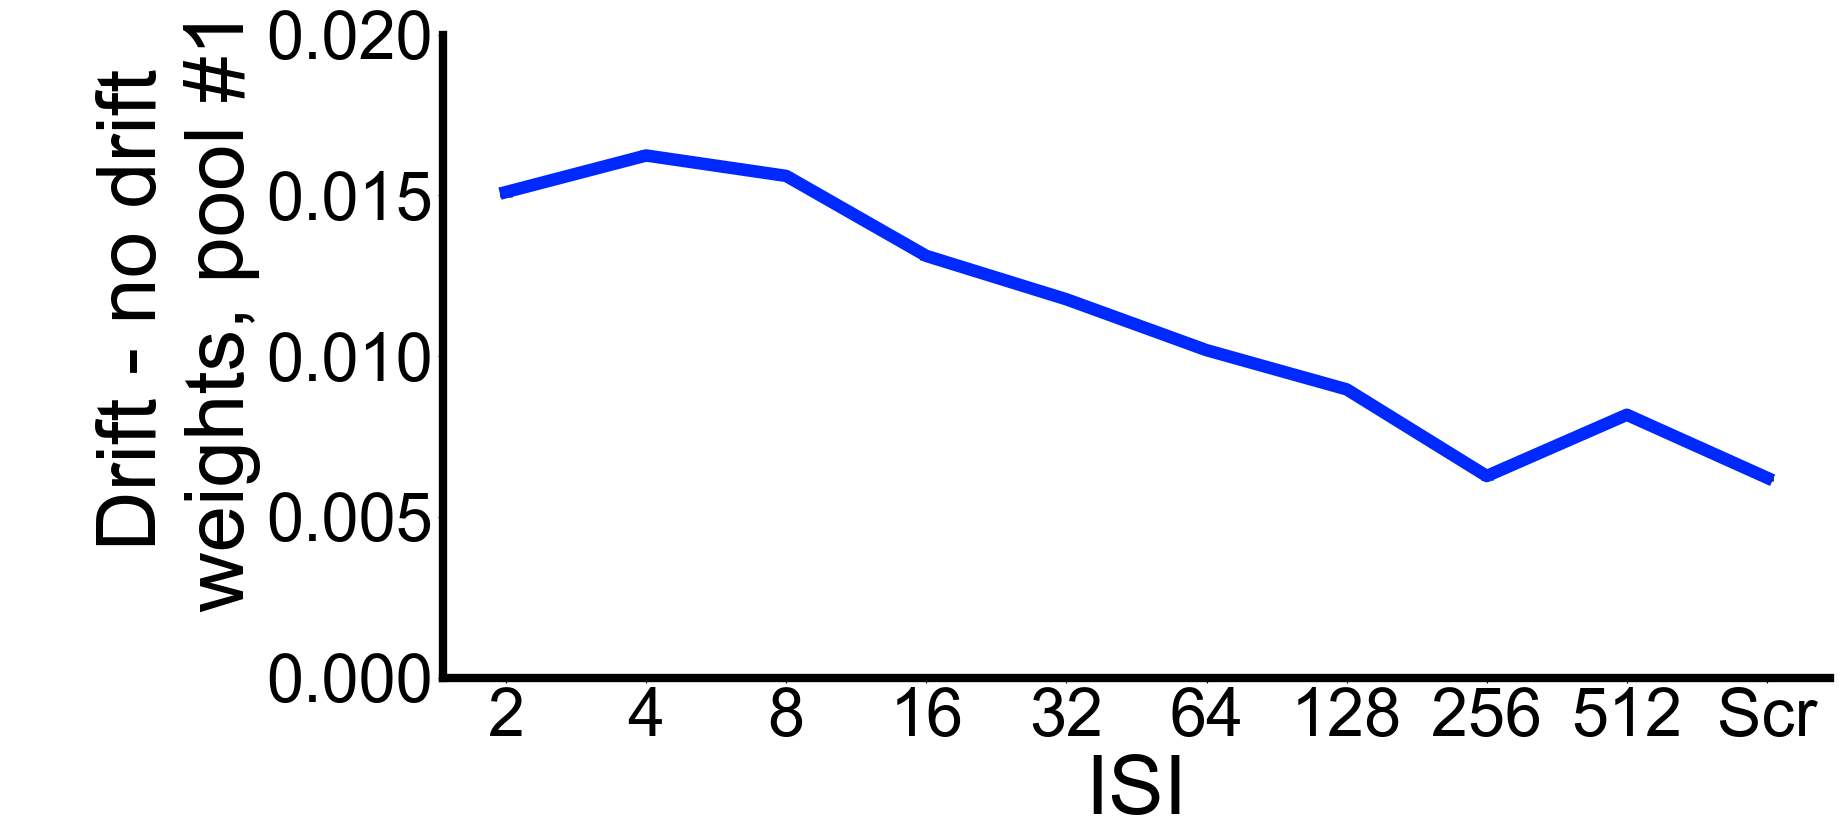

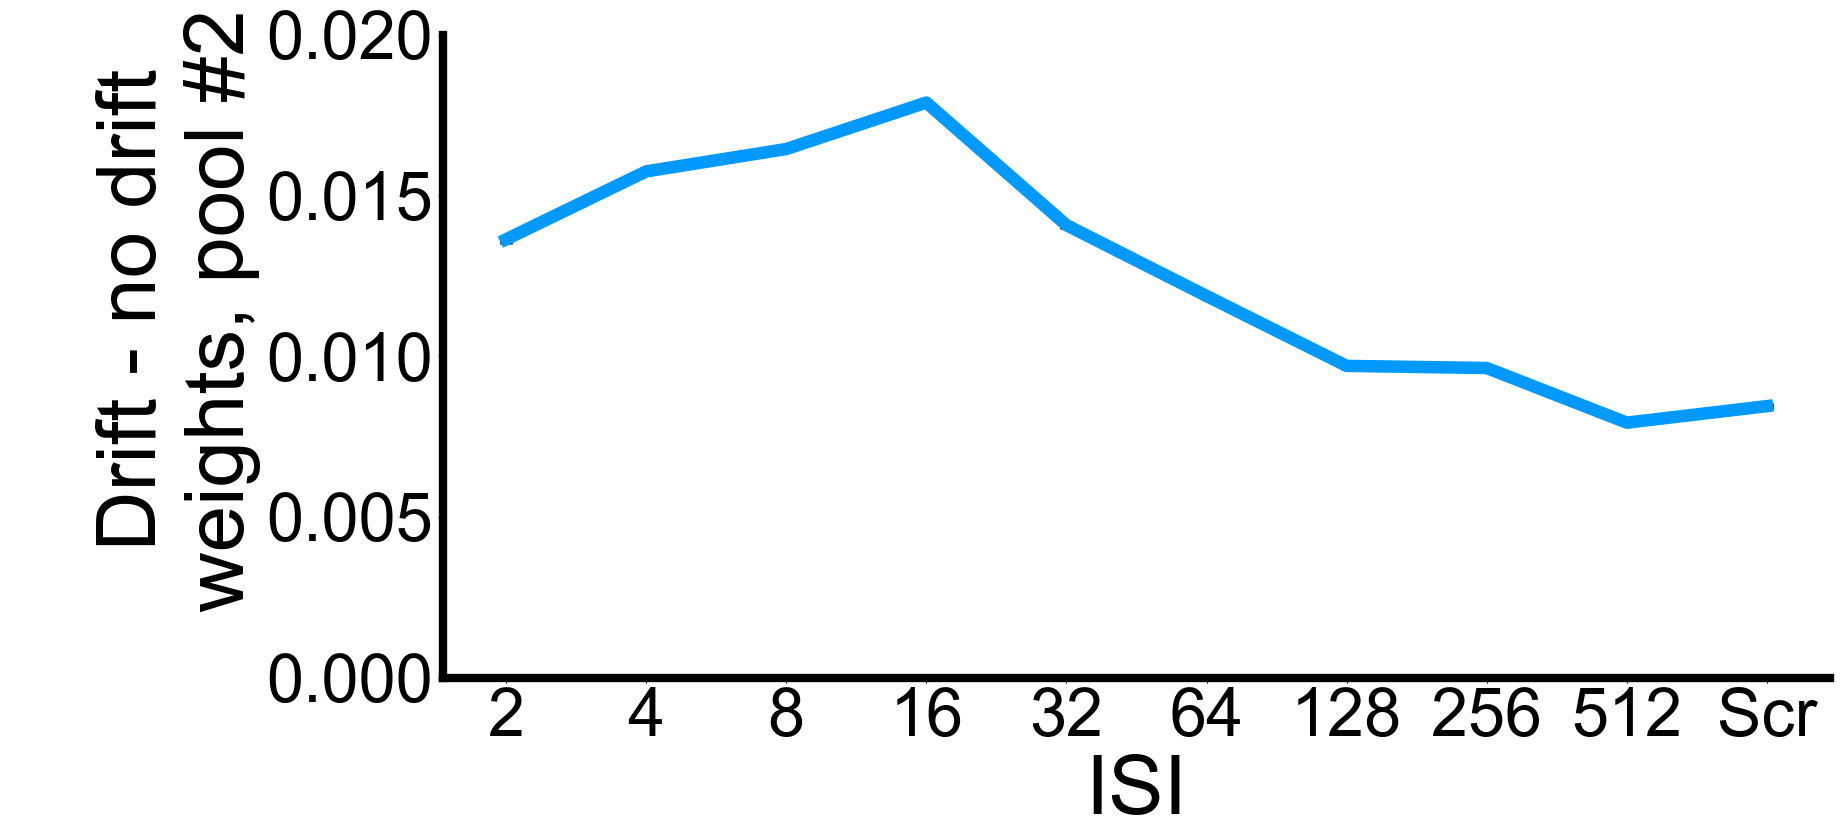

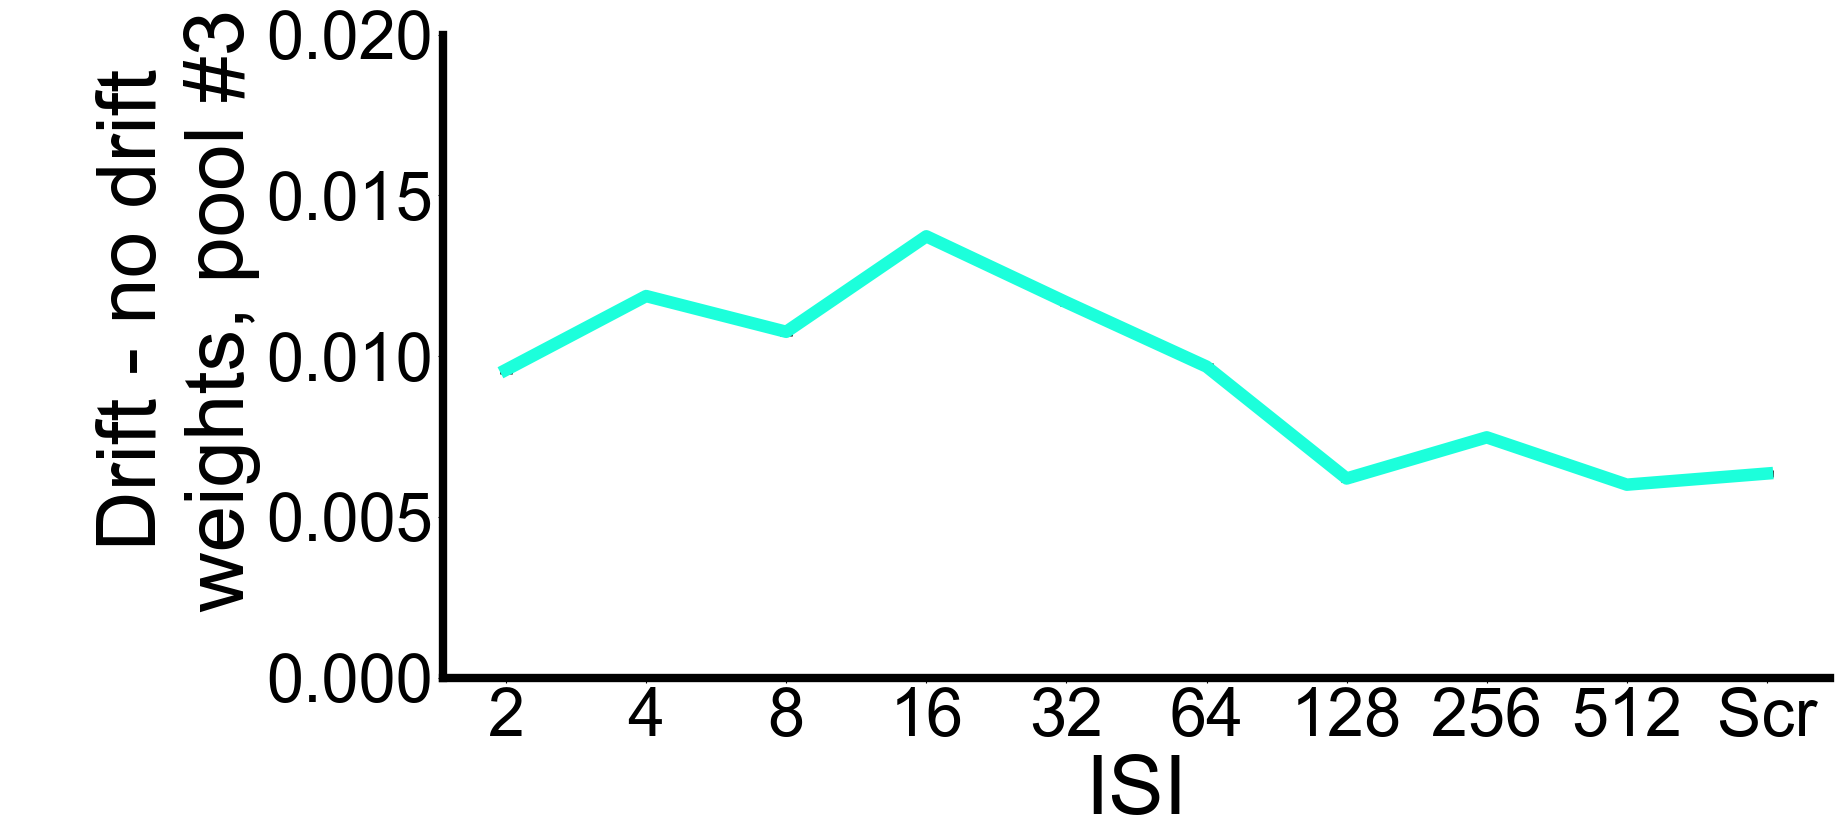

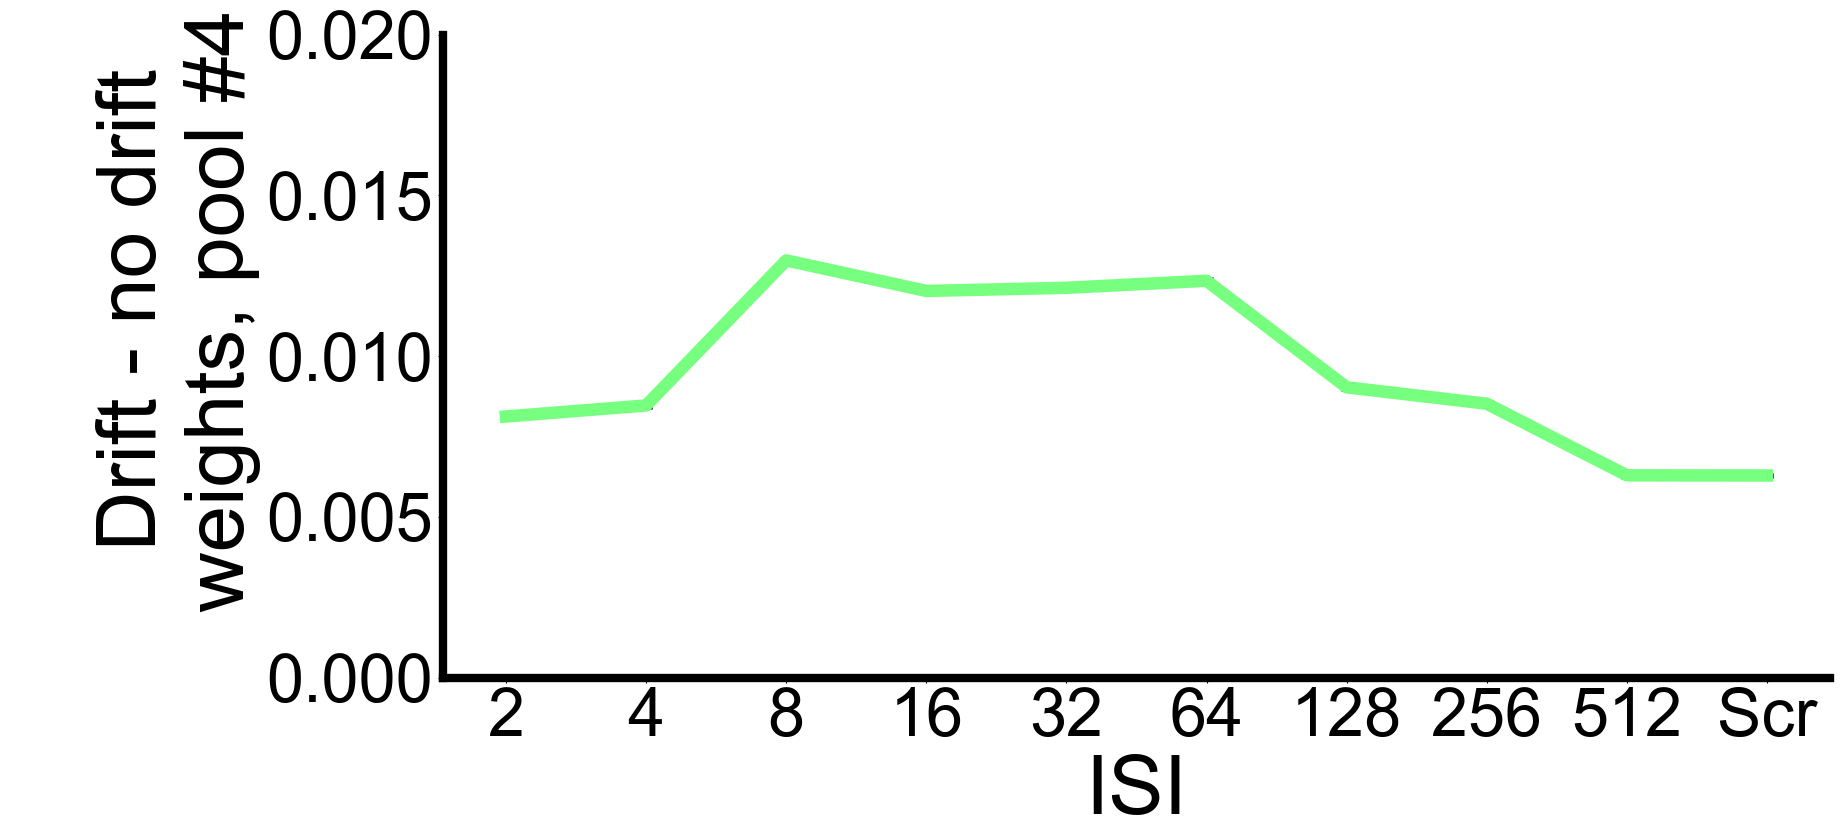

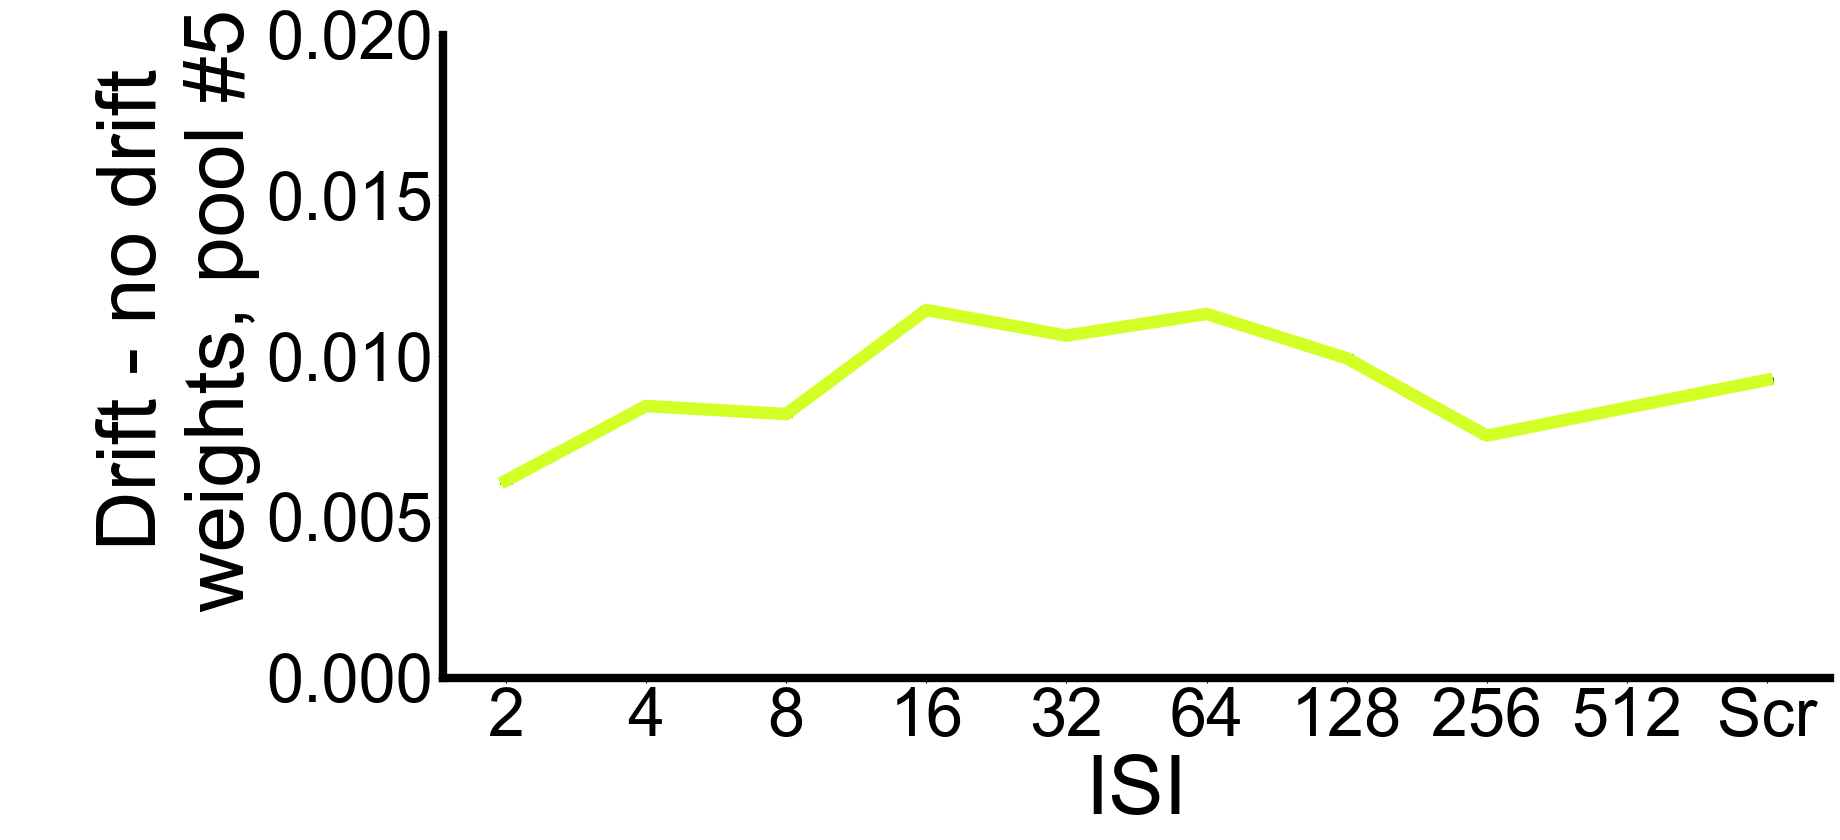

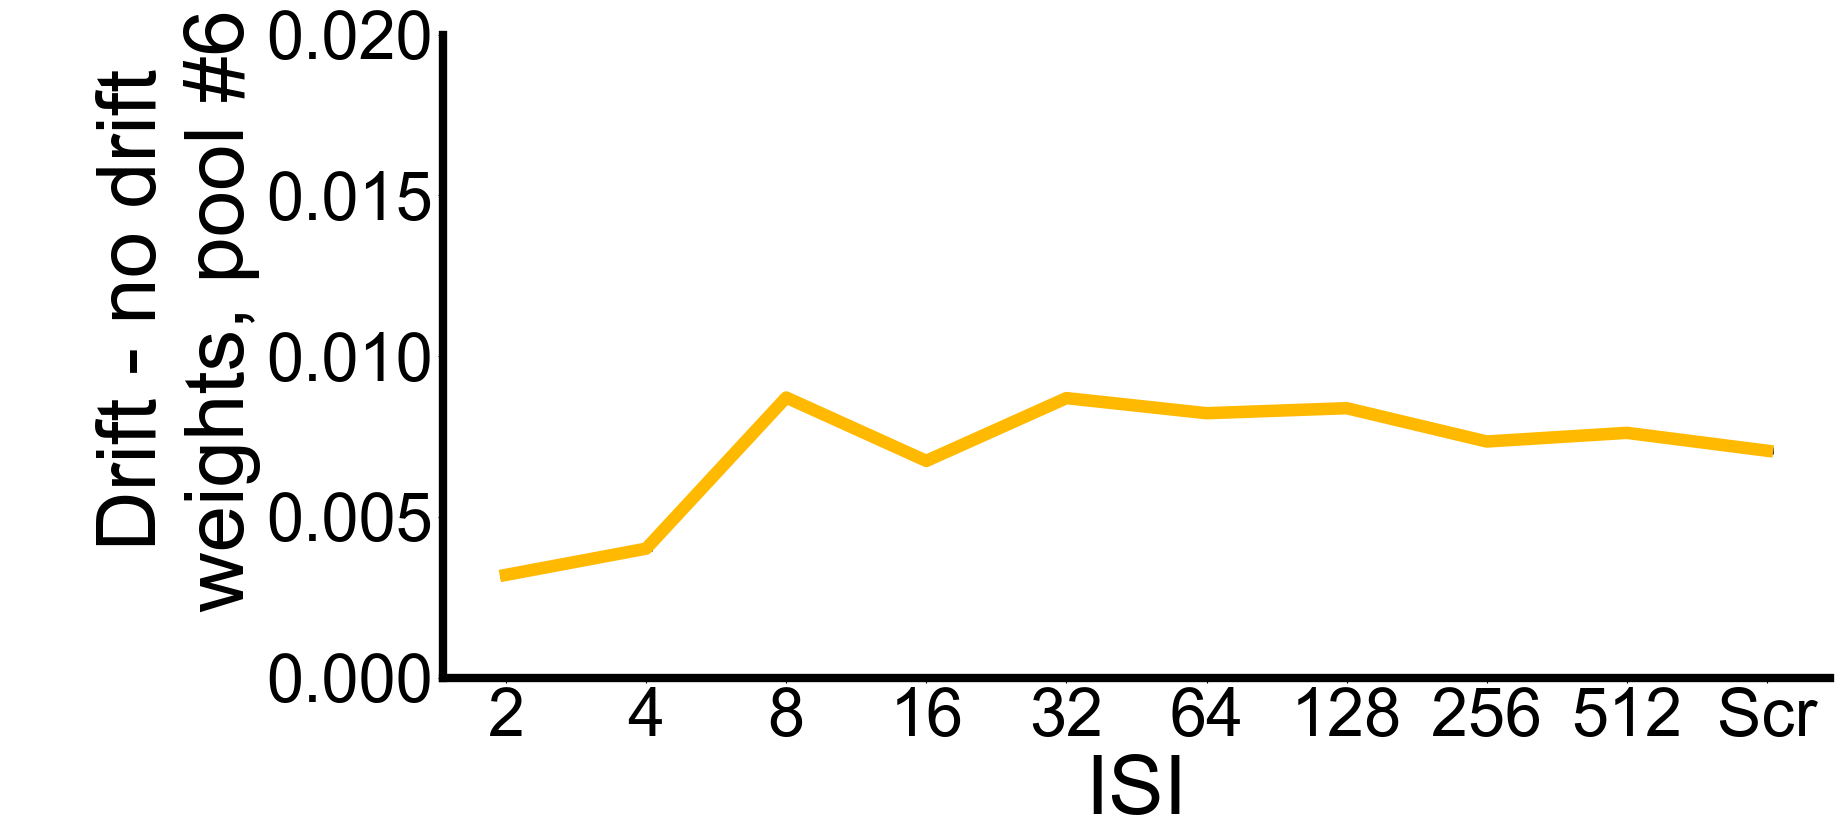

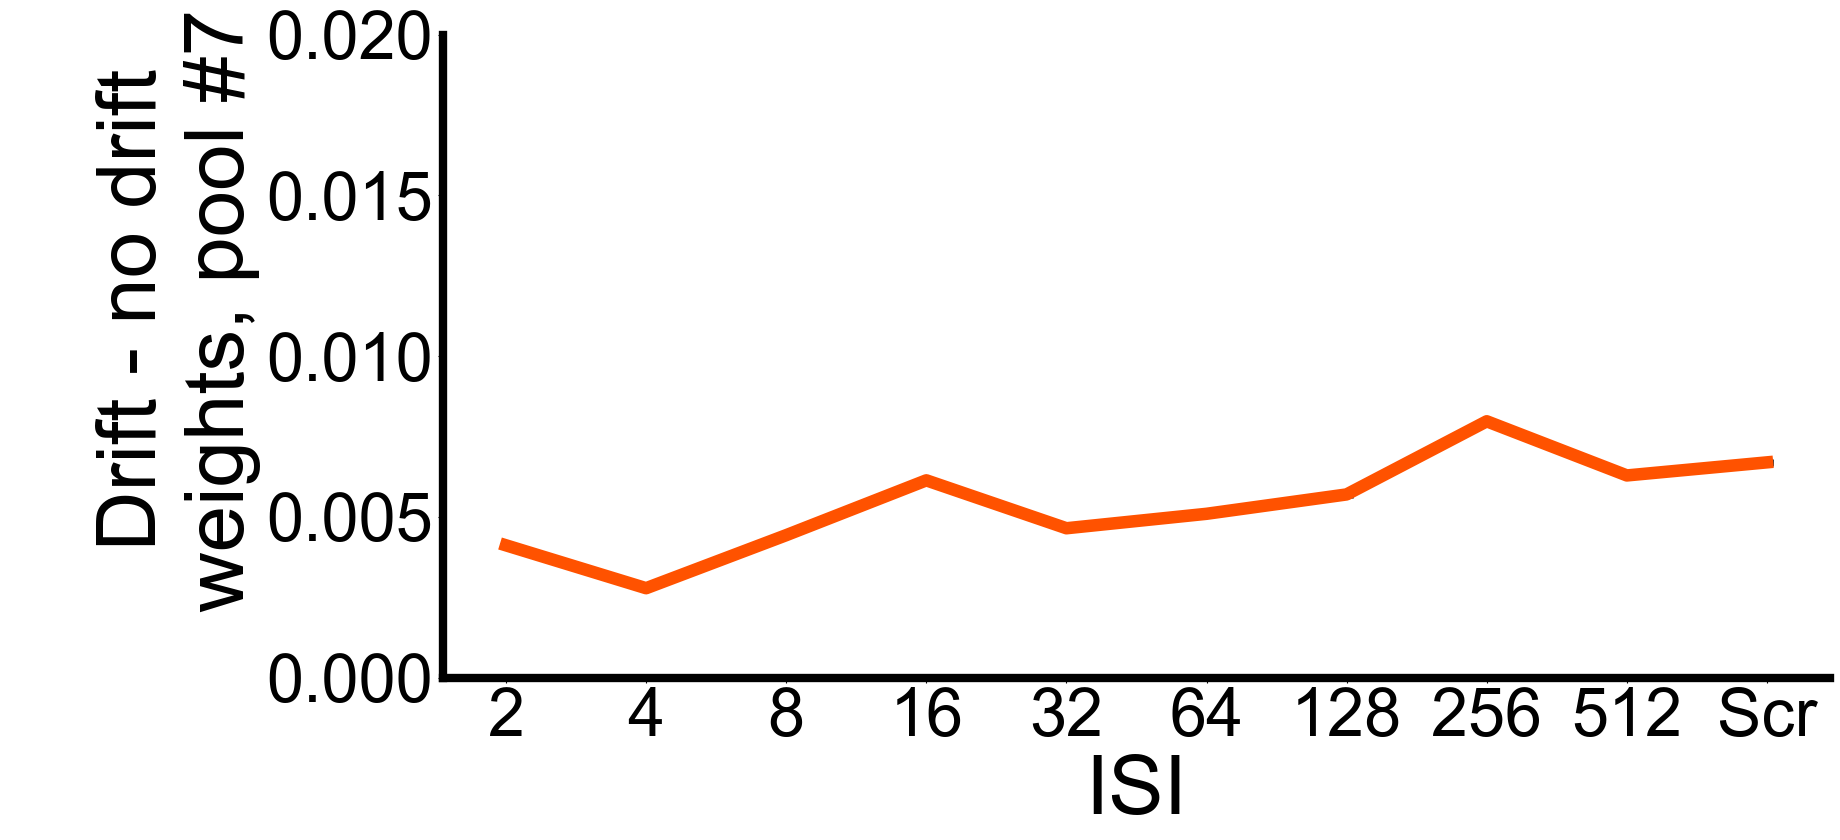

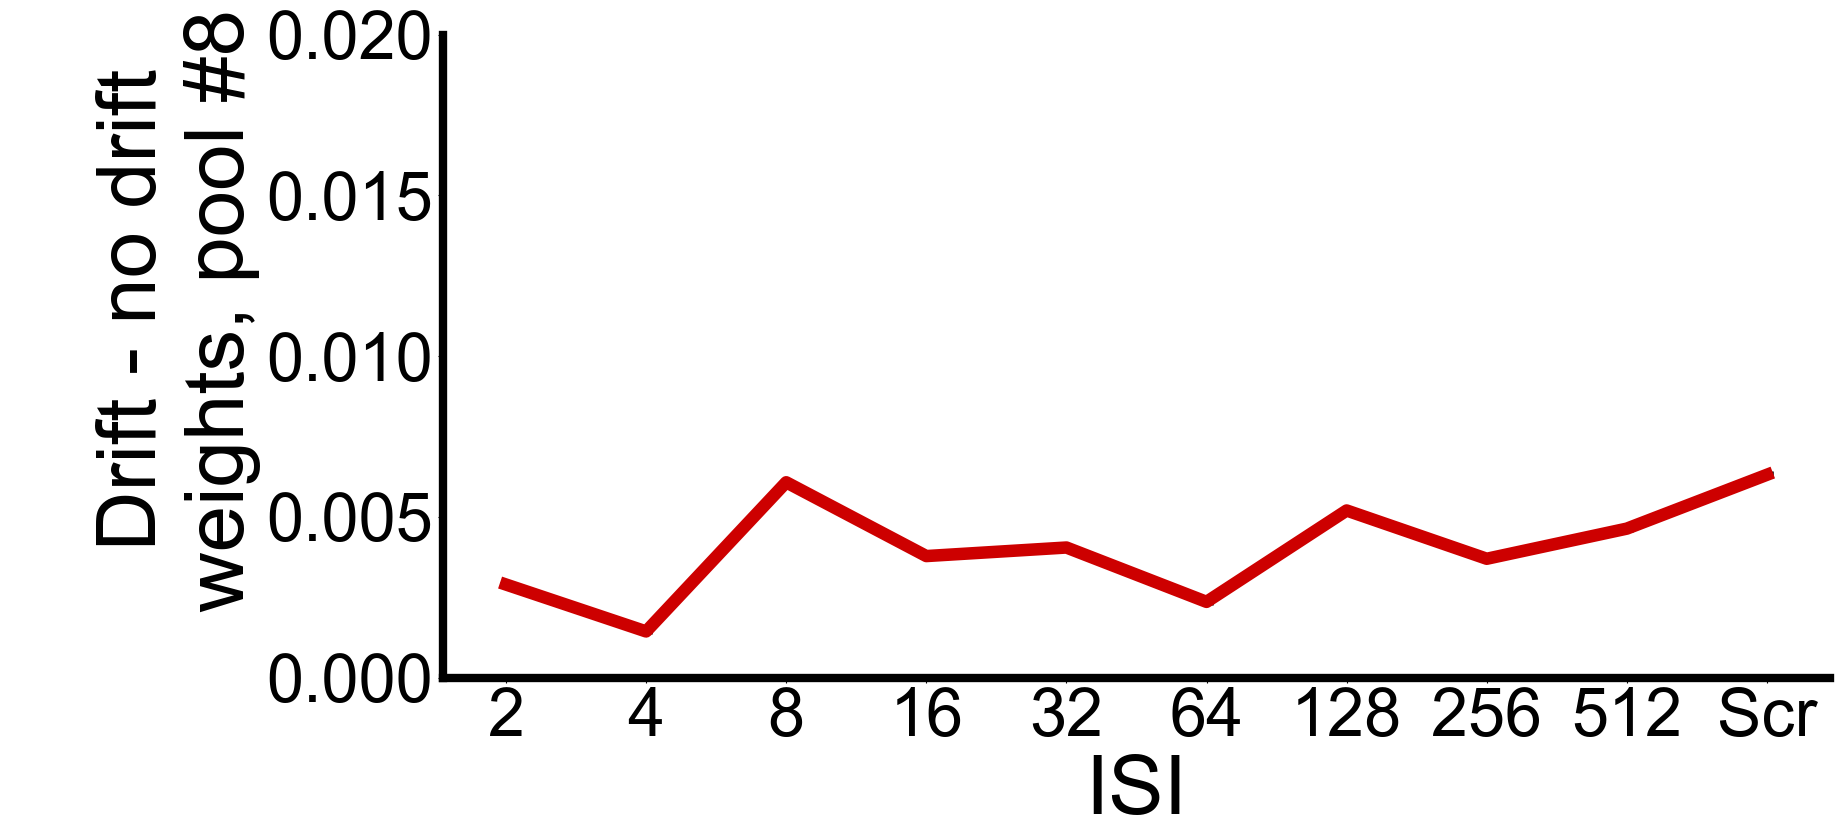

In [97]:
ntpools=8
def soloplot(diffmats,colnum,ln,fn,fnpt,custlab):
    #plot 1st and last temporal pool correlations across conditions
    cmapz = plt.get_cmap("jet") #DON'T use this b/c it's not being grouped by ISI!!
    cmn=14+28+i*28
    lln='Pool %s' %(i+1)
    ln='''
    Drift - no drift
    weights, pool #%s''' %(i+1)
    if custlab==1: #override with different label
        ln='''
        Drift - no drift
        weights, all pools'''
    dat,err=np.mean(diffmats[:,:,colnum],axis=1),np.std(diffmats[:,:,colnum],axis=1)/np.sqrt(nruns)
    xrge=np.arange(diffmats.shape[0]) #shape[2]+1
    plt.errorbar(xrge,dat,err,ecolor='k',linewidth=lw*3,elinewidth=lw*3,label=lln,color=cmapz(cmn))#,color='k')#
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel(ln,fontsize=cfs*5)#
    ax.set_xlabel("ISI",fontsize=cfs*5)
    ax.set_ylim([0,0.02])
    ax.set_xticks(np.arange(0,dat.shape[0],1))
    ax.set_xticklabels(['2','4','8','16','32','64','128','256','512','Scr'])
    ax.tick_params(axis="x", labelsize=cfs*4)
    ax.tick_params(axis="y", labelsize=cfs*4)
    f.tight_layout()
    if fnpt: #print
        f.savefig('figs/' + fn + '.pdf', transparent=True)
    rval=stats.pearsonr(xrge,dat)
    
lab1='''
Drift - no drift weights,
fastest temporal pool'''
lab2_0='''
Drift - no drift weights,
2nd slowest temporal pool'''
lab2='''
Drift - no drift weights,
slowest temporal pool'''
for i in range(8):
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fss*2,fss))
    soloplot(diffmats,i,lab1,'dvnd_diff_spec_%s_%s' %(i,allsp),1,0)

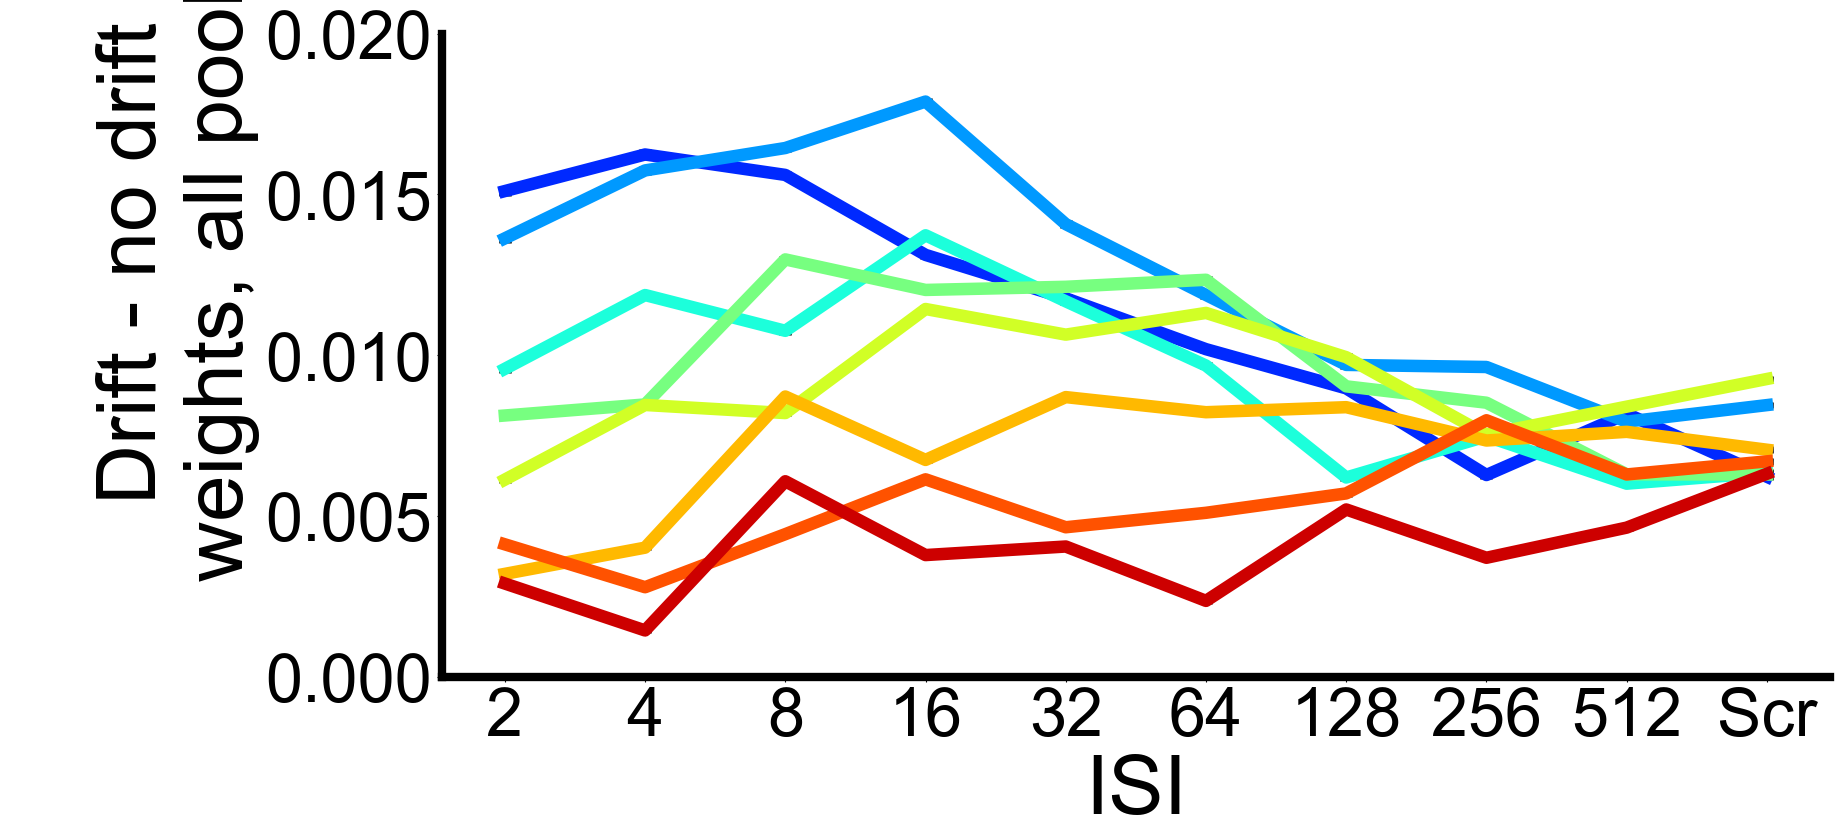

In [98]:
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fss*2,fss))
for i in range(diffmats.shape[2]):    
    soloplot(diffmats,i,lab1,'dvnd_diff_spec_all_%s' %(allsp),1,1)

In [103]:
diffmats.shape #ISI x nruns x npools
ntpools=8
len_t=diffmats.shape[0]*diffmats.shape[1]*diffmats.shape[2]
df_wts=pd.DataFrame({'subid':[0]*len_t,'Exp':['']*len_t,'Pool':[0]*len_t,'Wt':[0]*len_t})
for i in range(diffmats.shape[0]): #all exp conditions
    for ii in range(diffmats.shape[1]): #all runs
        count=i*nruns*ntpools+ii*ntpools
        subnum=i*nruns+ii
        df_wts['subid'][count:count+ntpools]=subnum
        df_wts['Exp'][count:count+ntpools]=tlls[i]
        df_wts['Pool'][count:count+ntpools]=[0,1,2,3,4,5,6,7]
        df_wts['Wt'][count:count+ntpools]=diffmats[i,ii,:].T

#export to R
exportR=1
if exportR:
    fn=rdir+str(allsp)+'-Rdata-wts.csv'
    df_wts.to_csv(fn)

(10, 100)
pval=1.3459671254201013e-48
(10, 100)
pval=4.4057215017308606e-36


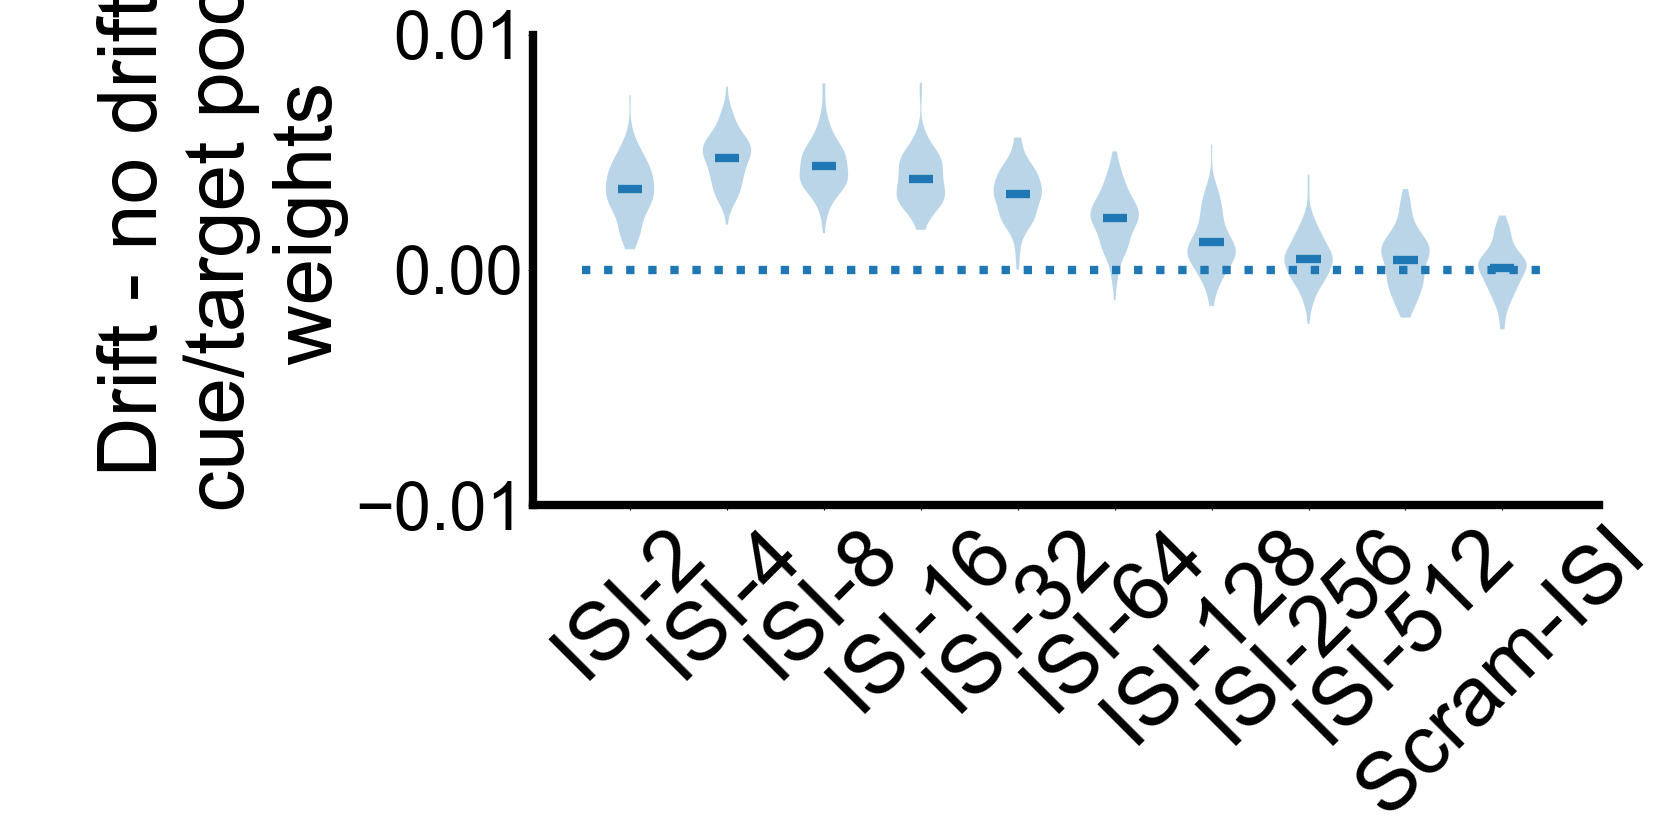

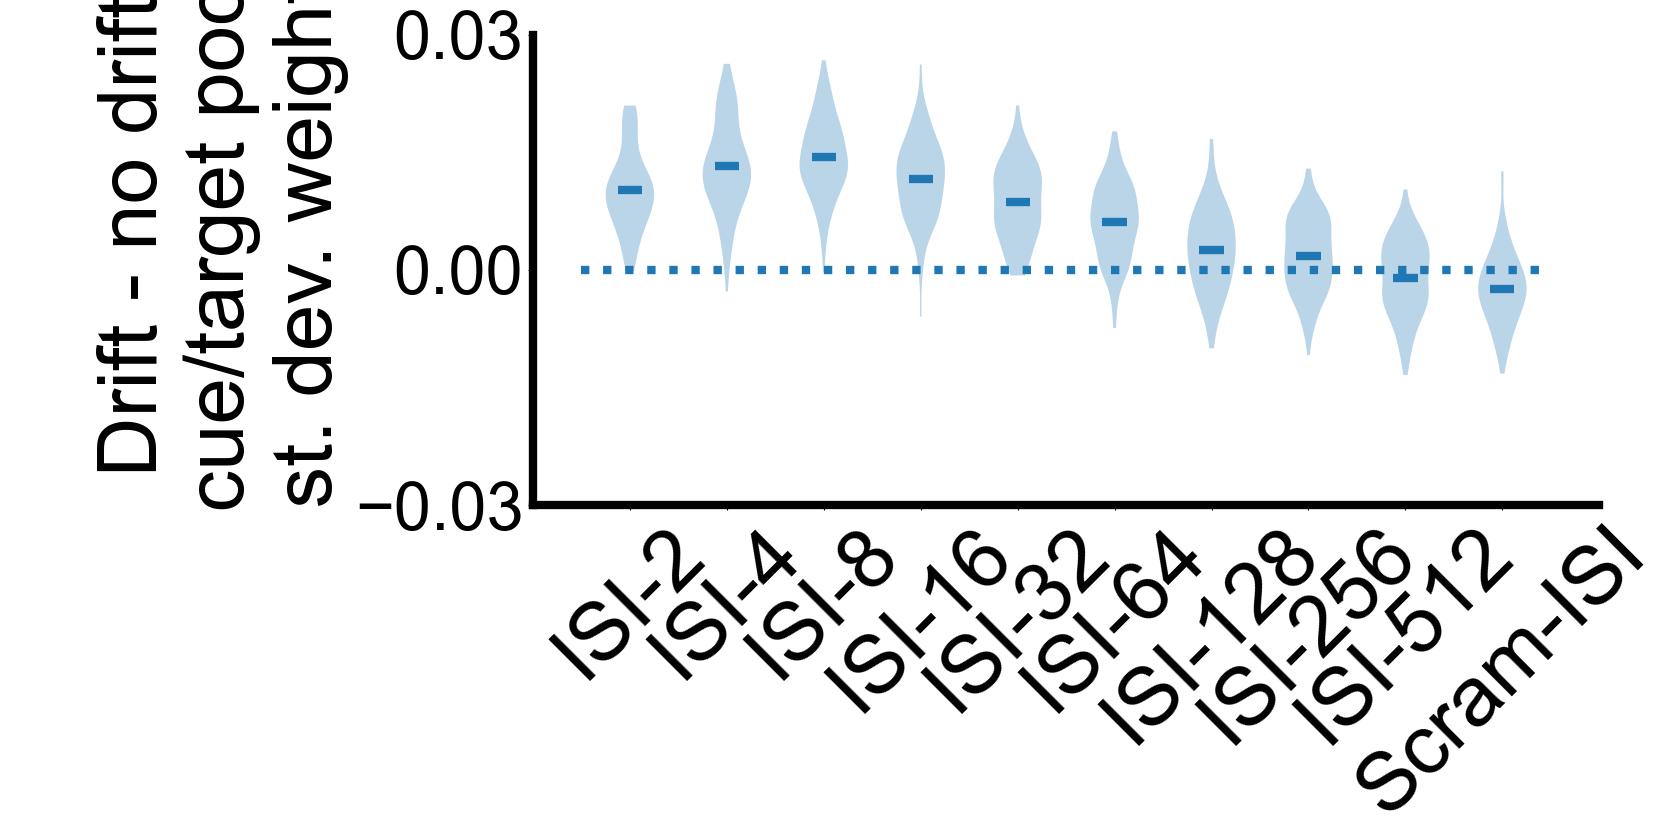

In [99]:
#plot weights in cue-target pools - note - NOT SAME as strength of weights between 
#the idiosyncratic units underlying individual associations!
def diffplotct(dat,yl,ytix,fn,fnpt):
    nctpools=8
    dat1,dat2=dat[1:,:,:,:],dat[0,:,:,:]
    if dat.shape[0]>2:
        diffs=np.mean(dat1[:,:,-1,:nctpools],axis=2)-np.mean(dat2[:,-1,:nctpools],axis=1)
    else:
        diffs=np.mean(dat1[0,:,-1,:nctpools],axis=1)-np.mean(dat2[:,-1,:nctpools],axis=1)
    print(diffs.shape)
    errs=np.std(diffs)
    dats=np.mean(diffs)
    if dat.shape[0]>2:
        ppp=scipy.stats.ttest_1samp(diffs[0,:],0)
        print('pval=%s' %ppp[1])
    else:
        ppp=scipy.stats.ttest_1samp(diffs,0)
        print('pval=%s' %ppp[1])
    if dat.shape[0]>3:
        f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fss*1.8,fss))
    else:
        f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fss,fss))
    
    plt.violinplot(diffs.T,showmeans=True,showextrema=False)
    ax.set_ylabel(yl)#,fontsize=cfs*3
    ax.set_ylim([ytix[0],ytix[2]])
    plt.hlines(0,0.5,dat.shape[0]-0.5,linestyles='dotted')
    if dat.shape[0]>3:
        ax.set_xticks(np.arange(1,dat.shape[0]))
    if dat.shape[0]>2:
        ax.set_xticklabels(tlls[1:], rotation = 45)
        
    ax.set_yticks(ytix)
    ax.tick_params(axis="y", labelsize=cfs*4)
    if dat.shape[0]==3:
        ax.set_ylabel(yl,fontsize=cfs*3)
        ax.set_xticklabels(tlls, rotation = 45)
        ax.tick_params(axis='both', which='major', labelsize=cfs*3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if dat.shape[0]<=2:
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])
    f.tight_layout()
    if fnpt: #print
        f.savefig('figs/' + fn + '.pdf', transparent=True)

if allsp<2:
    lab1='''
    Drift - no drift,
    cue/target pool,
    weights'''
    lab2='''
    Drift - no drift,
    cue/target pool,
    st. dev. weights'''
elif allsp==2:
    lab1='''
    Unequal - equal,
    cue/target pool,
    weights'''
    lab2='''
    Unequal - equal,
    cue/target pool,
    st. dev. weights'''
diffplotct(datmats,lab1,dctlims,'dvnd_ct_diff-%s' %allsp,1)
diffplotct(datmats_s,lab2,dctslims,'dvnd_ct_s_diff-%s' %allsp,1)

# 5 - Plot drifting autocorrelation patterns - Fig 1A and 11A

In [22]:
actpts,nctxts,nruns=1024,8,100
base1="/Users/jantony/Documents/stcm7/sims/stcm7/autocorr_ex1/"
fs1,fs2=10,10
ac_data=np.zeros((actpts,nctxts,nruns))
for rnum in range(nruns):
    for cnum in range(nctxts):
        fn=base1+"stcm7_Base_autocorr-" + str(rnum) + "-" + str(cnum) + ".tsv"
        acf=pd.read_csv(fn, sep=' ', header=0) #load in
        rown='autocorr%s' %(cnum+1)
        acf[rown]=acf[rown].values[::-1] #reverse, b/c they are flipped around
        if cnum==0:
            acf_a=pd.DataFrame(acf)
        else:
            acf_a=pd.concat([acf_a, acf], axis=1)
    ac_data[:,:,rnum]=acf_a.to_numpy()

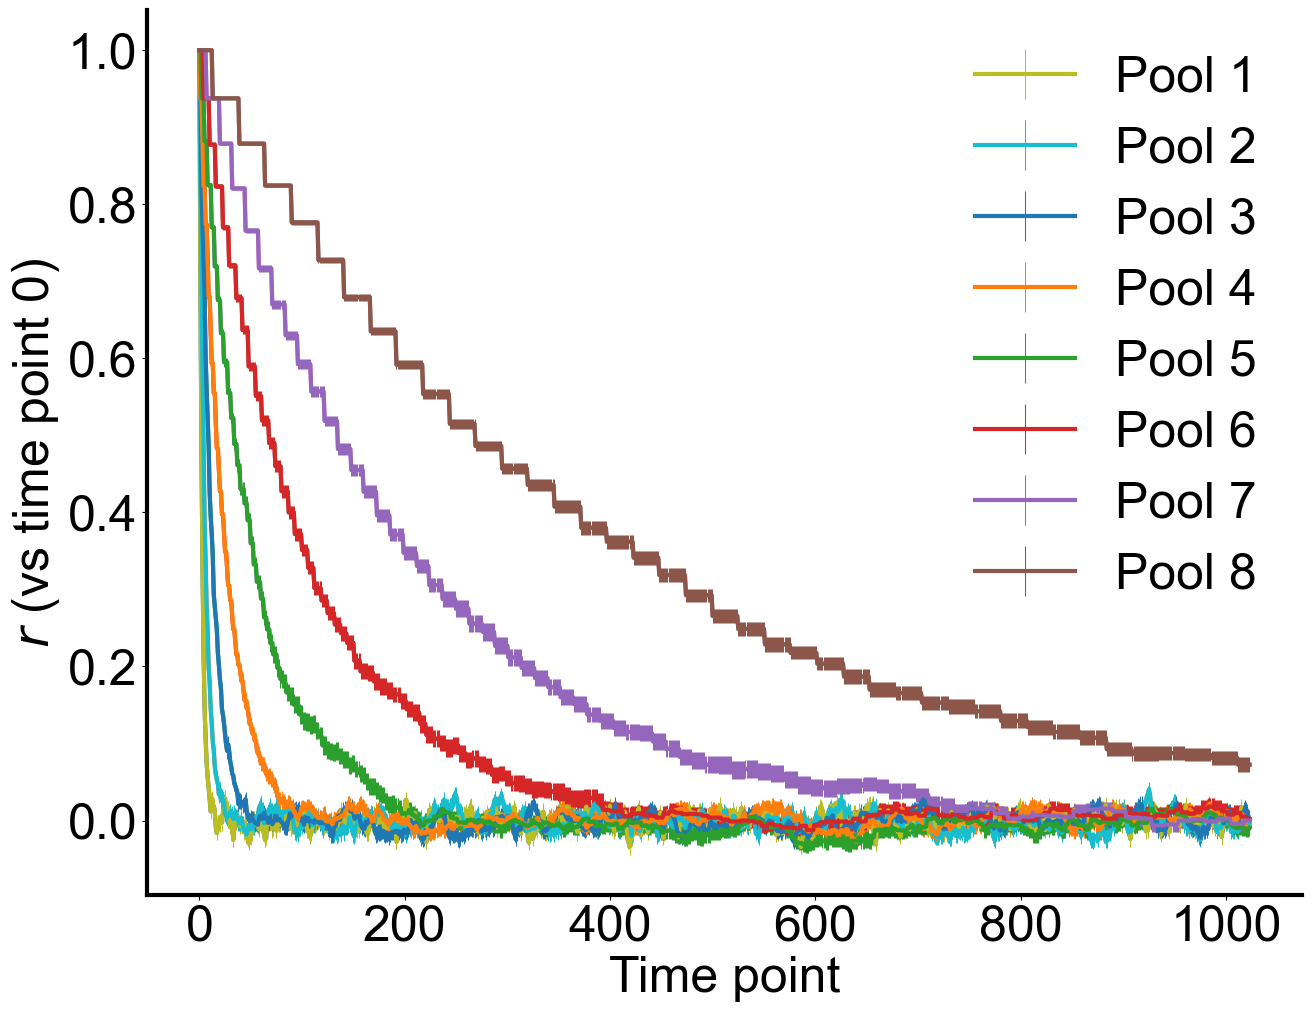

In [28]:
#plot all together
#NOTE - colors messed up! fix in illustrator
f,ax=plt.subplots(1,1,figsize=(fs2*1.4,fs2*1.1))
for i in range(nctxts):
    ln='Pool %s' %(i+1)
    plt.plot(np.arange(actpts),np.mean(ac_data[:,i,:],axis=1),linewidth=3)
    plt.xlabel('Time point')
    plt.ylabel('$\it{r}$ (vs time point 0)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
for i in range(nctxts):
    ln='Pool %s' %(i+1)
    plt.errorbar(np.arange(actpts),np.mean(ac_data[:,i,:],axis=1),
        np.std(ac_data[:,i,:],axis=1)/np.sqrt(nruns),label=ln,elinewidth=0.75)
    
leg=plt.legend(loc='upper right',frameon=False)
for line in leg.get_lines():
    line.set_linewidth(6)
f.tight_layout()
fn='figs/autocorrelations.pdf'
f.savefig(fn, transparent=True)

first point below zero for fastest: 16
first point below zero for medium: 123
first point below zero for slowest: []


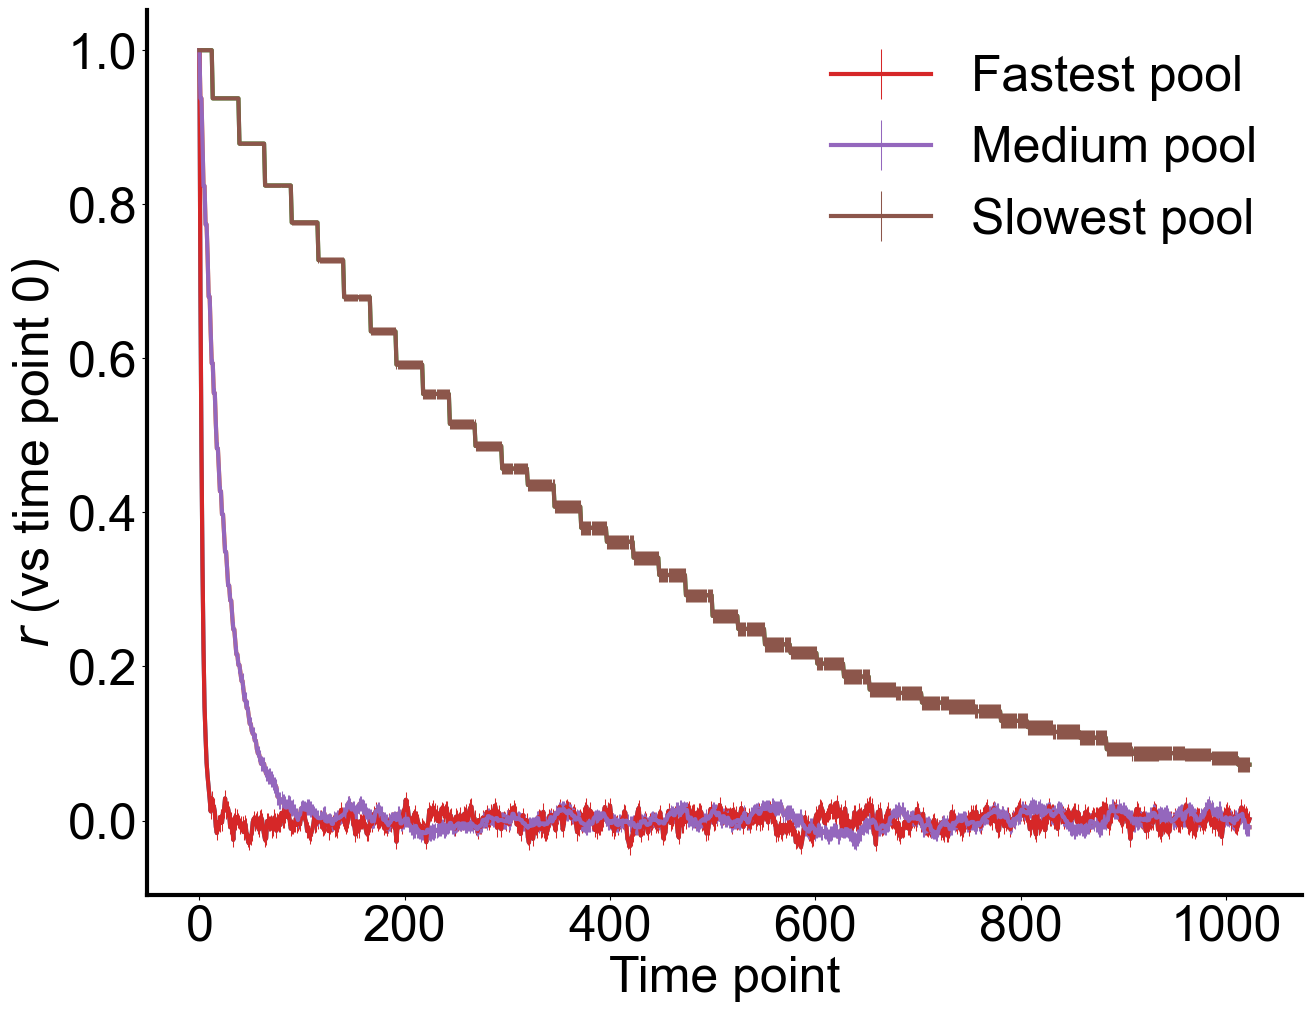

In [39]:
#plot a few (Fig 11A)
#NOTE - colors messed up! fix in illustrator
f,ax=plt.subplots(1,1,figsize=(fs2*1.4,fs2*1.1))
pared=[0,3,7]
for i in range(len(pared)):
    lid=pared[i] #line ID
    plt.plot(np.arange(actpts),np.mean(ac_data[:,lid,:],axis=1),linewidth=3)#label=ln,
    plt.xlabel('Time point')
    plt.ylabel('$\it{r}$ (vs time point 0)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
for i in range(len(pared)):
    lid=pared[i] #line ID
    if i==0:
        ln='Fastest pool'
    elif i==1:
        ln='Medium pool'
    elif i==2:
        ln='Slowest pool'
    plt.errorbar(np.arange(actpts),np.mean(ac_data[:,lid,:],axis=1),
        np.std(ac_data[:,lid,:],axis=1)/np.sqrt(nruns),label=ln,elinewidth=0.75)
    
leg=plt.legend(loc='upper right',frameon=False)
for line in leg.get_lines():
    line.set_linewidth(6)
f.tight_layout()
fn='figs/autocorrelations_pared.pdf'
f.savefig(fn, transparent=True)
print('first point below zero for fastest:',np.where(np.mean(ac_data[:,pared[0],:],axis=1)<0)[0][0])
print('first point below zero for medium:',np.where(np.mean(ac_data[:,pared[1],:],axis=1)<0)[0][0])
print('first point below zero for slowest:',np.where(np.mean(ac_data[:,pared[2],:],axis=1)<0)[0])

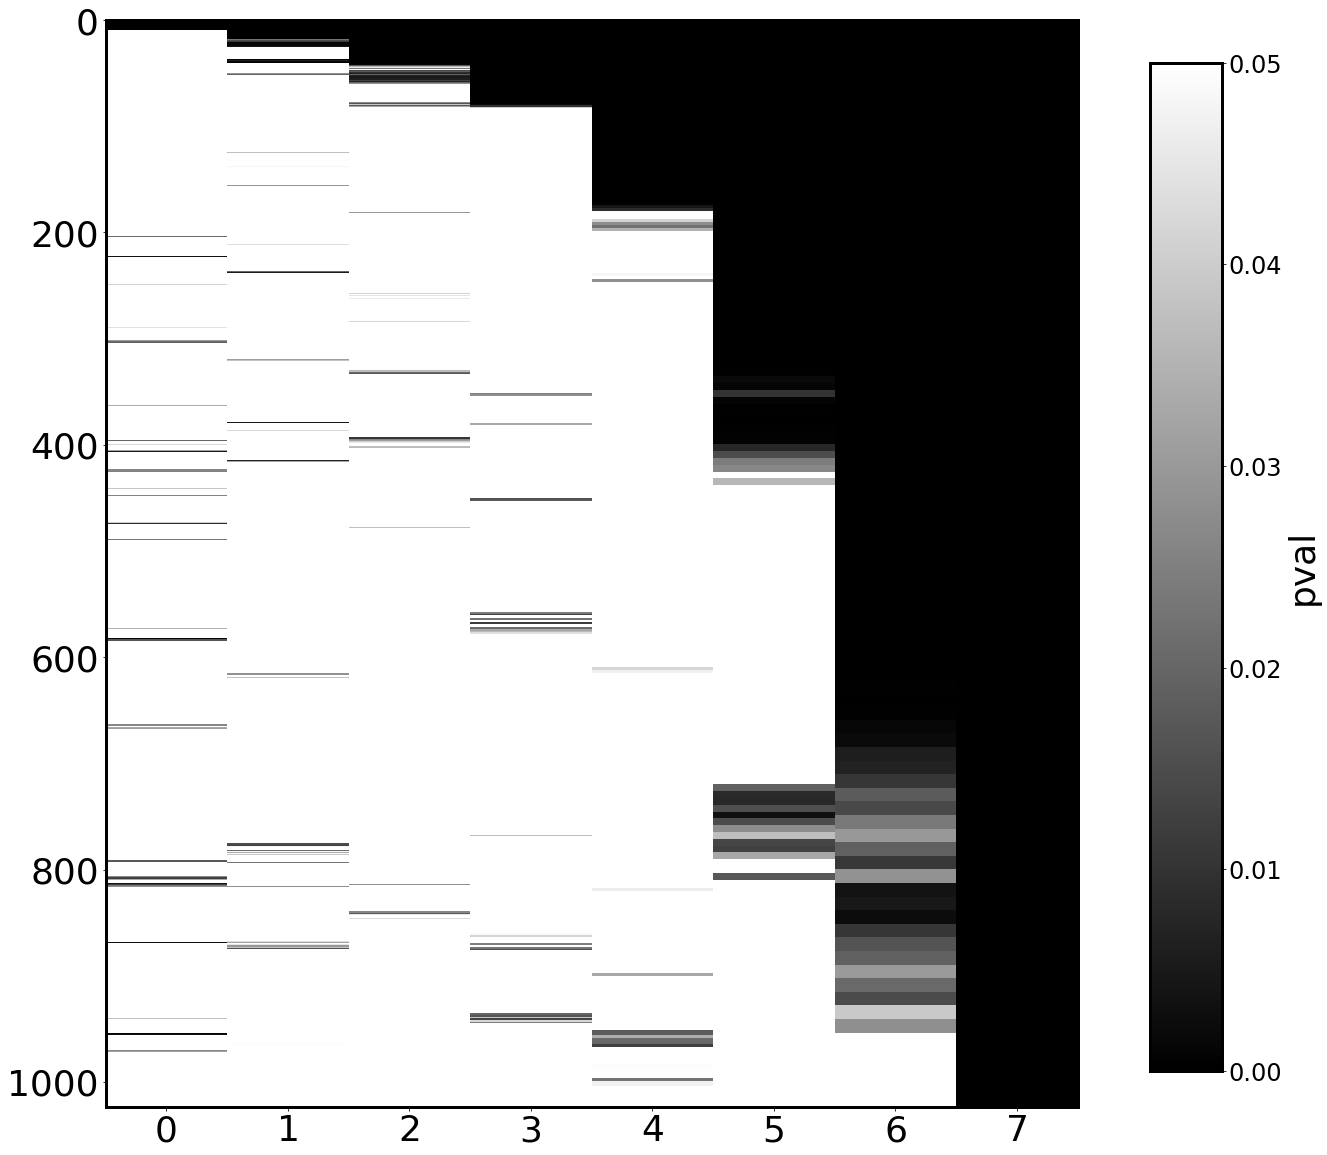

In [24]:
#plot how long the autocorrelation coefficient differs from 0, by pool (all start different)
pval=np.zeros((actpts,nctxts))
for i in range(actpts):
    for j in range(nctxts):
        ppp=scipy.stats.ttest_1samp(ac_data[i,j,:],0)
        pval[i,j]=ppp[1]

f,ax=plt.subplots(1,1,figsize=(fs2*2,fs2*2))
vm,vmx=0,0.05
im=ax.imshow(pval,interpolation='none',cmap=cm,vmin=vm,vmax=vmx,aspect='auto')
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
cbar=f.colorbar(im,cax=cbar_ax)
cbar.set_label('pval',fontsize=cfs*3)
cbar.set_clim(0, 0.3)
cbar.ax.tick_params(labelsize=cfs*2) 
plt.show()